<a href="https://colab.research.google.com/github/amelia2801/CS598-DLH-Team56/blob/main/DL4H_Team_56.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook is the CS 598 Deep Learning for Healthcare Final Project. All other supplementary files and the notebook itself can be accessed from this Google Drive link: https://drive.google.com/drive/folders/1zt1xwsVEDUSJVlgYPBxmAcfsWkehpo9G?usp=drive_link

*For Final Project submission purpose, a public GitHub repository containing the notebook also available: https://github.com/amelia2801/CS598-DLH-Team56/

# Introduction

Family history is a proven indicator of an individual's predisposition to certain diseases, but its use is complicated by the difficulty of gathering family history data and the lack of tools to intepret such data and connections. The introduction and prevalence of EHRs has made patient medical information much easier to access and compile across generations, presenting an opportunity to study multigenerational EHRs for entire families. Meanwhile, machine learning techniques have improved to the point where not only processing large amounts of medical data but also interpreting family connections between individuals is possible.

There are some existing works that also includes family history in machine learning models to predict the risk of various diseases [3,4]. However, their approaches were developed for tabular data. Thus, they do not model the geometric structure of family history which is useful for the prediction.

The paper aims to demonstrate the effectiveness of graph-based learning in predicting disease onset in individuals based off of their family history. To do this, the authors used graph neural networks (GNNs) and Long Short-Term Memory networks (LSTMs).

The model proposed by the paper learns explainable node embeddings for individual relatives and also achieves better performance for complex diseases than clinically-inspired and other deep learning baselines.

# Scope of Reproducibility:


Here we list the hypotheses from the paper that we will test and the experiment that we will run.


**Hypothesis**: A graph-based approach to predicting disease through family history is better compared to other current deep-learning approaches.

In this notebook, we will run a part of ablation studies that was done by the paper, specifically using the synthetic datasets provided by the authors. The proposed model GNN-LSTM are compared to several others deep learning baselines.

We imported some the code provided by the authors of the paper from [2] into this notebook.

# Methodology

In [ ]:
# Uninstall any torch installation if exists. This is to make sure that we import the correct version.
!pip uninstall torch -y

Found existing installation: torch 2.2.1+cu121
Uninstalling torch-2.2.1+cu121:
  Successfully uninstalled torch-2.2.1+cu121


Mount the notebook to Google Drive with the specified directory:

In [ ]:
import sys
print(f"sys version: {sys.version}")
from google.colab import drive

# Mount notebook to google drive
drive.mount('/content/gdrive', force_remount=True)
root_url = '/content/gdrive/My Drive/CS598 DLH Project'
sys.path.append(root_url)


sys version: 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
Mounted at /content/gdrive


❗ FOR GRADER: Run the cell below only once, the first time you run this notebook. This will install necessary libraries once.

In [ ]:
# Install virtualenv to create virtual environment
!pip install virtualenv
# Create virtual environment
!virtualenv '/content/gdrive/My Drive/CS598 DLH Project/colab_env'
# Activate the virtual environment and install necessary libraries
# Here we install: torch 1.12.1, torchvision 0.13.1, torchaudio 0.12.1, torch-geometric 2.2.0
!source /content/gdrive/My\ Drive/CS598\ DLH\ Project/colab_env/bin/activate; pip install torch==1.12.1+cu102 torchvision==0.13.1+cu102 torchaudio==0.12.1 --extra-index-url https://download.pytorch.org/whl/cu102; pip install pyg-lib torch-scatter torch-sparse torch-cluster -f https://data.pyg.org/whl/torch-1.12.0+cu102.html; pip install torch_geometric==2.2.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.9/468.9 kB 13.3 MB/s eta 0:00:00
created virtual environment CPython3.10.12.final.0-64 in 31881ms
  creator CPython3Posix(dest=/content/gdrive/.shortcut-targets-by-id/1zt1xwsVEDUSJVlgYPBxmAcfsWkehpo9G/CS598 DLH Project/colab_env, clear=False, no_vcs_ignore=False, global=False)
  seeder FromAppData(download=False, pip=bundle, setuptools=bundle, wheel=bundle, via=copy, app_data_dir=/root/.local/share/virtualenv)
    added seed packages: Jinja2==3.1.3, MarkupSafe==2.1.5, certifi==2024.2.2, charset_normalizer==3.3.2, idna==3.7, joblib==1.4.0, numpy==1.26.4, pillow==10.3.0, pip==24.0, psutil==5.9.8, pyg_lib==0.2.0+pt112cu102, pyparsing==3.1.2, requests==2.31.0, scikit_learn==1.4.2, scipy==1.13.0, setuptools==69.5.1, threadpoolctl==3.4.0, torch==1.12.1+cu102, torch_cluster==1.6.3, torch_geometric==2.2.0, torch_scatter==2.1.2, torch_sparse==0.6.18, torchaudio==0.12.

In [ ]:
# Append the path of installed packages
sys.path.append("/content/gdrive/My Drive/CS598 DLH Project/colab_env/lib/python3.10/site-packages")

In [ ]:
sys.path

['/content',
 '/env/python',
 '/usr/lib/python310.zip',
 '/usr/lib/python3.10',
 '/usr/lib/python3.10/lib-dynload',
 '',
 '/usr/local/lib/python3.10/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.10/dist-packages/IPython/extensions',
 '/root/.ipython',
 '/content/gdrive/My Drive/CS598 DLH Project',
 '/content/gdrive/My Drive/CS598 DLH Project/colab_env/lib/python3.10/site-packages']

In [ ]:
# Activate the virtual environment
!source /content/gdrive/My\ Drive/CS598\ DLH\ Project/colab_env/bin/activate;

In [ ]:
import time
import numpy as np
import torch
print(f"pytorch version: {torch.__version__}")
import torch.nn as nn
from torch.utils.data import Dataset

import torch_geometric
print(f"torch_geometric version: {torch_geometric.__version__}")
import torch_geometric.nn as gnn
from torch_geometric.data import Dataset as GraphDataset
from torch_geometric.data import Batch
from torch_geometric.loader import DataLoader

import torch.nn.functional as F
import pandas as pd
from random import choices
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn import metrics
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import confusion_matrix

pytorch version: 1.12.1+cu102
torch_geometric version: 2.2.0


In [ ]:
from utils import EarlyStopping, get_classification_threshold_auc, get_classification_threshold_precision_recall, WeightedBCELoss
import explainability

##  Data

The original paper used data from Finland's nationwide EHR system, which we are unable to use for privacy and security reasons. Instead, we will use the example synthetic dataset they generated from the provided synthetic data generator, which we store in the folder 'sample_data'. The example data can also be found here: https://github.com/dsgelab/family-EHR-graphs/tree/main/test.

The dataset consists of 3 main files - the edgefile, maskfile, and statfile - and several feature files that specifies which features to use for training the model. The maskfile contains data that specifies which samples belong to the target cohort - the patients to predict outcomes for - and which samples belong to the family cohort - relatives of the target patients, as well as specifying the training, validation, and test split for the dataset. The edgefile contains data for the edges and edge pairs for the family graphs. The statfile contains the age, sex, medical history data, and prediction label for all samples.

In [ ]:
class DataFetch():
    '''
    Class to fetch and format data
    '''
    def __init__(self, maskfile, featfile, statfile, edgefile, sqlpath, params, alt_featfile=None, local=False):
        feat_df = pd.read_csv(featfile)
        self.local = local
        self.static_features = feat_df[feat_df['type']=='static']['name'].tolist()
        self.longitudinal_features = feat_df[feat_df['type']=='longitudinal']['name'].tolist()
        self.edge_features = feat_df[feat_df['type']=='edge']['name'].tolist()
        # some gnn layers only support a single edge weight
        if params['gnn_layer'] in ['gcn', 'graphconv']: self.edge_features=['weight']
        self.label_key = feat_df[feat_df['type']=='label']['name'].tolist()[0]
        self.static_data = torch.tensor(pd.read_csv(statfile)[self.static_features].values, dtype=torch.float)
        self.label_data = torch.tensor(pd.read_csv(statfile)[self.label_key].to_numpy(), dtype=torch.float32)
        if len(self.longitudinal_features)>0 and not self.local: self.conn = sqlite3.connect(sqlpath)
        self.params = params

        if params['model_type'] in ['graph', 'graph_no_target', 'explainability']:
            # can specify a different feature set using alt_featfile
            alt_feat_df = pd.read_csv(alt_featfile)
            self.alt_static_features = alt_feat_df[alt_feat_df['type']=='static']['name'].tolist()
            self.alt_static_data = torch.tensor(pd.read_csv(statfile)[self.alt_static_features].values, dtype=torch.float)

        mask_df = pd.read_csv(maskfile)
        self.id_map = dict(zip(mask_df['node_id'], mask_df['PATIENTID']))
        self.train_patient_list = torch.tensor(mask_df[mask_df['train']==0]['node_id'].to_numpy())
        self.validate_patient_list = torch.tensor(mask_df[mask_df['train']==1]['node_id'].to_numpy())
        self.test_patient_list = torch.tensor(mask_df[mask_df['train']==2]['node_id'].to_numpy())
        self.num_samples_train_minority_class = torch.sum(self.label_data[self.train_patient_list]==1).item()
        self.num_samples_train_majority_class = torch.sum(self.label_data[self.train_patient_list]==0).item()
        self.num_samples_valid_minority_class = torch.sum(self.label_data[self.validate_patient_list]==1).item()
        self.num_samples_valid_majority_class = torch.sum(self.label_data[self.validate_patient_list]==0).item()

        if params['model_type']!='baseline':
            self.edge_df = pd.read_csv(edgefile)
            self.edge_df = self.edge_df.groupby('target_patient').agg(list)

    def get_static_data(self, patients):
        x_static = self.static_data[patients]
        y = self.label_data[patients]
        return x_static, y

    def get_alt_static_data(self, patients):
        x_static = self.alt_static_data[patients]
        return x_static

    def get_longitudinal_data(self, patients):
        if self.local:
            # return simulated data for local testing
            num_nodes = len(patients)
            num_years = self.params['obs_window_end']-self.params['obs_window_start']+1
            num_features = len(self.longitudinal_features)
            num_data = int(num_nodes*num_years*num_features*0.01)
            i = [choices(range(num_nodes),k=num_data), choices(range(num_years),k=num_data), choices(range(num_features),k=num_data)]
            v = [1]*num_data
            x_longitudinal = torch.sparse_coo_tensor(i, v, (num_nodes, num_years, num_features), dtype=torch.float32)
            x_longitudinal_dense = x_longitudinal.to_dense()
        else:
            # fetch data from SQLite database
            id_list = [self.id_map[patient.item()] for patient in patients]
            data = pd.DataFrame()
            for patient in id_list:
                command = "SELECT PATIENTID, EVENT_YEAR, ENDPOINT FROM long WHERE PATIENTID='{}'".format(patient)
                data = pd.concat([data, pd.read_sql_query(command, self.conn)])
            data = data[data['ENDPOINT'].isin(self.longitudinal_features)]

            # limit to observation window years
            data['EVENT_YEAR'] = data['EVENT_YEAR'].astype(int)
            data = data[(data['EVENT_YEAR']>=self.params['obs_window_start'])&(data['EVENT_YEAR']<=self.params['obs_window_end'])]

            # map to index positions
            node_index = dict(zip(id_list, range(len(id_list))))
            year_index = dict(zip(np.arange(self.params['obs_window_start'], self.params['obs_window_end']+1), range(self.params['obs_window_end']-self.params['obs_window_start']+1)))
            feat_index = dict(zip(self.longitudinal_features, range(len(self.longitudinal_features))))
            data['PATIENTID'] = data['PATIENTID'].map(node_index)
            data['EVENT_YEAR'] = data['EVENT_YEAR'].map(year_index)
            data['ENDPOINT'] = data['ENDPOINT'].map(feat_index)

            # create sparse tensor
            i = [data['PATIENTID'].tolist(), data['EVENT_YEAR'].tolist(), data['ENDPOINT'].tolist()]
            v = [1]*len(data)
            x_longitudinal = torch.sparse_coo_tensor(i, v, (len(node_index), len(year_index), len(feat_index)), dtype=torch.float32)
            x_longitudinal_dense = x_longitudinal.to_dense()

        return x_longitudinal_dense

    def get_relatives(self, patients):
        """Returns a list of node ids included in any of these patient graphs
        """
        return torch.tensor(list(set([i for list in self.edge_df.loc[patients]['node1'].to_list() for i in list] + [i for list in self.edge_df.loc[patients]['node2'].to_list() for i in list])))

    def construct_patient_graph(self, patient, all_relatives, all_x_static, all_y, all_x_longitudinal=None):
        """Creates a re-indexed pytorch geometric data object for the patient
        """
        # order nodes and get indices in all_relatives to retrieve feature data
        node_ordering = np.asarray(list(set(self.edge_df.loc[patient].node1 + self.edge_df.loc[patient].node2)))
        node_indices = [list(all_relatives.tolist()).index(value) for value in node_ordering]
        x_static = all_x_static[node_indices]
        y = all_y[list(all_relatives.tolist()).index(patient)] # predicting single value for each graph

        # reindex the edge indices from 0, 1, ... num_nodes
        node1 = [list(node_ordering.tolist()).index(value) for value in self.edge_df.loc[patient].node1]
        node2 = [list(node_ordering.tolist()).index(value) for value in self.edge_df.loc[patient].node2]
        edge_index = torch.tensor([node1,node2], dtype=torch.long)
        edge_weight = torch.t(torch.tensor(self.edge_df.loc[patient][self.edge_features], dtype=torch.float))

        data = torch_geometric.data.Data(x=x_static, edge_index=edge_index, y=y, edge_attr=edge_weight)
        transform = torch_geometric.transforms.ToUndirected(reduce='mean')
        data = transform(data)
        if all_x_longitudinal is not None: data.x_longitudinal = all_x_longitudinal[node_indices]
        data.target_index = torch.tensor(list(node_ordering.tolist()).index(patient))
        return data


class Data(Dataset):
    def __init__(self, patient_list, fetch_data):
        """
        Loads non-graph datasets for a given list of patients
        Returns (x_static, x_longitudinal, y) if longitudinal data included, else (x_static, y)
        """
        self.patient_list = patient_list
        self.num_target_patients = len(patient_list)
        self.fetch_data = fetch_data
        self.include_longitudinal = len(fetch_data.longitudinal_features)>0

    def __getitem__(self, patients):
        batch_patient_list = self.patient_list[patients]
        x_static, y = self.fetch_data.get_static_data(batch_patient_list)
        if self.include_longitudinal:
            x_longitudinal = self.fetch_data.get_longitudinal_data(batch_patient_list)
            return x_static, x_longitudinal, y
        else:
            return x_static, y

    def __len__(self):
        return self.num_target_patients


class GraphData(GraphDataset):
  def __init__(self, patient_list, fetch_data):
      """
      Loads a batch of multiple patient graphs
      """
      self.patient_list = patient_list
      self.num_target_patients = len(patient_list)
      self.fetch_data = fetch_data
      self.include_longitudinal = len(fetch_data.longitudinal_features)>0

  def __getitem__(self, patients):
      # returns multiple patient graphs by constructing a pytorch geometric Batch object
      batch_patient_list = self.patient_list[patients]
      data_list = []

      # it's more efficient to fetch feature data for all patients and their relatives,
      # and then split into separate graphs
      all_relatives = self.fetch_data.get_relatives(batch_patient_list)
      all_x_static, all_y = self.fetch_data.get_static_data(all_relatives)
      patient_x_static = self.fetch_data.get_alt_static_data(batch_patient_list)
      if self.include_longitudinal: all_x_longitudinal = self.fetch_data.get_longitudinal_data(all_relatives)
      else: all_x_longitudinal = None

      patient_index = 0
      for patient in batch_patient_list:
        patient_graph = self.fetch_data.construct_patient_graph(patient.item(), all_relatives, all_x_static, all_y, all_x_longitudinal)
        patient_graph.patient_x_static = patient_x_static[patient_index].reshape(1,-1)
        if self.include_longitudinal:
            patient_x_longitudinal = patient_graph.x_longitudinal[patient_graph.target_index]
            patient_graph.patient_x_longitudinal = patient_x_longitudinal[None,:,:]
        data_list.append(patient_graph)
        patient_index += 1

      batch_data = Batch.from_data_list(data_list)
      return batch_data

  def __len__(self):
      return self.num_target_patients

In [ ]:
def get_data_and_loader(patient_list, fetch_data, params, shuffle=True):
    """
    Parameters:
    patient_list: list of patients (target samples) to load data for
    fetch_data: the data object
    params: dictionary of other parameters
    shuffle: samples in random order if true
    """
    if params['model_type'] == 'baseline':
        dataset = Data(patient_list, fetch_data)
    elif params['model_type'] in ['graph', 'graph_no_target', 'explainability']:
        dataset = GraphData(patient_list, fetch_data)

    if shuffle:
        sample_order = torch.utils.data.sampler.RandomSampler(dataset)
    else:
        sample_order = torch.utils.data.sampler.SequentialSampler(dataset)

    sampler = torch.utils.data.sampler.BatchSampler(
        sample_order,
        batch_size=params['batchsize'],
        drop_last=False)

    loader = DataLoader(dataset, sampler=sampler, num_workers=params['num_workers'])
    return dataset, loader

In [ ]:
raw_data_dir = root_url +'/sample_data'
edgefile = raw_data_dir + '/Gen3_50k_0.7_142857_edgefile.csv'
maskfile = raw_data_dir + '/Gen3_50k_0.7_142857_maskfile.csv'
statfile = raw_data_dir + '/Gen3_50k_0.7_142857_statfile.csv'
featfile_A2 = raw_data_dir + '/featfiles/featfile_A2.csv'
featfile_A5 = raw_data_dir + '/featfiles/featfile_A5.csv'
featfile_G1 = raw_data_dir + '/featfiles/featfile_G1.csv'
featfile_G2 = raw_data_dir + '/featfiles/featfile_G2.csv'

# params for G2
params = {'model_type':'explainability',
          'gnn_layer':'graphconv',
          'pooling_method':'target',
          'obs_window_start':1990,
          'obs_window_end':2010,
          'num_workers':1,
          'batchsize':250,
          'max_epochs':5, # default is 100
          'patience':5,
          'learning_rate':0.001,
          'main_hidden_dim':20,
          'lstm_hidden_dim':20,
          'gamma':1,
          'alpha':1,
          'beta':1,
          'delta':1,
          'dropout_rate':0.5}

# Will use GPU if available by default, change the value to cpu if you don't want this
params['device'] = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using {} device".format(params['device']))

# Data, train set, validate set, test set for G2:

# To run the Explainability Analysis, we need to use this setup:
# featfile=test/featfiles/featfile_G2.csv # for family
# alt_featfile=test/featfiles/featfile_A5.csv # for target

fetch_data = DataFetch(
    maskfile=maskfile,
    featfile=featfile_G2,
    statfile=statfile,
    edgefile=edgefile,
    sqlpath=None,
    params=params,
    alt_featfile=featfile_A5,
    local=True) # set to True to use simulated longitudinal data for local testing
train_patient_list = fetch_data.train_patient_list
validate_patient_list = fetch_data.validate_patient_list
test_patient_list = fetch_data.test_patient_list

train_dataset, train_loader = get_data_and_loader(train_patient_list, fetch_data, params, shuffle=True)
validate_dataset, validate_loader = get_data_and_loader(validate_patient_list, fetch_data, params, shuffle=True)
test_dataset, test_loader = get_data_and_loader(test_patient_list, fetch_data, params, shuffle=False)

params['include_longitudinal'] = train_dataset.include_longitudinal
params['num_features_static'] = len(fetch_data.static_features)
if params['model_type'] in ['graph', 'graph_no_target', 'explainability']: params['num_features_alt_static'] = len(fetch_data.alt_static_features)
params['num_features_longitudinal'] = len(fetch_data.longitudinal_features)

Using cpu device


In [ ]:
# Print out some samples to see the code works:
print(f"train patients: {train_patient_list[:3]}")
print(f"validate patients: {train_patient_list[:3]}")
print(f"test patients: {train_patient_list[:3]}")

train patients: tensor([50013, 50026, 50027])
validate patients: tensor([50013, 50026, 50027])
test patients: tensor([50013, 50026, 50027])


##   Model
The model includes the model definitation which usually is a class, model training, and other necessary parts.
  * Model architecture: layer number/size/type, activation function, etc
  * Training objectives: loss function, optimizer, weight of each loss term, etc
  * Others: whether the model is pretrained, Monte Carlo simulation for uncertainty analysis, etc
  * The code of model should have classes of the model, functions of model training, model validation, etc.
  * If your model training is done outside of this notebook, please upload the trained model here and develop a function to load and test it.

The model proposed by the paper combines graph neural networks (GNNs) and long short-term memory networks (LSTMs) for learning supervised representations to classify a patient's health outcome based on their own EHR data and a graph representation of their family's EHRs. The figure below illustrates the two big components that are combined to produce the end results.

![](https://drive.google.com/uc?export=view&id=1sor37vgC-xd3fpC8UnVNXn6Fdoh0cZUm)

The target-specific component (the target patient's data) consists of an LSTM. The embedding $ \hat{h}_i $ is then concatenated with the static data, and passed to a stacked dense layers and a dropout layer to prevent overfitting.

The target patient's family component combines LSTM and GNN layers. The graph convolutional layers act as propagation modules that aggregates information from neighboring nodes. It is followed by pooling layers that aggregate node-level representations into a graph-level representation.

The representations from the target patient's component and its family component (graph) are combined to predict the binary outcome $ \hat{y}_i $.

Note: there are various types of GNN layers and pooling method used in the paper. These are defined as parameters that are passed as arguments of the model initialization.

In [ ]:
class GNNExplainabilityLSTM(torch.nn.Module):
    """This model directly explains the LSTM input, meaning that feature attributions are calculated for each feature at each time step
    This can be reduced to a single attribution for each feature by aggregating (e.g. averaging) across all time steps
    """
    def __init__(self, num_features_static_graph, num_features_static_node, num_features_longitudinal, main_hidden_dim, lstm_hidden_dim, gnn_layer, pooling_method, dropout_rate):
        super().__init__()
        num_lstm_layers = 1
        self.pooling_method = pooling_method
        self.lstm = nn.LSTM(num_features_longitudinal, lstm_hidden_dim, num_lstm_layers, batch_first=True, bidirectional=True, bias=False)
        self.lstm_hidden_dim = lstm_hidden_dim
        self.combined_linear1 = nn.Linear(num_features_static_node + lstm_hidden_dim*2, main_hidden_dim)
        self.combined_linear2 = nn.Linear(main_hidden_dim, main_hidden_dim)

        # which gnn layer to use is specified by input argument
        if gnn_layer=='gcn':
            print("Using GCN layers")
            self.combined_conv1 = gnn.GCNConv(num_features_static_graph + lstm_hidden_dim*2, main_hidden_dim)
            self.combined_conv2 = gnn.GCNConv(main_hidden_dim, main_hidden_dim)
        if gnn_layer=='graphconv':
            print("Using GraphConv layers")
            self.combined_conv1 = gnn.GraphConv(num_features_static_graph + lstm_hidden_dim*2, main_hidden_dim)
            self.combined_conv2 = gnn.GraphConv(main_hidden_dim, main_hidden_dim)
        elif gnn_layer=='gat':
            print("Using GAT layers")
            self.combined_conv1 = gnn.GATConv(num_features_static_graph + lstm_hidden_dim*2, main_hidden_dim)
            self.combined_conv2 = gnn.GATConv(main_hidden_dim, main_hidden_dim)

        self.pre_final_linear = nn.Linear(2*main_hidden_dim, main_hidden_dim)
        self.final_linear_com = nn.Linear(main_hidden_dim, 1)
        self.final_linear = nn.Linear(main_hidden_dim, 1)
        self.final_linear1 = nn.Linear(main_hidden_dim, 1)
        self.final_linear2 = nn.Linear(main_hidden_dim, 1)
        self.final_linear_lstm = nn.Linear(lstm_hidden_dim*2, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(dropout_rate)
        self.num_features_longitudinal = num_features_longitudinal

    def forward(self, x, edge_index, edge_weight=None, x_static_node=None, x_longitudinal_node=None, x_static_graph=None, batch=None, target_node=None, train=True):

        # NOTE x is a 2d tensor for x_longitudinal_graph but needs to be reshaped into 3d
        x_longitudinal_graph = torch.reshape(x, (x.shape[0],-1,self.num_features_longitudinal))

        # patient part of the network
        output, (hn, cn) = self.lstm(x_longitudinal_node)
        hn_bi = torch.cat((hn[0],hn[1]), dim=1)
        longitudinal_out = self.relu(hn_bi)
        x_cat = torch.cat((x_static_node, longitudinal_out), 1)
        linear_out = self.relu(self.combined_linear1(x_cat))
        linear_out = self.relu(self.combined_linear2(linear_out))
        patient_out = self.dropout(linear_out)

        # family part of the network
        output, (hn, cn) = self.lstm(x_longitudinal_graph)
        hn_bi = torch.cat((hn[0],hn[1]), dim=1)
        longitudinal_out = self.relu(hn_bi)
        x_cat = torch.cat((x_static_graph, longitudinal_out), 1)
        gnn_out = self.relu(self.combined_conv1(x_cat, edge_index, edge_weight))
        gnn_out = self.relu(self.combined_conv2(gnn_out, edge_index, edge_weight))

        if self.pooling_method=='target':
            out = gnn_out[target_node] # instead of pooling, use the target node embedding
        elif self.pooling_method=='sum':
            out = gnn.global_add_pool(gnn_out, batch)
        elif self.pooling_method=='mean':
            out = gnn.global_mean_pool(gnn_out, batch)
        elif self.pooling_method=='topkpool_sum':
            out, pool_edge_index, pool_edge_attr, pool_batch, _, _ = self.TopKpool(gnn_out, edge_index, edge_weight, batch)
            out = gnn.global_add_pool(out, pool_batch)
        elif self.pooling_method=='topkpool_mean':
            out, pool_edge_index, pool_edge_attr, pool_batch, _, _ = self.TopKpool(gnn_out, edge_index, edge_weight, batch)
            out = gnn.global_mean_pool(out, pool_batch)
        elif self.pooling_method=='sagpool_sum':
            out, pool_edge_index, pool_edge_attr, pool_batch, _, _ = self.SAGpool(gnn_out, edge_index, edge_weight, batch)
            out = gnn.global_add_pool(out, pool_batch)
        elif self.pooling_method=='sagpool_mean':
            out, pool_edge_index, pool_edge_attr, pool_batch, _, _ = self.SAGpool(gnn_out, edge_index, edge_weight, batch)
            out = gnn.global_mean_pool(out, pool_batch)

        family_out = self.dropout(out)

        # combined part of network
        out = torch.cat((patient_out, family_out), 1)
        out = self.relu(self.pre_final_linear(out))
        out = self.sigmoid(self.final_linear_com(out))

        if train:
            # separate parts of network
            patient_out = self.sigmoid(self.final_linear1(patient_out))
            family_out = self.sigmoid(self.final_linear2(family_out))
            lstm_out = self.sigmoid(self.final_linear_lstm(longitudinal_out[target_node]))
            return out, patient_out, family_out, lstm_out
        else:
            return out

# Training

This model needs a weighted BCELoss function that will take into account how all the different family and patient factors add up to create an overall effect.

In [ ]:
def get_model_output(model, data_batch, params):
    """Handles the different data and model input formats for the models
    """
    if params['model_type'] == 'baseline' and params['include_longitudinal']:
        x_static, x_longitudinal, y = data_batch[0][0].to(params['device']), data_batch[1][0].to(params['device']), data_batch[2][0].unsqueeze(1).to(params['device'])
        output = model(x_static, x_longitudinal)
        model_output = {'output':output}
    elif params['model_type'] == 'baseline' and not params['include_longitudinal']:
        x_static, y = data_batch[0][0].to(params['device']), data_batch[1][0].unsqueeze(1).to(params['device'])
        output = model(x_static)
        model_output = {'output':output}
    elif params['model_type'] == 'graph' and params['include_longitudinal']:
        x_static_node, x_static_graph, x_longitudinal_node, x_longitudinal_graph, y, edge_index, edge_weight, batch, target_index = data_batch.patient_x_static.to(params['device']), data_batch.x.to(params['device']), data_batch.patient_x_longitudinal.to(params['device']), data_batch.x_longitudinal.to(params['device']), data_batch.y.unsqueeze(1).to(params['device']), data_batch.edge_index.to(params['device']), data_batch.edge_attr.to(params['device']), data_batch.batch.to(params['device']), data_batch.target_index.to(params['device'])
        output, patient_output, family_output, lstm_output = model(x_static_node, x_static_graph, x_longitudinal_node, x_longitudinal_graph, edge_index, edge_weight, batch, target_index)
        model_output = {'output':output, 'patient_output':patient_output, 'family_output':family_output, 'lstm_output':lstm_output}
    elif params['model_type'] == 'graph' and not params['include_longitudinal']:
        x_static_node, x_static_graph, y, edge_index, edge_weight, batch, target_index = data_batch.patient_x_static.to(params['device']), data_batch.x.to(params['device']), data_batch.y.unsqueeze(1).to(params['device']), data_batch.edge_index.to(params['device']), data_batch.edge_attr.to(params['device']), data_batch.batch.to(params['device']), data_batch.target_index.to(params['device'])
        output, patient_output, family_output = model(x_static_node, x_static_graph, edge_index, edge_weight, batch, target_index)
        model_output = {'output':output, 'patient_output':patient_output, 'family_output':family_output}
    elif params['model_type'] == 'explainability' and params['include_longitudinal']:
        x_static_node, x_static_graph, x_longitudinal_node, x_longitudinal_graph, y, edge_index, edge_weight, batch, target_index = data_batch.patient_x_static.to(params['device']), data_batch.x.to(params['device']), data_batch.patient_x_longitudinal.to(params['device']), data_batch.x_longitudinal.to(params['device']), data_batch.y.unsqueeze(1).to(params['device']), data_batch.edge_index.to(params['device']), data_batch.edge_attr.to(params['device']), data_batch.batch.to(params['device']), data_batch.target_index.to(params['device'])
        x_longitudinal_graph_flat = torch.reshape(x_longitudinal_graph, (x_longitudinal_graph.shape[0],-1))
        output, patient_output, family_output, lstm_output = model(x_longitudinal_graph_flat, edge_index, edge_weight=edge_weight, x_static_node=x_static_node, x_longitudinal_node=x_longitudinal_node, x_static_graph=x_static_graph, batch=batch, target_node=target_index)
        model_output = {'output':output, 'patient_output':patient_output, 'family_output':family_output, 'lstm_output':lstm_output}

    return model_output, y

def plot_losses(train_losses, valid_losses, outprefix):
    plt.plot(train_losses, label='Train')
    plt.plot(valid_losses, label='Validate')
    plt.title('Loss vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('{}_train_loss.png'.format(outprefix))
    plt.clf()


def plot_separate_losses(network_losses, target_losses, family_losses, outprefix, lstm_losses=None):
    plt.plot(network_losses, label='Network')
    plt.plot(target_losses, label='Target')
    plt.plot(family_losses, label='Family')
    if lstm_losses is not None:
        plt.plot(lstm_losses, label='LSTM')
    plt.title('Loss vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('{}_separate_loss.png'.format(outprefix))
    plt.clf()

def train_model(model, train_loader, validate_loader, params):

    model.to(params['device'])
    model_path = '{}/checkpoint_{}.pt'.format(params['outpath'], params['outname'])
    early_stopping = EarlyStopping(patience=params['patience'], path=model_path)

    if params['loss']=='bce_weighted_single' or params['loss']=='bce_weighted_sum':
        print("Using BCE weighted loss")
        train_criterion = WeightedBCELoss(params['num_samples_train_dataset'], params['num_samples_train_minority_class'], params['num_samples_train_majority_class'], params['device'])
        valid_criterion = WeightedBCELoss(params['num_samples_valid_dataset'], params['num_samples_valid_minority_class'], params['num_samples_valid_majority_class'], params['device'])

    optimizer = torch.optim.Adam(model.parameters(), lr=params['learning_rate'])

    train_losses = []
    valid_losses = []
    separate_loss_terms = {'NN_train':[], 'target_train':[], 'family_train':[], 'lstm_train':[], 'NN_valid':[], 'target_valid':[], 'family_valid':[], 'lstm_valid':[]}

    # store for calculating classification threshold on last epoch
    valid_output = np.array([])
    valid_y = np.array([])

    for epoch in range(params['max_epochs']):
        # update model on train set
        model.train()
        epoch_train_loss = []
        separate_loss_terms_epoch = {'NN_train':[], 'target_train':[], 'family_train':[], 'lstm_train':[], 'NN_valid':[], 'target_valid':[], 'family_valid':[], 'lstm_valid':[]}
        for train_batch in tqdm(train_loader, total=params['num_batches_train']):
            output, y = get_model_output(model, train_batch, params)

            if params['loss']=='bce_weighted_sum':
                # combined loss that considers the additive effect of patient and family effects
                loss_term_NN = params['gamma'] * train_criterion(output['output'], y)
                loss_term_target = params['alpha'] * train_criterion(output['patient_output'], y)
                loss_term_family = params['beta'] * train_criterion(output['family_output'], y)
                separate_loss_terms_epoch['NN_train'].append(loss_term_NN.item())
                separate_loss_terms_epoch['target_train'].append(loss_term_target.item())
                separate_loss_terms_epoch['family_train'].append(loss_term_family.item())
                if params['include_longitudinal'] and (params['model_type'] == 'graph' or params['model_type'] == 'explainability'):
                    loss_term_LSTM = params['delta'] * train_criterion(output['lstm_output'], y)
                    separate_loss_terms_epoch['lstm_train'].append(loss_term_LSTM.item())
                    loss = loss_term_NN + loss_term_target + loss_term_family + loss_term_LSTM
                else:
                    loss = loss_term_NN + loss_term_target + loss_term_family
            else:
                loss = train_criterion(output['output'], y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_train_loss.append(loss.item())

        # evaluate on validation set
        model.eval()
        epoch_valid_loss = []
        for validate_batch in tqdm(validate_loader, total=params['num_batches_validate']):
            output, y = get_model_output(model, validate_batch, params)
            valid_output = np.concatenate((valid_output, output['output'].reshape(-1).detach().cpu().numpy()))
            valid_y = np.concatenate((valid_y, y.reshape(-1).detach().cpu().numpy()))

            if params['loss']=='bce_weighted_sum':
                # combined loss that considers the additive effect of patient and family effects
                loss_term_NN = params['gamma'] * valid_criterion(output['output'], y)
                loss_term_target = params['alpha'] * valid_criterion(output['patient_output'], y)
                loss_term_family = params['beta'] * valid_criterion(output['family_output'], y)
                separate_loss_terms_epoch['NN_valid'].append(loss_term_NN.item())
                separate_loss_terms_epoch['target_valid'].append(loss_term_target.item())
                separate_loss_terms_epoch['family_valid'].append(loss_term_family.item())
                if params['include_longitudinal'] and (params['model_type'] == 'graph' or params['model_type'] == 'explainability'):
                    loss_term_LSTM = params['delta'] * valid_criterion(output['lstm_output'], y)
                    separate_loss_terms_epoch['lstm_valid'].append(loss_term_LSTM.item())
                    loss = loss_term_NN + loss_term_target + loss_term_family + loss_term_LSTM
                else:
                    loss = loss_term_NN + loss_term_target + loss_term_family
            else:
                loss = valid_criterion(output['output'], y)

            epoch_valid_loss.append(loss.item())

        early_stopping(np.mean(epoch_valid_loss), model)
        if early_stopping.early_stop:
            print("Early stopping")
            break

        train_losses.append(np.mean(epoch_train_loss))
        valid_losses.append(np.mean(epoch_valid_loss))
        for term_name in separate_loss_terms:
            separate_loss_terms[term_name].append(np.mean(separate_loss_terms_epoch[term_name]))
        print("epoch {}\ttrain loss : {}\tvalidate loss : {}".format(epoch, np.mean(epoch_train_loss), np.mean(epoch_valid_loss)))

    # load the checkpoint with the best model
    model.load_state_dict(torch.load(model_path))

    # use last values from validation set
    if params['threshold_opt'] == 'auc':
        threshold = get_classification_threshold_auc(valid_output, valid_y)
    elif params['threshold_opt'] == 'precision_recall':
        threshold = get_classification_threshold_precision_recall(valid_output, valid_y)

    plot_losses(train_losses, valid_losses, '{}/{}'.format(params['outpath'], params['outname']))

    if params['loss']=='bce_weighted_sum':
        if params['include_longitudinal'] and (params['model_type'] == 'graph' or params['model_type'] == 'explainability'):
            plot_separate_losses(separate_loss_terms['NN_train'], separate_loss_terms['target_train'], separate_loss_terms['family_train'], '{}/{}_train'.format(params['outpath'], params['outname']), lstm_losses=separate_loss_terms['lstm_train'])
            plot_separate_losses(separate_loss_terms['NN_valid'], separate_loss_terms['target_valid'], separate_loss_terms['family_valid'], '{}/{}_validate'.format(params['outpath'], params['outname']), lstm_losses=separate_loss_terms['lstm_valid'])
        else:
            plot_separate_losses(separate_loss_terms['NN_train'], separate_loss_terms['target_train'], separate_loss_terms['family_train'], '{}/{}_train'.format(params['outpath'], params['outname']))
            plot_separate_losses(separate_loss_terms['NN_valid'], separate_loss_terms['target_valid'], separate_loss_terms['family_valid'], '{}/{}_validate'.format(params['outpath'], params['outname']))

    return model, threshold





## Train the model

Here we will train the GNN-LSTM model for explainability analysis.Outputs include `...nodes.csv` for node and node feature explainability, `...edges.csv` for edge explainability, and ...`embeddings.csv` for the graph embeddings output.

Before we train the model, make sure that we set these params used in training.

In [ ]:
# Setup for train set
params['num_batches_train'] = int(np.ceil(len(train_patient_list)/params['batchsize']))
params['num_samples_train_dataset'] = len(fetch_data.train_patient_list)
params['num_samples_train_minority_class'] = fetch_data.num_samples_train_minority_class
params['num_samples_train_majority_class'] = fetch_data.num_samples_train_majority_class

# Setup for validate set
params['num_batches_validate'] = int(np.ceil(len(validate_patient_list)/params['batchsize']))
params['num_samples_valid_dataset'] = len(fetch_data.validate_patient_list)
params['num_samples_valid_minority_class'] = fetch_data.num_samples_valid_minority_class
params['num_samples_valid_majority_class'] = fetch_data.num_samples_valid_majority_class

# Setup for test
params['num_batches_test'] = int(np.ceil(len(test_patient_list)/params['batchsize']))

Run the code below to train the model. Here we train the model `GNNExplainabilityLSTM`.

### 1. Train a GNN-LSTM model
Train a GNN-LSTM model for explainability analysis, by setting `model_type=explainability`

In [ ]:
'''
The script below uses --local_test to simulate random values for models
that require longitudinal data.
This script below is commented out, just putting it here for reference
to run experiment G2 (the proposed GNN-LSTM model)
'''

# python3 ./src/main.py \
#     --featfile ${featfile} \
#     --model_type ${model_type} \
#     --experiment ${experiment} \
#     --batchsize ${batchsize} \
#     --alt_featfile ${alt_featfile} \
#     --outpath ${outpath} \
#     --statfile ${statfile} \
#     --maskfile ${maskfile} \
#     --edgefile ${edgefile} \
#     --gnn_layer ${gnn_layer} \
#     --pooling_method ${pooling_method} \
#     --obs_window_start ${obs_window_start} \
#     --obs_window_end ${obs_window_end} \
#     --num_workers ${num_workers} \
#     --max_epochs ${max_epochs} \
#     --patience ${patience} \
#     --learning_rate ${learning_rate} \
#     --main_hidden_dim ${main_hidden_dim} \
#     --lstm_hidden_dim ${lstm_hidden_dim} \
#     --loss ${loss} \
#     --gamma ${gamma} \
#     --alpha ${alpha} \
#     --beta ${beta} \
#     --delta ${delta} \
#     --dropout_rate ${dropout_rate} \
#     --device ${device} \
#     --local_test

# Directory to store results
outpath = root_url + '/results'

# Additional params - this can also be set in `Data` section of this notebook
params['model_type'] = 'explainability'
params['include_longitudinal'] = train_dataset.include_longitudinal
params['outpath'] = outpath
params['outname'] = 'explainability_experiment'
params['loss'] = 'bce_weighted_sum'
params['threshold_opt'] = 'auc' # Choose either 'auc' or 'precision_recall'

model_path = '{}/{}_model.pth'.format(params['outpath'], params['outname'])
results_path = '{}/{}_results.csv'.format(params['outpath'], params['outname'])
stats_path = '{}/{}_stats.csv'.format(params['outpath'], params['outname'])

In [ ]:
print(f"model_path: {model_path}")
print(f"results_path: {results_path}")
print(f"stats_path: {stats_path}")

model_path: /content/gdrive/My Drive/CS598 DLH Project/results/explainability_experiment_model.pth
results_path: /content/gdrive/My Drive/CS598 DLH Project/results/explainability_experiment_results.csv
stats_path: /content/gdrive/My Drive/CS598 DLH Project/results/explainability_experiment_stats.csv


In [ ]:
# model training
model = GNNExplainabilityLSTM(
    params['num_features_static'],
    params['num_features_alt_static'],
    params['num_features_longitudinal'],
    params['main_hidden_dim'],
    params['lstm_hidden_dim'],
    params['gnn_layer'],
    params['pooling_method'],
    params['dropout_rate'])

start_time_train = time.time()
model, threshold = train_model(model, train_loader, validate_loader, params)
end_time_train = time.time()

params['threshold'] = threshold
params['training_time'] = end_time_train - start_time_train


Using GraphConv layers
Using BCE weighted loss


100%|██████████| 16/16 [00:20<00:00,  1.31s/it]


epoch 0	train loss : 5.5811259467322545	validate loss : 5.48457470536232


100%|██████████| 16/16 [00:20<00:00,  1.27s/it]


epoch 1	train loss : 5.457739894454543	validate loss : 5.350465267896652


100%|██████████| 16/16 [00:18<00:00,  1.16s/it]


epoch 2	train loss : 5.350224091126038	validate loss : 5.20342430472374


100%|██████████| 16/16 [00:19<00:00,  1.19s/it]


epoch 3	train loss : 5.237407001289162	validate loss : 5.057237148284912


100%|██████████| 16/16 [00:20<00:00,  1.26s/it]


epoch 4	train loss : 5.143494812217918	validate loss : 4.938164263963699


<Figure size 640x480 with 0 Axes>

In [ ]:
torch.save(model.state_dict(), model_path)

### 2. Run the explainability analysis

This section runs the explainability analysis on the trained model, by using the `--explainability_mode` flag. The number of samples to include in the explainability analysis is set using the `--num_positive_samples` option. Specifically, this number of case samples and the same number of control samples are randomly sampled from the test set for analysis

This section requires running the 'Model Testing' section and therefore has been moved after that section.

### Training Hyperparameters

Below are the hyperparameters used in the experiments. Not all hyperparameters are required for all models.

In [ ]:
# Training Hyperparameters
hyperparams = ['gnn_layer', 'pooling_method', 'obs_window_start', 'obs_window_end','num_workers',
              'batchsize', 'patience', 'learning_rate', 'main_hidden_dim',
              'lstm_hidden_dim', 'gamma', 'alpha', 'beta', 'delta', 'dropout_rate']
for key, value in params.items():
  if key in hyperparams: print(f"{key}: {value}")

gnn_layer: graphconv
pooling_method: target
obs_window_start: 1990
obs_window_end: 2010
num_workers: 1
batchsize: 250
patience: 5
learning_rate: 0.001
main_hidden_dim: 20
lstm_hidden_dim: 20
gamma: 1
alpha: 1
beta: 1
delta: 1
dropout_rate: 0.5


### Computational Requirements
It is recommended to use CUDA GPU to run the model for parallel processing, but CPU can also be used, albeit much slower.

In [ ]:
print("Number of epochs: ", params['max_epochs'])
print("Average training time per epoch: ", params['training_time']/params['max_epochs'])

Number of epochs:  5
Average training time per epoch:  169.4433699131012


# Results

## Model Testing

The metrics used include aur_roc (which usually is reported but can be biased if used for imbalanced classes), precision and f1 (both of which should be better for the imbalanced classes), recall (which is good for medical studies as it can reduce misses of positive instances), mcc (which is to show correlation that is good for imbalanced classes), ts (which is used for rare events, penalizing misclassification, as that is the rare event (fp)), bss (the brier skill score, which has higher scores for better calibrations of predicted probabilites), tn (true negatives), fp (false positives), fn (false negatives), and tp (true positives).

In [ ]:
# metrics to evaluate my model
def brier_skill_score(actual_y, predicted_prob_y):
    e = sum(actual_y) / len(actual_y)
    bs_ref = sum((e-actual_y)**2) / len(actual_y)
    bs = sum((predicted_prob_y-actual_y)**2) / len(actual_y)
    bss = 1 - bs / bs_ref
    return bss

#implement an eval function
def calculate_metrics(actual_y, predicted_y, predicted_prob_y):
    auc_roc = metrics.roc_auc_score(actual_y, predicted_prob_y)
    precision, recall, thresholds = metrics.precision_recall_curve(actual_y, predicted_prob_y)
    auc_prc = metrics.auc(recall, precision)
    mcc = matthews_corrcoef(actual_y, predicted_y)
    tn, fp, fn, tp = confusion_matrix(actual_y, predicted_y).ravel()
    ts = tp / (tp + fn + fp)
    recall = tp / (tp + fn)
    f1 = (2*tp) / (2*tp + fp + fn)
    bss = brier_skill_score(actual_y, predicted_prob_y)

    metric_results = {'metric_auc_roc':auc_roc,
               'metric_auc_prc':auc_prc,
               'metric_f1':f1,
               'metric_recall':recall,
               'metric_mcc':mcc,
               'metric_ts':ts,
               'metric_bss':bss,
               'true_negatives':tn,
               'false_positives':fp,
               'false_negatives':fn,
               'true_positives':tp}

    return metric_results


def enable_dropout(model):
    """
    Function to enable the dropout layers during test-time -
    this is needed to get uncertainty estimates with Monte Carlo dropout techniques
    """
    for m in model.modules():
        if m.__class__.__name__.startswith('Dropout'):
            m.train()

activation = {}
def get_activation(name):
    """Used to get representations learned from intermediate layers
    """
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

get_activation('combined_conv2')

def test_model(model, test_loader, threshold, params, embeddings=False):
    num_samples = 3 # number of MC samples
    if embeddings: num_samples = 1
    test_output = [np.array([]) for _ in range(num_samples)]
    test_y = [np.array([]) for _ in range(num_samples)]

    representations = pd.DataFrame()

    model.eval()
    enable_dropout(model)
    for sample in range(num_samples):
        counter = 0
        for test_batch in tqdm(test_loader, total=params['num_batches_test']):
            output, y = get_model_output(model, test_batch, params)
            if embeddings:
                # get GNN representations - only tested for longitudinal GNN model
                tmp = pd.DataFrame(activation['combined_conv2'].detach().cpu())
                tmp['node_index'] = test_batch.batch + params['batchsize']*counter
                representations = pd.concat([representations, tmp])
            test_output[sample] = np.concatenate((test_output[sample], output['output'].reshape(-1).detach().cpu().numpy()))
            test_y[sample] = np.concatenate((test_y[sample], y.reshape(-1).detach().cpu().numpy()))
            counter += 1

    if embeddings:
        representations.to_csv('{}/{}_embeddings.csv'.format(params['outpath'], params['outname']), index=None)

    # report standard error for uncertainty
    test_output_se = np.array(test_output).std(axis=0) / np.sqrt(num_samples)

    # take average over all samples to get expected value
    test_output = np.array(test_output).mean(axis=0)
    test_y = np.array(test_y).mean(axis=0)

    results = pd.DataFrame({'actual':test_y, 'pred_raw':test_output, 'pred_raw_se':test_output_se})
    results['pred_binary'] = (results['pred_raw']>threshold).astype(int)
    if embeddings:
        metric_results = None
    else:
        metric_results = calculate_metrics(results['actual'], results['pred_binary'], results['pred_raw'])

    return results, metric_results


Run model testing below:

In [ ]:
results, metric_results = test_model(model, test_loader, threshold, params)
results.to_csv(results_path, index=None)
params.update(metric_results)
stats = pd.DataFrame({'name':list(params.keys()), 'value':list(params.values())})
stats.to_csv(stats_path, index=None)

100%|██████████| 32/32 [00:38<00:00,  1.19s/it]


In [ ]:
explainability_mode = True
num_positive_samples = 500

if explainability_mode:
    results = pd.read_csv(results_path)
    # select graphs to explain
    samples = explainability.sampling(results, num_positive_samples, uncertainty_rate=0.9)
    exp_patient_list = test_patient_list[samples]
    # load one graph at a time
    params['batchsize'] = 1
    exp_dataset, exp_loader = get_data_and_loader(exp_patient_list, fetch_data, params, shuffle=False)

    print("Loading model")
    model.load_state_dict(torch.load(model_path))
    model.to(params['device'])
    torch.backends.cudnn.enabled = False
    explainability.gnn_explainer(model, exp_loader, exp_patient_list, params)

Returning 500 positive samples and 500 negative samples
Loading model
Running GNNExplainer


  0%|          | 0/500 [00:00<?, ?it/s]/content/gdrive/My Drive/CS598 DLH Project/colab_env/lib/python3.10/site-packages/torch_geometric/explain/explainer.py:121: UserWarning: The 'target' should not be provided for the explanation type 'model'
  warnings.warn(
100%|██████████| 500/500 [12:12<00:00,  1.46s/it]


In the paper, they compared their result metrics for different endpoints (diseases or conditions). For our AUC-ROC, it is slightly higher than their highest AUC-ROC, which was for coronary heart disease, with ours being 0.769 and theirs being 0.775. Still, it is very comparable. Another close comparison would be their AUC-ROC for Type 2 diabetes, which was 0.700, while their lowest was 0.653.

For our AUC-PRC, it is less comparable to their results. Ours is consistently much higher than their highest, which is 0.127, while their lowest goes to 0.016. This should indicate that our version of the model has much better performance; however this could just be because we've only run our model for 5 epochs or because we have much fewer data samples.

Our MCC has a very similar case - it is much higher than the highest MCC they had in their expirements, which was 0.169 (for coronary heart disease). Their next highest was 0.141, while their lowest was 0.035 (for colorectal cancer), while their median was 0.116 (for depression). Again, this would normally indicate that our version of the model runs better, but it is likely because we only ran for 5 epochs and have much fewer data samples.

![image.png](data:image/png;base64,
iVBORw0KGgoAAAANSUhEUgAABEYAAAIVCAYAAADccvp2AAAAAXNSR0IArs4c6QAAAARnQU1BAACxjwv8YQUAAAAJcEhZcwAADsMAAA7DAcdvqGQAAP+lSURBVHhe7J0FXJTJG8d/7BICShqUoKIoYPw9ERQDxTg70LO78zzOPDuwsPMMxDjzxMA4W8FExUIJEZQGaSQkdnf+7wawwBahos73Pnvyzr77vjPPPDXzvu+8SoQBFAqFQqFQKBQKhUKhUCg/ISzRvxQKhUKhUCgUCoVCoVAoPx10YoRCoVAoFAqFQqFQKBTKTwudGKFQKBQKhUKhUCgUCoXy00InRigUCoVCoVAoFAqFQqH8tNCJEQqFQqFQKBQKhUKhUCg/LXRihEKhUCgUCoVCoVAoFMpPC50YoVAoFAqFQqFQKBQKhfLTQidGKBQKhUKhUCgUCoVCofy00IkRCoVCoVAoFAqFQqFQKD8tdGKEQqFQKBQKhUKhUCgUyk8LnRihUCgUCoVCoVAoFAqF8tNCJ0YoFAqFQqFQKBQKhUKh/LTQiREKhUKhUCgUCoVCoVAoPy10YoRCoVAoFAqFQqFQKBTKTwudGKFQKBQKhUKhUCgUCoXy00InRigUCoVCoVAoFAqFQqH8tCgRBtHfXxTOey+cfhgFrmhbFiy9ZujRrQl0ZEzb8D56Y9/uK3ibmAbdrouxuK+x5Fme9Cc4vPkc/BJToWw7E6tHWkFZ9FVFkJueBk41bWiItiuOLITeOIwDJ73xgWhBR4UHrnZzDJ05GR1rvMKOTSGYuWiwaN8fBQ5SYhKhYmCAqt/rlB0nGrd3bMe1LG1wItLRZoELnOqyRV9WAnhJuO++A5cCEpGm2R5zlg+CeX71OCmISVSBgUHVipkxrejjVTYqe19XajiIvr0D269lQZsTgfQ2C+DiVBdfQ3pZoTdw6MBJ3H3Pg5auGghPG80GT8ckx1oI3L0er3sswog6TE3SfXF8z01E8IOWEhs1Wg3HWAejQl3mhuHGAU8E5alAmUXAyeXAqONkdM09iz03IwSxToldA62Gj4WDUaEFcMNu4IBnEPJUlMEiHORyjNBx8gA0rSLa4WsjyycoyJeV6TCYvTmEm8IfgV2jFYaPdUChSLkIu3EAnkF5UFFmgXBywTHqiFkDmoq+L046np0+hEcJysw5lAQlhMcFl1sddiMHo6WOoKgYPCQ9PohtpwKQo6oCJZ4SdGyGY6pDOP7+Vxd/zrSHKuc9vE4/RJRiSQ6a9egGy+jz2HopGBx+FqZUFU0HTkEPc2kZCgeh/+3Fmdfp4DH7K6k0RO9Z/WFVkQlNRVAmfUrHk8Obcc4vEanKtpi5euS3aVdpYlaqDw5t88TrxBSotPoDLsMbVWhuKUBq/lq+XImTEoNEFQMYVFiiVcr+432E977duPKW0RHdrli8uC+MK6oqpeULyfjbkAO/0zvwXyhHtC2C8bXquiao17AJWrZqDAM1UTmFMeND2Ob5GokpKmj1hwuGN/oWjodSqeBPjHx5uCRia0ei06A3mbf1MDnteYlcvnSKzGtblSgpW5Jx+y+S/y5fIGeO/U2Wj2xBqls4k3s5op9KIzuehPi4kWF11IjNyjeEIyouQV4y+fD8HJnZTI3UmX6LZIuKyweXfI7zI5e3TSAtjfuTw+mi4gqCm/yIbOrfkJi3n0n2PYgleaJyTqwX2ThpPJk5vDnRaeMqKv1xyLn7J7FQUSENZ98j8rq/cpJJ7s5tRizGXyRJcftId3UV0mrtW+m6+U3IIYmhT8jx8Q2JmtV84lMg6Bxy908LoqLSkMyWa3xF4SZFkegM0UYBZT/e98H30NeVl8y7c0kzi/HkYlIc2dddnai0WkvefmnhcZPJo039SUPz9mTG3vskptCxEq9Nk8i4mSNICx0bsvKNqCKcFBIR9IY83juEWOhUJco1e5P978UrmUFi3twlJ+e1IwbWo8me677kQwqX+VkECXrzmOwdYkF0qiqTmr33k6I/iyFv7p4k89oZEOvRe8h13w+E+dk3RJpPUICvItNckhIRRN483kuGWOiQqso1Se/974vYWkbMG3L35DzSzsCajN5znfh+SBF9IwkOSYkKIq/vbSDd9ViEbTaE7Ln7kgS8jSDJ+fUvRsqtucTeYR65FZd/1s/k/fnFZFALY2I89iKzxYgiYivpqNOA9J63lRw+7UkuXb5ETs1rS6oqKRPLcfvJxf8ukwtnjpG/l48kLapbEGe+X/wUTd6+eUT2DW9JTAxUmGNdIJ+EJyhJxg2yrlMDosyuTQbve0TevI2Rvu83pSz6lEeSPzwn52Y2I2p1ppNbFZOolRLpMUtijOPnlr4eZGpjNVJ/ljfz6y+AlPy1XLlSzl3yp4UKUWk4W36erTCl7b9sEh/iQ9yG1SFqNitJvnv4JnwJGX8zuIxLeUvePNhJ+huyibLVNHL2ZSAJ9Pcjvt7nyN4lv5HmDezJpIN+jKet3EjOK8uHpGPmJX8gvh5TSWO1+mSW9/fT05Qvx1eaGMkjvksHk78einvLbHJ5vBFhqXYlf38UFfHhvCfbBk4i5/iZhjy4H8jm9pqyJ0YEZJJjTloVNDGSTu5un0n+WLqLHF/oQFTVepODFZmdfH5B1nfQI9ptXYivJKeQ84ZscNAmqj/gxAg34hyZ6/QbWXQhinHv3yHZN8gUM0My5gJfeXNInP8r8qGCJ80qisR93YhmkaSVSyLOzSVOvy0iF6JKI30uid37J1nhW3xEUdbjfSd8R31d+cgmN6aYEcMxFwQDypw4f/LqiwvvM3mxvgPR025LXCQ7VhKwuSPRURUbxIvIubuYzFu/kXTVUybVe+whIcWDTfwBMmfZk4IJbCHMIGvxPLJ+Y1eip1yd9NgTUiJGxR+YQ5Y9kTIS/waU9Any+MoyZQZ0i+etJxu76hHl6j3InpI/IgfmLCMKi5Q53h8NlIkKE0tLHEoczjuy0aE2GXG2uI7mET+XVsRMNDGS57uUDP7rYZEcI/vyeGLEUiVdiyY55P22gWRSQZLDIf6uc8ns322Imv5AcixRVFyMZM9dZPvSX4maSkl5VkZKr09MpnbMiWh9s4kRaTFLWozjk0mO9NX8chMjAkrmr+XKlbgR5NxcJ/LbogukokNz6fqPSz5sbk80v/XEiIAKlvG3Ju85WdxMhai230zCilSeQ0I2dyCayiZk2KmYStwuWTZXVmQcM/MI6atJJ0YoQr7SDWJcJPPqo3VzBe7fYtdGa2ttpGSJtmUivA3261IV7WZux5YV09C3kU4F14CDN5unYvmDmpiwbjZaaIqKxVG1xrRFQ2H2Ne45/8qwaveD65l/4dJbymNRlR1uMpI/aUFPj197VdSyaoo6VYVfVTZK6i0Ltfu54sy/Luhdqnta0/Hw0StGc4tT1uN9J3xHfV35YOJB8ido6ekJ7Fy1lhWafmHhcd5sxtTlD1BzwjrMluxYYTl5CUZIeRSKVWcSdq3uAnJ9IabvCS76SKgyG8osSTrOQp1Ju7C6C8H1hdOxJ7joMxbKbGVI/Nk3orSx7JvIlFUHk3atRhdyHQun70FRkSqDrcyq+NiR9xLPXudBmTl2UZRhPXIYWqkKt7jJPNRv3Rzysxw2are2hnaRJIeNekOGwz77Ov7xiAZPVFoALxbXI3XRyaQSKYwcvkV2Vj6kxSxpMe7bUa5ciVUb/VzP4F+X3t/u8RURlVlHvvt8VCJsmLVvC3OlaJw7eBGJJRxNZeFL2Fzls2NK5eSr2TvbrD7qq4g2ZKKMev8zh1oG32K5yPwYhrD4rJKJgiT4zwmL/lScXCSHv0d0aq5o+xuSfQc79z5FXr2ecGop/YFzjXY90EFfQtfxshAfGYsMaULgyydfkFwOOMWFKqksH7Hf8rhcmf3BzfyIsLB4ZEndif88t/Av/rGKwmO+K/ZDThpiggMREsdPJDOQnl7ywLyseETGZkjtf/E6czkcxfRJEvJkzKBUqmgv1l7x/pEAt1BoEtuZmxyO99GpjEZLhyev4VLrkI34sDB8zCgaVtIfb8UmzwTp8pTTJtmU1TYVl6mA3GSEv4+GxNMwMhfKmn9MwR9FkNbX8vRRVl/K01XZ+quAzxSXiSybFyC53wsph/+ULjzZNianT0qSjTs79+JpXj30cmoJqZ5VozW6d6wlJSiyUX/iTqztxsatJdOxK0jB9IpdHxN3rkU39i0smb4Liv5MKtxMfGT6I166c5WrP8WR6xMk8u1kyq4/ETvXdgP71hJM3xX05RNdVg3U0E3ChR378CZbVCaCZdQRAzuZCNckYJuhvmJJDpTr/Q/mahlF+oZlMhgjO7HgffQEQorpNX9dmkSjzjAo40iyfD6FQYG4l48i+qRIrCqEg7SYYASGxEGQAaSny9XpclEsZsiNcUXggiPbocokO57x3R8zFNRpCblSkTLZdRHXiSJkxzP520dIdPkK+J+yI8+fy49tnLQYBAeGQJgqpqNEqigr1kukfDKWGR8VyGu/BLysDHwmStDU04O6JMcsS0ZitiFVf8Qoax4kz+bk9rMESmXHcvOisuc98sdHClKOvFWxOvAEa3zl/50R/gKPA+KL+exKNH6uQL7SxIgaHCeMgaWCdzno95uMQbnn4bpsI9yvPIaPx0oM6TMBu32SJCo1L/E+9q5zxbbdu7Bp2UyMHL0Unu/ldBQvBT47xmPA2DU48/gJzq8eit7TjyO4Qvo3G483D4Rj39XwThcVKUDuq5u4G8ODaqNmaCK6CiWRKu0xa1Ev0QZDTjA8Fk7A1OX7cPnedRx0mYnxzgfxKoP/JQ8J11wwuF09aGn8gqVed3Fw3Xps3rEFS4Z0QLd5lxCZ8hRHXddjCyM/lzEd4TDxGEIE9sBFxLlFGNDKDFU17fDnvm1YNGcelq5cillDeuG3RecQmsPfTwQnBGddl2Gj+xU89vHAyiF9MGG3D5JEncaNOIuFTrYw0aiGXnvu4+Ta5ZjT1wrmTm4I+eyD7SM6wkJHAw1meUF42FwEHV2IWWs94BuTgPDHZ7B+pAMG7g0rcKI5wR5YOGEqlu+7jHvXD8Jl5ng4H3zFhBkGXgKuuQxGu3pa0PhlKbzuHsS69ZuxY8sSDG7vCOfzkRL1SSIyZQyk3NmCmX8cxMusONzYOBNTpzljv690ZeJGnMOiAa1gVlUTdn/uw7ZFczBv6UosnTUEvX5bhHP5guVG4OxCJ9iaaKBarz24f3Itls/pCytzJ7gJsmceUnx2YPyAsVhz5jGenF+Nob2n47i4Iqc+wwHn8Zi+Ygt2/70bW1evwcngHIivupzrsx0jOlpAR6MBZnmJdSonDJ7M+XuOXo1/Gd3x3LcGf608gcAcDvxP/YXpi44jID0G111nYOrUqZi56RaSGaGWPF4unu6bgeHd28DGxg6dh67BtQS+9DPg5dIb9jY2aNN9Eg68ZhSvjLapsExF8FJ8sGP8AIxdcwaPn5zH6qG9Mf14MFNTRu/PLoSTrQk0qvXCnvsnsXb5HPS1MoeTWwgSZfS1TH2U1ZfBcVJ1dUiHbph3KRIpT4/CdT3Th7tcMKajAyYeCymSQHNCzsrwmTL8wOD2cHQ+j0hxY5Da76Lvy+o/U+5gy8w/cPBlFuJubMTMqdPgvN9XGGxl2pjsPpEQ+wvJfYWbd2PAU22EprIdK9rPXIL+0m7HY9fDuB3r0FPVC8um7UCApIGDBNj1xmHHup5Q9VqGaTsCyjiQ5yDkrCuWbXTHlcc+8Fg5BH0m7IZPvnMtra9TwCfI5JvKlI1643ZgXU9VeC2bhh2KdkRZUW2DCeNtkHNzDto264wx8zfg4KXHCEtntE65MQb+9j/BxIia4wSMUTzJweRhpkUTMFZN9B/ZA9WeHMMxvh8sgIOA2+kw76xfuivsMnRCUZ8iL+4VoJA+KRCripEbdBQLZ62Fh28MEsIf48z6kXAYuBdhMg0+Bz5/T8YAR1sm1rRFz7E78eDlUcwd0gV2TJzp0G8G3P2YgU/AIUzsYsfsY4/uc8/iw8PiMUt2jCsC4w8fuq/Hhq27sHXJYLR3dMb5Ig5VFhyEeTK+redorP7XC3c992HNXytxosDZFiO3ZK7ES7gGl8HtUE9LA78sZY5xcB3Wb96BLSXqkguf7SPQ0UIHGg1moWio92Tys54YvfpfRlc8sW/NX1h5IlCUi8nxP+WBl4j7e9fBddtu7Nq0DDNHjsZSz/fCmCBCdmxjyA3C0YWzsNbDFzEJ4Xh8Zj1GOgzEXpGiSI/1UiiXjBlkxkf5ee0XgxeP60cuI9Z0ANYv7YdqomI+MvOh0owDGMqcB4XkyLY5Of0sGcXtmJfyEO7rN2Drrq2S86LyjBtljo8Uz4/LmrcKJCRnjCaAaeOTPVMwbNIKbNvugumjJmDOSlccefAU+4cNwc73zJHKI4fvAdEjNd8AKWuMCMggZ0aYEJOuG8kLweNgXBJ/cggxMh5NzqcKdhDCDSOb26sRrSLrcXBIxImhxLzBWHImNv8JuuLPD3JIyN6exMhqFrmTvz4IN4rs7WFE2rsGMN8qRuaRvkRN4hojScRjTG2iaTCQHI5W/Cm+z2eGEV0WixiOvyR4ZlkhuHHk7LhGxHbJE6aV+eSRoM2OpEG/AyQ0vzGJe0k3DVPSdvIe8lx0cG7sbtJFkykbu4ncy29DyjEyQM+ETLpa+JAo5+060lpVi7Ra+pAUiD/jKVneSpvUHXWaxIiamHFmBDEx6Uo2CjuNcONPkiFGxmS0eKdxAslqO3Vi2XkJORGRTd7sdCKt+m8jfoKfpBD3XpqF/ZRxloxuM5c8EHvsL9trNhm1Sfi8PjfuLBnXyJYseVLYcpIXRDY7NiD9DoQW9GPi3m5Ew7QtmbznuUiuXBK7uwupajmPPFLkkUJFZZx5igzSqU0mX1foAVu+YMm61qpEq9VS8rBQsOTp8lZEu+4ocjpfsExLAlfbEXXLzmTJiQiS/WYncWrVn2xjhMYJ2Ut6GlmRWYWKTKL29iBG7V1JAL9emU/J6namxHGTf+Ez0HnvyeEBxkS1+PPfKe6kl2YdMr3gAeEUcnOWNdFvv4EEiB7LzPGeQyw19MgwD6EkOEFriJ16E7JI0nObJY7H/P7xAtJYzYL8eV+8U2+SP52WEh/BI/zltE1FZcoJIXt7GhGrWXcKFjDkRu0lPYzaE1eB4JhdAlczbbMknZecIBHZb8hOp1ak/zY/4boHEvpaMX2U3pd8pOmqJlM2dtO9grqmHBtA9EwmkUIzVdBnSvMDVS3JvAJjkNfv5fWfmeTUIB1Se/L1gue5FbUxmX0ijc9nyDBdFmEZjieXFHashfDXw1hwKr9WHBJ2qD8xUNZm2uontKnkQ2TBCt9ideCvMbKAFP4sjBzqb0CUtRn98hPKOfnQAsWfoc44Q0aYmJCuG18Iz8ONJyeHGBHj0ecLfTKDQr6uND5BGt9Cpvw1RhacKtAPTtgh0t9AmWgzvk4o0mRyaMEKovBj6YquMcKHE07Oz+1Iaqsr8cf6/HfCELa2Bem17DopSDMkIHmNkeLw1xhZQP7mL/iQcYVMMlUhFs73Cm0j+xH5e/c9QX8m7+9e6jVGyuxTFI57iumT3FjFUHSNigxydnQbMrdoAkBmj9okv78Ykk8PIwbVehK3j6IOyrxFptevxfiwwrViPl+ZTrr8cZPxeCIkxCyZMY6RzJG+6qR602FkZ6FDJbu7VCWW8x4VykMGKTdnEWv99mRDobMlcyw1iN4wD5HcJa2RVyxXEpBI9nbTIKZtJ5M9cuqS4t6LaIqvBZJyk8yy1iftNwSIbC6HeM+xJBp6w4jA5Svof0q7xkjY5vZETavoGkWciBNkqHkDMvZMLLMHH/mxLePsaNJm7gOxNmYTr9mjyCa+oigQ6ytWxnLio5y8tkIQrTGibPEbWbV9B9mxYwtZu+R3Mrx3HzJm6VHyPLmY01IkH1JwHFAReZA0m5PZz3KQacf8NUbUq5Omw3bKyIvKl/coMj6Smx+XM29VpA7J58eQ2sajyDnRCT7fmk7MjQeSf6LzSEo0f8Hvihk/V2a+0h0jpUUN9dt1gY15TVQVXCJhQb+VLeqnvITv++JXh1gwsO2AJgWPOLNR22k6+iodx9JtTyXPCOfcx3bXm9DvPwJt86dMWYb4tXN9PDvrWeI21tKjhwEHQ5AUfhqjxF7TKA+lKupQZ9qbk11s+lUGnOc7sOykJnoNbi72ymBlNBg6AGbXVsD1Nv9eMwZ1dajxkqBjOxDNRfc9s3QMYaD+EazGTrDPl4O6EQy1kxEZKfodg5KaKlTYBmjzawtoi8qgaYOZf3RDxsll2PZUKGW1+u3QxcYcNYWdBpZ+K9jWT8FL3/eFV6GUmDaq8RBfvQl61laD9fQzeHT2dzQR3IusCjVVsStuuRn4FOSBDZsv4U2C6Bw2gzDaTo/pZQ6e71iGk5q9MLi52MuSlRtg6AAzXFvhisKmq4GXpAPbgc1Ft3yzoGNoAPXYcEQqcLFRYRmXFiU1qKqwYdDmV7QoFCxsZv6BbhknsaxAf5WEbYivjiY9a0PNejrOPDqL35twcX+7K27q98eIQkWG4a+dUf/ZWXiG5CHiyGK4+rfG5IlWjHRFKJuijV0dRobFUGXqI1bIfX8ILm7R6DhlIiwF/cNYl5k9BoychgGKrBdU7Hh8VFuMxeiW0fA4chuZojLO6+fQdJqGlvxlJsprmwrKNOf+drje1Ef/EW0LrpqwDH9F5/rPcNZTOLuuJLCZeFRv0hO11awx/cwjnP29ifC2+RIoqo/S+lJ4VKm6+pGFxk72BXVVNzKEdnIkCs1UQZ8p1Q/EIlxkDHL7/Qv4T0VtrHR9IkKpCtNsgWMVXf0sD2yYjdyGDf008dBlGjb7KXhEthlGbtuAfpoP4TJtMxT9WQFq9dGuiw3Ma1YV3jXA0kcr2/pIeemLot0rz9fxSucTpFEJZMo2G4ltG/pB86ELpm32q4B6yIBtir6ut/HuwyvcPL4dS6c5wU47GpdXDoDT+leS84yyoOmI0YPqIez0YdwSOcjMe8/Aat1K1J+lp6w+RTGbVFSfcuTEKklOIxcZn4LgsWEzLr1JEMpYzQaDRttBTwFF1e0+DD21HuDchY/COwuUVVFNPRO3PW9AeCMvB6GBOhj0Z0cUvKFZQsySD8Fn004YUuhQYWigjtjwyMK8Rxrc9zjk4obojlMwsdDZwn7ASEwbIGu9mmK5kgBhbpWkY4uBcuqiyuR0hb/m4v0hF7hFd8SUiZYiX8rYpP0AjJw2AIJQr6D/KQssA1t0KEzgwa7thOl9lXB86TYIU0v5sS034xOCPDZg86U3EKaKarAZNBp2jKIoEuslU0YZy4uPn2XltRULy6A1Rk6fgRkz/oDzxP6wUX+Pe/ffIrGYw1IoH1JoHFAxeZA0ZPVzuSGfYdppiNS8qLx5jyLjI3n5cXnzVvl1yMGrW3cRX6sezNUFBVC1tESdxFu48ogDHSZGVPvi4+dvTyWdGFFG00nuOLWsKd4edMWKVa7YdvQJ4rmf8fmz+D0/Ioo/q84EZVNjguB79xAloZO44Y/wJIIHXoQ33PbswR7BZx8uxVZHY0M15Ch8P7Es+E5V9KeCKFtao4EyQUZcHFIlNLOQbLy468P8y0WktzeCuNVRq2ZRh8LSqonqarF4cMe/MCAqaaFWLfFF8pQY0amihmHNQkVgZKmkRMDl5IkKpKPTyg6WeIf7dyMFBqncdBLcTy1D07cH4bpiFVy3HcWTeC7TZ58Lb3kUwIZRvbpMiJGD7m9Y4dICb1z6oKmhLgytHTF21yfUb6nLND0S3t5B4FavhaJNZ0GrZnWoxT7AHf+CljNNr4WiTWd0RsL6DiUppYwrAp1WsLME3t2/i0ixCrKN6qGuuNC44Xj0JAI8XgS83fL1eA/2XYpF9caGUMvJwsNbj5BlWOx3CpLtcw++uSawaCCWtJj1x6o9q+BUr4yBiF0fw8c6Iv38IVxK5hdkwftKJmx7Cdch+GK2WUSmXIQ/eoIIHpPUe7sVyG3PvkuIrd4Yhmpit4CzjVBPEeGVUh9L9KUYknRVSbUGDGsWumslfhnhotBMS+EzJfkBxkLzn0WV1+8V30eltDFF+yQfZUtYN1AByYhDbEoxWfDicG2jM36fNhqdLGtBX98Yv/SZjO33ij8rIAarNoZt3YgB1XywZspGvFCwwazaw7B14wBU81mDKRtflE5Oyk0xyf0UljV9i4OuK7DKdRuOPokHl/GtJbtXlq/7XC6fUEClkCkLtYdtxcYB1eCzZgo2vhB/dIOH+Lv7sGr5ciwv+LjgxEvFp09ynx7D8Vd8rctBVpZQemq1mqDT0JlYscsDD/xuw6WDCp7+/Te8K2xWRhW2I4eiSYInjlxKYbZTcDNIgxk4FrWL0lJ6n6KoTSqoT3JjlaT+1sVvK1zQ4o0L+jQ1hK6hNRzH7sKn+i2ZbxRAsyMG99bGvX/PIZpR0eyH96A2fAJq3PgXV/ii5fjjSnJ99Cz3CqRK0KpVCyVNTuRQZZHtg3u+uTCxaFD4e7YZ+q/ag1VO9cowUC5LXbLhc88XuSYWKHT5bJj1X4U9q5wgCPWl8D+lhx9/xFGGqakxSPA93BMk8PJjm+5vK+DS4g1c+jSFoa4hrB3HYten+mipW4pYrzCyZSw3PurIyGu/IGq1O+CPAy5oG7gOY+dfRKqonG/r5ZFRkXFABeZBkpDez6IdyoOcvKi8eY9C4yOZ+XH581b5dVBBPSsLqCd9ZOxLUABeUhJSVczRyELYoV9n/PxtKW9E+ELkIOjwWNh1/AsvzIZg/pJ5mDXGHoYK11a0Mj2XA8nDe77CK8Gg1XBMmjIFU0Sf6a5n4HPWGU3Ll4OUGbZpH/Sz1wTnhTe8PokKJcEJwvXbHwR/5uTwW0ikOq7cnNxCo2PaLPDgRWAkUbxIUVhsQeDmMnLmkxN0GGPtOuKvF2YYMn8J5s0aA3uJnaYEtSrq/NrIgYWG407jdfATeO5fifGtVfFwTW90X3iXcRc5EDZdasuRkysWsSU1XUFKJ+OKgAW2ULBFJlyU1KoI7igSh98mJYNWGD6pUI+nTHfFGZ+zcG7KQm4ecwTmYGUxdB6XcX4K9JI4maGBCJM5SGDBcMA49Fa+ioP/MoE0+QruKndGl4JLEF/KNovJVCg4tBo+qVBuU6bD9YwPzjo3FcyuC1BSQ5XiQpdI6fRRUl8WwK9a8e+YAtm1KI3PlHSCQuT3e8X3UalsTOE+EcE2RR+n1tDkPMOdO2miQhEsA/w6Zwu2796P1b318CndEP3W7MLv7WS/JYdlPBhbNg+C9tO1mLzRn5G+IrBgPHgLNg/SxtO1k7HRvxSj6ZwgHB5rh45/vYDZkPlYMm8WxtgbSrZrmd3LK5dPKKCyyJRljMFbNmOQ9lOsnbwR4iLNS41FeEQEIsQ+8RnSNKw4PCS/9Eck32dkXcD6jRLuPtW2xezFQ1E7MQTBJRadKDvK1iMwvFUmrv5zBtHR1xCh2xn1+fUoD5J0Qo5PUcwmFdcn/vmlxyrJToPVcBxOvw7GE8/9WDm+NVQfrkHv7gtxt+BOOVlooP2Qvqj5yANnwzNw7wFBu2lj4WR8B//+l4Tcl9fwqVEP1CqlIUiKcUKPWAZ4XMFitWX6rRRKXxdm8CevEqXxPxWA8IVU+ZN0CsQ2VkOMO/0awU88sX/leLRWfYg1vbtjIV9RhIonP9aXAtkyFn4rPT7Kymu/MFXqoa4REOd1Dc/Edbg8MioyDqjAPEiMApuT1c+lpKQd82UgqzLy+lW0mxQUGx/JyY8V7ScpOZL8OrBgOmYephj7YNeGS3jqewVbXe7AdMUOsbt5yieH74Ev5dfKBS/cDb//fgF1FxzCwi6mwts/ORzRFS8ewi6cxxPxLKW4EXKiEBUHmLZshToSEgq2WWvYmgHRYR+KXennIuaNP+IrLscpHWxzTFg6EQ2zrmHf4WKvLxQj9/UtZNRpy/zFRh27FjBGImJji7aElxKDj9laaG5rXXh7azkpLuasV68QTEzRslUdsHnhcPv9d1youwCHFnaBqbDTwMmfdQy7gPNFOk0+vMj9cF7lA5aRDXqPnQ0Xt6t4fH4SWNcuwY9bB3YtjIHEWBRtOg8pMR+RrdUcttYV0fKvIOOSgsWrYCJVfwtgm6G1UJHxoWjVwI15A//4KmhhYw12Qgziin2vCBotWqIJKxLvQvJv6hPBi0VgUP7CZ3wXySBoAhdxlz1wK02OAWl3w/jfauLe4X9w79wr6PRsVXDLcIXZpkyZsmHW2hZmiEZYScHhjX+8qG2lgP219FEypfaZMpDX70oV7j+/tI2xYT5uGSY1ysb1vQdkLPDJ12RGn2UmR/kwCczATdg6VB8vtu+Ct6KujWWIgZu2Yqj+C2zf5V1ysC0RHsLdfsfvF+piwaGF6CJ0rkz3FjhXXDj/RPi3XDTK5RMKqTwyZRkOxKatQ6H/Yjt2FfyIBeM+y+Dm7g73gs8+zGoruk9aHrwk3PSORk1jfpbHwfsnPoiWEJCVDQ1RU6smamlVYCrFroshIzoCd45gs3scjLp+i9eFKmqTCuqT3FglwWnwIrHfeRV8WEaw6T0Ws13ccPXxeUxiXcMlP8WUQ631YPQzfoLTR47gEbsN2lazxmCnurh7+hxuXM9A4+5id8tKpQwxTlE0WqBlExYi34UU3DovhIfYwKCiiyJ+MZg+bNkErMh3KOnyAxGUxKlA/yOJ4pNvHEQJE3i0YhIg+bHtLC7+7YxVPiwY2fTG2NkucLv6GOcnsXDtkj8MKzrWy0FeDhMXLiOvVTSOlBUlFagwLo0XG4SAgnf1li4fkjkOqLA8SJLNcRC5X1o/+ykQS8tnx+XKTUszPpKaH5czb1WwDrlPvaEy2xv7naoiPqEaum+9grN/tip4fKrSjp8rkG84MULAI3wJ8sDjz1aLwYkJRyQTeA1NtEUV5CHR1x8xygT81zvFBwXiY8FPmO+C3hRJWtLuH8WFTz2w0LmdSKEYx8ucq+A8am0wa2EPpJ9zxw2xKz28+AvYfixYaDwKIDwec1yxcwvJgNcyRzRrMwf/lfJKUtUOa3BifRu8Wz0OK7xKvlqKl+CNLcfU0G9IbcF2lQ7O+KvzR1w4+UxstpmDoKMeCPrFGXP7iZ6eZerKSByEJ+7VhDIpIn6+nJhd+HsVOTcvHgF+0Yzqi+CEwH3rWfB6LoRzO0bKnBiER2ZDy9AE2iKt4iX6wj9GGYTpM258EAL5nSY4PtMfgvoUR9hPBXUkeQjyOAxvsQuSWnXrwsTYBAbKVdDB+S90/ngBJ5+JzRZzgnDUIwi/OM9FYdOZ4zGfok1nzsOvh2hTFgrLmC9PfvtK6IMseIgP8BPTXw5C3LfiLK9nEf3lt0Ggw0UqrIY2sxaiR/o5uN9ILuwvpq8ubD+GYCU2LCfOx6Aqt3Dikug5az7M9098GadWkFyIEPRLoZzYjSZg/jBd3Ni5B2/EPGDq1d34x1/4N7uGIWqppiIhiX8kJthksmCQP0godrxCqsB+3HBYvtqNaXcN0c9abIq5QmxTvkzV2szCwh7pOOd+Q2xlcuZ3F7bjWLDwLAIdZdog0J8SFO9rRfVRWl8KkaarAjsVbfIR2g9/J2Gpwj5T8DsxGxPArwu/TsItuf1eAX3EbydPzFAUtTHZfSKDqg5YfWIDOnxYhzF/XUNcEcVnYBKLZ69jJdY9JykW4QkpReQvgGWA/hu3YYQxT8KdiTlIig1HQvHHTBhYBv2xcdsIGPNK/koyHMSERzJJpSFMCp0rfP1joEwY38qNR1DgR2ExXy582RbpXqHMhEWl9Amy+NoyzUlCbHgCSoqU8Tn9N2LbCGMoLFIBfD3i/1Ncl3IQemoOVj1Ug6HgMXmCrHvbsOjfMKYnxGH088I1pPUais7id2CLIfB/zL/F7bcoHCQlvGd8aP4eLBg6jUQ3TR+c+lAPXWuI+pyBb6fCehevs3TK6lMUs0lF9UlerBJuCm07v14EeUEeOFw0AUBdE2OYGCh4WVLVFoOc6uLpVndw27dmasGGxeCBsLy7FqtSmqOrnmi/fPh2UkxWMmMcU1OhePmyK4Qvc35b5MJuhAnzh0H3xk7sKepssTs/yPJ7hR8vGLkUIiwr6ccVq4tAzgX7sdFownwM072BnXveiOl4Kq7u/gf8B6YU9T9F+08xeIlBeFM0gcfRC5/QY6EzhKml/NiWkBsEj8PeKNQULdStawJjEwNoKhDrK1TG8uKjzLyWv1X28UMhXKbe/P4Q1rcAdk2YGKozX7+DfwDfWXLwcu/fCuVDAhh7lTkOqKA8SJrNkTzp/SzPI8i0Y4Hvk9TX/DqKNsuT9yg6PhIgPT8uV96q8BgtHd5HduFhsjpqVFcHJ5Gxv1Qx31RB4+fKDHs5/+Hbrwgn6BRWrNqHM2cP48TVQCTnJSLkJeMYH9/GzXAddLCpDTUjc1SPvY6DHn5Q0Wcj6uFF3OR1wUCd69h/8R1y6ztgcNv60GTM48nlMHSa1AD3//FGRHoqQm/txZrjWRixbw8mWFYRvh5yzlIcuvMOkRHvEfI+DyaONrC26Q4HtWtYu84TwWmfkRRwFccvZOLX2aNgLVqYRjIcvP5nMdbsP4lDHncQnhqD0Ndv8ebhfXw07IjmBnyN+4xAz9049aY6Oo/uDSvN0qiKMgzsfkN/y2gcneuMzfeToaLORlbUC9zycMPOM2novngW7LVFx2TpoUWPtuCeW4vtd8KRlhSMm4c3wj20LTa4L2D2I0i6tRlzlh6CV0gMIsPeISTbEPa5npizxA03/WMRFR6I0PTqaKlyG0uW7sKV58x+4UEITaqGX9o0QNVPPji8+zW0zDkICIjCp7jnOOmyAldqzsGRvRPAFzP/mTbz6rG4ftADfir6YEc9xMWbPHQZqIPr+y/iXW59tG2bgtMr1uHk/Q/4EBqI4IBgZJu3R+PqjMzE+imC6af3Kdpo1jQN18/4Iy0tFtHJqYh/ewdH3fzQeM4CdDNRZZreAj3acnFu7XbcCU9DUvBNHN7ojtC2G+C+wB7aJAm3Ns/B0kNeCImJRNi7EGQb2iPXcw6WuN1kHAJTFhiCT/r2aC3rQUe5MlZCxv2dcF5yALcDIxAaHIiglwmo2ckGJrLu+CBp8Dm8G6+1zMEJCEDUpzg8P+mCFVdqYs6RvUL95Ubi4tr5WHvyPj58CEVgcACCs83RvnF1QZLA0m2O7g5quLZ2HTyD0/A5KQBXj19A5q+zMcq6KlhVrdDVUQu317niykcmkYjzxX8eXkjIjIK3tw9ev42GSsNOMAvYJtCRO+8iEPH+PVK0/4d2lsaw6tIZRi93YMXhQOTiE4K9T+NcnD1mjm0CLb4KqpvDjHMdO06Goip5iUfEAaPa1EbmnS0lj9dIR5TYMPWuXgc5dw8io99WTGquKeZMWdBtXlbbZFBEpnxYumje3QFq19ZinWcw0j4nIeDqcVzI/BWzRzVCyqW1mL/2JO5/+IDQwGAEBGfDvH1j8FVVWl/XriFHH3ky+pInR1djoxAeGIr06i2hcnsJlu66gufMfuFBoUiq9gs6OPxPjs9shy45F7B0mTQ/wC8LRMgnfdjbN0Zzmf1ejj7KuI+dzktw4HYgIkKDERj0Egk1O8Gmdg05NsZD5EXpfaIIyrVsMaC/NeL//Qsz113HR1YVsPNSEe57GYd2eyBv2DoMwQeQDv3RWuCTbmPjzNlYsOsS7t9mPn5RUGvaAdZ6hSdU0rRAG/NYPEm2w4D2wnVyUm5vxMzZC7Dr0n3cZj5+UWpo2sEahT9TgqZFG5jHPkGy3QC0l3svPxtG5tURe/0gPPxUoM+OwsOLN8HrMhA61/fj4rtcweKEny8sVcjX2Tf+RSGf8D8FnjH4OjJNwe2NMzF7wS5cun+b+fghSq0pOljrFfgT5kewaGOO2CfJsBvQXs7jESm4w9ja6p1HcdEnEp/S4hAW6gfvK5dx4exx7GVs9K+d95BYrzfmTOqAWtw3OHs6G02NfRn7eoGkPB5yEoLgdXApVj6wwcbdE2GpIabzzCDg1IpV2HfmLA6fuIrA5DwkhrxE0JvHuH0zHDodGF8hynVzH/+NaX/Ow5bTd5nz38aLdzxYdGmOWpp1US3yMTSGLkbvOsrgBJ7AslU7ceC8Nz6kJCL6HeM/nsejZsdfYCQtxpTTp7RraCY37vFRUjDGNG/YQkasyoPXFn5d7+BdZATeh7xHnnEL5D04B/+0NMRGJyM1/i3uHHWDX+M5WNDNRME7yFioVT0el73M8MeyX2HMyIqlY4zM2/8g7zdXDGlYeBT+K/clxiwpMU456RY283MWrxDERIbhXUg2DO1z4TlnCdxuMgN3piww5BP07VvLWEeB8QWWXdDZ6CV2rDiMwFzgU7A3Tp+Lg/3MsWjC9SqZvzZPw6n5RXOlplbRcJ+rSF0aIWyPSM4RjJzfp0D7f+1gaWyFLp2N8HLHChwWVgLep88hzn4mxjbRhbE8/+PwK3Iu8v2PWP+ZOOIXqcrJhyDtyWWEdZqEBvf/gXdEOlJDb2HvmuPIGrEPeyZYCu4OYcsdD7RHV/YL/BeQhrTYaCSnxuPtnaNw82uMOQu6waSKrFhvjaqpEsYI5ZKxPZq3lh4frbhPcNpDel5bvvFDFh7unot1+07h8uMYZCZH4m1IAF4mG6Hj/wwYa1BHPTMlPLt6HU8zrdDL6gNOP1ZFh45tZMuIqQJJU2AcwCA3L5eVBwkPISWvNMHnx6fh4S+ln+U5BInHNEa6zPGRWF7Uuh4My5r3KDA+chjcFvVFfS01Py5H3qpoHRqaVkXwthlYctgT5/89gX8O7ML6NVtwzCsK+q06oYm+Svly9O8AJVIwzVn54KSGIyg0BaqmlrCowZ+N5CA9ORNqetolgyKHScaCIsExbAhzfcVCppAcJAQHIUa5Nizr6ZXvkYgKJxMRT7zw4E0kUokO6tk6omOTmtLrmB2P4JBkaNWzgIGGzMywVPDCt6Cj5R60vPka66xi8TaSA4OG5pAoZkE/hCJF1RSWFjUEV+c56cnIVNODdmmFy01B0idt6OtmIdIvALGoBQsrM+gUTqAWkB0fjJBkLdSzMEAFNr0kFSljXji2dLTEnpY38XqdFWLfMvprUFr9LSQnIRhBMcqobVkPehIOwZdRcHwVmFmaokp8EN6mqaFGzZqooacp/znbnCSEBEVByaQRUz9+rxYlM8YfoVkGaFRfX2EbyomPRYaeIfSlnrwMtlkWmeYkIDgoBsq1LVFPkuDKwFfTx2KUymcqgpx+L1MfyeML+TFxsqKfwuveG0RmqKG29S+wad4INUWJXeWFg1T+hHWKKkwtLSDs3nQkZ6pBr9TOVUi5fEIxvk+ZKgA3HK8DtWDdWBe85CDcv/MYwclsGDexR1vbegVX335oFLRJRfVJXqwSwkVK0ido6+siK9IPAbFALQsrmElKAGSSgY9xBDUMqhUMvLLj4/BZ3wC6ssbtxShLjCsdOUgKCUKUkgkamesLcqdvQU5SCIKilGDSiMnxilSi4v1PIcJjR3IM0ZBpu6SjyYpt7JQkfNLWh25WJPyEigIrM52SPuwLxHrZSIiPpchrvxiZ7+F98Sb8s4zR4beesKomKucjRUalGgeIKG8eVNzmuIr2swwqxo7LmPeUYnwkNz8uqy7LqgN5hvW95yFxwQmsdyx8zJCTEoTLq8dieuBYPL44CYXrVVfm8XPZqdQTI5TKgbhD3Gj/o6h+JUB8EL/R/odxKt8UKlMKhUKhUCiUCoOOA358uG/XocPgVGx8sg52xbqYG7oBnfrGYfXzTWjzg3d/GebwKD8TPE42ksKikMRNR0zYR2Tkij0LSik7PA6yk8IQlcRFekwYPmbkFj63SSkbVKYUCoVCoVAoFQYdB/wcsOsPxNiG97Fx90N8FFtWhJfyCodXXYDm2JGw+QnmxOgdIxQZ8BB9ZQt23k2GiqoyeHk5YDcegSXDGpf6NmtKUXjRV7Bl510kq6hCmZeHHHZjjFgyDI2pYMsMlSmFQqFQKBRKRUHHAT8VvGS8OnsQZ19nQ0NTFSySi4xMNup3H42hrQ1/ij6nEyMUCoVCoVAoFAqFQqFQflroozQUCoVCoVAoFAqFQqFQflroxAiFQqFQKBQKhUKhUCiUnxY6MUKhUCgUCoVCoVAoFArlp4VOjFAoFIoC8OLuwn3TRmzcdAgP4qWsyp7tj3/WH0Wg2IreFAqFQvk+4CU/wvHz/qItCoVCqXi4oZdx7E4ceKJtSuWBLr76o5H+BIc3n4NfYiqUbWdi9Uirr76KMCf6NnZsv4YsbQ4i0ttggYsT6rJFX35npPocwjbP10hMUUGrP1wwvNGPtSYzJyUGiSoGMKha2edIeUi6744dlwKQmKaJ9nOWY5B5aZSKg7SET1DT10OV4k3lZSM7rwqqqIm2BeQgK0sZGhqic2Tcwdyeu2Fx5CQm6jzGyrFrkTHEFcsGWUJTuAdyY7ywbfpUnLY8gDtr7AvKFSYrFDcOH8BJ7w8gWjpQ4XGh3XwoZk7uiBqvdmBTyAAs+o2NB8dP48UnNpRZSoKfER4H3JptMGNgc8F2ueFE4/aO7biWpQ1ORDraLHCBU6kNOBU+h7bB83UiUlRa4Q+X4fjBTOeb8f3YbMXw87SXg5SYRKgYGKCimsr76I19u6/gbWIadLsuxuK+xt/kalhlqYdcMnzg6nwRTVavQveaP4d9iVMpcrdUHxza5onXiSlQafUHXIY3qqRvwkjHk8Obcc4vEanKtpi5eiSsylxRHj5678PuK2+Z/EYXXRcvRl/jyqN/vKT7cN9xCQGM/Wq2n4Plg8zxnab0X5hS5D28FNxa+jvudNyGlZ30vpE/LEXM+W7ssvz8fJ7/R0e9ARz62CHv3kH8+zgOX/1t41n3sLDnVPi3m48JNQLxz6YNOBX6/b7zvGrDDuhl8xleh87gaXwlntvlJSM6JlO0oSC59zC/VR2Y2szD/VxRWaWFhWqWjujZ7BNuHjyL54kK6hQTfJ7umYC+g+bh75NHsX7yUMw49AbikuK8WI02xuaw7zMCE6fPwJTRTuhg2wcbnn0W7cFDxJH1OG0yGEPNmHRA2x4zhjQDiX+EXcuWYPnqtVi1ZCFWbdiKI3EDsG1RaSdFeEjx2QynX36FS2BdjN/6D9z3/Y29bn/jz8bP4TLld0yYuBRXIpj6sHTQqG1nODROh+ei6Zjp+gBVWnREl9Z1RccqL1m4t7Anpvq3w/wJNRD4zyZsOBUqx4/wkBwdU0SmjOWgYYdesPnshUNnnqIym85Xpyy2mk85bZaXHI2ynvrLIkmHGL6hj/rassq9Nx+t6pjCZt59VFRTWTpW6NKjAeL/O4iLfqn4VlfBKrQe5bEfmaTi6qJ1SB7513c+KSLFluTxLXI3SX1ZtSE69LLBZ69DOPM0nmlNZUUdDRz6wC7vHg7++xhx5RIVCzpWXdCjQTz+O3gRfqmV63o1q5olHHs2w6ebB3H2eeLXH1d8N5Qi72HpotPiP6C2cy5Ox30bLZcac75ruyw/dGLkR0NZF3Wad0Ur8yKXv78aOQ+P4994e/TtrIdaow/C1/cEZlh8v3PLyrp10KJ7a5hX8qlRXrwHNrsFoVRPcCjXQbu+vdFvoAPqfgdTv6r69dCyq10p6pqDF+v7oOe+6ph/YDMWzPwdy3b9hZp7+mLiqaK3MGpUJQi/dwH//nsFz9PrYczfJ7GkXVXRt7l47vMK1UxNoSoq0W6sg6pa/TBvxSosX/QXliwbAf13n9B/y0K0LuWtItkvN8Kp50okjDyF/7ZPhL1BfgPZMHCYjR3Opoh6nyUqU4N+nUZo0qo1GumzoGTUFO1trNHQWEf0fTnJeYjj/8bDvm9n6NUajYO+vjgxw0L21SFePDw2uyGoiPIpQ7dOC3Rvbf5TvPe+NJTJVvMpl83yEO+xGW5FO6pyIFGHGL6Zj/r6slKu0w59e/fDQIe6FWczajVg3rITbEy/sRVWYD3KZT8yyHm6BZsSBuCPtvl+/ztFmi3J4VvkbhL7kp/DtuiO1pU96RLEuObo2sqcicrlR62GOVp2ssG3NlWJqOqjXsuusPseEsVvSinznirNMWVwNrauuoE0UdHXRFrM+b7tsvzQiRFKhcJNTsYnLT3o8TVLtRasmtbBd55mfBekP3yEV6XNFFm10c/1DP516Y1KdNembIRPjyhG8hms2fgYhj1/g201UZlqI3R1UIPnloN4W3DZQxnN53ohMuUT0hJC8eTsRoxpoVvEOfKfOFRSUipWJvqDCR8BO+biYou1WNBKQ1SmIJw32Dx1OR7UnIB1s1tIvNNE1XoaFg01+zq3rnKTkfxJC3pCA0Ytq6aoI8+A0x/iUamV7+elTLaaT7lsNh0PH72q8AFlhSBNh76Zj/r6smLV7gfXM//CpXdFP2ZSGqf5JamYepTLfqSShv92X4LpkP4w+Kp69gUooz/+Frnbl+nL75jKYqoSqdSV+05hoUa/SbB7vAdnvsFdI9Jizs9ul997CPhp4WZ+RFhYPLJKaUs8DqfkbXBcrsRb43KTw/E+OrUMt/UqSXGhPGTFRyI2Q9qNeEw9RF/x8v9QmFwkh79HdKrk2iosr+x4Zr+PyJDlFLgccMrkw3hM+/J/yAWnxEEklYkjpY3pj7F1kycSZPyUWyjYEn3Nl7XEnyoiC0lwM/ExLAzxsoTNr0f+14rIkydvh5LkBvji1SdAS1tXTB+VYWxsAM7LW7j9UdFjquB/LRsjLTIKOaKST4HZqGYlTBs5/tsx97IN1v5lh1JOiyD7zk7sfZqHej2d0LKKqLAEGmjXowP0K8pb87IQHxkLqWbIoKRwDpSOx1s3wVOW8onBZfyPzD1zkxH+PhpSzFg6PEaHSrSn0J8UUCq9y0Y8o8cfpRqALJ8jxZcpYqsK+CpJNiteJknO6Y+3YpNngmz5lxsZMuGkISY4ECFx/LufMpCenl8T+TpUlvbK1DU5PkohWcnQVU5aDIIDQyBsajoKmioX8RiRj7y4UUokxIBCpOhtPor4dj5ljR0FlDHWSdUxOaRdxb/3GqCLg/SpgLLnQ0XJjg9D2McMKZNusnyKmB6I+7EilM4fl0RK7iY3ZsjRG0ko4AsLKWNupAAyc6NS5MuSKK/OyJYlF5kfGV2Kz5Lqp+T7IUXkxpN6fEUoXTyT5P8KUXQ/WX0qQAF9lidbIfJyBCEyY1EVO3Rt7g8Pz4+igq9NMVlWqF1+n9CJkcpC7lPsmzEc3dvYwMauM4auuSZUzAwvuPS2h41NG3SfdIDxdCE467oMG92v4LGPB1YO6YMJu32QJEs3eQm4tnooHBpoQ73OFFwTjO6ycG/zCDg21IOa3hCczr9TnzGSFJ8dGD9gLNaceYwn51djaO/pOB4sz7Wn4M6Wmfjj4Etkxd3AxplTMc15P3wFP8tBsMdCTJi6HPsu38P1gy6YOd4ZB19lCH7JjTiLhU62MNGohl577uPk2uWY09cK5k5uCJEXgXgp8NkxHgPGrsGZx09wnmln7+nHUVBdBeXFCfNk6tATo1f/C6+7nti35i+sPBFYMBDmw0t5CPf1G7B111YsGdwejs7nEamAT+AlXIPL4Haop6WBX5Z64e7BdVi/eQe2LBmCDt3m4VJkCp4edcX6Lbuxy2UMOjpMxLEQMUcro40c/1P4a/oiHA9IR8x1V8yYOhVTZ27CrWSmYtwInF3oBFsTDVTrtQf3T67F8jl9YWXuBLeQz/DZPgIdLXSg0WAWvMQaqogsJMNByFlXLNvojiuPfeCxcgj6TNgNnwJh85BwzQWD29WDlsYvWOp1FwfXrcfmHVukyDMVzw44Y/z0Fdiy+2/s3roaa04GI0fRx29ZLGGSV2yUr6LMuD1OKAKD8kQlDJyPuH9iL/bs3omt2w/BO0Jc39moO3ou+oaehEc0U8EMXxx7bYK+v6gydvsG2+Zdge3av2ArdWJDGrl4dfMuYniqaNSsScFjOpKo0n4WFvUyFG2VkZxgeCycgKnL9+Hyves46DIT450PQmSGSLmzBTP/OIiXWXG4sXEmpk5zxn6hAUuG449Tf03HouMBSI+5DtcZjO5NnYlNt5JFO+TD+JSH7li/YSt2bV2Cwe0d4Xw+skiiwEvxwY7xAzB2zRk8fnIeq4f2xvTjwXISSr4+Mf7JoQG01etgitCxIeveZoxwbAg9NT0METi2UuodJwyejN30HL0a/zL7eu5bg79WnkBgvgHIsEdZvizIT4at8pHrq3JL2izft7sMRrt6WtD4ZSljrwexbv1m7NgiLmcO/E/9hemLjiMgPQbXXWcw/TQVMzfdQnI2E3dmjkAPftyx7YwhBXHHm4k7rdHCpi16TTskOLtMZPrhXAQdXYhZaz3gG5OA8MdnsH6kAwbuDWMSRlk6VLr2DunQDfMuRSLl6VG4rt+C3btcMKajAyYeCxEbhMrzUTJkJdpFpq7mBuHowllY6+GLmIRwPD6zHiMdBmJvmJxAluuD7SM6wkJHAw1meQl8rfS4MRjtHZ1xXpHgIwYv8T72rnPFtt27sGnZTIwcvRSe74UWJj8Gy5ObkNLEDl7cefzu0By/2LRGl0HzcSqYOVFZY50sHROeTiY5vt7wNWwOmxLzIjLyoexH+Pv3sejrYIMWzVui22r+c/pchB4aC/tfWqBl264Y7HKTiWJ8OAjzXAinnqOx+l+mLz33Yc1fK3Ei36nI9CnnsGhAK5hV1YTdn/uwbdEczFu6EktnDUGv3xbhXKjoGAr74+LIyN3kxIyy5m6y+1IMRi4P3ddjw9Zd2CpJ72X6HRnIyo2C40qRL0uirDl0Pjwk3t+Lda7bGB+2CctmjsTopZ4QmaoATshZuC7bCPcrj+HjsRJD+kzAbp8k5pci5PkhBeSW+uwAnMdPxwomL/1791asXnMSwQonXwzy4hnTB+cWDUArs6rQtPsT+7Ytwpx5S7Fy6SwM6fUbFp0LFfqNUuwnPd8VtVuOPvORK1s+8nIEAfLzHiGqaNGiHvzuPRJtl5Yc+Pw9GQMcbZlxYlv0HLsTD14exdwhXWBnY4MO/WbA3Y8DTsAhTOxix+xjj+5zzyI6u2TMqTC7/N7hv5WGUlnIIY8XNCZqFn+S+zmiIobsm38Sp6U+JJ35O+PMCGJi0pVsfJEn+I4bf5IMMTImo8+nCraFZJJjTlqkzvRbJFtUwuxJYnd1IlWMxpPLhYUk/eQgolNtIDmRKdzmhOwlPY2syKw7n4QFzO+i9vYgRu1dSQBHVCSDzFPM8WpPJtcLzsElcWfHkUa2S8gT0Tn45AVtJo4N+pEDoaKDcgLJajt1Ytl5CTkRkU3e7HQirfpvI37CZkqBQ0L29iRGVrNIYXWjyN4eRqS9awDzrYLySrlJZlnrk/YbAohwrxziPceSaOgNIx78OmceIX3Vq5Omw3aS558FOxBu7G7SpaolmfdIrKNkkkj2dtMgpm0nkz2FByG7u2gyZWPJpnv5DUghxwboEZNJV0V9J7+NhBNE1jCya7LIV1R/cTgkcLUdUbfsTJaciCDZb3YSp1b9yTaRYFPcexHNOtPJrfz+kicLWWScISNMTEjXjS+Ev+XGk5NDjIjx6PNEXDtJ4l7STcOUtJ28R4Y8M8nT1e2IqeMm4l8g4jzy/vAAYqxqReb7KCD3VA8yvKYKabb4uZhccsiDOQ2JMkuPDD8jPHme71LSs89acitKeMzPb7aSHo27kU1PizY4L/wq2bl2A9my9Qh58JHLlOSQ1xu6k84rnhLhkbJJ3GsvcvtpFFN7RfhMzgzTJSyWIRl/SSQIRcm5S/5ooExU2riSEAXsknDjyNlxjYjtkididcsjQZsdSYN+B0i+GTIGTAbp1CaTCw1YDhwStIbRryaLiG9J5WNMpy9Rr96UDNv5XCQjxg/t7kKqWs4jBV3NCSF7exoRq1l3SKGK7yU9jNoTVwWcDjd2F+lUxYiML+rYmHZUIwPzHRsfhfQuhdycZU30228gAaL25HjPIZYaemSYwAAUsUcZvkyGrSrm2yXYLEPi3m5Ew7QtmbxHupw5QWuInXoTsqhER+WRVytaEI36vxNvsWNm3+DHnUeCuCMbOTLJOEtGt5lLHoiZbLbXbDJqU4hQXnJ0qDTt1WTKxm66V6BHKccGED2TSeRq/m8V9FFSZSVHVzPOjiZt5j5gPEM+2cRr9iiySSEjTSHuvTSLxW1pcaMqsZz3SOw8MuCGkc3t1YhWWxfimyEqY2QecWIoMW8wlpyJ5fsyfpEMvVVEbvJih6AemsRm5Rthv+eFku2/OZKZR1+LZFmOWCdXx2TBJdHbHYnewBMl/LYi+VDK3YWkpU4DMvlKkmCb+2ErGdh1CbkaVVjDlJuziLV+e7Kh0KmQOZYaRG+YB3NORdr9lqxrrUq0Wi0lDwsEnkGeLm9FtOuOIqdjRH3I7C3LlmRRIndTNGaUKXdjkJm3ZJIjfdVJ9abDyE6peq+A3GQiKzdSLF/mk3nMiWiJ+afy5NDcsM2kvZoWaeviy/SuCE4EOTHUnDQYe4YITTWDnBlhQky6biTCUMEl8SeHECPj0SQ/VMj2Q/Lllvl0NWln6kg2FSZfJO/9YTLAWJVYzfdRyO8oFs845O261kRVqxVZWqjYJOPpctJKuy4ZdTqGaR0fxfeT2qcK6bN82fL9tOwcQcG8R4zsKxNJHbtVoq2ykXx6GDGo1pO4CXJThsxbZHr9WkydCiP45yvTSZc/bjItyEdCzCm3XX7/0DtGKhWqaDF2NFpGe+DI7fwVgTl4/VwTTtNaCp73VKvfDl1szFGzqvAqOEu/FWzrp+Cl73tmT1mwUK1q1RK3SSpXqQKVgsIc3N/uipv6/TGibTVRGQuGv3ZG/Wdn4Sn39g0JcJ5jx7KT0Ow1GM3FnjNQbjAUA8yuYYXrbQgm35XUoa7GQ3z1JuhZWw3W08/g0dnf0UTWOj8597Hd9Sb0+49AYXUN8Wvn+nh21lNwxUK+vLh4f8gFbtEdMWWipWgBIjbM7Adg5LQBaJ6/qhb5DNNOQ9BcdFcAS8cQBuqxCI+ULfVChO1L0rHFwMKDwNBAHR9ZjeFkn98AdRgZaiM5MlIoFwXaKBslqKurgRdfHU161oaa9XSceXQWv4sEq6qmKrZ2hYKykIZafbTrYgPzmiI9Y+mjlW19pLz0xXtxMamrQ42XBB3bgVLlyYs4gsWu/mg9eSKsCm6lUIZpGzvUUXSxDe3emOtsh9jrFxEguhLCS76H+/5cpn5K/BtKBCg3c8Y/xxbA0Vh4oirWEzCx+XMsdd6FIDH5Kpv+iukL5uCPWSNhX5OF3DfbMO+6PdbNt0EVXgJuLR6Bhd6AZvwZrN12FylyJ9CVUIWRhRJjd9lFrjRUPJznO7DspCZ6DW4u9riPMhoMHQCzayvgelvmJbByQT6botOQ5hB2NQs6hgZQjw1Hvunk3N8O15v66D+iLQpV/Fd0rv8MZz1D5F7xZVWrCpF5F6JcBVUKHZsQBfSO+/4QXNyi0XHKRFiKfA/bzB4DRk7DAL4BKGKPZfFlDIr69qI2K0Rg40k6sB0oXc7SUUbjsRPQLvEsDt9IF5Xl4MULHQyf1Ur+OgPyZPI5A5+CPLBh8yW8SRAaoprNIIy20yvRDkmUqr0fWWjsZF+gR+pGhtBOjkRkvnor6qOkIE9XP2d8QpDHBmy+9AbCpqrBZtBo2Okp1FKoqZZoqdS4ERseKSfmi8OCgW0HNClYxIiN2k7T0VfpOJZueyq820WW3sqVW+liB8l4hUPLDkJv2UVsH95YKMvyxLrc8ugYD9GxidDU1iq2r2L5kE67FfhnrQUuTpmBEx8CcGRfNqadWI5fjUUGz32PQy5uiO44BRMLnQrsB4zEtAHNoaaQT1GDqgobBm1+RQtt4S5MpIHNzD/QLeMkluX3YQWicMwoo7+TD8Fn004YIk3vv2hupEi+LIkKyKFZBrDt0KRwvTF2bThN7wul40ux7Sm/l9VQv10X2JjXFMU9FvRb2aJ+ykv4ipxYriw/JE9ueRE4stgV/q0nY2Jh8sXkP21gp3DyxXcZisQzJcbnqYBt0Aa/Fio2NG1m4o9uGTi5bBsETS7FftL6VDF9li9buTmCCHl5jzhs/erQSowRbZUN3e7D0FPrAc5d+Ci8K0VZFdXUM3Hb8waEUZ2D0EAdDPqzIwqX6pcUc+Qhxy5/AOjESCWDXX84xjqm4/yhSxDcAJnljSuZtuhVS9hVyk0nwf3UMjR9exCuK1bBddtRPInn4vPnzxJu0SqK3HUDuOF49CQCPF4EvN32YM8e4WffpVhUb2zIBPDSv0KMG+kNb2Z0Wb1WTVGyJIKlhZrV1RD74A78C6yJDaN6dZlUUDG44Y/wJILHDKK94Saq6549+3AptjoaG6oJHrmQL69s+NzzRa6JBRqIJY1m/Vdhzyon1Mv3GUpaqFVLfGlM/tCa/2yeaFMhlKBVq1aRBTb5C3qq1jBE4dsBmeMyZYTLAf9BD0XaqAhso3qoK1ewCspCGspNMcn9FJY1fYuDriuwynUbjj6JB5eR9efiyilHnp8f3sKjLEPUk19pGaii2bwzOD04BtsWbcCO7ZuxYV8UmnSuBxarBgxENgVlHegWGf2pwczMALlP/sPVKClWlfsaW+feRJv1c9GCP15+uhlz7zTD7CkOsO0xAxO17+JfuUmQMiytG0CZZCAuLlW2/Wa/wF0f4U3ZpYeLSG9vBHGro1bNotkqS6smqqvF4sEd/y8W1JS0aqFoVzOOqODZXy7CHz1BBI+HCG83kX4zn32XEFu9MQzVcuS/2lOuYxNDjt5l+9yDb64JLAoNgEl6+mPVnlVwYgxAcXssnS/jUx7fzke2nGXDqj0I47rl4fyBsxAsvZN+C7e47dFNT/i9LOTKROc3rHBpgTcufdDUUBeG1o4Yu+sT6rfUFR2hbEhqr5JqDRiKvWqV70uVCBec/KfmSuOjSiBfV3V+WwGXFm/g0qcpDHUNYe04Frs+1Uf5miopbvC7VpGeFaO4nSibwtSYIPjePUQVHEqK3sqVm+Kxg5fohdW/9cecB1po2qBwiFKuWKdbHh3jISc7F+oamoykxVA4H1JGw0n7scPxKWY4zEfi0D/QUbCCqYhsH9zzzYWJRQOxwa4Z+q/ag1VO9cAoVdnbrdMKdpbAu/t3EVlKdZBNaWNG6f2dfGTr/ZfOjYqbi0LI05nPH3F33yosX7688ONyAi+LXRgpaaqmMCbBuHcviukZZTSd5I5Ty5ri7UFXrFjlim1HnyCey9iiyInpyvBDcuWW9RC3HmXBsJz9Wb54poNWQsXGXZmKLXm/kn2qqD7Ll628HCGfUsVjFRUo55Tz6phmRwzurY17/54D/4nv7If3oDZ8Amrc+BdXUpjvOf64klwfPcu9inkFxaNKTHklRKloWIYYMK43lK8exL+MoSdfuQvlzl2QP0eaE3QYY+064q8XZhgyfwnmzRoDe8OK60a+gisZtMLwSVMwZYroM90VZ3zOwrlpUYeiEIyx83PSwjd4FCM3B7kFXlIJalX4V9AVhT+oUYJBq+GYlF9X5jPd9Qx8zjqDX1358mIGRfyFPeWelC8YxWsmDWGNi8JP3qUjv40lyAxFYFhRJ6ukVgXqcquvqCykkBOEw2Pt0PGvFzAbMh9L5s3CGHtDKU6GOYmMdvNy85ggxQa7vKrNqon2f+7BgQ1zMXPGn5i/YDiMPyWCaP8CuyaqjKy8sMShKTq5+BS54qbMZgRLUpEi8baPXPhtnYfb7ddjjuAKAQd+npeR0Ki5aADAgnHbaoi7l8DfkAEbpn36wV6TgxfeXvgkKpUEJ+g6bn8QbZSBnByBFUqdZMjNyVVo8C2fTIQGhon+FiG7q4VfKhmg1fBJBfo9Zcp0uJ7xwVnnpkUnVMuNHL3jMgmjTANQ1B4V9GVitlpu3y67aSXIDA1EoZvQQ6+JA6Fz0x3H3nMQd9EXVXu0UXAxYXkyYaHhuNN4HfwEnvtXYnxrVTxc0xvdF94V3hVXAgk6JAlJ7WUKZIqgVD6qkAJZydNVVkOMO/0awU88sX/leLRWfYg1vbtj4d3y3ZEllHBFwxK2WzQJL0SK3sqVm6Kxg4u4EA567t2NIfHrMHHtUzEdkKdHot3EKbCf0uqYOCxU0VBDVlZGCR8o7G4F8iEmzjRr1xENVB7j1Clf0RVaEcxgSLZoytDuAlhg82MOMyiRPLGtoC1JoHQxo7S5mwQk5S2C/6RRHrkVolhupDiydYYgNTYcERERYp94ZMibxBHd3soVzPDmIOjwWNh1/AsvzIZg/pJ5mDXGHkVChUw/JEdurFzkMcrELmfyVd54xhIqNt89yUTSfpL6VDF9li9b+TmCCL4eKKhXvIx0ZDJ1Lh8aaD+kL2o+8sDZ8Azce0DQbtpYOBnfwb//JSH35TV8atQD+dcDFabUdvn9Uz7Np3wRtLuNx2817+HwP/dw7pUOerYS3Z7FC4fb77/jQt0FOLSwC0wFdlT4NgZe2AWcfyI+vCsG40CKx4rPySnIzPcUbDO0tjUDosPwoZgz4sa8gX986YdO7Dp2aGEMJMbGFg3cvBTEfMyGVnNbWMtadVIGbLPWEFb3Q7GkgIuYN/6I5ygiL2W0aNkErMh3CMl/ekkELzYQQcUWl/vayG2jqHpCByzsSG7cZXjcKstb0TXKIQsewt1+x+8X6mLBoYXoIhQ2OIXCxoXzT4R/K4BGCxtYsxMQE1dMEUsFDx99TuLonXDhpAff2/ES4PMkBLX6DcevVZnNjCA8D0wTS/D48JCcwshPsx4szEpmVzmvNmP+HQes//N/EFomF8lJn6CmrlEQLNh6OmB9kt8HbPMJWDqxIbKu7cNh/uKDEsnF61sZqNNWS7RdWtioY9cCxkhEbGxRefJSYvAxWwvNba1RRjMsiP4C7ePG4bLHLcG2YrBh1toWZohGWEmngzf+8cX6RhJs8OexivA5GSkFjk1xNFq0RBNWJN6VNAAEBiVBSUF7lIVEWy2vb1cIUTIj7CjEXfbArbTCCmu0n4AR9X1x+IAnzoQYoa+1YiMLeT4qLnw/nFf5gGVkg95jZ8PF7Soen58E1rVL8MtvUrl0SFFK46MkyUpJjq7GIXy/M1b5sGBk0xtjZ7vA7epjnJ/EwrVLfhX+qEOpKX51ghOFqDjAtGUrOY8nKiK3NwrGDmXU79wPv5h2w7r9k5G3fRJW3BNOI5Qn1vEiFdAxqbBgYlQTWamfmDOJUYp8KNN3N/ZnTsLVi0uh7z4Wf5yPK/RbGi3QsgkLke9CUFQ0PMQGBiG1dil8SvE+zHqFV8GkaB9WiC194ZghQqIvVBBF9aXMyMuXJSFPZxIN0WeZG9zd3Qs/+2ahrdCkCihpqlGIgylatqoDpXA3/P77BdRdcAgLu5gKH9UoeHsOD2EXzuLi39L9EFee3Kq0gI01GwkxccW+LwWljmfFJyyy8OpVMIhpS7Qq4pwU3a84iumzslzZnsebJrJzhLKoHS8tDVk1TURbZUet9WD0M36C00eO4BG7DdpWs8Zgp7q4e/ocblzPQOPuNRUa9JfHLn8E6MRIZaSKPcYNt8Sr3dNw17AfCvJTTgzCI7OhZWgCbVHP8RJ94R+jDMLlghsfhEDBfdCM8yA88PiXKcRgGxhAPzcLn/P9AjNI9HoUBCUeFxyBDaihzayF6JF+Du43kgsNnBePC9uPIVgYb2XDnJMwn4IEo0oHOP/VGR8vnMQzsUs3nKCj8Aj6Bc5z+wmfd+PXl4kG/N8WiwnSUWuDWQt7IP2cO26IrZrMi7+A7ceCoaSQvJTQaMJ8DNO9gZ173ogFglRc3f0P/Pl/CurEb5d4zUT1Vbiy/P2Z/zPtLHIU5thF+4k5E39H/k78Ynlt5G+wa8CwlipSE5IEcufGZYJlkD+IFh5PoA8S6kqYBhTWiS1fFlLhICY8EtlahjApFDZ8/WOgTBhZc+MRFCh6HZkC8mRbTsT8QVVw68Ql4a39AniIf+LLJByFAVYmvEgcnz8a437fBz9RY3Je7MWBwE5YsfhXwdoJrOqd0WvkZKxzblWY5GW9wFXvOJiPnoG+xe/EznmFLQvuouP6P9Gs4HFSZdSpY4TMlJQCvedExIMY1hJtyaIqOqw5gfVt3mH1uBXwKvGONB4SvLfgmFo/DKkt7q75/cr8w/xPEVFU6eCMvzp/xIWTz8SuoHIQdNQDQb84Y26//KdO+f3AfBQ5qAA2ajDtVE1NQJJQ+ZDJMhB+xSDQZeZTtKuZvuf3tWhTrc0sLOyRjnPuNwre/MGvR/yF7TimiNNhG8BAPxdZhY4NCV6PEKTEyEbo2IQooneNJmD+MF3c2LkHbwoNAKlXd+MfvgEoYo+yfJk0W1XYtxe3WSGKyJldwxC1VFORIOwoxGWyYKAlplPKTTB6jB3e7/0Lrxr2V3wtH3kyIXkI8jgMb7HcSqtuXZgYm8BAENtk61Bp2ivwp6JNPsI+4O/EL1XcR0mTlTxdJXlB8DjsjcKmaqFuXRMYmxgocOcTXw+Z+hZtlKCNktrPl4vi8JAY9AbR/OaISLt/FBc+9cBC53bCCV6pequI3BLlx45ix6/aZjF2TuBi18S5uMwfxZYn1snVMVmwoNfYCjWjQhEuJh+mQgrlQznBRzFrNzBhqg10rKbhwKZfcGPaBOwNEg382I0wYf4w6N7YiT1FnQp2852KIu0WwOhZgJ9YH3IQ4r4VZ3k9C/tQji3JhN8vzCf/8ArHDKl6IweZeYsCeq+w3KTB+A/B8YTnKo78fFmIwD8xbRfWoCJy6EQEvYku6AfGUnH/6AV86rEQzu3UmFARjkhmIG9ooi0awDG27euPGGXC2CIX8UGBSMiV4YfkyY1tiYnzB6HKrRO4VJh8Md8/ge8HJvdSJPkqRTzjw4sPgJ+Yc+KEuGPrWR56LnQG0+QC5O8nvU8V0WdFZJtoISdHYJAWn8TjcSE8JH+IgFLDxqJtPum4Nb8VLOz+wCXF3psrRNUWg5zq4ulWd3Dbt2a0kQ2LwQNheXctVqU0R9cSj8YKZVUk5pTXLn8A2Mv5D7lRKhksVK+Tg7sHM9Bv6yQ01xR5U7YRzKvH4vpBD/ip6IMd9RAXb/LQZaAOru+/iHe59eHwax4uLl2GQ3feITLiPULe58HE8RcYMUmusrEZ1J6642SgJvR573H37FVk1qoG36v/4fHzEGQbtUOb5q3R3UEN19aug2dwGj4nBeDq8QvI/HU2RlmXXIyqkAzc3+mMJQduIzAiFMGBQXiZUBOdbGqjRoseaMs9h7Xb7yA8LQnBNw9jo3so2m5wxwJ7bWb8ehFr56/Fyfsf8CE0EMEBwcg2b4/G1UUeVSos6DbvDge1a1i7zhPBaZ+RFHAVxy9k4tfZo2CtbSxfXoPbokFNK3TpbISXO1bgcCCTzHwKhvfpc4izn44+8W6Yu/QQvEJiEBn2DiHZhrDP9cScJW64ySSGkWGBCPmkD/vW0p/H5CXdwuY5S3HIKwQxkWF4F5INQ/tceM5ZAreb/oiNCkdgaDqqt1TB7SVLsevKc2a/cASFJqHaL21h276H9DYKVohSh7kZB9d3nERoVYKXjwgcRrVBbXYkLq6dj7Un7+PDh1AEBgcgONsc7RtXZyTHf0XfHCw9dAfvIiLw/n0KtP/XDpbG0mQxE2ObaMnofzaMzKsj9vpBePipQJ8dhYcXb4LXZSB0ru/HxXe5qO/wGxqG78UcReRp3xi/dHWE1u11cL3ykQmmcfD9zwNeCZmI8vaGz+u3iFZpiE7/qyUKYBJQqgrtrGDE1O6EtkYcvL+5A86r3qD73+6Y3kT0kABLD01rh2Dr8nOIVmf0O/oB3ObOw8Xay3Bi6wCYqAh3E5KDlxsm4KC5K7Y6GTEtzodJrM24uLfrEQxH9IS5ahYeH30AjQFdYanIswjKBrD7rT8so49irvNm3E9WgTo7C1EvbsHDbSfOpHXH4ln20OYLn8v06fql2H7wX1x5/hGfUyIQFBKAp2Ga6GZXR3g8STDtbNGjLbjn1mL7nXCkJQXj5uGNcA9tiw3uC2DPHDzj/k44LzmA24ERCA0ORNDLBNTsZAMTOQNkdXMzcK7vwMnQqiAvH4E4jIKdMRPYN/P1ywshMZEIe8f4F0N75HrOwRK3m0yCxJQFhuCTvj1a1zNE8+4OULu2Fus8g5H2OQkBV4/jQuavmD3KuuTCqsVRNoaZ2lO4nwyEpj4P7++exdXMWqjmexX/PX7O6JgBrD+fw2IF9a55l84werkDKw4HIhefEOx9Gufi7DFzbBNoKcn2OY1SLsnxZVJsVV0B3z7YGpH75ha12aZWiHbnlykgZytrmHGuY8fJUFQlL/GIOGBUm9piV31Z0K7HwsvLqhi19jdGj0XFcpEtEyvuE5z28EdaWiyik1MR//YOjrr5ofGcBehmIjyJRB2qnVnSR8lrb2wUwgNDkV69JVRuL8HSXVfwnNkvPCgUSdVaYlC3unJ81GDY19fkV0iyrFi6MnTVCtwnp+Hhn4a02Ggkp8bj7Z2jcPNrjDkLukHUVMmk3MEWfoxg4nYEE7ffp2ijqVU03OdKjxv8ssCQT9C3by17/SiShieXw9BpUgPc/8cbEempCL21F2uOZ2HEvj2YYFmFcSuyYrAivn0w2jSzkRo7Rul4Y92CdTjFPz5jf+8T1NHEDniw9xiuP3uA/y7dx1slK4yeOL5Msc7k82O5OiYLtj7jszdeRZXRQ/A/MVmydJtLzYdG6N/DmqnTMWvxbtyN0YLd4H6wrsbBG8/tOHn9Ea5cuIU3wUxcb9sK1v/rgs5GL7FjxWEIReON0+fiYD9zLJposWXnMfx2M33oc3g3XmuZgxMQgKhPcXh+0gUrrtTEnCN7BX2Yj2RbkiUDKbmbbVPYyokZsvVGHpL70jhddr5UqPf2aN5ajtykwY+jUnMjIfLz5SbIOb9Y6J8iGf8U8h55Jo6wsbYpYw7N7+YnuBzWCZMa3Mc/3hFITw3Frb1rcDxrBPbtmQB+N7ONzFE99joOevhBRZ+NqIcXcZPXBQN1rmP/xXfIrd8eXdkv8F+AND8kJ2+uykJVq65w1LqNda5X8JFwEef7Hzy8EpAZ5Q1vn9d4G62Chp3+J/2xDEXGKkzuzXe1aT6Hsfu1Fsw5AQiI+oS45yfhsuIKas45gr0TLEWLlxL5+8nrUwVyIPmydcDgds1g01VKjjDaCE8FMUuBeFzgtLNwe/d6xHdchsH/y1+54zP8Pbbh6IMgsJtMQh+rIomoDFioVT0el73M8MeyX2HM5G4sHWNk3v4Heb+5YkhDMT8gIeb8r10j6LDKa5dy4tF3gBL5kaZ5fihyEB+bAT1D/ZJXmjipgkQvRdUUlhY1BFcKOOnJyFTTg7bcHICD1HBmEJDIhrGlFWrlMYPyqDxUq1GDMShtqIk5upyEYATFKKO2ZT3oyc8tFCAb8cEhSNaqBwsDjYIAVDHkICE4CDHKtWFZT6/oLZ6lkFdOUgiCopRg0sgc+vwdKxUy2sgnMwb+oVkwaFQf+hXQX2WTBV+/ghCaogpTSwvUEAobyZlq0JOvnJLJjkdwcDyqmFnCtEo8gt6mQa1GTdSsoQdNuVcDOYh/eQ3XfOOh0bANHFtbQFfSbzIj8PTufbxJ1ET9lm1h10i/hHx58UcwbnIi5pz6E41LNIWLyEursP6eJhrWzAHPaixmdDcWmzxREKYeT7we4E1kKohOPdg6dkSTmhXQmeLw5RmSDK16FjDQqCgrzESMfyiyDBqhfnmULycBwUExUK5tiXqldDqcVMaXhSSCbWwJq1p5zAA5CnnVaqBGrerQFndsipKThJCgKCiZNIK5RAOQY4+ykGar5fLtipEZ44/QLAM0qi9Bxz+exKrjDbHIubkCdzhIQoJMuClI+qQNfd0sRPoFIBa1YGFlBp0SJ6ggHZKL4j5Klqwk6So3JQmftPWhmxUJv4BYoJYFrMx0yijLL4BAvyLBMWzI6HRpZay43MofR0sZ6xTWMWlk4L9J7XC0020cHyx5wdaKyYdykBQShCglEzQy1xfYd1GktJsXji0dLbGn5U28XmeF2LdMHxrI6sMKtqUvEjNEVEjeUg5fLBPF82VJlEdn+PEsKJIDw4aMDUn4reD70BSomlrCQmiMSE/OhJqeNtgK+yF5cuPn7MGIr2IGS9MqiA96izS1GqhZswb05Cdf/ErKiWc8hG/pCMs9LXHz9TpYxb5FJMcADRnbKFoXRfdTEDn6LEu2Rc4nN0dQgKxrmNLuMDreOI7Bxe7o4IbuxW6/kZjZX7HVvoRk4GMcQQ2DagVjrOz4OHzWN4BuaRLSCh5PfE/QiREKhUKhUH5GeB9x78BRRNlOxtBm6gj+eyW8fl2KSXJfQUWh/Fhw/Nai53Id7POYCrMKHvuXG/GJkY32FTjwp1C+JeITHhthL1WxFd3ve4OH+BNjMCJgBi6usi02UcpD3IltuNLqd4ytS+Px16SyuX8KhUKhUChfg7znOLLCBftuRSIn/CyOZ3bEUDopQvkJUW76O5ZYXcfG/8TWhqgM8DjITgpDVBIX6TFh+JiRK7b+BIXyvcIDJzsJYVFJ4KbHIOxjBnIlKrai+32HZDzANo/qmD27+KQI0+pkLxyNboR+dFLkq0PvGKFQKBQK5aeEi4irf+PEm1yw1C3Qf3wv1C9croBC+bnI8cde5/2oNncThlWSAQkv+gq27LyLZBVVKPPykMNujBFLhqFxpXk+i0IpA7xoXNmyE3eTVaCqzENeDhuNRyzBsOKKreh+3xu8OPy3bCXe9d2IWTYlH5VJfXYXoebt0SJ/XXzKV4NOjFAoFAqFQqFQKFkBuHxPCT1/tRQVUCgUSsXC/XAH19J+QY//aYtKKJUFOjFCoVAoFAqFQqFQKBQK5aeFrjFCoVAoFAqFQqFQKBQK5aeFToxQKBQKhUKhUCgUCoVC+WmhEyMUCoVCoVAoFAqFQqFQflroxAiFQqFQKBQKhUKhUCiUnxa6+GplgfcR3vt248rbRKTpdsXixX1hTKetCkl/gsObz8EvMRXKtjOxeqQVvtTLujgpMUhUMYBB1XJ2AC8J99134FIA06ea7TFn+SCYi94AWGHn+GLwkHTfHTsuBSAxTRPt5yzHoPzKS4WDlJhEqBgYoEKaVdE2oaAO8ZLuw33HJQQkpkGz/RwsH2QO+iZ5CoVCoVAoFArlx4UOvSsLLB1YdemBBvH/4eBFP6R+8ekqHpKjY5Ap2qr0qDeAQx875N07iH8fx4ErKhbAS0Z0TAW1JPce5reqA1ObebifKyorK6xqsHTsiWafbuLg2edIzK90RZ5DArzkaJRfHCxUs3REz2afcPPgWTwvqLx0cu/NR6s6prCZdx8V0qyKtglZOiQGq5olHHs2w6ebB3H2eaLU/SgUCoVCoVAoFMqPAZ0YqTSooYZ5S3SyMf1id0IUgRcPj81uCOKItis7yrqo07wrWpmriQoK4cV7YLNbECqkKcp10K5vb/Qb6IC65e4IVejXa4mudnWL9mmFnqM4PMR7bIZbBXSsqn49tOxqp3Adleu0Q9/e/TDQoVh7y0wF24QMHSqCqj7qtewKu4rvHAqFQqFQKBQKhVIJoRMjlQwl0b9fnPSHePTqe5kVkU36w0eosKawaqOf6xn869K7wh5lKtGnX+AchaTj4aNXFTNJxKcUCsmq3Q+uZ/6FS2/jCnUsX80mivBtzkqhUCgUCoVCoVC+PnRipFLDA1fuffy5SA5/j+hUCQ8vcNIQExyIkLgsZiMD6ek8YTkzeH68dRM8E/K3FYebXyEeV/IjBrnJCH8fDcnViUFwYAiE1UlHQXX48DjglDggcw557U9/jK2bPCG1KVJlIBsec+Lie4qXcTmcEt8XhydnB0nnEJKN+LAwfMyQNL3BRebHMITFZ0n8bfrjrdjkmSC7bjL6qAB5lZcKX2eL/1a8jAsOp6zH5qOATfCyEB8Ziwx5+0mEJ1t2FAqFQqFQKBQK5YeDToxURniJuL93HVy37cauTcswc+RoLPV8X3TdBl4KfHaMx4Cxa3Dm8ROcXz0UvacfR7Bgp1wEHV2IWWs94BuTgPDHZ7B+pAMG7g1jBvT+OPXXdCw6HoD0mOtwnTEVU6fOxKZbyYLDSoQbgbMLnWBrooFqvfbg/sm1WD6nL6zMneAWIhx98lJ8sGP8AIxdcwaPn5zH6qG9Mf14sLDOuUE4unAW1nr4IiYhHI/PrMdIh4HYG5aHhGurMdShAbTV62DKtRzBsbLubcYIx4bQU9PDkNP8CQ3JcPxP4a/pi3A8IB0x110xYyrTlpmbcCuZP7SVIQPhzyWQC5/tI9DRQgcaDWbBi18dXgKuuQxGu3pa0PhlKbzuHsS69ZuxY8sSDG7vCOfzkUUH0qnPcMB5PKav2ILdf+/G1tVrcDI4B4XLY0g4Rz6cMHgycu45ejX+9boLz31r8NfKEwgU7cMJOQvXZRvhfuUxfDxWYkifCdjtkyQ6Pwf+p/7C9EXHEZAeg+uuM5h+nYqZm25BIA4GmX0kIBXPDjhj/PQV2LL7b+zeuhprTgYjR5G1PXJ9sH1ER1joaKDBLC8IRXcNLoPboZ6WBn5Z6oW7B9dh/eYd2LJkMNo7OuN8ZCmmIBSxiZxgeCycgKnL9+Hyves46DIT450P4lWG6HsZpD47AOfx07Fiy278vXsrVq85iWCFGk6hUCgUCoVCoVC+e/hvpaFUFrgkbHN7oqbVlrj4ZojKCOFEnCBDzRuQsWdimT0EJSRkb09iZDWL3PkkKGB+GkX29jAi7V0DCCfjLBndZi55kCP6jiHbazYZtSmE+SUfDglaY0fUmywivnmCAgXgkMDVzG8sO5MlJyJI9pudxKlVf7LNjzkAJ4Ts7WlErGbdIYXV2Ut6GLUnrgEcknF2NGkz9wEprE428Zo9imwKEdaGG7uLdKpiRMZfzhZsC0g/SQbpVCMDT2SKCvhkkmNOWqTO9FvMEURwgsgaO3XSZJEvKdIUuTKQTop7L6JZZzq5JVadxL3diIZpWzJ5z3PyWVDCJbG7u5CqlvPIo/xzZD4lq9uZEsdN/oVtzXtPDg8wJqpW84mPWF1KniOF3JxlTfTbbyABoobkeM8hlhp6ZJgHXwYZ5MwIE2LSdSN5IfieS+JPDiFGxqPJ+VT+thBO0Bpip96ELCresXL6iC/bp6vbEVPHTcS/sPLk/eEBxFjViswXr7xUUoh7L82i/UMSyd5uGsS07WSy57lQckyHk91dqhLLeY/EdEIaCtoEN46cHdeI2C55wrQknzwStNmRNOh3gIQWdHpJHcp8upq0M3UkmwobznTbYTLAWJVYzfdRoI4UCoVCoVAoFArle4beMVIJYRnYokMTTdEWwK7thOl9lXB86TY85V8iz7mP7a43od9/BNpWE+4DliF+7Vwfz856IuRzBj4FeWDD5kt4kyC8pq5mMwij7fTK8dpRJairq4EXXx1NetaGmvV0nHl0Fr83UWaqsx2uN/XRf0RbFFbnV3Su/wxnPUPwOeMTgjw2YPOlNxBWRw02g0bDTk9YG1a1qqhafEkH5SqoolKOdR5yyy4DVTXVEvsI2p6kA9uBzVFFUMKCjqEB1GPDESl44oWHiCOL4erfGpMnWkFVsA+Dsina2NUpcbzi5+C+PwQXt2h0nDIRlqI1P9lm9hgwchoGNOcvFqqG+u26wMa8pkhWLOi3skX9lJfwfS9/RRF5fZQXcQSLXf3RevJEWBVWHqZt7FBHnsAKUIWaagnJQV2NhyQdWwxsLpQc/20zhgbqiA2PVHgtFHk2wXm+A8tOaqLX4ObQEO3Dr3+DoQNgdm0FXG9LufOIF4Eji13h33oyJhY2nOm2NrBTvOEUCoVCoVAoFArlO4ZOjFRKlIot/cgMUE2NQYLv4V4UF9zwR3gSwWPGdN5w27MHewSffbgUWx2NDdWQo/MbVri0wBuXPmhqqAtDa0eM3fUJ9Vvqio5XdthG9VBXXbQhgIvwR08QweMhwttNVBfms+8SYqs3hqFaDnR+WwGXFm/g0qcpDHUNYe04Frs+1UdBdZS+wEKXuhUvAyWtWqhVODYX1rtgrZXPeHjrEbIMi8tHMbJ97sE31wQWDcQG/2b9sWrPKjjV4w/QldF0kjtOLWuKtwddsWKVK7YdfYJ47md8/izvkRT5fZT18BYeZRmiXlkqLxclaNWqhZKiK80iILJsIheR3t4I4lZHrZpF3yTD0qqJ6mqxeHDHX/IkzOeHuPUoC4b16uJLtJxCoVAoFAqFQqFUfujEyHcCS9BTXHDy+P/yB4lKMGg1HJOmTMEU0We66xn4nHVGU2UWGo47jdfBT+C5fyXGt1bFwzW90X3hXUi+bp6J0MAw0d+yUVKrAvXi8xj8Ua6SAVoNn1RQlylTpsP1jA/OOjeFMqshxp1+jeAnnti/cjxaqz7Emt7dsfCu9PVDykxmKALD+CtclFYGCsBvZvG2F8BDbh4z9Gazy2RUPC5/0U+pB2fIQdDhsbDr+BdemA3B/CXzMGuMPQzlnCwzNBACccjpI1ZuHjhgg/2FPIJQYysWcZvIyeEbBhFby6UouTm5RdeCyYeXC2G3faGGUygUCoVCoVAolEoPHQ1USooP8DiIiooDTFuiVR1m8GrWGrZmQHTYh2JXwbmIeeOPuPD9cF7lA5aRDXqPnQ0Xt6t4fH4SWNcuwU/4VEnBCF9wHm4cLnvcEmyXHjbMWtvCDNEI+1Dsmjw3Bm/84xC+3xmrfFgwsumNsbNd4Hb1Mc5PYuHaJT/R4plMm4pe6Ac+JyMlU7HFL4VNEe7LjbsMj1tp4EUqIIMKRQMtbKzBTohBnMRbE2Sj0aIlmrAi8S4kU1QigheLwKAkcMLd8PvvF1B3wSEs7GIqfJyHwxHdrcJD2IXzeCJol2gCQtixiLvsgVtpSnL6KB5VWtjAmp2AmLJU/qsgyyZUUceuBYyRiNjYovXnpcTgY7YWmttaFz7eJI5GC9hYs5EQEyf5jhIKhUKhUCgUCoXyw0MnRiohvMQgvIkWe8wg7T6OXviEHgud0U6w3EQbzFrYA+nn3HEj/5UjDLz4C9h+LBhKJA9BHofhnSb6gkGrbl2YGJvAQDABwUYNw1pQTU1AEv803Dhksgz4X8iAgMdjBqeEB+afIqi1mYWFPdJxzv1GwRtQ+IP1+AvbcSxYCSQvCB6HvVFYHS3UrWsCYxMDCKtjAAP9XGR9zh+a8pDg9QhBSjxwOeInE51f/FWy7BowrKWK1IQkwSQBNy4TLAMtZld5MpAOIUxbmfOIn5nfdn7Di7SdqQd/X2ERG5YT52NQlVs4celj4d0JvHg88f0ATsEkhpDi52A3moD5w3RxY+cevBEboade3Y1//AFOTDgimQG+oYm2yGh5SPT1R4wyEbxCOT4oEB+Zk7JrGKKWaioShB2LuEwWDLRYcvuIbTkR8wdVwa0TlwTHEcJ8/8QXH5i6l3yVsiSE/UOKCkkgM0ny5MtAUeTZRJUOzvir80dcOPlM7I4gDoKOeiDoF2fM7acjKiumQ2xLTJw/CFVuncClwoYz3fYEvh+Ydos3PMMLyxyboc2c/8RkSKFQKBQKhUKhUL532MsZRH9TvjkEaU8uI6zTJDS4/w+8I9KRGnoLe9ccR9aIfdgzwbJg4U/d5t3hoHYNa9d5IjjtM5ICruL4hUz8OnsUrLhPcNrDH2lpsYhOTkX82zs46uaHxnMWoJuJ8Lq5urkZONd34GRoVZCXj0AcRsGutsRr6sz4OhIX187H2pP38eFDKAKDAxCcbY72jasLB+ksXTTv7gC1a2uxzjMYaZ+TEHD1OC5k/orZo6zAfXIaHv5pSIuNRnJqPN7eOQo3v8aYs6AbBNVRNoaZ2lO4nwyEpj4P7++exdXMWqjmexX/PX6OkGwjtLMMw545S3HozjtERrxHyPs8mDj+AiO2OszNOLi+4yRCqxK8fETgMKoNTD4/liuDkqTgzpY5WHroDt5FROD9+xRoN7VCtPtcpswLITGRCHsXgmxDe+R6zsESt5vw55cFhuCTvj3sG/+Cro5auL3OFVc+EnDjfPGfhxcSMqPg7e2D12+jodLwF6Qcn1f0HP9rh0a61WDZpTOMXu7AisOByMUnBHufxrk4e8wc2wS6xuaoHnsdBz38oKLPRtTDi7jJ64KBOtex/+I75NZ3wOC29aGpYQ4zznXsOBmKquQlHhEHjGpTG6oy+8gaVVlVYdXVEVq318H1ykcQbhx8//OAV0Imory94fP6LaJVGqLT/2pJnk1NuYMtov6JYPrnfYo2mlpFw30uU+YVgpjIMLwLyYahfS485yyB201/QVlgyCfo27eWsS6LgjbB0kOLHm3BPbcW2++EIy0pGDcPb4R7aFtscF8Ae22lInUs1KEWsGjSFY5at7HO9Qo+Ei7ifP+Dh1cCMqO84e3zGm+jVdCw0/9QKycQnrtP4U31zhjd2wqaFf1sEIVCoVAoFAqFQvkmKJHSXLalfEU4SA0PQiTHEA3N9SU/BiAgBwnBQYhRrg3LenrC/bgpSPqkDX3dLET6BSAWtWBhZQadEndKZCLGPxRZBo1QX1/6GUpFTgKCg2KgXNsS9fSEx+SmJOGTtj50syLhFxAL1LKAlZmO8G4RMTip4cxAORFsY0tY1cpDeGAU8qrVQI1a1aGtJufmpswY+IdmwaBRfQiaorAMvgzZ8cEIjq8CM0tTVIkPwts0NdSoWRM19DRLtLsEOUkICYqCkkkjmOvzbxEqhC+joNAUqJpawqIG/zsO0pMzoaanXURHMmP8EZplgEb1JeiOhD4qQnY8goPjUcXMEqZV4hH0Ng1qNWqiZg09aH4l+UlGQZvg1z8kGVr1LGCgUZqb4rIRHxyM+CpmsDStgvigt0hTq4GaNWtA79s2nEKhUCgUCoVCoXxB6MQIhUKhUCgUCoVCoVAolJ+W0lxOpVAoFAqFQqFQKBQKhUL5oaATIxQKhUKhUCgUCoVCoVB+WujECIVCoVAoFAqFQqFQKJSfFjoxQqFQKBQKhUKhUCgUCuWnhU6MUCgUCoVCoVAoFAqFQvlpoRMjFAqFQqFQKBQKhUKhUH5a6MQIhUKhUCgUCoVCoVAolJ8WOjFCoVAoFAqFQqFQKBQK5aeFToxQKBQKhUKhUCgUCoVC+WmhEyMUCoVCoVAoFAqFQqFQflroxAiFQqFQKBQKhUKhUCiUnxY6MUKhUCgUCoVCoVAoFArlp4VOjFAoFAqFQqFQKBQKhUL5aaETIxQKhUKhUCgUCoVCoVB+WujECIVCoVAoFAqFQqFQKJSfFjoxQqFQKBQKhUKhUCgUCuWnhU6MUCgUCoVCoVAoFAqFQvlpoRMjFAqFQqFQKBQKhUKhUH5a6MQIhUKhUCgUCoVCoVAolJ8WJcIg+vuLERcXh6dPn4q2KBQKhUKhUCgUCoVCoVCK0qhRIzRo0EC09fX4KhMjZ86cwcCBA0VbFAqFQqFQKBQKhUKhUChFWbVqFRYvXiza+np8lYmRjIwMREVFibYoFAqFQqFQKBQKhUKhUIpSo0YN6Ovri7a+Hl9lYoRCoVAoFAqFQqFQKBQKpTJCF1+lUCgUCoVCoVAoFAqF8tNCJ0YoFAqFQqFQKBQKhUKh/LTQiREKhUKhUCgUCoVCoVAoPy10YoRCoVAoFAqFQqFQKBTKTwudGKFQKBQKhUKhUCgUCoXy01K53krDTULI6zCkcUXbEmFB3bAhrIw0RNtlgYfUQC/cef0RGZ9VYNHNCXa1Kn6OiBv3GJ73P+N/3TugnqaokMIIJga+118gjstXPSWwdRrAvq0FtIXfliAn8im8/D4iT6CpLOhZdYB9vTL2Py8VgV538PpjBj6rWKCbkx3kdj0vCa9veCMwKROfNZugT+//QZdOKVIolEoEL/o23C4TdB/fCbXZosICchHpew/vMpTBVhIVES441RrAoUVtKDObacEP8Sw6F2wWswPzHdGzRoemtYT75sNLR/iz+3jk9wEfM1jQr2MNW4c2sNDh4MPtW0ht2R3Nq4n2LUZuxGPc9Etgoq84SlBiq6GqvjEaWjeEgaYMx8rLQPhTL9x79QEJmUqoamCOX9q3Rwtj2cGVlx6OZ/cfwe8DE+9Z+qhjbQuHNhbQ4XzA7VupaNm9OaRUmfLdwUP0bTdcJt0xvlNtFDeD3Ehf3HuXAeVCIwCXUw0NHFqgttAI8PBZNHLZLEYzme+IHqzbNy2WI/CQHv4M9x/54QOTR7D068Da1gFtLHTA+XAbt1Jbort0I8Djm35IKGoEDIwdKGtA37QRmjQyRIEZSNlfSYkNtar6MG5ojYYGmjKvcFL9/5HhIsb3Ol7EMf6a2VJi66CBfVtYSE+m8dTLDx+FyTRYelboYV9P8HcBZfDxVMcoPxKVa3j3OQBXDuzH1lm9YWdjA7u+f2K7mxvcmM/e3ZuwfFp/ONi2RNfld5Ej+klZyYp+hQsbp2HMhEU4HcoRlVYkCTg65VcMHNQVvVc9ZtLS0sBD/J29OP7yS9SrEkASEfL8KR4cmI3BA53Qs2N3LLyVKfyuOJw32Dy+L4b06Y1+kzbjytNnCIorT+9nIfrVBWycNgYTFp2GQl1PPiH8xWmsnjQaE1dfQmzlmUqkUCgUhix4rZ2IadMmYM1tSb6Ug49Bj+DtuQ6jOnVAh87jsOHSXTwKihfFJh6yol7C+79dmNl3LNacvY1H75IF3wjJRODJuehuaYr/jdiK60FJQFV1ZIdexsrBPTFidHe0770cV6KkX9XgxL/D86e3sGt6P/Tu44T5Rx7D1/cpnty/gmNrR6C5sRnsx2zD/RKjRi7ibq/FwGb10OZPT0Sr14FVAz1kBxzD5Bbm+IWpz8OkEiNNpsqBODm3OyxN/4cRW69DWOVshF5eicE9R2B09/bovfwKZFSZ8r2R5YW1E6dh2oQ1kGQGnI9BeOTtiXWjOqFDh84Yt+ES7j4KQrwoQeNlReGl93/YNbMvxq45i9uP3iFZTLUyA09ibndLmP5vBLZeD0ISqkI9OxSXVw5GzxGj0b19byy/EiXaWwKceLxjcp9bu6ajX+8+cJp/BI99fRk7eIx7lw9gfg8LGDfqgcWXIhitl77/0yf3ceXYWoxobgwz+zHYdr/4hCMD1f+fAILEkOd4+uAAZg8eCKeeHdF94S3GW0uCgzebx6PvkD7o3W8SNl95imdBcaLv+JTBx1Mdo/yI8O8YqVxwyLv19kSFqZpqhy0knCsqFpBOnq60J/rd9pB4UUnZySPPFzclKsoWZPaDHFFZRZJNnq7vQszr2JKZZ2NIkWbIJZNcGm9OnP7JFG3/mMTv7UVaDB5KmqmyiE7P/SRKgpA+XZ5JhjhPJ61VQFSaLSbP80RflIe852RxUxWibDGbKNz1Od7kd3NlotJyFfHniMooFAqlMpB4nAyqwSIAi+gPOEripQQczrv1xJ7xpVDtQLYUDa5Csu+QGY36kYOfRNsCMoivqyOpzlYmJv33Ef/iYSknkOzta0TYKrZkdYAc58h5R9bbqxAoqZP+ReIbEy8XMvGYqb9u153kXcFhuCTphjNpqs4i1dqtJa8+i4pFfHq4kLTgf2e7hDwQr3OGL3F1rE7Yyiak/z5/JqIWJSdwL+lrxCYqtquJvCpTvh8Sjw8iNViMfrP0yYCj8ZLzrnwdhCrpsCVcwj7Z5M6MRqRfUSNgVMqVOFZnE2WT/mRfSSMggXv7EiO2CrFdHSAqk0Z+jqtE1Pv/U0Q3OW/XEXtVJaJUrT3ZWKCY0vfPfrqQNGXsmaXblewsNBqq/z8b8XtJrxaDydBmqoSl05Psl5xMk5lDnMn01ozuqzQji4sk02Xw8VTHKD8oleuOEWnwUuB77iqCOVVhM30i2ieH40OF3EyRfzvll0ANNvOuI+TDY2zvb1iqW3Nygw9jl2es4Na4Hx1li3GY2UMHn67vxN/Pi91XwwvDsVO56D/crMQtseWmDF2v9CXVhUKhUMoEFx+OueNlQ3vUV+Yh+Yobjn2ouEt0nDfbMWP5HSRpOGLh1vGwKv4Uo2ojTNi+CI6a5XGQarC0NIeyEg+p927i0WdRce4zbJ69C69zaqCf83Q0rSIqF1Gt9Wz80U0LGU83Ye7uAFEpB2+2z8DyO0nQcFyIreOtULLKE7B9kSPKVWVK5YL7AcfcX6KhfX0o85Jxxe0YKswMOG+wfcZy3EnSgOPCrRhf0gjQaMJ2LHLULFdWyTa1QL1qSiDpPrjmnSQqlY6apSXMlZXAS72HmwVGQ/X/p0TZAuNm9oDOp+vY+ffzYnep8xB27BRy+w+HmYRkuvQ+nuoY5cfl+5gYyfbFgYVueMq3dO1OmDqlFXQYY+O82o+pg53Qp2dvLLsRj1fHl2Hq2KFw6jcMf+7zKXILJH+diBcn1mDGMCcMGDoSE+bswN3YHLHJh1TcXD0CA/v3Ro9+87HnKLPv6MHo36sPhv2+AZ5BGaL9RORGwuvvBRgzeBCGjxiK34ZNxep//ZAqOic39CTmDnVC3549MeNoOJO6cvBq/1QMduqDnr2X4Ub8KxxfNhVjmX36DfsT+3ySGdeVi8fbhqBtxz9wNSkXT3ePwqBBQzBx97NSPorzHaFUA4P+GAFz8hruWy9C/ObtnCdu8DIbhz660jxrLiK9/saCMYMxaPgIDP1tGKau/hd++Z0ggpf0AifWzMAwpwEYOnIC5uy4i9ic4tNO2Xh/ZQv+YPRj4LDhGDJkIlYy/ZlS4v5UCoVCqURwXuLgkRQM2rwHE+2qAJ8fwN39RQXFDA5enzqJZ1kEytYd4WgsOWVgmfTF5Bnd0US/rFlwLoKDP4BDWKjRqQfaqAtLOa/O4XxgLoiyFWxsJK0loo0WLSygTLLw9Nx5YRHnNU6dfIYsogzrjo6QXGUWTPpOxozuTVDmKlMqFZyXB3EkZRA275kIoRm4w/1FBVnB61M4+SyL0UNrdHQ0lpw4s0zQd/IMdG+iLyooA9npSOfnJuxaqGeuJSqUTm5wMD5wCFg1OqFHgdFQ/f85UUKNQX9ghDnBa/etuFg0mYablxnG9dGVMHFXBh9PdYzyIyO8caQyUfgoDbtWC9J7YH/SpVktoqrRnxwtfq9WRix5tbMv0WepkKZdxpLf3V+RFG4Oebm0OVFhm5Ep10X33XKjyOlxFkRduzVZ5BXHnIFL0gOOknGWVYhSwaM0HJLy4TZZYKNCmKBEHJf9R94z5+PEe5Ml9tqErWNPVvqIKpAXRPb2MSZqDcYTzxjhPWIZr1xJR51qpJnzdZLEv4vt80fiv/83YsDUreUqf+bo/Oq+Ijv76hOWSlPSZezvxP1VCuHmvCRLm6sQttkUwq9uZmI4ebTUlqgoVSHdd7wjERFRJCa52P3DPwj8R2nslr4keZx3ZLODJmFptCcbg0T33HHjyclJY8i+cC7hhG4gbUs8SpNHgvb2IcZqDch4zxiBfJlOIK4ddUi1Zs7kuqAT+F1/moyzUCfarRcRrzhmL246CTg6jlhWURJ7lCaH+G3tQmqoGJNBR94zW4RkB+0hvQ30iePWAOGxc7zJrPr0URoKhVK5yLg6mVh23kbec7gk1r0P0WExsbP2BPJfumgHMUr/KE0mOTGwGmHyWqLWy52kikrLTMGjNCqkybBVZO3atWT1ikXk9yGtiEktS9Lzz8PkpdhJMk8MJPwL6FDrQw5niAqLwCUxOxyJKlM/lsFYYVHmCTKwmhIzulQjvdzLXWPKd0EGuTrZknTe9p5wuLHEvY8OYYFNak/4j5QwgzI8SlOoh71I+VWq8NEYta6byeu3b8nbtwHk1cMLZOtIa6KhrEdaOl8k0QUVK9xfpckwsoqxmbWrV5BFvw8hrUxqEcuef5LDRY2G6v/PBv9RGrul5GUeoyubHYgmS4O03xgkzF0ZDY8/OYmM2cfoOieUbGhb/FGaMvh4qmOUHxjJU4OVBFa9Pli8YQPWLxuKJqLJcAHpsYhO4QCaBmhoYQB1JS6idLtixdim0GGpol4dY7C4sXgbmCRYkCr3wUYsPPIO7A5TMMehFthgoarlQAxsoy8288+GTh1rmOkx7oHdDL9N6466GsyfNdpj7pw+qP7pETatOSXYM+PyWiy7FAeDzkPxq6HwvjTNxiMx0CYHfruXYE8QF6hSE/UtjFBVTMKaBg1hYaAOJW4UdLuuwNimOmCp1kMdYxa4sW8RmMSDhr4xalZj0jwooYqOEWrXNoahbrH7h3802PUxZpYTDHIeYs/Ou8hiirhvD+GCxjAMNZWiohmXsXbZJcQZdMbQXw2Fj9poNsbIgTbI8duNJXuCwEUuHmxciCPv2OgwZQ4cajF7sarCcuBAtNEXO27aBax1uYXkmt0w5re64EtfreFwjHIE7rkdxYsfdA1cCoXyncOLx9n9d9B03HDUZbNgMHAinJiYxI0+g/1nPpZckLHUsKCiwhZeZeTxFHi8k4vstGQkJSUVfJJTMlHShbJQo3EndOnSGY5tLaGTFo2PKanIqmYGU/HXF7D50ZoPB3kSL/4TfMrIEtRLidlXAEsFKqK3jvB48mtM+f7hxZ/F/jtNMW54XbBZBhg40QmGbC6iz+zHmY8VYAUqKqK3OfGgiEpxs9OQLGYDSckpyCxhBAScwEvY/vff+Pvv/Th09jEyW8zGv8+C8HBzLxhJSH1YNRqjU5cu6OzYFpY6aYj+mILUrGowEzcaqv8/MWzUHzMLTgY5eLhnJ+4Kk2kcuqCBYUNNxcY74pTWxzNQHaP8wEgZdVYOlNS0YGBqjuZ9JmNU59qoJqgtF/5bh2HWRfFHW5gkq7Zp4TNuosUgCI//gCkPCS9fIZyjhKr6eijLFIN6g/owYRNkBr1mtjgIfe6HJB4LWrrawgE5H5YWdLVVgFx/PH8l560prBqobVr4RJ6wugSC6v6k6PaehfFNlPD+2FacjEnH7X0v0GyiI6qKvi8OJ/Q5/JJ4jNh1oV3YCYI+UUEu/J+/Qg4vAS9fhYOjVBX6etJ7nhP2GoFpTEBg+u74Amc4O/M/i3E1ywq/1NXixwoKhUKpdHDfH4XbjWxEX3DGqFGjMGr6CXxQY5JcXiquuv2DkOIxhcUSBX0CyS/q54LLUwL/jb1CVNDcpilUmG1e1AcZb/HKxC2XxTgT/QprOxigevXqBZ+azefCu0RIZEG7djO0aGGDVo7DsezgX3BALLzWLYbb+8JKq1k3hgX/Naq8aISHSzo5Fx9jE5jWKEHFoomwSKU5bJqqMCU8RH0IlTApIyLzFlwWn0EFjJsp3xQu3h91w43saFxwZmyAsYPpJz5AjRm48VKvwu2fEGYPcRgbEGW+RLIRgMvlQanQCBiVskFToRHgg4xX2WXecsHiM9F4vbYDDMRsoHrN5phb0gjANu+NxZu2YMuWzdi8wQULZ41Fz6Y1BK/PlgRLuzaatWgBm1aOGL7sIP5yAGK91mGx2/vCNlL9/7nR7Y1Z45tA6f0xbD0Zg/Tb+/Ci2UQ4SkumS+vj+QpDdYzyA1OpJ0YKYDfC7ye3oQ9/bMuLxK37mbCwLGblUlfGZKFqdT2oM1/nZOcwZlx6eJ/SkUGUoKRfi9liQa+6DthKBNlZn8WOl4Osz4x7YGkzg/CCkbpUFF7Ik/Ma7isOI0B6LP4xUG6OyTO6QSvtKravWIYjWX0xtpF0ObL0qkOHSXxIdhY+i3VqDtMnHH7Sra8HNqsqquupM847B9k50nueVdMQNZmooFS1Bcat5ycp/M9WuJ27C5/z82HLv4WEQqFQKhW5eHbgKD5POYD9KxZj8WL+Zxn+PvQXWqsD2Y8P4oBgYa5C2LUsYM6/W46kIDmxpE/kJb1DWBUz1CnweWzUGT4N/Q3Z4ARegMezbFF5MTIf4dx/cVCpZoKuzuuwYcOGgo/rwgGoL22kJ4JVTQ+6aow/z32Dp778y5xC2A2HYZSDNpQ4Qbj+X3CxAS5Drh+u34kAh6WHbqMGCsvYdTB8Wn8YsjkIvOAB6VU+h//iVKD5fWRBFGnkPsOBo58x5cB+rBDYAPNZ9jcO/dUa6sjG44MHhOvT5cOuBQtz/t3CBCnJiSVzQl4S3oVVgVmhETAqNRzT+huCzQnEBY9nzFElkYlH5/5DnEo1GHV1xjoxG9jguhAD5BlBaWFVg56uGpRILt489RXcaSuA6v9PjjKaT56BblppuLp9BZYdyULfsY0KL+KWoJQ+nq8wVMcoPzDfl7pyk+CzdQZcH5vASnAZSTG0u43Bb3XYSH/2AM/zDTjnAwJD0wVBscQdASQab4NSRRtp8D56HqG8GugxYTCzzYLxgPHobUAQ7nOvcHY1xRv3XnFQpelojHFQExWWBSVoVtNkXBUP2Z+Zyma/hffd9xW0kF4lgxD+dUvRBiPXIX9geF0e/A5eg9GYfqghQztZxgMwvrcBSLgP7hV2ArzvvQKnSlOMHuMANWij25jfUIedjmcPnhckMzkfAhGaLuh5Qf+zag3A1MFmYEXexPlH6YJ9+OSGuuG3nivw8keflKJQKN8f6dex73wtjJnuiEYWFrAQfRq2mYpJv+pAKe8tju27hkKPxqDZDX/OcYAeNxD/7r1a9EpeZhCOzndD3qgJsBebDGbV+g3bD8+BbdUAbB8zEQdepRUdTKYH4OisNYgdNQc9tGqizag/MWfOnILPn5M6SXwTQhHY1VFdl3H4JAN+vq+ZeJeLR+tmYc87M0zZtRlOtQl8t8zC5mdireGl4OEaZ+zyZ6PBiB3YOtJI9AULtX7bjsNzbFE1YDvGTDyAV2lFg3x6wFHMWhOLUXN6SL0rkfJ9kH59H87XGoPpjo0KbMDCoiHaTJ2EX3WUkPf2GPZdE7cCTXT7cw4c9LgI/HcvrhY1AgQdnQ+3vFGYUNQI8Nv2w5hjWxUB28dg4oFXKKpS6Qg4OgtrYkdhTg8t1GwzirGzQhuY8+ckdJJrBKWFjerVdQUTPBl+vnjNJIm5j9Zh1p5gqv8/HcI7AAuyaeMh+GN4XfD8DuKa0Rj0k5VMM5TKxwsUhvpYyg+McKmRSkKKJ5nT2YHY1ecvnMV/N7sFae3gQByYT7vWLYiFgQZhKYGoNFlEnuYRkuPjSgbYmhNdTU1S3cKeDN/5iiRfWkC6/M+EaGpoEkPrjmTmyRjB4loZrw+TGR0bEUuH4WTGHzPIuMFDSI/mzHmUVEh164Fk20v+QkQfyd9dVQmU6xL7/n3IwDFTyPjezUhtcwcyac8TkiK2SlfqczcytaM1sWrbn4weN4x0a9GI2AxYTi6HCxc0ynu+lQxp1YDoMXWrZdmBzL+USHxcBxBbc12iqVmdWNgPJztfJZNLC7qQ/5loEg1NQ2LdcSY5GcMl3PhbZOmvFsS4UUfSv0cXMv7wO9EiSj8I2TfIkm4diZ1FDaJr9gtx6PI7ORXLFy6HBG3rShr03U/CBA1OJufndiNdOjQhRlU1iGZNS9KuSzemT6P5X/I7gbhN7UisrdqS/qPHkWHdWpBGNgPI8svhJH9ZKf6ibK8PzyAdG1kSh+EzyB8zxpHBQ3qQ5josoqRSnVgP3CbcLTOQnJr3f/bOAyCKnIvjf5amAiIqiICI2Ct6YC8n9u4pNhT17KJiV/TsvZ16Vuz17J9dsSIieig2BBuIUhQQkKKAlC3vmy3ALgK7NMW7/O4bPyaTmUle8l6St5mkBzWo1oA6DBxG9r060K9dRtPOJ1/EhUmb7JtT9XI6pFOBe86YA/SWLcDKYDB+CF/oknNHat2wMpUpY0q1moygA0EygyQMpxOTO1Pb+iZcG8jZzHI1qEWHLjT3svwSlPHkc3A6da9vSuaNutCg30eSQ99O1OyX1jR0/R2K/HY1SglJ/hdo5QhbqmlckWq1+Y0cRo3i7utKbW3taO7JV5ylzZ2487OpS8e2VK8i196V0iVz6w7Uqe8quitZAJtPrw+NpmampUijQisaPeN36tBtCXnJ1h0XhN2ijaNtqYapJdl0c6BxoweQbb1KZFanE03YdjeHNCeR/4WVNMK2JhlXrEVtfnOgUaMcqG/XtmRrN5dOvlKWYkax5sslcu7YmhpWLkNlTGtRkxEHKFMNTtDkzm2pvom4rulQOa5/2KHLXJJXg3ifgzS9e30yNW9EXQb9TiMd+lKnZr9Q66Hr6U7OSkAXVo4g25rGVLFWG/rNYRSN4u7r2taW7OaeJKVViuvjzu7SkdrWqyjVT9MGZMv1aeZczFzoVYEs8XXNralDp760Sqo0xH99iEY3M6VSGhWo1egZ9HuHbrQkXWlY/f8PkEI3FnQh26Y1yNCgMv3ya0eafCJCMuYRvN5Enar3pt3SzjTFnpslsb/1TXS58YYR1W7dkbo4HZdcSyfvNp7VMca/DzXxPzIfyX8C4ddYxPN1UU5fC6mfo/BZqAWuk4ZSJTTAQxR2dK4Ex9tt4fL+CkZqf0KcUPw5Rqkcp6GJUuLx6bMQOuXKQaeQZ0oiNRGJ0IVuQSag/BcQpSD+02cIdcqhXI6FIMTX2HjwdctBXysVn6O4+FqlUEq3FEpoyHvT05AQHYeUkgYw1GXf0DAYjH8rIqREhyL4YwJEOhVgYWGEUrn/sChF9BUxH8Lx8XMaShhVRpUKOlzbWUiIkhAV8h5RySVhVrMyymRteIWJiAx9j+gkNegaVYK5kWrvFn2NwYfwj/icVgJGlaugApvbzZAhSolGaPBHJIh0UMHCAkaqKQG+xnxA+MfPSCthhMpVKvzAzwVESIoKwfuoZJQ0q4nK3ygNq/+MPJIPG8/qGOPfwn/OMZI78o6RaxhvJAtmMBgMBoPBYDAYDAaD8a+EufTSEcXg7Mwh2P/BFBamH7B/yEycjVH8Zo7BYDAYDAaDwWAwGAzGvws2Y4TBYDAYDAaDwWAwGAzGfxY2Y4TBYDAYDAaDwWAwGAzGfxbmGGEwGAwGg8FgMBgMBoPxn4U5RhgMBoPBYDAYDAaDwWD8Z2GOEQaDwWAwGAwGg8FgMBj/Wb7L4qshISG4deuW7IzBYDAYDAaDwWAwGAwGQxFra2s0aNBAdvb9+C6OkcePH2Pr1q2yMwaDwWAwGAwGg8FgMBgMRfr27YuePXvKzr4fbLteBoPBYDAYDAaDwWAwGP9Z2BojDAaDwWAwGAwGg8FgMP6zMMcIg8FgMBgMBoPBYDAYjP8szDHCYDAYDAaDwWAwGAwG4z8Lc4wwGAwGg8FgMBgMBoPB+M/CHCMMBoPBYDAYDAaDwWAw/rOwXWkYP4A0hPs+wJs4kexcipqaFkqbVUMtC0OUKGqXnSgBwQ/v4O7D5wiKJZRv2AODetSDzptbuKf5K2wrhMLLwweh8SVQt1dX1NOV3feDSArygodPKOJL1EWvrvWQXXJE8f64d+8FwuLLoPGgdqiqLrtQpCQhyMsDPqHxKFG3F7p+D0GJ4uF/7x5ehMWjTONBaPd9Mspg/HtJ+ozP2vrQ15CdMxgMBoPBYPzHYI4Rxg8gFaHebvC68Ccc135EH5e16G/K9chFXxHhcxH7TkWg1bLdWN6jEqRDXhFSY9/B++IurDikgQVXVqKlluRCvkgNPAlnx00IbjwJi2f0R0ODFIR6HsWuyyEIv3MG2st84NI8BO4n12KyUwBGvLiN6RY8iMIOYmCLRdBYeR9HhhirMN1KhLCDA9FikQZW3j+CIcb59/YkBrjj5NrJcAoYgRe3p4NLzjeIYp/j2oHFcFwswoqPZzCklOxCkZKIAPeTWDvZCQEjXuD2dAtwmc6jnPKIKBbPrx3AYsfFEK34iDPZZVQUhoMDW2CRxkrcPzIEBRA9g1EMESH2/k5scOWjsikQExyJ0r1nYHyzstnrmzAIW+x64HByPTSsZQR+6AuE6Nlj674xqKMhxLv1ndH+mDoaWpSGJk9NdpMatOoMw8aF3VHq1TkcvB4CobYW+MEP4KPVE/Pm26FmCVlUBuMHIIq9j50bXMGXKgEiS/fGjPHNUDYHe597/CS8OHcQ10OE0NbiI/iBD7R6zsN8u5qQVHNRNLx2rMHJaHNUM4hHSEx1jHC2R+3v0s4yGDmRx7aA6z/d37kBrvzKMEUMgiNLo/eM8WgmUQIhgrbYocfhZNRrWAtG/FC8CNGD/dZ9GFNH7DVPQcCFbTh4/ws01eMR8CIJ1k5LMMXWFMynzvjXIHaMMBg/glTPaVSjZDvaEi6UhYgR0LvN7UivTBfaESwN578+T5u3HaXL63+j8paTyD1FEpwvhGGnaHh1c+p7IIh7kyKCt3uoV0VzGndd9oKko2Rn0IbWB8nSl/ycji5ZSideqp6A5OdHacnSE5SHW3Ik6agdGbRZT+nJyQ5hyEZqW6YP/Z0kC/guJNFROwNqsz6IJEnLh5zyjDCENrYtQ31yzGgyPT+6hJaeeElFmAoG44cgjDhBDjbD6H8xsoCY0zTcZgidiMjBOAj8aZ19e+rfuxN17DmEnFafpVeJsmuchrg6taUuw0fT2HHjafx48TGW+jRpTlNvxnIG2IeW2DanKRfDpfqd4kYTq+hQk+V+xJfcz2D8AIQRdMLBhoZlKgGdHm5DQ05ESOtpVpTE5/ssIdvmU+iirD+S4jaRqug0oeV+4lqeSk9XtqIag46S9LKQQrZ1pXpjLhGnIQzGDyNvbYGQIk44kM2w/3G1X0rM6eFkM+QESaMLyH+dPbXv35s6dexJQ5xW09nMhoISPVbS7IPvMux+3M2JVLO0NS30Zr0sxr+HHPzqDMaPQh0mdWujXJI//N7xJSEaNXvBaYI92lnqQT39x8x88RnXFs/CidKjsWSIhWw2SibqlsMxb2QdOc+3GvefHCXqwn7hAgyorS0LUE6JuvZYuGAA8nBLzqgVKPNFikLS8iGnwqcE6tovxIIBtfEjU8FgFD5CBB/bjksVbdG+rCyobHvYmrhi+7FgWcC3aNQfgd3nruH6hb+x2fk31NKRXRBFItR0GA7s242dO1zg4uKCTZNsUGvwX1je3oCLoAljUx18iU6CZHqpuh5K6wgQExUDxY8hGYzvhzD4GLZfqgjbTCVAe1sTuG4/hmChLEgOpfE1jWGq8wXRSdJJ1Op6paEjiEFUDFfLUz2xa8djWPzaHhUlvWYeTH9tjpKnd+JcFNMCxo8ij22BMBjHtl9CRdv2XO2XUra9LUxct+NYutJo1MeI3edw7foF/L3ZGb9lNBRp8Dl/GPu2HIB3mjSkTOuB6FrBDydPPZEGMBj/AphjhFG8EIbhwr7LSGo5HqOaqzKkFSHe9ywOXwnAV1lIjiS64ci5MFS27YAa2c7700DDnvZoapTdmhWfcX/fQsyaMglrr0VDJPoI923zMdNpEjZ7RuGl6wHs2rYOyzeeg39S+i33sW/hLEyZtBbXojM7T6Lo+zi4ZgXWrF+PtWu2wvVtqvRC2jtc3bUJW7Zvw7qla3DMNz7fA4+klxexa/NmbNrwFw56hkEgCxeT9u4qdm3agu1cepeuOQbfeLm0RXnh7+27cOjvIzi0fydWbjiDUFl7mfrOFdv+3AyXTcuxaMNlvE2RhiuSRU7cfx/dt2H+TCdM2uyJqJeuOLCLy9/yjTiXISgpqj0/C0kvcXHXZmzetAF/HfREmCyjn+/vw8JZUzBp7TWIRS/66I5t82fCadJmeEa9hOuBXdi2bjk2nvOHfCpylA3XoXBd/wemOznj4CN/XNuzGgsX/w3fWF/8byP37r82Yv36Q/hH3IkWvMCZDeuxceNf+NsrRno/g1Fo8PHkoR9KGRlKp/hL0IahYUn4ej+WnWcHQRAbiAe3PfEsLCnTtvDMMWbWCFRI7w2kPITLYcIQxyaQdIk16mDs4RvYN6KaxJksCHDDnUgrDHVohgJ80chgFAj+k4fwK2UEQ7nPubQNDVHS1xuPZU2qPMria9QZi8M39mFENUktR4DbHURaDYVDM66W88MQHiWCdsnM72bUypdHmeQnuP9U+gMOg/H9yWNbwH+Ch36lYKSoBDAs6QtvOaUhQSwCH9yG57MwJGU0FFqoY+cEx8GtUSWj/8z18LjrPB4bSjL+PbDazPixiCJw/+9d2LFjB7ZvXIJx3eywy3AV7lyZjUZytjtn0uCxfhxGTd2FpzIvdk4I379CQLwajE1NcvweUqvpMAy1yu6qPhoPGgZjv0O49IIbSvOM0XrYYJT32Y/dG13w0NQOYyc6omnAbPRZeI9LlfiWxhg0zBh+hy5BfIsYYdBhONg6422biXCeMQ2DjG/Bccha+AkE8F3jgKn3K2Hg+ImYMcoEZ/p2wyofeZeGiqQ+wQV3ffSZNBlTJv+GkgcGoNtKLySKrwl8scZhKu5XGojxE2dglMkZ9O22CpLXiKJwZOZ2pNqNxjCHIRhm/wtS/V4ijrix0tM/0WPASVQYMgmOU2bDHpvRf9oVxIufqUAWOXEmxrj1MAwu74P9uzfC5aEp7MZOhGPTAMzusxD3ZGWm+vPlScWTC+7Q7zMJk6dMxm8lD2BAt5Xw4jKq33gQhhn74dClFxLHB8+4NYYNLg+f/bux0eUhTO3GYqJjUwTM7oOF6YnITTbq5ugwshs0PA9j5/Zr0OpQHR+O7cSFkFroYVcFflvn4xJawrocZ1I1qqKe6C6uJ/0CWyvxL+4MRmGShLi4ZKhrasvNaFODlpYGUmJjZeffIvC/gh1n/cA3KIVgl2Hot9Rd4jQUk9mvFeDZ5j1I7DccdbN4Pb4+P4dNSyeh50gPdDh+Hgsas7lYjB9HUlwcktU1oS03W1FNSwsaKbGIlfd2y1At/lc8P7cJSyf1xEiPDjh+fgEk1VyrJmpZqiMpISHDoSj6+BGfuAFkVFQ+2mgGo1DIY1uQFIe4ZHVoKioBtDRSEJuuBAJ/XNlxFn58A5QKdsGwfkvhLmsoDFo4Yum0DrJZU9zj7p6C66dGGGzfSBrAYPwLYI4Rxo+FVxHNHMZi/PjxmDBtEXaeP4oJgq0Y7PAX7n+WxcmVEui9+zU+PFijfEFWLU1oin815QukU8LziHopE5iW08hogDT0LGBmyENypbawt9LjQkqiWjVjfPD3l81eUUcpE1OU00i/4yuur5wHt/oTMaN5Ge6ch3K/DMJ0p64w1+ChQot+6NfMDCU5reRV7Iz2ls9x43Z45i+7qqJREz1/bwMuadzfFui3wA6p6+ZgZ6CQe3AFtOjXD83MSnJv56Fi5/awfH4Dt8PFb/mKmA/3cHzLCdwNiEFqCa7BG9cJJojGqWVr8MF2LHpJWkQt1OjfHWUuHMPtbGZ1ZJUTJyhYmBmCl1wJbe2tIJFUtWow/uAPf7GgRHl7fiYaqNnzd7SRZhQW/RbALnUd5uwMFCcCJqblkCF67rqehRknk2RUamsPaXFVQzXjD/CXJIIjV9nwoKVvDhODz1x5t0FrCzvs8/fE/EZaKGHeCzNHW+H51auIkBRWKgLSWmL+zDYwLSVOG4NRiIjSkMYXd38VkZwLcvj1Wr0yHFZuxJxRfdDKyhq95zhAx2UMFrsrzrMTRZ/CWjcT9Gz4rdOjVL3fMGXeCmyZWwe3ZkyCy9NsRp8MxndBhLSclQB8ftZWU9X4pVDvtymYt2IL5ta5hRmTXCCp5lo2cJzbC9FXzyBIPINSFIt717wRK+lI5Kc3wWAUAnlsC0RpaeBnH5uLLo6vjsoOK7Fxzij0aWUF695z4KDjgjGL3b+ZkS2Kc8NCZw802XIEzlZs7iDj3wPrtTOKFyUs0Wf5dNS9Owdj1njLApWgVRZGZbL7/EURdTNrWJkAH4KCFT4tkUfw/CzO+uXlFyAeyhkZydYrUQNPvKODUJi9M0MQiAdPPqFiterSKeocOvUHYMoQG+hzz6nQeiA6qrli5fzl+JNrbB5GCyWNVd67XYpro/CMK8NM7Sm8HqZKBv+tB3aEmutKzF/+J7YceYhoobhjyL2FZ4HR62bD1M0Z3epVQNlK7fBXoC70RK/w2C8BiPDCwT17sIc79l1JQRO7JjDKNqPZwytnhPSvlNR4PC6NQgjF9wvy/3yFtU14xqhspoanXg9lAdnAKwejzERAWlyyl+Qmmww0ULlqtSwzjtRRc/gYtPDdh/2+AojCzsPHoAeaqTTjicHIIzw96OnyONugOEWOLxByl/RlZ1lIiQdfQ19mpzhKVEd10zC4XX0mCxAjwoeT+3HPuGEOnxpyqOujWu8FmFDDHbPGrscz9mM544fAg56eLnjc4E9BC/gCCDn90C+dtWubt/jq+tXQe8EE1HCfhbHrxToiHjAexpXpmji/Yy92uZxEXNMOqKZpDLNKmtKbGIzvTR7bAp6eHnR5XJ9GUQkgEHL6oV+a+zsF8XwN6Gc2FKhe3RRhblfxTP6etAAcnLYRaXMu4uDQqln6QwzGzw1zjDCKHyUrwthAhNDAIFlAIaHdGqOG18enm+fwT7Y/dooQ5vUKMfp5VAv5wXlu8MqgrL6awnTcDERhOPZ7azh6W2PykvmYOWUkWpmJWyfC16goJOTBAfEN/K9I4peGgYE695pj+L21I7ytJ2PJ/JmYMrIVpK/5iqiPb/AkqQ32eIUiNjoQN9c2w8t5TtgZUhaG3L26tbpi5OjRGC0+xs7G6s2T0CJPWxXmICh1w0J6Ph9fk/gobZD75ys5FVeusolKLzMeeOrf1g9exX4Y2zMGh12u4/HZ97DsUyNzEMpgFCpasLQ0RVJcvJyDV4j4uCSYVrWUncuTBq+FbVG93eKMRfPEtk5EYseivDZ8hvuNhyhtprj1YprXcnRs3Bdbn6e/rRQqmZUH//ljPFNlHSAGowjQsrSEaVIc4uWcc8L4OCSZVoVlNj9g5x6f05HlHdG471ZkVvNKMCvPx/PH6c5DDZi2G4vpE0dh7MTx6IZQhJb7FR2t2SdljB9FHtsCLUtYmiYhTlEJEJdkiqqc0qR5LUTb6u2wOLOhgEjaUGT2m4RhOL9sC+LGHMImOwtoCJ7jsmuA7CKD8fPDHCOMH4/ClAgRYtwO4UJwRfw2yFYWJoNIvL10lhkUQoReWYsF2+5mfC+fM1qwnr0D800vYM6KO4jLEl/08QqOxP2CvmbpaiF+l/Sd6Yj/VEiD+A+5BMlFlSH3DJ4ZfhvaEUnXz8IrwzGTCu/Nf+FazG2cukywte+EiuIRteA9PkSIF7ZKg9/xY3gonuUofXk278iCKA6fPslWTOWId7+NF1WHYHgbbSTfPoXLZAv7ThUlA3fB+w+IEHHvSfPD8aPX4frnDtxO5LqA+hZobr8U0zpoIZFfAwOHt0KE21W8zXhsIjzWrcdN2fxKadIy5ZL1nDuTHTLkM6Gu/PnZI0Lcp09cDZAR747bL6piyPA20nNpIhRepZgK+fQhd9kcewjJ3B35GxTQQ8dxQ6B3eibmfbJGT2NmWhlFhRY3gOsB0wAf+KX3X7k66vOmEnrb2UhOhaFXsHbBNtyVGEVuQFe9PSasngqb9AFjnC98P1RB915y34anvcCzlymSBSbl3SWi+FCECw1RXjc9NAFBQVHQsmqKX9isKMYPQqtxX/QwDYBPphLAz+cNKvW2k9ZzYSiurF2AbXejJVdzjy9CfGg4hIblkVnNgxAUpQWrpr9wJ2m4M6s+zO2PQ7pyQywu778G44nT0EX8WSaD8UPIY1ug1Rh9e5giwMcvY+ZUmp8P3lTqDTtOaTRMq6P9hNWYmtlQwNf3A6p074VG4iBRDG4tmwd3895oilfwuueJW8d34cZ7XWl0BuNfgPpiDtnfxQwREoK9cfPSOZw9fxV3X35GmWrVYaQegFt3vqBKFbao4c9LIrwPrcLm/Rdw61UYkpI/4523B267X8f5Yzux9dxn2K44gD/7W0A8SVX4/iZ2bv8bpy9dx0P/cMQlRuNtqDpqWplDR42PJzudsOh6aXQf1jpjUagc0TJFq37toeW6GM67HiNZVw8aX97i/sVDOOChg/5T+8BCm6t9kR7YvWYvLjx8jY+JIpSrYYGI02ux98JD+Ed+hU5lcyRc2YS9F58gICoRQoOqMHp7GBsPX4NvUCwS1YzQ0eKD7Bn+iPyqgyqNrdGgeQc0TTuH1dsfIVEQgQcXziCguj0cGtWAfvwtnHSLhK72e9w++xQGdXXgcdEbaTVbopXAA1v2XcDD1x+RKCqHWk1roGw2eaXP3rj61hRV4u7DLzIO7zwOYdsNHUzctgSdK2hAw0gP8bdOwi1SF9rvb+PsUwPU1fHARe801Gxpg1TPM3gUzUdaKlcm7n/jiqgHpvSri8qNO+GXqCNYdcgXn1Mi8fTi/xBYdzgG106B5+41Erm8/pgIkUF58D12ZsqpijXM3h3Gqr0X8SQgColCA1Q1eovDGw/jmm8QYhPVYFSnMRq365z98+uKPzLKBvoM76tvYVolDvf9IhH3zgOHtt2AzsRtWNLZEDEeu7FmLycv/0h81akCa5N3OLx6Ly4+CUBUohAGVY3w9vBGHL7mi6DYRKgZ1UGLZmY5y6aFNb5c2Y5DXPzAqDjEpeqhgVUllJQbQaobV0Ga+2UYOC5FVxM2X4RRdGiYNUHtyD3YfK8MrGoQHm9Zies1FmKdQzVJneQ/2QmnRddRuvswtK6oDv3aZog+cwR3ItWglfgEexbsReLv27DOrhLXtZbB98PJtScQ33oyRrQsm6F3Gpb1YRL7HG9jCTol+Qg8swDLb9XAH3uWo2tF9hkB4wehYYYmtSOxZ/M9lLGqAXq8BSuv18DCdQ6oJlUC7HRahOulu2NE64pK4mvCsr4JYp+/RSzpoCQ/EGcWLMetGn9gz/KuqMBVcwp7BD+1Rmhi+gV3d67AWX1n7PqjOfTl2gAG43uTt7ZAC2ZNaiNyz2bcK2OFGvQYW1ZeR42F6+BQrSR4+rVhFn0GR+5EQk0rEU/2LMDexN+xbZ0dKmkJEbijH7rMOQ33C4exb98+7tiPQxci0GiyM3pYsg9qGP8O1EjyU3YxIzUQJ50dsSm4MSYtnoH+DQ2QEuqJo7suIyT8Ds5oL8Mrl46yyAxGPkmLReBTb/iFESo2bIUmlnrfbwqVIB4hgVHQrlQNxjpybxXEIST4C0qbV4aBlggpn5Ogpq+H/EzWTY0KQoSaCSwMv71bEBeC4C+lYV7ZAFqiFHxOUoO+nhoSPougp5uKUP9QJJe1RHVjHUWZZKS7BpduWVhhkp/np0YhKEINJhaG+ZJTVrKXjQpPFgZh3xp3tHMeCQvmF2EUOQLEvPSEZ4AIls1aooGxsukbiQh95AWfyJKo3rgxahtlrdMpCLp3Dwm1bNFAvLuSAiIkBD3CA98wpBnWQWObmjDM8KgwGD8OQcxLeHoGQGTZDC0bGMttW5o9ucYXJSDo0QP4hqXBsE5j2NQ0zHQcQoiYF3dw940QlZu0QAOTUmzKNaOYkMe2QBCDl56eCBBZolnLBsgaPTH0Ebx8IlGyemM0rm1UKP0qBuNnofg5RkTh+N/ItpiRMA8eJ4crDjCE77C3byssrXgQITuYY4TBYPxgUjyxbPBBmK7egUExW7Hl0zA49ywru8hgMBgMBoPBYDB+Boqdw/vztcWYdaI0Ri8Z8u2vruqWGD5vJOqwGVsMBqM4oFEGpdUi8eTiVvz1uDaGdmdOEQaDwWAwGAwG42ejmM0YScQZB0sMejQcHr7r0Dy7qbppD3DoRAkMG2olORVGeeHo8YdILFES4JdEw/72aG6kDmGwK/7adRPBQisMH2kMn7P38MGsH2Y5NIAOhIjyOorjDxMhva0h+ts3h5G6CB/dXbD18mvEmw/Awg4JcL0bhOioNFTvPxa/1ZTN7U97h6sHLuKNQAMpnxJh9ts4DGxQBjzuucGuf2HXzWAIrYZjpLEPzt77ALN+k9Eg4CBuflCDmlCIcs1/h0MLfbw6sxlXQ9SgbtgMQwc3xzezlxkMxk+AEGlpgJYW+36GwWAwGAwGg8H4GSleQ3Hhe7wKiIeasSlMcpoVotU0wyki8N8D+0F7oNljPBzHjsG4/uVwYuhg7PEXQN28A0Z204Dn4Z3Yfk0LHap/wLGdFxAgEMB/jz0G7dFEj/GOGDtmHPqXO4Ghg/fAX8CDcethGFzeB/t3b4TLQ1PYjZ0Ix6YBmN1nIe5JlnEWwHeNA6ber4SB4ydixigTnOnbDat8xNtfqcO8w0h00/DE4Z3bcU2rA6p/OIadF0JQq4cdqvhtxfxLQEvrcpzgNVC1ngh3ryfhF1srGDCnCIPxk6LOnCIMBoPBYDAYDMZPTDEbjmtBU7z6t4APgdJ5LPE4t3QRAltNQj/ZpvU8o474vdkbLFp6jjvRgr65CQw+J6NSm9awsNsHf8/5aJR4DksXBaLVpH6yve55MOr4O5q9WYSl5+IBDT1YmBmCl1wJbe2tIN6JrWS1ajD+4A9/ydahPFRo0Q/9mpmhJCc9XsXOaG/5HDduh0O8MSJPSx/mJgb4zN3fprUF7Pb5w3N+I2iVMEevmaNh9fwqrkZI94lNDUhDy/kz0caULeLFYDAYDAaDwWAwGAzGj6B4jcfVzWBtZQJ8CEKweAJGdgie4+xZPyDtOf55GIcy5cvLZYIHw/JlEOd9T3bOoVEZVatlTj9Je/4PHsaVQfnyclnnGaJ8mTh43+OeK4NXzghGsh+B1Xg8qEEIocSfwUOF1gPRUc0VK+cvx59bjuBhtBACPh/yvhyNylUh91oJ6jWHY0wLX+zb7wuBKAznfQzQo5myNdQZDAaDwWAwGAwGg8FgFBXFbKKCNlqPGo76n27i3D9JsjBFRGFeeBWjz6VcH/ql1ZCSnCrnkCCkpKRBrTR3PR0eD+ryPhB9fZRWS0Fyqpwbg1KQkqaG0ty1THLYnF4UhmO/t4ajtzUmL5mPmVNGopWZ2INC+BoVhQTpZBDuterfCpdXEf3G9kTMYRdcf3wW7y37oAabgc9gMBiMfy1CxEVGy/5m/FSkRiMqXtapYRQIYVwkoiWfYzOKG6nRUWDV/DsgjEMkU4JiCdOBTIqZYwTQsp6NHfNNcWHOCtyJy1JKoo+4ciQOv/Q1AzTqYMDgpgj38kRUejRRFDy9wtB0yEDpOUn+p4BGnQEY3DQcXp5Rkk9fxIiiPOEV1hRDBtaVhYjvknecyP2dfBunLhNs7TuhotipIXiPDxEiiERp8Dt+DA/54juzvjUTvY7jMETvNGbO+wTrnsbFrwC+C2kI9/WEh4eHwnHnjhd83kUj5XsopygBwQ8u4++ta7Bs6Wq4XHgOcXVL878F93dCICkIXq5nceLoFTxPlN3zA0kK8oLr2RM4euU5ckqOKN4fnpfP4PiRW3jLZeH7kIQgL1ecPXEUV76boIT4+FxWf+48QGCO1jwJIU89cUccz/MZwlJTEOb3AN6PHuPxY/HxCN4PXmfaj3RSw/DMU7Fuenjcwb1HrxGR+N0Ey2AUIkn4/DmnaZhFiRDvTizAGrc42XleKcp0/yiZZEdxSos80bi6egnOhv4X7F7RlYHw3QksWOOGuCLp8BXXulPYFGE+o69i9ZKz+E9U80JEkPCZKxUVEb7DiQVr4FY0SpA7SZ/xn1CRgsB0IINititNOonwPTgXc/aFotbA0ejX3BhpwY9xxysS1YbOxOD6st1hhOG4uWYhDn+qhbaNy+PTvSvwNR6N1XM7wvj9FWz+cz02/f0e9UYOgV0/JwxvYSBxRAjDb2LNwsP4VKstGpf/hHtXfGE8ejXmdqyIaPed2LDxL+x6UhEDnaZhSh8NXNm8EZsPh6DeqMmYOqUv+NuGYnlIB0wZYoHo5+EowXuIvy6WROe+fTGo1lsc3LgJf7+vh5FD7NDPaThaKKysynUUN3XDkOgV8Fhug+w23vn3k4pQbzd4XfgTjms/oo/LWvQ31eBG9l8R4XMR+05FoNWy3VjeoxIkE2pSAnBh20Hc/6IJ9fgAvEiyhtOSKbAV35MPUgNPwtlxE4IbT8LiGf3R0CAFoZ5HsetyCMLvnIH2Mh+4NA+B+8m1mOwUgBEvbmO6BQ+isIMY2GIRNFbex5Ehqji1RAg7OBAtFmlg5f0jGGKc/wYhMcAdJ9dOhlPACLy4PR1ccr5BFPsc1w4shuNiEVZ8PIMhpWQXipREBLifxNrJTggY8QK3p1uAy3Qe5ZRXBAh7dAP/XN6BBdvuQGPEFTxZ0+wbXRK82o3+XSbBzWwydvxhhxbtG4CeuuOf0yvhuCkEbRevx1ibGvilQyOYyM/cSg3Bg5v/4Ny6CVgf3gObNgxBFQ0RUuND8Oj8cXho9sO6zU5oWkYWn8H47ogQe59rq1z5qGwKxARHonTvGRjfrGy2+iZ8tx6d2x+DekMLlNYUfxoqRU2rDoZtXIjuhly1j30H74u7sOKQBhZcWYmWcgolir2PnRtcwZe+DJGle2PG+GYoq0S5Ux+vwqhjDbF5bVdZ3EJOd7l43N+5Aa78yjBFDIIjS6P3jPFoJkuYKNoLO9acRLR5NRhw+htTfQSc7WtDbBqVy0RJ5nKlOJVPEl6cO4jrIUJoa/ER/MAHWj3nYb5dTUg/5OVsW27Pjj6DKVODMHb/DNQvZh2WvNbL3OIrLYNSr3Du4HWECLWhxQ/GAx8t9Jw3H3Y1lXwOnfoYq0YdQ8PNa9E1vV5+z3TrBebefxKlIvadNy7uWoFDGgtwZWXLQuuXFqfyyc0WcFcRfWYKpgaNxf4Z9X+ufrkoNlcb+A1KyluUGot33hexa8UhaCy4gpXyxkCexLtwtl0Di0vn4Vghh3dlkIrHq0bhWMPNWNtVZgMLNd252VtuzLW+M9ofU0dDi9LQ5GXUHGjVGYaNC7vDkJe7DSwQhZrPFARc2IaD979AUz0eAS+SYO20BFNsTSHRZiXv+tfqQGEjdowUX1Ip5s19unLmNLl6vaUvQllwVlJjKeRNCMXxZecqkhobQm9C4iiPt0nhx1Lwm2CKTRWfCCk5/gulSC4oQ0Dv9q6gvUEC2fl/l1TPaVSjZDvaEi5fsJx8NrcjvTJdaEewODyRPFbOpoPv0kspjm5OrEmlrReSt2oCV0AYdoqGVzenvgeCuDcpIni7h3pVNKdx12UPTjpKdgZtaH2QLH3Jz+nokqV04qXqL05+fpSWLD1BebglR5KO2pFBm/WUnpzsEIZspLZl+tDfSbKA70ISHbUzoDbrgzhN4MiHnPID/9FaWjjZgcwtxpBroiwwg1R6sHcbzeldmszGXFHQzZQrY8hUuxmt8s9NB1PptpMllWi1jt7KRxO8pOVNSpDp0NP0SRbEYHxvhBEnyMFmGP0vRhYQc5qG2wyhExHZG4cUVydq22U4jR47jsaPHy85xvZpQs2n3qRY7jr/9XnavO0oXV7/G5W3nETu8gojjKATDjY0LPNldHq4DQ05ESHV95wQBNKWvoNoV2hmrMJNt5AiTjiQzbD/cSmSEnN6ONkMOUGSx6U+pZWtatCgo+HSdApDaFvXejTmkjjHymVSEIpT+fB9lpBt8yl0UdbOprhNpCo6TWi5n7RNzfXZEgT09q8+ZLfz2zbzh5LXeqkkfu5lwCefJbbUfMpFkooxhdwmViGdJstJJsYcEFDglr40aFdoZpq+a7qV9Z/49Pr8Ztp29DKt/608WU5yV7EfqwLFqXyU2AIJgrf0Vx872vlT9c2V2MBvUFLe/Nd0fvM2Onp5Pf1W3pImfWsMZCTQ3RW/UoUS7WlbDjZNHkHgFuo7aBdlNgWFm+7c7W0KuTq1pS7DR9PYcdJ6M378WOrTpDlNvSktf+U2ML8Ubj4TPVbS7IPvuFhS4m5OpJqlrWmhRJkL1h5K+Cl1oPAp5o6RfwvJdGdpHxq115/4Sf/QxtUXMiruf5nsHSOcGeM6bhaaVWjiLU7ZU+/S9NrlyWbhPW6oKiX1zlSqrlWLZv2THqIq8eQ6xoJKWC/NoTPDpwfzutDEDMfIMeon7xj5wSQd61dsHSPH+sk5Rr4TYsfIqlNuNKOWMQ04lkWjEt1o94FHdLiffuE6Rjhd/t9gA9IwH0835B/KYHw3uIHqhl+pTM/93DAnnXg60MuAft3wVnYuj5BCdqymfR/ltDP1Oe2a+xc9yOJQTD47lCpUVewYCt5uoF/L9KT9mS+j+AO9yODXDVl0QxG+9x/UZtBROSdDIaeb68Rt+LUM9VRMGPUy+JU2cAlLuelI5iU7kUuk7Br3/udLG1PZnvsoUqi6TPJO8Sof/oud5NBhBO17Iy0svvdcqqddlSbfVmw/s3t2OsLgTdS5xSLyydUJ8H3Ja73MPb6yMuDTi50O1GHEPpKKkU/ec+uRdtXJlEWMivC96Y82g+iowtjjO6Zb5f5TMp0dWoGqFqJjpDiVT+62QBbE6WHwps7UYpEPd/dPghIbmDNKyjv5LA2tUDVHx0jCvc20avcistVTxTHClcUfbbgBueIAvPDSrcTeCkNox+p9pFh1dtHcvx5QVlOfmw3MF4Waz1S6O702lbdZSPcylZmmVteiWrP+Ufquf60OFAHK5j8xCgUNlCmthsgnF7H1r8eoPbQ7ysquMLIgDMOFfZeR1HI8RjXXBrTqwM7JEYNbV5FOFRMjEkEEnnhdXfEJ4n3P4vCVAEh2U86NRDccOReGyrYdUCPbr3A00LCnPZqmb0ekwGfc37cQs6ZMwtpr0VwSPsJ923zMdJqEzZ5ReOl6ALu2rcPyjefgn/7R5ef72LdwFqZMWotr0ZkLWYii7+PgmhVYs3491q7ZCte3qdILae9wddcmbNm+DeuWrsEx33gud/kj6eVF7Nq8GZs2/IWDnmGQ/7wy7d1V7Nq0Bdu59C5dcwy+cmt0iKK88Pf2XTj09xEc2r8TKzecyfjmMPWdK7b9uRkum5Zj0YbLeJsiDVcki5y4/z66b8P8mU6YtNkTUS9dcWAXl7/lG3EuQ1BSVHt+FjQb4/fBlXDzwEm8lxNW7K230Pm1ZmadKSxEkfgQngJ962aoqykLYzC+K3w8eeiHUkaGsk8hxGjD0LAkfL0fy87l4cF8zCyMyJjunIKHLodBQxzRRPZVam7wnzyEXykjGMp9MaBtaIiSvt54LDNd3yLAi0tuKNXqV2QuaV7I6eY/wUO/UjBSTBgMS/rCm0sYPywcUSJtlMz4pFAN5cuXQfKT+3jKL5hMcqd4lY9GnbE4fGMfRlSTLIqGALc7iLQaCodmqk+W5pl1g62mGy4HFp8P0PNaL3OPr6wMNFBn7GHc2DcCUjEGwO1OJKyGOiA3MQpeXIJbqVb4VW5d/++abqX9p6KjOJVP7rZAFsTJxKybLTTdLqMYVfPcUWIDi4TEe9h/1wLDu5bP+JwpVwQvcMmtFFopKkEhpluJveWZY8ysEcisOg/hcpgwxLEJCmzqlVGo+dRCHTsnOA5ujSqZyixWZ06XucwVqD2UBf2MOlAEFLFpZEjRQP0pp3FugxOc/piEziZM7BmIInD/713YsWMHtm9cgnHd7LDLcBXuXJmNRhL9NkALx6WY1qGirLIm4e4pV3xqNBj2jcQ9kjR4rB+HUVN34amSxa6F718hIF4NxqYmOQ6YtZoOw1Cr7K7qo/GgYTD2O4RLL7gBPc8YrYcNRnmf/di90QUPTe0wdqIjmgbMRp+F97hUiW9pjEHDjOF36BLEt4gRBh2Gg60z3raZCOcZ0zDI+BYch6yFn0AA3zUOmHq/EgaOn4gZo0xwpm83rPLJx4pRqU9wwV0ffSZNxpTJv6HkgQHottJLumirwBdrHKbifqWBGD9xBkaZnEHfbqsgeY0oCkdmbkeq3WgMcxiCYfa/INXvJeKIa0ue/okeA06iwpBJcJwyG/bYjP7TriBe/EwFssiJKzXj1sMwuLwP9u/eCJeHprAbOxGOTQMwu89C3JOVmerPz4omag8diobeh/C3v8ySi8LhFlke7c0LQc9SPyM8JAhBQW/x+qkbDs6dgKMlZuDvbUNRkakx44eQhLi4ZKhrast1TNWgpaWBlNhY2XkW5EZBgmebsSexH4bXVW1gnBQXh2R1TWjL9YLVtLSgkRKLWEXfphwJeOobD4ua5eQ6GYWc7qQ4xCWrQ1MxYdDSSEEslzCtmrVgqZ6EhPSt4sRO2o+fIIiNQpTY3hVAJrlTHMvnK56f24Slk3pipEcHHD+/AI21ZZdUQd0MtatEwOdpsizgx5PXeqk0vipl8PU5zm1aikk9R8Kjw3GcX9CYG4LlTMJTX8Rb1ES5zEd/53Qr6z8VHcWpfJTaAhnqZrVRJcIHxaia544SG1j4JOLegX9gMax7pqNBGQlP4RtvgZqKSlCI6VZubzOrjgDPNu9BYr/hKBRTr4xCLh+DFo5YOq1DRt8z6e4puH5qhMH2jZS+61+rA0WAqlWbUQioc0Y+u7kI/2l4FdHMYSzGjx+PCdMWYef5o5gg2IrBDn/h/mdZnAxEiHNbCGePJthyxBlWEsNWAr13v8aHB2uUL5akpckNowkCviCXfYNyRr2UCUzLaWQYXw09C5gZ8pBcqS3srfS4kJKoVs0YH/z9ZbNX1FHKxBTlNNLv+IrrK+fBrf5EzGguXrmTh3K/DMJ0p64w1+ChQot+6NfMDCU5reRV7Iz2ls9x43Y4l+s8olETPX9vA8nagRoW6LfADqnr5mCn2AXMq4AW/fqhmVlJ7u08VOzcHpbPb+B2uPgtXxHz4R6ObzmBuwExSC3BGdxxnWCCaJxatgYfbMeil8Qia6FG/+4oc+EYbmczqyOrnDhBwcLMELzkSmhrbwWJpKpVg/EHf/iLBSXK2/Ozom4+EMPbBuLowUcSh5TwnTs+m7WDUSFYN1HsWzyW7GLjg1cRmrAa/zfuXVmGLswrwvhRiNKQxhd3/RSRnAsyfvrJHrGurXWDSc+GuQ7oMhEhLeeXgc/PwToJIxEeVQoG+nItXiGnW5SWBn72T+Mex4eWjSPm9orG1TNBELtMRbH3cM07Vmr75RuAPMtECcWyfEqh3m9TMG/FFsytcwszJrngaZ765VxbVbYkosOjJbL88eS1XuYhfm5lUKoefpsyDyu2zEWdWzMwyeUpNyzLCSEiw6NQykBfrt/3g9ItIbv+U1FRvMpHZVvAK4eyJaMRHl08arkylNnAwibx3n78U3kouudhIwFhZDiiShlAsSkoxHTnwd6Kok9hrZsJejYsFEuvlKIsH1GcGxY6e6DJliNw5pS50NrDn0wHigLWu2cUL0pYos/y6ah7dw7GrPGWBUpJCziIaRvTMOfiQQytKjerQ6ssjMoodzmpm1nDygT4EBTMNbXZI3h+Fmf9crqaHVyH0chI1vFRA0+84rVQyDXz2SAIxIMnn1CxWvWMKXw69QdgyhAb6HPPqdB6IDqquWLl/OX4kzN2DznDJDZo8jZLNdQUzCPPuDLM1J7C62Eqd1IBrQd2hJrrSsxf/ifXQXqIaKG448G9hWeB0etmw9TNGd3qVUDZSu3wV6Au9ESv8NgvAYjwwsE9e7CHO/ZdSUETuyYwyjaj2cMrZ4T0r5TUeOJV5YUQiu8XFPD5PCP0+b074k/uh3uSAM/vpqBWW7lpm6qS9gj7992XnUhR06+Bdn37oV8/O/Tp1gYNqxjkONuIwfgu8PSgp8vjbIPiFDm+QMhdyr3eiz6cxP57xmiY/beE2cCDnp4ueFwHU+FtfAGEXDr0S+fQhaBUpPI1oCXf/yzkdPP09KDL42yXYsIgEHJp1i/NGfzKcDh8BdM1z2PH3l1wORmHph2qQdPYDJXkPoNTVSbCgP0Y160zOneWHl0H/im7koViXD7q+tXQe8EE1HCfhbHrn8lCVUNTU0PSHhUP8lovVY+vvAzUoV+tNxZMqAH3WWOx/llO/QVCaiofGopK8MPSnWP/KQ+orAPFrXxUtAXiGaiaGuL+kOy0mKPUBhYmifdw4J8qGNY9bzsNUmoq+BpaCk6sQk03Vz9Us7cifOD6iPeMG+bwKb2KCAOwf1y3DB3o3HUg/ryv+O50iqx80gJwcNpGpM25iINDq0r6pIXVHv5sOlAU5KV+Mxjfh5IVYWwgQmhgkCyAs0Vh57FsSxzGHNoEOwuug/b8MlwD8ujR1G6NUcPr49PNc/gn2595RAjzeoUY/TyqRVYnbU7wyqCsvhqSEhK+dZyIwnDs99Zw9LbG5CXzMXPKSLQyE3sRCF+jopAx+y0/8L8iiV8aBgbq3GuO4ffWjvC2nowl82diyshWkL7mK6I+vsGTpDbY4xWK2OhA3FzbDC/nOWFnSFkYcvfq1uqKkaNHY7T4GDsbqzdPQouM7xVVIQdBqRsW+Pl6nUfAjjP4+89cwyPYoJncZ5aqIor1RVCceD4Lg1Gc0YKlpSmS4uLlHLxCxMclwbSqpew8ez6738DD0mbIy07nWpaWME2KQ7zc+E8YH4ck06qwzOlXZ87WldFNwpcv8oarkNOtZQlL0yTEKSYMcUmmqJqeMA1TtBs7HRNHjcXE8d2A0FCU+7UjrOV66arKRL1iG4yYORuzZ0uPWZO452VLcSqfNHgt74jGfbfiefr1UpVgVp6P54/z4hghJCZ8hW6ZMio3d0VNXuulqvGzLYM0Lyzv2Bh9tz7PKNNSlcxQnv8cj5/lNK2RhzJldJH05YtCe/9d0y2jUPpPHKrrQDEsHxVsASgRCV91uXIrLrVcCarYwEJCGP6RswGP4LJ0MRYvXowlK87idUoIrm1cho2X3slifQuPsxm6SV+g2BQUZrpVtbef4X7jIUqbyba2zS/qFdFmxMwMHZg9axK6Vc/hiUVRPsIwnF+2BXFjDmGTnQU0BM9x2TVAtXf9G3WgCChejpHEd/ByPYsTR69mrMnA+A+gMCVChBi3Q7gQXBG/DbKVhsTcwrJ57jDv3RR45YV7nrdwfNcNvNcVK64QoVfWYsG2u5Bb3zQHtGA9ewfmm17AnBV3EJclvujjFRyJ+wV9zdLVgqT/UWYCxX+KzzNCxH/IpV8uqgy5Z/DM8NvQjki6fhZeGfU7Fd6b/8K1mNs4dZlga98JFcWOCsF7fIgQL6yUBr/jx/BQ7L2Vvjybd2RBFIdPnzI7PfHut/Gi6hAMb6ON5NuncJlsYd+pomSWi+D9B0SIF2NL88Pxo9fh+ucO3E7k7Ke+BZrbi79N1kIivwYGDm+FCLereJvx2ER4rFuPm7IVb6VJy5RL1nPuTHbIkM+EuvLnZ4coLRlf02SNgHYLjBhkgquLDgKt6mU0fIppyILChc/w2rQHL8qYyM7l8iL7fwajeKDFDXR7wDTAB37pvw5x+uvzphJ629lIToWhV7B2wTbcVTCKaXjx7CVStEuiVE59HrG+ZNEZrcZ90cM0AD6ZL4OfzxtU6m0Hm5z6drwKqF6FEBUp10kr7HRrcQOhHqYI8PHL+JU5zc8Hbyr1hp04YWl3MKu+OeyPy9b1iL2M/deMMXFaF8nnfFJUkEk6elXRrF17tG8vPdq1riO7kJXiVD4ixIeGQ2hYHpLmUkxCEIKitGDV9BdZgIxsnp1JCsIjNWBZXTy3sXigtF4KQ3Fl7QJsuxstuapaPc6hDETxCA0XwrC8boZjKCEoCFFaVmj6S05eeB4qVK8CioqUG7B953Rz5N5/ykRS9tyRKyrrQDErH5VsAUdKOCI1LFE9rz+O/SiU2cBc+se5l7fMFshdVq9hhzkyp4j4WDCiBcprVUanqQswrUfODl9eheqoQlFQbAoKM93K7a2EtBd49jIF2iVL5ezclT07dy3QQ9Vm7TJ0oH271qgjv36KPIVdPqIY3Fo2D+7mvdEUr+B1zxO3ju/Cjfe6yt/1b9WBIkCdq+CLZX//eFKj8MZrH5wnXka5UUPRVD/H6lv4pEUiPLYk9HT+u5Xh+5EI70OrsHn/Bdx6FYak5M945+2B2+7Xcf7YTmw99xm2Kw7gz/4W0BQGYke/Lphz2h0XDu/Dvn3csf8QLkQ0wmTnnrDU4OPJTicsul4a3Ye1Vr4gppYpWvVrDy3XxXDe9RjJunrQ+PIW9y8ewgEPHfSf2gcW2pz9ifTA7jV7ceHha3xMFKFcDQtEnF6LvRcewj/yK3QqmyPhyibsvfgEAVGJEBpUhdHbw9h4+Bp8g2KRqGaEjhYfZM/wR+RXHVRpbI0GzTugado5rN7+CImCCDy4cAYB1e3h0KgG9ONv4aRbJHS13+P22acwqKsDj4veSKvZEq0EHtiy7wIevv6IRFE51GpaA2WzySt99sbVt6aoEncffpFxeOdxCNtu6GDitiXoXEEDGkZ6iL91Em6RutB+fxtnnxqgro4HLnqnoWZLG6R6nsGjaD7SUrkycf8bV0Q9MKVfXVRu3Am/RB3BqkO++JwSiacX/4fAusMxuHYKPHevkcjl9cdEiAzKg++xM1NOVaxh9u4wVu29iCcBUUgUGqCq0Vsc3ngY13yDEJuoBqM6jdG4Xefsn183u454Cp4eXoiFaw/hhJs3wlPLoUHjaqhikYbHAXUweZQ1dD66Y+fGnThz8zHeRn5BYgyXlrrmCD26BpsPX4RHwEckpyQg5PEd3Lp6BvtWzsL8459gM2Ymehk9xsH1O3Hi+j94G/EZiQlRSC3XHHVVXm2MwShaNMyaoHbkHmy+VwZWNQiPt6zE9RoLsc6hGkpyzSb/yU44LbqO0t2HoXWGUeTD7+RanIhvjckjWirYD+H7m9i5/W+cvnQdD/3DEZcYjbeh6qhpZQ4dTTM0qR2JPZvvoYxVDdDjLVh5vQYWrnNANfHLsoWHMrG3sPNVbQxrZ5Khw4Wbbg2YNamNyD2bca+MFWrQY2xZeR01Fq6DQ7WSXOeXEPbID2qNmsD0y13sXHEW+s678EdzfbmOcc4yKQjFp3w0YVnfBLHP3yKWdFCSH4gzC5bjVo0/sGd5V1TQVPLsdEGlPcSBvz6gpfMA1MvHbLwiQUNJveQ/wU6nRbheujtGtK6oPL6EHMqAGyjUN4nF87exIJ2S4AeewYLlt1Djjz1Y3rUictqgjFcmFrd2vkLtYe2Qseb+90y30v6TEO9v7sT2v0/j0nWuzQ6PQ2L0W4Sq14SVuU7OA0hVKFblo4otEFfzA/jrQ0s4D6gnt8NJcUaZDczaP1ZS3sL3uLlzO/4+fQnXuX5reFwiot+GQr2mFcwzjIEAz0+twdbDrvD0D0Vs/Gd8Ua+CJtXE6+ZlA68MYm/txKvaw9AuUwkKNd2aSuytBL4fTq49gfjWkzGiZVmFfqVKNjBfFGY+S+Dtjn7oMuc03C8cluryvv04dCECjSY7o4eldiG0hz+jDhQ+avSNS+oH8/Vv9DHZB1u/m5hcSb7qFi0Cn+VY7DsJy4floNyMfx9psQh86g2/MELFhq3QxFIvm0F4ESGIR0hgFLQrVYOxvDNOEIeQ4C8obV4ZBloipHxOgpq+nooL8SmSGhWECDUTWBh+e7cgLgTBX0rDvLIBtEQp+JykBn09NSR8FkFPNxWhXIOXXNYS1Y11FGWSke4aXLplYYVJUT+fwfjXIEDMS094Bohg2awlGhgr78akBN3DvYRasG0gv1uMaghiXsLTMwAiy2Zo2cBYeacp5jgchryB86UFqK8w07iQ0y2IwUtPTwSILNGsZQMoPE4Ygxd37uKNsDKatGgAk1Lf5rogMsmdYlQ+ogQEPXoA37A0GNZpDJuahsj4EV4F0rzmoNu+Fji9u5fc9svFg7zWS2XxcysDUUIQHj3wRViaIeo0tkFNQ2VSjMFxhyF443wJCxSV4Lum+0dSbMpHqS1Ig9ecbtjX4jR29yputVwJudnAYkDMcQcMeeOMSwvqZ8zmlVCo6VZmb1MQdO8eEmrZokFOMzyKiu9ZPgVqD39iHShEiqVjpK/JPrT9ro6RVDxdZItllV1xZiRzjDAYDAaDUTDS4Lt6OPZb7cDGrv/dTtZPjygKJx0nI2zq35hWO4dv6Rk5kua7GsP3W2HHxq7FzqnEyEQUdRKOk8Mw9e9pYNW8kEnzxerh+2G1YyNYU1B8YTogpXh9SiOG74sT65+i8rBfEHX+NK7fvIZ/oiugQa3ymb9wpL6D6869uPL4IW5c+gcJ5o1Qo6y0FNPeXcXeQ1fw4PEdXHEPhUG9uqhQQg0QBsN141q4HLuOj0bmiHTdg0MXglGurhrcl4/F+D89EcdTR3yAF16kWaCxJdNeBoPBYDDyhzoq2FRH4La9iG38K6oVbE4y44cgQvi5JTikNwULuhor/trLUAn1CjaoHrgNe2Mb49dqBfw8hVE0iMJxbskh6E1ZgK7GrJYXOuoVYFM9ENv2xqLxr9UK+HkKo0hgOpDBd55PpCLCD3A9+BiVB06A04SmCJjdBwvvyZaTSXmKP3sMwMkKQzDJcQpm2wOb+0/DlXjumsAXaxym4n6lgRg/cQZGmZxB326r4CNe9EfdHB1GdoOG52Hs3H4NWh2q48OxnbjwoTb6L96AcTYlUKXTFMyZ44yx7SpJXsVgMBgMBiOflLDChKVdEXnziSyA8VORcB+3Egdg5fi6+fqckyGmBKwmLEXXyJt4ksti4owfR8L9W0gcsBLj67JaXlSUsJqApV0jcZMpQbGE6UAmxdMxAhFqdR0CK/FSuSWroZrxB/j7i5VJhOhTy7Dmgy3G9qooSbxWjf7oXuYCjt1O4XJTAS369UMzs5LcNR4qdm4Py+c3cDtcvNwvD1r65jAx+IzkSm3Q2sIO+/w9Mb+RBtQ1NMBT42Koq0NDQx3qxVQqDAaDwWD8TPDKNsdwe7ndARg/D3ot4DC0MdgHxgWEVxbNh9vDJk/b2zO+F3otHDC0MavlRQsPZZsPhz1TgmIJ04FMiqcLgFcORkbizUQ51HgSp4VQKHZuCPDqsR8SEAGvg3uwZw937LuClCZ2aGLEXedVQOuBHaHmuhLzl/+JLUceIlooAJ8vv4yKBipXrcamhDIYDAaDwWAwGAwGg8Eopo4Rjuw/QVOHoaEB1HVroevI0Rg9WnyMxezVmzGpRSmIwo7h99aO8LaejCXzZ2LKyFYwE/tX6CuiohIg3SaaB16uU0JS4XXukuxvBoPBYDAYBUEYF4lo2dewjOJEKqKj4mV9I0ZRwnSg+JIaHYV4pgRFjzAOkUwJfhDM1qtKsXSMiOd3ZM7xILm/1VFj4HC0inDD1bdCWRiQ6LEO629+RfLtU7hMtrDvVJGLCQjef0CESARRmh+OH3sIvvhJ8pNH0lErBZ2SakhJTuYqzVe8C4mUXWB8D0QJwXhw+W9sXbMMS1e74MLzOK4c0uB/yx3vMou5CBAhIfgBLv+9FWuWLcVqlwt4HseZjTR/3HJ/B8mrU97Dx9MDHh534OkTytWOTETxb/H4wUM8fvwYj7y9ERAj4qL7wNODi3/HEz6hCrER//YxHjx8zMV/BG/vAHDRGQwG4zuQhM+fxYttfX+E705gwRo3xOWrt/Hj0v19+XH5jL66GkvOhkrbu/80RVcGBdMBZTAdKTDRV7F6yVmEMiUoOoTvcGLBGrgVjRIwVIDZetUoVtv1ij66Y+eGjfhr1xNUHOiEaVP6QOPKZmzcfBgh9UZh8tRpcOpoisjb6+C8NRCWnTuilto7PIuth/EzesA02hVzBi9HSIcpGGIRjefhJcB7+BculuyMvn0Hodbbg9i46W+8rzcSQ+z6wWl4CxhIdFSE8NPj0XtbKYy2K42I8r9j8UBLSZoYRUkqAk86w3FTMBpPWowZ/RvCICUUnkd34XJIOO6c0cYyHxd0lK0FJEqNxTvvi9i14hA0FlzBypZye9TnldRAnHR2xKbgxpi0eAb6NzRASqgnju66jJDwOzijvQw+Lh2h/TUIXrcf4+q2KVjnpovhZ72wrWtZiUdRFOOLK6f3YNWK+6g7ey7G2vVG7eQHuP34KrZNWQc33eE467UNXctKYiPG9wpO71mFFffrYvbcsbDrbQ1j1kYwGIw8I0Ls/Z3Y4MpHZVMgJjgSpXvPwPhmUtuUFeG79ejc/hjUG1qgtCYvY0ammlYdDNu4EN31AnFh20Hc/6IJ9fgAvEiyhtOSKbA1lX50Koq9z7XNruBLX4bI0r0xY3wzSExbbqQ+xqpRx9Bw81qZHczbs5Sm25B7Rew7eF/chRWHNLDgykrINwuiaC/sWHMS0ebVYBAfgpjqI+BsXxvSr9xFiPY6hmOPE1FSg4/4iHCQzWhM7WmZuQNeASjUfBaofFIQcGEbDt7/Ak31eAS8SIK10xJMsTWVflIsisaZKVMRNHY/ZtQvjJx/P/JaL3OLr7QMysXAa8canIw2RzWDeITEVMcIZ3vUVrZkQgF1QEyB033sGB4nloQGPx4R4QSb0VPR01Ja1rnrSMEoVuUjSkXsO29c3LUChzQW4MrKlnJ6ztmCM1MwNWgs9s+oXyj6/90QxeL+zg1w5VeGKWIQHFkavWeMR7OchMzlNTebmRJwAdsO3scXTfEunS+QZO2EJVNsITE1wiBsseuBw8n10LCWEfihLxCiZ4+t+8agTq7rE6Ti8apRONZwM9bK+s95Tneu8YUI2mKHHoeTUa9hLRjxQ/EiRA/2W/dhjCRhYlu/A2tORsO8mgHiQ2JQfYQz7NMrR55lmAcKuXyU6Wuu46Sf2NZ/V8SOkZ8TPsUFvyL/iETZeSb82GB6ExxLqeITYTLFf0mRhCsjNSaI/EPiSCA7ZxQlQgo7NZyqm/elA0FZJS6gt3t6UUXzcXQ9vej4r+n85m109PJ6+q28JU1yV61Ms0UYRqeGVyfzvgfo21e/pT29KpL5uOuU+YYUurF8Li0eX5tKVRlBZyOFsnAOYTjtWrSJAuWfk3KDls9dTONrl6IqI86SYvRdtGhTIKtjDAYj3wgjTpCDzTD6X4wsIOY0DbcZQici5IyNHCmuTtS2y3AaPXYcjR8/XnKM7dOEmk+9SbGUSB4rZ9PBd3xZ7Di6ObEmlbZeSN5iIyiMoBMONjQs82V0ergNDTkRwVnx3BBQ4Ja+NGhXaGa8PD4r93SLm4XztHnbUbq8/jcqbzmJFJqF1Ke0slUNGnQ0XPpsYQht61qPxlwS3ylOyhGa5nxR8hwJ3PXdA36jDa8LwToXaj4LVj6JHitp9sF3XI9JStzNiVSztDUtlNwsRfD2L+pjt/Pb9rA4k9d6qSR+7mWQSk9XtqIag45SuLQyUci2rlRvzKXM+pMtBdeBgqVbSBFHppHzxcxUCkN204DfNpCkmivRkQJRrMqHT6/Pb6ZtRy/T+t/Kk+Ukd7n+nQyu7/dXHzva+XMpAUWccCCbYf/jpCUl5vRwshlygnJoCnK3mYketHL2Qco0NTdpYs3SZL3QWyovgT+ts29P/Xt3oo49h5DT6rP06tsh2DcIArdQ30G7KDQjTXlNt7L4AvJfZ0/t+/emTh170hCn1XRWLmGpT1dSqxqD6Ki0cnDVfBt1rTeGpNU87zJUnUIuH2X6qsI46ae09d+Zn9gxwvipiXelMRYlyHqpX0aHTQH+A5rXZWKmYySd5LM0tELVAjlG4l3HkEUJa1rql+2buVfPoy4TszpGVpDbJw+a1UCHKg0+QWHpRk34kfYs3Uxv5Y2M2DGywo0+ecyiBjqVaPCJMKkR4xB+3ENLN79ljhEGg5FPBPR2w69Upud+boicTjwd6GVAv254KzuXhxsk7FhN+z7K9cRSn9OuuX/RA3HfMfUuTa9dnmwW3pP+mCAOujOVqmvVoln/pHIdqQ30a5metD/zZRR/oBcZ/LpB0e5lhe9Nf7ThOqNyY6y8PUtJuuVIPjuUKlRV7ESm3HQk85KdyCVSFsDJ7fnSxlS25z6Jszrl6nhqPOQ4ZT4+le7P7UwTv2l08k6h5rNA5ZNKd6fXpvI2C+le5s00tboW1Zr1jyyAQxhMmzq3oEU+2beJxZG81svc4yspg5Sb5GhekjplViYSPF9Kjcv2pH3yv3xkpcA6UMB0c32Xq+Mb05DjHzP6IJR6n+Z2lvatlOlIQSie5ZNMZ4dWoKrZOUY4CQVv6kwtFvlk3yctjgje0oZfy1BPRaFRL4NfaUN2QpYjO5uZenc61S5vQwszjQXdmVqdtGrNIs7UcO/zp40r/+Zam7zAJ+8/2nCDeQUlyFu6lcYXkP/GlfR3tglLoZuO5lSykwtlVvPntLRxWeq5jwspgAyVUsjlo7K+5jZO+glt/femEOYJMRh5J9HtCM6FVYZthxrZ7xCk0RA97ZsifXMiZYjifXH28BUEKN0iPRFuR84hrLItOtTIfu6fRsOesG9qJFmnRgHdNli0YyoML0zD5COhULZEiG6bRdgx1RAXpk3GkVC2oAiDwSgM+Hjy0A+ljAxRQhYCaMPQsCR8vR/LzuXhwXzMLIyokN7cp+Chy2HQEEc00eFOterAzskRg1tXybTF4rW5uPt43C38Jw/hV8oIhpkvg7ahIUr6euNxqiwgGwQvLsGtVCv8qi8L4Mjbs5SkWwn8sHBEibRRMuObADWUL18GyU/u4ykf0KxngwpXxqLtoHVwD09D6rvTOBj6K4a1lH27WQAKNZ8FKh8t1LFzguPg1qiSebP4du7e9Pdx8MzQzVYTbpcDf5rvz/NaL3OPr6QM+GEIjxJBO7MyQa18eZRJfoL74sqUAwXXgQKmG5qoZ1MBV8a2xaB17ghPS8W70wcR+uswiKu5Mh0pCD9D+SjCg1k3W2i6XUbgz6MEeOhXCkaKQoNhSV94ZydkJWjVsYOT42C0zjQWnK2QGAtOOukQBLGBeHDbE8/CkpT2gzklwCW3UmilqAR5S7eK8UkQi8AHt+H5LAxJGQnjIyw8CiLtkpmfh6mVR/kyyXhy/2mhy1CBQn52oejrT2jrvzdyLSOD8b0Q4v2rAMSrGcPUJHvnBGei0XTYUFjldDkLaR7rMW7UVOx6qmTFa+F7vAqIh5qxKXJ+dVMMG2qVrcNGp/l87JxVCTdmTsRepSvD6qD5/J2YVekGZk7ci6JdSJbBYPw3SEJcXDLUNbUzvrMXd5C0tDSQEhsrO8+C3CBY8Gwz9iT2w/C66d8YG6CF41JM61BR1iFIwt1TrvjUaDDsG2khKS4Oyeqa0M58GdS0tKCREovYJFlANiQ89UW8RU2Uk+tl5PlZuaY7d7Rq1oKlehISEtJ7yCJ8/PiJ69RHIUrAPdp0OLbsHQPDu/PQqX49NJ/sDweXuWiSObbKN4Wbz4KVj0ELRyyd1gEVZa9IunsKrp8aYbB9I2mABHWY1a6CCJ+nSJaFFHfyKmOl8XMrA62aqGWpjqSE9N0Nudr08SM+cQOxKHFlyoHC0IECpZurMabDt2DvGEPcndcJ9es1x2R/B7jMbSIZJCrTkYLwM5RPVtTNaqNKhA+e/jxKgLhkdWgqCg1aGimIzU7IyjBoAcel09Ah01jglOsnNBpsD87USBD4X8GOs37gG5RCsMsw9FvqjugMJ0Q2JDyFb7wFaioqQd7SrUp8gT+u7DgLP74BSgW7YFi/pXCXJEwLNWtZQj0pAZnV/CM+fhIgNiqq8GUoTyE/u3D09eez9d8buZrKYHw/tDQ1xe5d8AWKa/+KvsYjJi4enz9/5o54xEbHy67kToneu/H6wwOsUbogqxakr+ZD8dUifI2PQVy8+L3cER+L6PgU2TV5SsDGeRf+qHkXcx1d4K/MGJWwgfOuP1Dz7lw4uvijgH0NBoPxX0eUhjQ+17+SnaYjOefsWq6IonFqrRtMejZE9vMiRIhzWwhnjybYcsQZVloipOX8MvD5OfWIhYgMj0IpA325mXf5fRaH0nR/i5aNI+b2isbVM0GSX8ZEsfdwzTtWujGd5J9kxESrwcpxHZb2Ko2Qa6swcNAGPEwQXysIRZnPgpWPKM4NC5090GTLEThbKbaVvHJlUTI6HNE/hQM/rzLOQ/zsykDLBo5zeyH66hkESSsT7l3zRmxmZcqGwtCBAqZbTHIMotWs4LhuKXqVDsG1VQMxaMNDiKu5ch3JLz9D+WQDrxzKloxG+M+hBFxTkAZ+9kLjmgJOngVBFAe3hc7waLIFR5ytpAvSqleGw8qNmDOqD1pZWaP3HAfouIzBYvecp2oLI8MRVcoA+nJTsPOabuXx1VHZYSU2zhmFPq2sYN17Dhx0XDBmsTu+cim3cZyLXtFXcUZaORB77xq8pZWjSGVY2M8uLH39uWz994c5Rhg/AHWYWVvBBO/xLkjRVcB/fx/nT+zD/F7VUM60A+acfCS7ogwtlDUqI9cByQF1M1hbmQDv30Hx1Xy8v38eJ/bNR69q5WDaYQ5OPoqQXcuCdgPM2LEIVg8XYvzm19yduaPdYAZ2LLLCw4Xjsfl1wQwtg8H4j8PTg54uj+tYKc6O4wuE3CW56crZIPpwEvvvGaNhDp8RpgUcxLSNaZhz8SCGVhXH4UFPTxc8AR8Kb+MLIOTSoV86py4EITWVDw0t+SFafp+lPN3ZIu7EH76C6ZrnsWPvLricjEPTDtWgaWyGSpoiRJ50wtyAHli5YArm7r8P32sL0cBvMRzX+8geoIgwYD/GdeuMzp2lR9eBf8quZKXo8lmg8kkLwMFpG5E25yIODq367YxITU1ocM/5OVqovMpY9fjZl4F44HUYV6Zr4vyOvdjlchJxTTugmqYxzCppyuJkpTB0oIDpFkXipNNcBPRYiQVT5mL/fV9cW9gAfosdsd6H6wDlqiOyZ8gjDMD+cd0ydKBz14H4875CymT8DOWTHZrQ1BA7YmSnxRyenh50eVx6FYUGgZCTp35p2Xl+SEPAwWnYmDYHFw8OhcTUiEmJB19DztFXojqqm4bB7eozWcC3UGoqd4+WgrMur+lWHj8F8XwNOedLCVSvboowt6t4xt2jXtkBh69Mh+b5Hdi7ywUn45qiQzVNGJtVyrsMVdaBIiifvOprTvxUtv77k9U6MRjfBe3WozC8QQxunrsH+Qll2jW7YOT4KZjYheu4GVjDbnQH2ZXCQhutRw1Hg5ibOHdP4c2o2WUkxk+ZiC5cK2BgbYfRHarIrn2LRh0nuCxvgufLJmDPW2VuVw3UcXLB8ibPsWzCHiiNzmAwGDmiBUtLUyTFxSPTtytEfFwSTKvmvs38Z/cbeFjaTLr1YhaEYeexbEscxhzaBDsLDQieX4ZrgBBalpYwTYpDvJwjWRgfhyTTqpDt+JkNPJQpo4ukL18g/9tw/p6Ve7pzRcMU7cZOx8RRYzFxfDcgNBTlfu0Ia+1k3D7vD+t+zaEnjQjTdvNwfPsAfH6WfSdfvWIbjJg5G7NnS49Zk7jn5UBR5LNA5SMMw/llWxA35hA22VlwneLnuOwaILsohRIT8FW3DMpk/YGzmJJXGasaP+cyENeRsZg+cRTGThyPbghFaLlf0dFaYX6GHIWjAwVKd/JtnPe3Rr/m0lou0Yd5x7F9wGc8eyabEZujjkgvK6BeEW1GzMzQgdmzJqFb9eyVsviXTzZQIhK+6nLl9tMoASxNkxCnKDTEJZmianZCVgkhws4vw5a4MTi0yQ4WGgI8v+yKAGEavBa2RfV2i+GdMdAXQUSAmlrO8uKVKQPdpC/4oqgEeUu3kvhpXgvRtno7LM5MGETShGXM19AwbYex0ydi1NiJkFbzcvi1o3Xe05IHHSiS8smLvubAz2brvzfF2zEiioKf20X879hJ3A1lo8l/FVrWmL1jPswuzMYS9xiFjoPYo/ox4hMXppZNBZXspMQdslMZwtArWLtgG+7m+rGjFC3r2dgx3wwXZi+Be0yW+PyPiPjEhanJv5mQ+vUrUhXeqY4a41ywuu0nPH8rZ/TEUCq+fk1VnNmmXgPjXFaj7afnyBqdwWAwVEcLjfv2gGmAD/zS+4FpfvB5Uwm97Wwkp9nbwzS8ePYSKeJF6LJ0iEQxt7BsnjvMezcFXnnhnuctHN91A+911aDVuC96mAbAJ/Nl8PN5g0q97WCTY9+OhwrVq4CiIuWcN1zKlT1LGIoraxdg291o6WUJOac7A+kOe4o2N+0OZtU3h/1x2borsZex/5oxJk7rAj1owsSYh5CgeIW2h1dCDw2tG8rOsqBXFc3atUf79tKjXes6sgvfUtj5LFD5iGJwa9k8uJv3RlO8gtc9T9w6vgs33utKo8tICY+EhmV16P8kP5flVcaq1eOcyiANd2bVh7n9cUhrUywu778G44nT0EXmc/iWwtGBAqVb0wTGvBAExSvUcpTQawjrhiW423LTkezQQ9Vm7TJ0oH271qgjv3aEHMW1fKT9xywdyHRSwhGpYYnqP48SoG8PUwT4+HESkJLm54M3lXrDTipkhF5ZiwXb7n67Dkh2NpOzhjG3lmGeuzmkpuYePG8dx64b76GrpgHT6u0xYfXUzPKI84Xvhyro3kt+vSJFeBWqowpFIVJRCfKWbiXxNUyro/2E1ZiamTD4+n5Ale69JGujpN2Zhfrm9sis5vtxzXgipokrh9K0ZEV1HSj08lFZX2X35ljNfy5b/93hhFd8EUbQo9OLqbOxCY28lCwL+0AH+plT5UF/F8Ie04wfTYLvQZrUpRV1d9pEZz2f0LMHN+jw6hnkvGk7zRowL3OrKkEo3di+kpbM6EW19A3Iqv8cWrpqL3lGSStByq0ZVN+sNa18ouoWVAnke3ASdWnVnZw2nSXPJ8/owY3DtHqGM23aPosGzJNu5yaM8aQdM+2psakpNR0ym3b/I7ftFocw5DANc9hKwZJkCCnGcwfNtG9MpqZNacjs3aQYXUghh4eRw9bgzK3zGAwGI68IY8ltQU/qt9iVXof509WlA6jPQneKlRmW7O1hMl0aaUzaLddSoPxOgYI3tL1LefEWdeJuVMahXmk83ZDYXyHFui2gnv0Wk+vrMPK/upQG9FlI7ukvywFh5D7q03I+PVIwyUqelXKLZtQ3o9Yrn0jPJeSQbg5B6A3avnIJzehVi/QNrKj/nKW0aq8nSZoFQRDt+70Pzb/0gl4/PEPLRwylxTciMmyvMPImLR46lBbsv0U+L/3I8+RGcp67kx4myCIUiELMZ4HKR0Bvtneh8jzFe6FeicZLb5aRSnemNaHBx/O2EeePJa8yVqUe51TXBBS073fqM/8SvXj9kM4sH0FDF99Q2gctHB0oSLqFFHlzMQ0duoD23/Khl36edHKjM83d+ZDrAXEo0ZGCUZzKR0ChN7bTyiUzqFctfTKw6k9zlq6ivZ5RCnlNvTONmgw+Tj+VFsS60YKe/Wix62sK879KSwf0oYXusbJ8pdCtGfXJrPVKSm8KcrOZgjfbqUt5nqKtgDpVGn9Dur1x0jM6vHQJbT7hQU/un+He1ZGGbn8krUs5IYykfX1a0nxFJchzunOPn0TPDi+lJZtPkMeT+3SGaw87Dt1Oj2QJEwTto9/7zKdLL17TwzPLacTQxXRDTnlzf3bBKMzyUaqvSsZJUn5GW/99URP/w1X+4ovgGRY164EPS95gb3fxlkcpeHFsLc6o98fsAbUVF5li/LSkxb6Fj7cv3gvKoU7zFqhdLoepaYVOGmLf+sDb9z0E5eqgeYva+G6vZjAYjHwjQMxLT3gGiGDZrCUaGMttCZgDKUH3cC+hFmwblMvzdFFBzEt4egZAZNkMLRsYy20VnBMxOO4wBG+cL2FBfUWjmtdn5Tvdwhi8uHMXb4SV0aRFA5iUynp3CsKfeeHxu68oU7MxmtQxKtQ+xXfLJ0fey0eONC/M6bYPLU7vRq/cl6kpduQ138ri51wGQsS8uIO7b4So3KQFGpiUUqGMCk8H8p9ujpRwPPN6jHdfy6Bm4yaoYyRXy5XqSMEo3uUjTxq85nTDvhansfvnUwK89PREgMgSzVo2gApNQQFIROgjL/hElkT1xo1RW74u5UDMcQcMeeOMSwvqK65tlNd0K4mfGPoIXj6RKFm9MRrXVrTlwpgXuHP3DYSVm6BFAxN8U82LUoaF+eyC6utPbOu/Fz+hY4TBYDAYDEZxJ813NYbvt8KOjV3B+mDFFRGiTjpicthU/D2ttuLAhVFgmA78HIiiTsJxchim/j0NtZkSFC5pvlg9fD+sdmxEV6YEPxBm61WhWDpGUoNv4ciZJ0jQLAG9apXxZv4ERC2VOkY+39+H9aefIdawGxbN7AxDHlfQXkfxPz8RSusA/MQPiDN0wJS+5lBHKt657sGZQB40v3yEsNEwTOheVeqBTnuHqwcu4o1AAymfEmH22zgMbFBG6mEWRcHr6P/gJyoNHfCR+CEOhg5T0NdcnUvcO7juOYNAnia+fBSi0bAJ6F6VOWwYDAaDwVAkBc+2zsTpaouwuIthHn/BZXwPROFn4bw8Er9vHI+6bApuEcB0oNgjCsdZ5+WI/H0jxjMlKBJSnm3FzNPVsGhxF27cJgtkfFeYrVeNYlY9Rfh4aTq6jL8Fy6HTMMXJEV1wB+7BmavS6DcehGHGfjh06YVkNxNR1BHM3J4Ku9HD4DBkGOx/SYXfyzgQ1xg9/bMHBpysgCGTHDFltj2wuT+mXYnn7hLAd40Dpt6vhIHjJ2LGKBOc6dsNq8Tbl4k9akdmYnuqHUYPc8CQYfb4JdUPL+OI0+yn+LPHAJysMASTHKdA+shpkDySwWAwGAyGHCVgNWEpukbexJOvsiBGMSIB928lYsBK1lEuOpgOFHcS7t9C4oCVzClShJSwmoClXSNxkynBD4LZelUpXo6RFA+smHoExqOc0dZQvCG1Okza/4aWhnLLT6uXgolpOWikB32NwYd7x7HlxF0ExKSiRKPBGNfJBIg+hWVrPsB2bC9UFOdSqwb6dy+DC8duI4XLdoUW/dCvmRlKctd4FTujveVz3LgdDrEL5mvMB9w7vgUn7gYgJrUEGg0eB+kjl2HNB1uM7VVRIjitGv3RvcwFHLst2/aMwWAwGAxGJryyaD7cHjalZOeMYoQeWjgMReMyslNG0cB0oFij18IBQ5kSFDE8lG0+HPZMCX4QzNarSrFyjAje3IFXmBEsq5SUhYhRE29FnSM8i9FYN9sUbs7dUK9CWVRq9xcCdfUgevUYfglAhNdB7Nmzhzv24UpKE9g1MYJI7BhpPRAd1Vyxcv5y/LnlCB5GCyHg80HcNYvR6zDb1A3O3eqhQtlKaPdXIHT1RHj12A8JiIDXQfHzuGPfFaQ0sUMTo6z7LDEYDAaDwWAwGAwGg8H4GShWjhGefhmUVucjLU11R4MowgdJbfbAKzQW0YE3sbbZS8xz2omQsoYwUNdFra4jMXr0aMkxdvZqbJ7UAqVEYTj2e2s4eltj8pL5mDllJFqZiWeoEL5GfcSbJ0los8cLobHRCLy5Fs1ezoPTzhCUNTSAum4tdB0pfd7o0WMxe/VmTGrBPKAMBoPBYOSFtKgQhIu/iWX8SxAh7v17JLDfilSG6cC/D1Hce7xnSqA6aVEIYUrw70IUh/fvEyRfYfxsFC/HiFkfOLRPhNedtxCv9iEhKQIfvxAUlogVn3CH+P9E76/izx23kQgN6Fs0h/3SaeiglQh+jYEY3ioCblffQii7DYkeWLf+Jr4m38apywRb+06oKPaHCN7jQ4QIIlEa/I4fxXXXP7HjdiKgoQ+L5vZYOq0DtBL5qDFwOFpFuOHq24wnco9ch/U32TdzBUGUEIwHl//G1jXLsHS1Cy48j+OUKQ3+t9zxLlPURYAICcEPcPnvrVizbClWu1zA8zhOjdP8ccv9nbTepLyHj6cHPDzuwNMnFPIlLYp/i8cPHuLx48d45O2NgBgRF90Hnh5c/Due8AlViI34t4/x4OFjLv4jeHsHgIueDSkI83sA70fieLK4D14jKtu4AkTcP45tG9Zj4+Z9uPzqMwRBnvCUCS01JgSBAQEIyOUIDIri8iTEx+eeXB7F6X6AwPicTFkSQp564o44nuczhKXKghkMxk9CGuIioiXrc+VIWhwioou6kypCjMcS9B93EEF8WVA+SYuLQO7JVSHPqvBd5JI/vpsMlEL4fG8J7Bxc8Kx4iqoYUXg6wCg8lOuScujzPSyxc4ALUwKliGI8sKT/OBxkSvDvgj7j3hI7OLg8+w7tTuFS7HalEUV5YsPMvxBo1R/dLBLx4vF9XD/0N0LqT8DchfPRK+1/2PjXRux4aoqhcxfhj4bX4DAnGu0Hd0KTqtoI8biMkEYLsPg3EyDyNtY5b0WgZWd0rKWGd89iUW/8DPQwjYbrnMFYHtIBU4ZYIPp5OErwHuKviyXRuW9fdIzdhDWf2mNwpyaoqh0Cj8shaLRgMaSPXAfnrYGw7NwRtdTe4VlsPYyf0QOVxA4WRh5JReBJZzhuCkbjSYsxo39DGKSEwvPoLlwOCcedM9pY5uOCjpKFglIQcGEbDt7/Ak31eAS8SIK10xJMsTXN35ZTqYE46eyITcGNMWnxDPRvaICUUE8c3cXVn/A7OKO9DD4uHaH9NQhetx/j6rYpWOemi+FnvbCta1mJR1EU44srp/dg1Yr7qDt7Lsba9Ubt5Ae4/fgqtk1ZBzfd4TjrtQ1dy0piI8b3Ck7vWYUV9+ti9tyxsOttDeNvXJNfEeTljn9Or+TkEoK2i9djrE0N/NKhEUwU6lgKHm8YgQ1pE7FxVisYCSPhdXA91m2/igprH4JLOm5PtsLIl+0xsrcVKuqoIeT0Yqy6Z4mJq0eggXoyov2v48BxXSwPPIhmz2/gn8s7sGDbHWiMuIIna5pBS/amdASvdqN/l0lwM5uMHX/YoUX7ZrBgGzIxGD8GUTyeHd+Av868hkBXHV9TyqPV6JmY2KHyN7qbQeo1jKtuDzfTRqhWThelSmhDI90G8QzQznkbRkRNRHV7N5g2qoZyuqVQQlsj4xcUnkE7OG8bj0ZJ5zBryAmk2tiglllpCCID8fLla6S2XIHdE+optcmpL7ai72B3DLhwEsMrywxbfvLDtSHXxlWHvZspGlUrB91SJaCdmSEYtHPGthFRmKgkz+MbZUmx6D3+N8kBR2vtwKnJtSFOYeq1ccrlUuD9D0WIf3YcG/46g9cCXah/TUH5VqMxc2IHVM65UAtJBkk4N2sITqTawKaWGUoLIhH48iVep7bEit0TUC+7vGUjJ7ED3WueLUa+n4mbBwbANP09RUG+6kw6qYh65op9G3bgXacD2DFEunacFBGiHx3F1h1n8TgoEnFUFlWsbOEg3hDAUrHRSwv3wO4N+3AnVMDJnaDTbCKWT2qJckryna0O5Kv808ktP9yTox/h6NYdOPs4CJFxhLJVrGDr4ATHLpbSnRqzkm3Zcv0Arn+0+6/98IwANFM/I82kIybMGYvWxukxCo4o/hmOb/gLZ14LoKv+FSnlW2H0zInooFwISI16Btd9G7DjXScc2DFEusagDOUyUEGXxjeS2rfUKDxz3YcNO96h04EdGCL/Io4kr3mwHfkeM28ewICiVYIC1Jnc5SUhLRweuzdg351QCDibRzrNMHH5JLRMr+ACrq+++y/sl1YIfE4zQccJczC2tXFGncmR1BfY2ncw3AdcwMnhlTPi56/8VZEDF8fnKNZvu4K3KRpQT/sKtcpdMNF5BJqm50cVm1Igu6Ma+ZWBUrv1WZW2u5DklOSFebYj8X7mTRwYYKpgj4o1YsdIcYQfG0z+7z5RijCRIgIDKTTyC/e37KI8qV8oPplIEB9CL3xfU0Tit5H4ccH0yj+CEmXnGfBjKfhNMMWmik+ElBzPvYP7K/VLPCWTgOJDXpDva+6+bx7Jp7jgV+Qf8c0TGSojpLBTw6m6eV86ECSQhaUjoLd7elFF83F0XVwgHIkeK2n2wXec5KXE3ZxINUtb00JvWYS8IAyjU8Ork3nfA/Ttq9/Snl4VyXzcdUldkJJCN5bPpcXja1OpKiPobKRchRCG065FmyhQ/jkpN2j53MU0vnYpqjLiLClG30WLNgVyOcydlCtjyFS7Ga3yzyFm1EHqazWR3OSzL4yikw5NyFEitCQ6PWU8nYyRXhLL9PlSG9K2kL8niW7NcKRdsgTyH62lhZMdyNxiDLl+U7VT6cHebTSnd2kyG3NFTjYMBuP7k0o+a38lA51mtOSRWFkF9OHEEDIvWZVGnY3krGv2CCNdqJO2mvjHkCwHj8rZrqFHXGMX6dKJtNWyXucOXjmyXfNI2o6Kn6Mld01Ni0zbL6ZbUTm9WQ6BP/3VzoharHohZwfzlx8uQ+TSSZvU5NMpO3jlbGkN9yzleZY9K4NkerqmLRnwNKj2LC8uZWJUlEsBSfVZS78a6FCzJdLnCT6coCHmJanqKMV2RIFCk4H4OVpy19RIy7Q9Lb4VlYP8s5OTjPiLNMqiMg39Xy5lV2DyWWcogS47d6C2tp2oq40pqUOTmq3yl6uL3JMfLiYbvbLUdp0P95ZkCro0nWx01UjdqAttfZHeCxFS+IWpZF3OlLpv9KZYIddvOdCPe38tmnlPQRrfkq0O5LP8VcgPlyFabKNHZduuIx8uaclBl2i6jS6pqRtRl60vMvpVmWRftsLwUzS8iiZpWS+kp1y/m/iBtL1rWSpVdxq5fZHGKTCpPrT2VwNu/L1EWi8FH+jEEHMqWXWUYt8rCwmXnalDW1vq1NWGTNVBms1WkUL3SRUZqKBL3IvIuUNbsu3UlWxM1QmaOfXT4uniKAuqPPR/uZRdwclfnVFBXhzC8As01bocmXbfSN6xQq57fID6cc+uNfOetE5w/d9Tw6uQphbXF5dWCArc3pXKlqpL05RWCAH5/9WOjFqsoheKSpCv8ldFDoJAF+rRdCxdSg/gf6Bzo2pQ+S4usrGAKjYlv3YnD+RXBqrYLRXa7sKRk5T4i6PIovJQ+l8u6S5uFFvHCONfTrwrjbEoQdZL/bJplDn4D2hel4kyx0gq3Z1em8rbLKSM/kbqHZpaXYtqzfpHFqA68a5jyKKENS31y/bN3KvnUZeJWR0jK8jtkwfNaqBDlQafoLB0HRd+pD1LN9NbecMudoyscKNPHrOogU4lGnwiLMNQCD/uoaWb3yp2WrJBmWNE8GIZNanYn45+kgXISDg7l+bf4FLONfB7V7lQaIYtys4xwsU/sZLWy+QgdoysOuVGM2oZ04BjGR4VKYlutPvAIzrcT585RhiMH038aXKowJN0Zl+nm4jkczTMkAuzWUo5mDZK/WcW/dLUkXYd/x+dPnOWzp49Q3unNKOKVk7kKum4pNI/s36hpo676Pj/TtOZs1ycM3tpSrOKZOXkmtnR5jpXXUyb0uCJE2jSzCXkcuklNwxQjcTLo8hMtyNt/5BhnPKdHy5DNOuXpuS46zj97/QZLj9n6czeKdSsohU5uUo7aMrzLI+QIi9Noo42dbMMClWUS4GIp9MOFYgnHmhlCoHODTPkwmxybK8KTwbcoLCLKTUdPJEmTJpJS1wu0cscCzUnOaUjbrNrkE7Ltd8MtgqN/NYZOcTOLq1vHAlCCt1ky4WDtGw3k7SaJtAp+3LEgwZVn+YpjRV1kgabqJNm42WygR2fHi62Id2Sdcn5rqI0spKtDuS3/OXIPj9cWkM3ka14MKRlS5tl70w4ZU/leCCN6tPIUyG5OZWtgF4sa0yaaupkMfGWrA8gpOANbUhLTZc6bguRhBSU+NMOVIEnzsPrjDwknxtGhlyYDddfVIps4Jd1oK+SDFTQpUxkjsQcHSPc4+5Opxo6LWlt0SlBgetMTvKS/NA22ITUNRvTMpnngi8eeOuWpLrOdyV1QtwPbazJDby5fuUtWadQGLyB2mipkW7HbRSiKDBFEi/TKDOu3mz/oCDX/JW/KnIQUtjW9lTSuCdt9c102iSfHUpGZmPoijj9qtiUQrA7ysifDFSzW8rb7kKSUzqpd2l6DR1quTaLs7YY89PMbPZW2IQAAP/0SURBVGH8u0h0O4JzYZVh26FG9tOuNRqip31TGEnm1mmhjp0THAe3RpWMyOI1YQAeT1qFRfG+OHv4CgKULveSCLcj5xBW2RYdamT7Zu7VPWHf1OjbaYC6bbBox1QYXpiGyUdCuRTkjm6bRdgx1RAXpk3GkVBlsfOGumUrNNM5jxn9pmPPzReIkq33odvVGTNbaXOCKY3OQ/oqncZcquMQ9KskF0mzMX4fXAk3D5zEe7kkx956C51fa+bvsyUGg1GopPndhXeMCDyDcpDsbC+GZwADfR4Ez+/hn9js7Q2l6qPVuOkYOdAOffv8hk6VA3HsthlWnt6ArkZiO0BI1W+FcdNHYqBdX/T5rRMqBx7DbbOVOL2hKyRRZKiVa41J69dj6bTf0bNFFejJwnPnK26fuYqoGi3QqkLmw/KbHy5D0G81DtNHDoRd3z74rVNlBB67DbOVp7Ghq5Fk6q7yPGeS9monJu8qj/kL2qC0wm54qssl36T54a53DERcvstlCgEGBvrgCZ7j3j+xsrAsFKYM1Mqh9aT1WL90Gn7v2QJVcijUnOWUjhYatm6KUo9O4NjLjBXjCpV81xml8GBqvwLbFi3CtuUDZZ8WaKBUKfEEcUJairixFeHTxUO4GAEYWVnDOOwhbt30gsbwa4iM88HqlrlNd89eB/Jd/irAM7XHim2LsGjbcgyUfSuhUaqUZMo7paUgVfzbsYycy1aA0JBwiEgN2iW1Ib3Eg56uDtQoCd63/5GEFIw0+N31RoyIy3c5w4w+GM/AAPo8AZ7fy/87VJKBCrqUF7QatkbTUo9w4thLWUghU4R1RvTpIg5JKzisjcPw8NZNeGkMx7XIOPisbimRmyA0BOEigpp2SWjL6gpPTxc6aoQk79v4J5f++NfbZ3A1qgZatKogJ9d8lr9KcuBBx7A8SkZdhFOT2mgzfituv3uBI4fuwqBXHzTjus2q2JSiszvp5FcHVLFbUnJvuwtHThloNUTrpqXw6MQxFFFTUOjkVc8ZjEJAiPevAhCvZgxTk5yG2lpoOmworGSXDVo4ShbBTf/+MenuKbh+aoTB9o0k52ke6zFu1FTsepomOc8R4Xu8CoiHmrEpcn51UwwbapWtE0Cn+XzsnFUJN2ZOxF6lK8PqoPn8nZhV6QZmTtxbuAvJlmiDhXvmo/5bF4ztWB8VDYxRr8M47PAl6Ek+JSwB00rKG3KegTnMOWOWiSZqDx2Kht6H8Le/LMGicLhFlkd7c2YuGIzigCg6Wrp4s4Ymp7HpaECT66SQMAZRn+RGOnJot52HTSOqSTtbiZ5Y9Pt2GM7dgmFV062dNtrO24QR1aS9nUTPRfh9uyHmbhmGjCgyRGFnMNt+PBZs3IJFdg1g2Xw0dvskyK7mQNpT3PKMgl4dK1SXe15+88NlCPM2jYA0uYnwXPQ7thvOxZZhVTPst/I8y4hzx8JZXui6cT6a6sjCMlBdLvlGFI1oqRCgmSkETiQSISAm6pMsJAuFKQNRGM7Mtsf4BRuxZZEdGlg2x+jdPlAo1VzllEmJBg1QU/Qcd+/mkO4Cku86owI8Qy7fixdjdAtZG/rZHefcokC6Nhg1qhUXIMBr39dI5l5BL3Zg0srreO1/A4s7N8CvE//GixTxTTmQgw7ku/xVgWeI5qMXY/HoFjIn3me4n3NDFOnCZtQoiH9LkZBr2Wqgei1LaHKD3pSkZG6oJUaAt0HiH4kIXyM+SEIKhgjR0dwAl/tLQ1EIXN0lCGOiZAH5QBUZqKBLeaJEAzSoKcLzu3dlAYVMEdYZwWtfvJZWcOyYtBLXX/vjxuLOaPDrRPwtq+Aa1WvBUlMNlJIk0QUxgrdBEP8OSF8j8CEqp05vGp7e8kSUXh1YKSpB/spfRTno956PZT3MoJkaBs+dk9GuuhWmhw/H4XVdUYa7ropNKUq7IyX/OqDcbklR1nYXhpwyKYEGDWpC9Pwu7n4S31T8YSMdxg9BS6zwJABfoGhERF/jERMXj8+fP3NHPGKj42VXMhHFuWGhsweabDkCZyvpLzMleu/G6w8PsCbXX2rEaEkMJwn4UHy1CF/jYxAXL34vd8THIjo+u95NCdg478IfNe9irqML/JV5QEvYwHnXH6h5dy4cXfwzd1sqMDyU+3UBrgWGwPf6Ifw5vReqfjqDyZ16Yu0zJc4hJaibD8TwtoE4evAR13wBwnfu+GzWrnB+FWUwGAVG9I39kiINEoLPz+aiAkK83DYHO2I7Ylhv4+w7AsKX2DZnB2I7DkPvrKtE6zfHyDV7cOLkAWxdtw67js9CHd99mNjPGTdy840IQhAcRihTtpzCOwueH3Fyt2HOjlh0HNY7m0WtxeSSZ2EQDk9dD5qxCcMtud5dbuQmlywIUz4jNiYGMelHbByScmoERN+2hxJkQUK+8l0bCiQD6KP5yDXYc+IkDmxdh3W7jmNWHV/sm9gPzumFmgc5qZcrhzI8IcJDQmQhhUth1BmVEEXikvN0HPnaAs4nz+IPa/EIWoSEhETuX24Qk2aNP7bOw4SJi/DnqMp4ts8Rw9c8k96bHTnoQGGUv2qIEHnJGdOPfEUL55M4+4c1JH4RpWWrjiojFmBCg5II9zyPOx9T8NlvP/beiOWeCKip5+A6EHLxYuV0ICYWcTkrAQR8QXqW5cgQgvT/C0wOMpBDuS6pgHo5lCvDgzC8aHSgKOuMKCEBiVzBiqLTYP3HVsybMBGL/hyFys/2wXH4GjzjilC9yggsmNAAJcM9cf7OR6R89sP+vTcgmTCgpg4N9Wynk3EIEBIcBipTNssixfksfxXlIEr6ypm5CqjRtjfaVi7JBQjxxXsFevfZCJ9U8WOU25T82R0hJ5tYOR2IQWxcUg7jgULSgWztFocKbXdhyCkTdZQrVwY8YThCQgpvBFSU5FfdGYwCoA4zayuY4D3eBSkqCv/9fZw/sQ/ze1VDOdMOmHPykeyKjLQAHJy2EWlzLuLgUHkvvhbKGpXhnqwEdTNYW5kA799B8dV8vL9/Hif2zUevauVg2mEOTj6KkF3LgnYDzNixCFYPF2L85tfcnbmj3WAGdiyywsOF47H5dXpsIQL2j0O3zp3RWXJ0xcA/78uu5ULaI+zfdx+ieH+8Dhdy2TZCvY4OmLZ8F857e2FzqzdwcfFA5qS5fMAzQp/fuyP+5H64cx2Y53dTUKutvuwig8H40ajr6EJH3HoLBHKdKyEEkh/odKCnl1OHVEbaA+zf7w1+nV/wSw6+5LQH+7Hfm486v/wimTYtT0JQGFJ1MocSPH0LmHM9XH7wZZx9kIv14Tp1fLHZKqH4xALnB2l4sH8/vPl18EvOGcohz4l4sMIJp+stxOxfeBLH+JdkvmSwJ+QncwPgrwod2NzkoogAfqvawrh8eZRPP4waYZZHDvJR14GuVAhiMWQglAoBOnrKPlYqiAw4EoIQlqqTOUDk6cPCnBu884Nx+ewDLiBvcoKmeEcP7pVyU7gLk4LXGRUQReHG3D6YEdAbxx7cxArrD7jqGcpdEE/TL839qwbDhjaymR/qqGDEyYtS4Hf7tjgge3LQgYKXvyqIEHVjLvrMCEDvYw9wc4U1Plz1RKhQtbLlle2I9R4PcGp0KZye44h558pg8OC6XM550DWpJHlDVgR+q9DWWE4Hyhuh0SwP2dWsqENHV0cyMBEoCoErWQ6dopSB7LIEFXRJJTQlu1dxSiA7L2SKsM6IP90ozT1azbAhbGSzOtQrGKEcj5Didxu3w7nawSuLjus98ODUaJQ6PQeO886hzODBqMt1xHm6JqhUXpy27BAPniVKkMWG5rP8VZGDKBInJ/TBvA9DcOr6Obi/9MXFlYPQQF+EjzeWYtn/4lSyKfmyOwI/rGprLKcD5WHUaBaybwoKQQdytFsqtN2FJCd5NMW7oHE6VURNQaEjzhqD8d3Rbj0KwxvE4Oa5ewp7XGvX7IKR46dgYpeq0DCwht3oDrIrHMIwnF+2BXFjDmGTnQU0BM9x2TVAdlFVtNF61HA0iLmJc/cU3oyaXUZi/JSJ6FJVAwbWdhjdoYrs2rdo1HGCy/ImeL5sAva8lRrfnNFAHScXLG/yHMsm7IE0ujoqthmBmbNnY7bkmIVJ3apLYueGKNYXQXF6EL09hQPXYmShMrSqwWFgC/DjYqUGtADodR4BO83z2H/mGh7BBs2y3c+PwWD8CDRq10E1DTWIvsQjLl3ZKQlJyQSeYU3UkeztLUL8SzdceRCGrN1ygZ8rrr8TQbeCsaTz+y3coN71Ot6JdFHBWDwAlEMUhoMT+2K4Q38svJHe0xFCKB5FcTHVcutVaJaBAdevS/ycoPCLmGr54V4d/xJuVx4g7NsMwfX6O4h0K8A4+wzlnGdhOF5FcB3D20swjOvUD+YO+z/OI5zLUMSlhRg6bB08Mt6Xi1y+gQeTTtOwet06rEs/1v4Bu2qZ7nwFNGqjDndNTfQF8ZlCQJL4swWeIWrWMZGEFIkMuLoSdnAi+g53QP+FNzIc60JpoYInLtQ8yYl7YuJnJPDVoF+2rCykcClwnVEGN0C4OmcYNtBcXL++Gr0stBBzdS1WXfnIXdRCHesG0OWpcfU9U5AiEtdqNfA0Mwce35CDDqha/lyG8NLtCh7kPUOIvDoHwzYQ5l6/jtW9LKAVcxVrV13BR4GKZZvyFLvmrMLN0oOx6cB+bF3QG1oRYRDx9PFr58yp+vLwTDph2mo5HVi3Fn/YVZNdzYoGatepBg01Eb7Ex2X0YyhJ/KkGD4Y160gDikIG8oWhgi6phCgRnxP4UNMvGh0oyjqjVccaDXQ5e87pfoYERCSps2o8TWhLPBopeLprDlbdLI3Bmw5g/9YF6K0VgTARD/q/dkarkuI42aGJMlIlQIKiEuSv/FWRA/8pbt2NQa1O3aSOzFJV0X3uMXh5LEHzEl8RG52gkk1R1e4owDNBp2mr5XRgHdb+Ycc9R3ZdARVlkFP7npvdUqXtLiQ5ZSKS2Dq+mj7Kli2ALn1PZIuwMhjfncSHq6htJWuadeuTwqrURMnk7lSVNM0yt+sl4SdyWzScpuy6QXfv3uWOO+R22Imm7AiTXBaEuNKa+VvJU5XtIimRHq5qS5WsZ9GtT1niJ7uTU1VNMlPYrjeZLv0xj1zFu5HJI3hHe3oZkXardYq70iRfoj/muXJ3KSJ4t4d6GWlTq3V52JUmY8lnMfF0d05z6rsnlviP5lPztqvINzORHHx6tqgNddsalEWeYvjkt8SatCtPUNziV47Uf5bQgpMJsjM++Sz8hfSr9Kc9b9LTkERH7UqTKduVhsH4sQiDaVf3sqRhaE8n46RBAv/V1FxLk2pO8+A0lSPhDDkY8gga1WiKh+IuGYlH+pKOmjqZjs5JlxPpSF8dUlM3pdGSZejlSaLr46qQYevFdCdWamkEL1dQU0010q4zgzzEu/flhCCQ1rbUIt3eB0mWbCmq5IcS6IyDoWSF/WpTPBR3QUk8Qn111EjddLR01fxsUJ7ndIT0YbN4df/sdlvJTS4FRUjBu7pTWQ1Dss8UAq1urkWaNaeRh7RQi0wGSdfHURXD1rT4Tqy0/RC8pBVNNUlNuw7NyLZQc5MT14J4z6V6mkY07FxuFaIAFLTOcOS0i4t4G9LLUxqRnqYOlTUyIiPxYWhAulqlqOtu2VZwCTdpUnVN0spo//n0dIEVafLKUOft7yRRsiUnHVCp/MVq7UCG4p1Uqk2hLGqdc364Z4dfnkKN9DRJp6wsP0aGZKCrRaW67qYsm9txZF+2gnd/UitOz3U7u0h3vYhzpym1NUm/xQp6VEjqIAzeRd3LapCh/UmZfATkv7o5aWnWpGkyIeQmA04I2e+ykhcZqKBL3IuU7krDKQHNradJRsPOyQIKm4LXmZzllUA3J1UnTa1WtE7WweU/XUBWmjwq03k7vRMHcX3gP1txNkK3M7lIKwS5T6lNmvotaEWuFUJAgWtbkpZubzqoqAT5LH8V5MDp3UZbPSrffac07TIEIdups1FTWvaML365cpuikt0pGKrIINv2XandUqHtLiw5ZcAn77n1SNNoGBVVU1DYMMcI44eS4HuQJnVpRd2dNtFZzyf07MENOrx6Bjlv2k6zBswjd4ltFdCb7V2oPGcIxb68jEO9Eo0Xb03LkXJrBtU3a00rn6i6V1YC+R6cRF1adSenTWfJ88kzenDjMK2e4Uybts+iAfPcJR1HYYwn7ZhpT41NTanpkNm0+x+ZFZAhDDlMwxy2UrDExggpxnMHzbRvTKamTWnI7N2kGF1IIYeHkcPWYO6vHBDG0N3di2hqj+qkpW5ErcfMp0WLFtECZydysK1KuhomNOpyCvEfLaD23abR2pWrafOR6+TlfY8ubZtGDpMO0AuF9ohPr86upxXL/qChTSuQbpn61HfWElq+6gg9yrBeyfTk0Fwa0aYyGTeyo2mbblI4l0DB283U136vZGtiYfgtclkynXrU0KMyDfrRnGX76Z9Y2e0MBuO7Iwhzpfmda1D11qPoj/lO1MuqKln/vpN8MnybPrSxexUqZ2FHewIVeryUdGkUmahr0S+LnnIWIjuS6NIoE1LX+oUWPf02hvCTB63s9yvZ/jaCJjmNoA41KlKNTjPopH9unWExAnq9pgWVqpK5vWM6SvMjdtZu7E5VylmQ3Z5A7klyJF2iUSbqpPXLIsomuRKU55lLQ/DfNKFLJ7K1MiXdUjpUvmZL6tB1Hl3JsJW5y6XACMLIdX5nqlG9NY36Yz459bKiqta/087MQi06GQg/kcfKfvSr7W80YpITjehQgyrW6EQzTvp/40RRLiduELqtA5UsP4hOqLqPcz7IX53h03OX36lTp87UvpEZl35dqli/LXfekfqs9KRULu0fuEGWvlqW/oakz1GZJsj9spDwxIUcGlWm+t3G0OTxv1FD8xrUfeEV+qCoblnIWQeUl79YrTdS9yrlyMJuD0nVWll+uNL4wA209NW+zQ/UqfIEN4XyzbVshR/o1Dgbsuo4iqY4/U5dGtahthP30iPZIKtwEFCY63zqXKM6tR71B8136kVWVa3p950+XK9Nyrcy4MKeu9DvnTpR5/aNyEy3FOlWrE9tufOOfVZKtuLNiwxy1SX+c3L5vRN16tyeGpnpUindilS/LXfesQ+tVNz3mOs3baMOJcvToKJVgnzUGeXykpDwhFwcGlHl+t1ozOTx9FtDc6rRfSFdyajgnK6cGkc2Vh1p1BQn+r1LQ6rTdiLtfSRzruaC4PUaalGqCk38VgnyVf6qyCHl9TGa2qk+1Wrah0vvDJo2tj+1a9mFpp54k+n8U2pTVItTMJTL4Nv2XTW7pUrbXVhykiAMp20dSlL5QSeybAtcfFET/8MJjsH4oaTFvoWPty/eC8qhTvMWqF0uh+nGhU4aYt/6wNv3PQTl6qB5i9r4bq8uCAkhCE6pBAvDNIQ99sCDd6koV7spmtarAPbVC4PxX0GElJj3CI7kQ7+SBSrqqWq8UvDxXRRKVjaHfjYzfyWkfMS7qJKobK6PnKIIPofh7YcElDSxhLmBat/ii0J3okejP1HttB82t81qrfKbH3Fy3yGqZGWY55wh5XlWBRXkUlBEKTF4HxwJvj5n4yvqQeVSLQwZCD4j7O0HJJQ0gaW5gZJ1VHJA9BF7e9fFWouTeLylPXRlwUVD/utM4ZCK2JAgfBQYoLJFBeioUCly14H8l//3QYSkj4EIjteBeTVTFJm4RSmIeR+MSL4+KllULLr35IByXVKGCB/39kbdtRY4+XgL2hetEhRpnUmNDUHQRwEMKlugQjYVXJT0EYHB8dAxrwZTVQtKFIqdPRrhz2qn4be57bf91nyWvypySPscgfcfPiGllDGqVjHMps+sik35DnanCHVAlba7MOQk+rgXveuuhcXJx9hS1EpQSDDHCIPBYDAYjO9EKnyW26KX90jcPTcabBfwfx8p3vPRamAgpt87isEmrIC/henAv54Ub8xvNRCB0+/h6GATJesR/TdJ9VkO217eGHn3HEYzJfgXkgLv+a0wMHA67h0djJ+lKWA1kcFgMBgMxndCGw1n78MCzR1w2vGqYDtoMYof8Z5Y5uyJDvtdMIg5RXKA6cC/m3h4LnOGZ4f9cBnEnCI5od1wNvYt0MQOpx14xZTgX0e85zI4e3bAfpdBP41TRAzTVwaDwWAwGN8PrVoYc+QIhkSewZUI6c4njH8DAviduY7yS05hZVsD1sHMDaYD/1oEfmdwvfwSnFrZFgZMCXJBC7XGHMGRIZE4cyVCFsb4VyDww5nr5bHk1Eq0/cmUgH1Kw2AwGAwGg8FgMBgMBuM/y3dxjISGhuL27duyMwaDwWAwGAwGg8FgMBgMRRo1aoT69evLzr4f38Ux8ujRI2zevFl2xmAwGAwGg8FgMBgMBoOhSL9+/dCrVy/Z2feDfUrDYDAYDAaDwWAwGAwG4z8Lc4wwfgBpCPd9gDdxiguOqalpobRZNdSyMESJol6rR5SA4Id3cPfhcwTFEso37IFBPepB580t3NP8FbYVQuHl4YPQ+BKo26sr6v3g7beTgrzg4ROK+BJ10atrPWSXHFG8P+7de4Gw+DJoPKgdquZ3+/08kYQgLw/4hMajRN1e6Po9BCWKh/+9e3gRFo8yjQeh3ffJKIPBYDD+tSTh82dt6OtryM4ZDAaD8V+DOUYYP4BUhHq7wevCn3Bc+xF9XNaivynXGRF9RYTPRew7FYFWy3ZjeY9KkA55RUiNfQfvi7uw4pAGFlxZiZZakgv5IjXwJJwdNyG48SQsntEfDQ1SEOp5FLsuhyD8zhloL/OBS/MQuJ9ci8lOARjx4jamW/AgCjuIgS0WQWPlfRwZYqzCivsihB0ciBaLNLDy/hEMMc6/tycxwB0n106GU8AIvLg9HVxyvkEU+xzXDiyG42IRVnw8gyGlZBeKlEQEuJ/E2slOCBjxArenW4DLdB7llEdEsXh+7QAWOy6GaMVHnMkuo6IwHBzYAos0VuL+kSEogOgZjGKICLH3d2KDKx+VTYGY4EiU7j0D45uVzV7fhEHYYtcDh5ProWEtI/BDXyBEzx5b941BHfE4UBQNr2PH8DixJDT48YgIJ9iMnoqellJDmxJwAdsO3scXTXXEB7xAkrUTlkyxhdhsMxg/ClHsfezc4Aq+VAkQWbo3ZoxvhrI52Pvc4gvfrUfn9seg3tACpTV5UJPdo6ZVB8M2LkSXxG2w63EYyfUaopYRH6EvQqBnvxX7xtQBUwPGjyOPbQHXf7q/cwNc+ZVhihgER5ZG7xnj0UymNKJoLxw79hiJJTXAj49AONlg9NSekDQFytoRBuPfgNgxwmD8CFI9p1GNku1oS7hQFiJGQO82tyO9Ml1oR7A0nP/6PG3edpQur/+NyltOIvcUSXC+EIadouHVzanvgSDuTYoI3u6hXhXNadx12QuSjpKdQRtaHyRLX/JzOrpkKZ14qXoCkp8fpSVLT1AebsmRpKN2ZNBmPaUnJzuEIRupbZk+9HeSLOC7kERH7QyozfogkiQtH3LKM8IQ2ti2DPXJMaPJ9PzoElp64iUVYSoYjB+CMOIEOdgMo//FyAJiTtNwmyF0IiIH4yDwp3X27al/707UsecQclp9ll4lyq5xWhtxZBo5X4yVnYvVazcN+G0DvRYbyUQPWjn7IL3jS69R3E2aWLM0WS/0ZrrF+HEII+iEgw0Ny1QCOj3choaciJC2Q1lREj/F1YnadhlOo8eOo/Hjx0uOsX2aUPOpN0msGQL/dWTfvj/17tSReg5xotVnX1GGCjEYP4i8tQWcrT/hQDbD/sfVfikxp4eTzZATJInO6ciRac6U2RQIKWT3APptw2tpfznXdoTB+HeQg1+dwfhRqMOkbm2US/KH3zu+JESjZi84TbBHO0s9qKf/jJMvPuPa4lk4UXo0lgyxkM1GyUTdcjjmjZT/9Uct41cjCSXqwn7hAgyorS0LUE6JuvZYuGAA8nBLzqgVKPNFikLS8iGnwqcE6tovxIIBtfEjU8FgFD5CBB/bjksVbdG+rCyobHvYmrhi+7FgWcC3aNQfgd3nruH6hb+x2fk31NKRXQAfzzzv4kNSGtI/buQZ10fV5LcIFQBpPudxeN8WHPBOk14s0xoDu1aA38lTeCILYjC+N8LgY9h+qSJsM5UA7W1N4Lr9GIKFsiA5co8vQmSoKYYd2IfdO3fAxcUFLpsmwabWYPy1vD0MJPE1UH/Ebpy7dh0X/t4M599qIUOFGIwfQh7bAmEwjm2/hIq27bnaL6Vse1uYuG7HMbHS8J/B8+4HJKVltAQwrl8VyW9DwTUFEnJuRxiMfwfMMcIoXgjDcGHfZSS1HI9RzVUZ0ooQ73sWh68E4KssJEcS3XDkXBgq23ZAjWyn/WmgYU97NDXKbs2Kz/g/e2cCUNPyx/Fvt432pKRCIjuh7Pu+r/GI5NmFZI+H7CFLREr2fd8pW4p4UZaUrV60UKm0eJW63WX+5y7VvWm5Lcj7z+f9r3/nzJw5M7+Z329+Z86cmccHHbHYfg6cbyWBz/8MX7cVWGQ3B67+iXjjdRiebluw3uUywjJzL3mMg46LYT/HGbeS8tdT4Sc9xpHNG7B52zY4b94Nr/dsUUDOB9z03Ilde9ywZe1mnApJy3tQKS2Zb67B09UVO7fvwBH/2LxOTUDOh5vw3LkLe5j8rt18CiFpEnlLDMDxPZ44evwEjh7aC6ftFxEjdjLZH7zgttWVcRjXY9X2G3ifLTovTQE5Mf999nXDikV2mOPqj8Q3XjjsyZRvvQsu5wlKhGzpFyDzDa55usJ153bsOOKPWHFBvz4+CMfF9pjjfAsC0fM/+8JtxSLYzXGFf+IbeB32hNuW9XC5HAbJXBQpG8ah8Nr2FxbYOeDI0zDc2r8JjquPIyQlBOddmHvvcMG2bUfxdzITn/saF7dvg4vLDhwPSBZdT6FUGBw8DwqFip4uqojPAMrQ1a2KkMBn4uPCIOCmROCJnz9exmZK2BZFNLOoAe/p3TF2iy/ictj4cOEIYrrZoBNjgpWaWMLOdhy61M03mnw+czWLRR0Iyi+D8zwIoSp60M1XAijr6qJqSCCeibtUSYqPz0LtaYsxqUZui85GkPsxkPG2aCv54Ee4SIl4Aj//l4jNzNcgCuXXUMq+gPMcQaEq0JNWAuhWDUGgQGkUm8Gihjemdx+LLb5xyGF/wIUjMehm00niBVNR/QiF8t+A+jWUXws/Ho+Pe8LDwwN7XNZgxkBLeOpuxAPvJWglYbuLJgf3t83AlHmeeFHC20vex7cIT5ODvqFBkd8EK7WzwQSzwkI10WasDfRDj+L6a+ZRmqWPLjbjUD34EPa5uCPI0BLTZ9uiXfgSjHB8xORKcEkbjLXRR+jR6xBcIoAXeQzWPRzwvutsOCycj7H692A73hmhXC5CNltj3uNaGDNzNhZOMcDFkQOxMVhySENG2M9x1VcTI+bMhf3c4ah6+A8MdApAhiCMG4LN1vPwuNYYzJy9EFMMLmLkwI0Q3oafiBOL9oBtORU21uNhY9Ua7NA3SCWMm/hiKwb/cRY1xs+Brf0SWMEVo+d7I02QphQF5CR449DFBuOqB+PQPhe4BxnCcvps2LYLx5IRjngkrjPZ05eEjedXfaE5Yg7m2s/F8KqH8cdAJwQwBdVsMxY2+qE4ev21cOCDpd8FNuOqI/jQPri4B8HQcjpm27ZD+JIRcMzNRHGyka+N3pMHQsH/GPbuuQWl3qb4dGovrkY3wmDLugjdvQLX0QnmOoxJVaiHZvyHuJ3ZGj3MRO8aKZSKIxOpqVmQV1SWmNEmByUlBWSnpIiPv4cb5g2PS6HgaKsgyt0Go9b6CgcNBTpqOHEXDkzTxcPlfdG8WQfMDbOG+7K2EK7eo90Rtmvno3dNsbuQ+RDnvL6g1TgrtCrHWk8USnnITE1FlrwilCVmK8opKUEhOwUpkqPdYkqMz8p3h7kvXbE/YxQmNpVs4FyEeXvgUigH2ipRcLcZhbW+gsF/CuVXUcq+IDMVqVnyUJRWAigpZCNFoAQsQ0zcdQDTdB9ied/maNZhLsKs3bGsbf46bkX3IxTKfwM6MEL5tbBqor31dMycOROz5q/C3isnMYu7G+Osd+DxV3GcYqmCYfve4dOTzSUvyKqkCEXBaDeHy/xbeuRVDGCoo5DXASmoG8NIl4WsWt1hZabOnKmK+vX18SksTDx7RR4qBobQUci94htuOy2HT/PZWNhBizlmQaf1WCywG4DaCizU6DgKo9oboSqjlaya/dDL5BXu+MWV3vFSaIghf3YFkzXmb2OMWmkJ9pal2BvBYxKugY6jRqG9UVXm7izU7NcLJq/uwC9OcJdvSP70CKd3ncHD8GSwq7TCuBl9YYAknFu3GZ96TMdQ4cOREhqMHgStq6fgV8isjoJyYgQFYyNdsLJqobuVGYSSql8f+p/CECYQFL906eejgIZD/kRXUUFhPGolLNlbsHRvhCATMDDUQZ7omXB1YyNGJlmo1d0Kouqqj/r6nxAmzARDsbJhQUmzNgy0vzL13RVdjC1xMMwfK5gnwyq1h2LRVDO8unkT8cLKYiM8pxNWLOoKQxVB3iiUCoSfgxyOwP2VRnjMFX1++B3ydWDt5IKlU0ags5k5hi21hqr7NKz2Fbf9rGQkyZnBdstaDNWIxq2NYzB2exDSRaH58FPh4+iA+2134YSDGaOpFMqvgI+copUAHE7BXrMU8QX9kbMPDIa0lPoMU76ONZxclmLKiM4wMx+GpdaqcJ+2GrkqRKH8dErZF/BzcsApPDYTXRQ/KzkJcma22LJ2KDSib2HjmLHYHiTuCUrqRyiU/wDUa6dULqqYYMT6BWj6cCmmbQ4UnywBpWrQ0yp5y1Z5I3OYGQCfIqOkPi2RhPvqEi6FlmaWBgs6enri9UrkwGIxnQyPV/hgBjcCT55/Qc36pnnfJqs2/wP24y2gyaRTo8sY9JHzgtOK9di66wSCknjCzqr0gzjSa6Ow9OvASO4FAoLYwof/LmP6QM7LCSvWb8WuE0FI4gkcQ+YuLGNM3bIEhj4OGNisBqrV6okdEWpQ57/Fs1CmY4wPwJH9+7Gf+R30zkZby7bQK7SghcPS0UPuV0pyLMGq/zzwBNdzy56+1NomLH3UMZLDi4Ag8YlCYOlALz8TEFWX+CbFySYPBdSpV7/AjCN5NJw4DR1DDuJQCBf82CsI1h6M9jLNeKJQSglLHepqLMY2SE+R43B5TJCm+KgA2WngKGjmr6tUxRSmhrHwufmS8ZYTcNZuGcIHO2Gl/TIcehyCW44tELraFtukZqzlIPzIfLjkLMW1IxNQr6hpdxTKD4cFdXU1sJiHPykt4HDBY/RDU6Ogayt7fP6nszj0SB8tC3xvm53GgYJmvp9RxdQUhrE+uPlSWg8plJ9GKfsClro61FiMTyOtBODyGP3Q1GC6grOwWxaOwU4rYb/sEB6H3IJji1Cstt0mmjlbXD9CofxHoAMjlMpH1ZrQ1+YjJiJSfKKCUO6CKROb48vdy/i7kKm2jEuE2IC3SNYspVpIPpwXB0sL1TTlkJme/v3ACT8Wp/7sAttAc8xdswKL7Cejs5Gg+yH4lpiI9FIMQHwH5xsyORrQ1pZnbnMKf3axRaD5XKxZsQj2kztDdJtvSPz8D55ndsX+gBikJEXgrnN7vFluh73R1aDLXKvWaAAmT52KqYLf9CXY5DoHHUu1JXARgpLXraD0OfiWyYGGdvGfrxRVXcXKJjG3zlhgyX/fPlg1R2H6kGQcc7+NZ5c+wmREg3zngUKpUJRgYmKIzNQ0iQFeHtJSM2FYz0R8LEkOAhy7w7TnauSunyqwdXwiGFhktCHLD1fCzDGqg2AaFYOCIXouP409f3zFy5e5U7Z4iL2yDrtSp+HoTksYK3Dx6oYXwgtZ5JJC+RkomZjAMDMVaRJjd7y0VGQa1hNtLVoAWeN/9b2DIA0j6a2ocwLg2N0UPVcH5g+s8PlM7yxXmddEp/znKWVfoGQCE8NMpEorAVIzDVGPUYIsvysIMx+F/K6gJ5af3oM/vr7Ey+wS+hEK5T9CJRsYYSM5OgLh4eHF/CIQmUinbf2nkJoSwUeyz1FcjaqJ4WN7iM+JIUSwvXSBGRQ8xHg7Y6XbQxm+c1SC+RIPrDC8iqUbHiC1QHz+Z2+cSG2NkUa5aiG4l+ieuQj+lMqD4A+JDElEFSORBssIwyf0QebtSwjIG5hhI9B1B24l++HcDYIeVn1RU/BEzf2IT/FMp8PPQejpUwgSzHIU3byQexSAn4ovX/KfWNJ8/fC63nhM7KrMdHzncIP0gFXfmsIHd+7HT4hnHDx+TihOn7wNr60e8MtgOkRNY3SwWov5vZWQwWmAMRM7I97nJt7nJZuB+1u24a5YFUVZy5dLwWPmSPwTI1kI+ZLTLxw+Ur98YVqAmDRf+L2uh/ETu4qORZmQupV0LiTzJ3g+LEY2p4IgnLsjeYEU6ugzYzzULyzC8i/mGKJPx5wpPwoltBk5GIbhwQjNdVCZNhr8Ty0Ms7QQHvJivOG80g0PhUZRAYamvTBr0zxY5D4ApoYg5FNdDBraClA0gD4rGpESizALXIMq6i1h3lIw7YmxyffWYblvbQxrB7wNeAT/e6fheecj1Kg/TPlFKLUZicGG4QjOVwKEBv+DWsMsRe2cFwNv55Vwe5gkDC0xvpAcvH75BtnKVaEi2bYVDGHaaxY2zbPI+3wsNSQEn+oOwlC60A7ll1HKvkCpDUYONkR4cGjeAF9OaDD+qTUMlowSKBrogxUdCemuoArUW5qjZZUS+hEK5T+C/GoG8d+/HvZDLO00CocTRQtifY72h8skKzj6y6GeDhsxYc9w28MBCxkHbZal5LaqlN+LDAQe3QjXQ1dx720sMrO+4kPgffj53saVU3ux+/JX9NhwGFtHG0ORic37eBd79xzHheu3ERQWh9SMJLyPkUdDs9pQlePg+V47rLqtgUE2XZC7PmCRKBmi86heUPJaDQfPZ8hSU4fCv+/x+NpRHL6vitHzRsBYmXkUSLiPfZsP4GrQO3zO4EOngTHiLzjjwNUghCV8g2qd2kj33okD154jPDEDPO160Ht/DC7HbiEkMgUZcnroY/xJnEYYEr6pom4bc7To0Bvtci5j056nyODG48nViwg3tYJ1qwbQTLuHsz4JUFP+CL9LL6DdVBX3rwUip2EndObex66DVxH07jMy+Dpo1K4BqhVSVvI1EDffG6Ju6mOEJqTiw/2jcLujitlua9CvhgIU9NSRdu8sfBLUoPzRD5deaKOp6n1cC8xBw04WYPtfxNMkDnLYTJ34Hoc3fzDsRzVFnTZ90TrxBDYeDcHX7AS8uHYeEU0nYlzjbPjv2yyUy7vPGeBrVwfn/t58OdU1h9GHY9h44Bqehycig6eNenrvcczlGG6FRCIlQw56TdqgTc9+haffVPCRUSGQrwi8+R6GdVPxODQBqR/u46jbHajOdsOafrpIvr8Pmw8w8gpLwDfVujA3+IBjmw7g2vNwJGbwoF1PD++PueDYrRBEpmRATq8JOrY3Klo2Hc3xr/ceHGXiRySmIpWtjhZmtVBVwnmW16+LHN8b0LZdiwEGdL4I5cehYNQWjRP2w/WRFswaEDzb5YTbDRyxxbq+sE1ynu+F3arb0Bhkgy415aHZ2AhJF0/gQYIclDKeY//KA8j40w1bLGtBSb4WWhm/htsWX3zVqgblzAj4ndyPAIPpWDzICPIRHhjVfyku+F7FsYMHcZD5HTp6FfGt5sJhiAnthym/BgUjtG2cgP2uj6Bl1gDk2S443W4Axy3WqC9SAuy1W4XbGoMwqUvNkuML4SD0rDPOpHXB3Emd8vtYOU00NkrCxRMPkCCnhIzn+7HyQAb+dNsCy1p0YITy6yhdX6AEo7aNkbDfFY+0zNCAPMMup9to4LgF1vWrQqFWKxi/ZvoF36/QqqaMzAg/nNwfAIPpizHISLn4fkScHwrld0eOCF9lVxK+XcS8hTw4uo8W7bHNe4117c1xsJ0X3u3uKVoI65svFi2KwJLd06BHX8pSykNOCiJeBCI0lqBmy85oa6L+86ZQcdMQHZEI5Vr1oa8qcVduKqKj/oVG7TrQVuIj+2sm45OpSy0CJyvsxEjEyxnAWPf7q7mp0Yj6VwO162hDiZ+Nr5ly0FSXQ/pXPtTVBIOQMciqZgJTfVVpmeTluwGTb/G5iqQs6bMTERkvBwNj3TLJqSCFy0aGlHmROLjZFz0dJsOYjotQfjhcJL/xh384HybtO6GFfkmL2mQg5mkAghOqwrRNGzTWK9Cms+PwMuAZPnzTQsM2bdGkYDiFUgnhJr+Bv384+Cbt0amFvsS2pYVTUvzsyEd4lN4IPVrofO8PZMTgaUAwEqqaok2bxqAqQqkclLIv4Cbjjb8/wvkmaN+pBQpGz457iYBnH/BNqyHatG1SoJ2X0I9QKL85lWpghJ94EM4X+2DJzFqiDqmwgRFGKc9u9ESTxQvQjL6qolAov5Jsf6wbdwSGmzwwNnk3dn2xgcMQ4bAuhUKhUCgUCoVC+U2oXDNGsmPx8d+aqJU7FaTQgRE+UmPe483j63gSJwc5Hg86Hf6EdUdNvL3oipvRcpDXbY9xHVNxfL8PItNNMHpOQ/zj/QIJ6XzU6DIWE7rXkZj2xcYHr/24GMGC4r+fwWtlg1mD6pX41oFCoVDADcXOMX/hn469YKDcGH/O6geD714zUigUCoVCoVAolMpM5XLhqxjmD4oUCQvatU3RYagl6obuxorrQCdzwZRHBdRrxsfD25lo3cMM1Y37YsqwKni0fzPWn+FiwJzF+Gteb6RuGoB+6/+GaFfubLzYOhh/nK2B8XNsYb/ECnAdjfneacJQCoVCKRaF5rC/cBnb7ezw1xw6KEKhUCgUCoVCofyO/LZuPKtKbQxdNBVmr27iZrxoCWV2eA46rViEroYqYLEUoF5TF5qKTTDKtj8MBJ/dqJtj7uohSHReCs9wHvhJ57Bu8yf0mD5UtGinUgOMHqSFq6f8kLtJIYVCoRSPPJSU6KIiFAqFQqFQKBTK78pv/X5TvuFETOsYgoOHQsDlx+JKsDYGty/+Ixil5q3QlBWMgGdscN8+Q2g6EB9wBPv372d+B+Gd3RaWbfUguVsVhUKhUCgUCoVCoVAolP8mv/fEb1ZNjJo+BMnH3HH72SV8NBmBBiW9uGV/QxZPA9ra8pDX1YW2vBoaDZiMqVOnCn/Tl2yC65yOUBFHp1AoFAqFQqFQKBQKhfLfpXIPjBAi+J/wVxTqfWZgvPoFLFr+BeZD9L8vEP8rklN44gMeIk+dRqDJeEzsqgz5BmMwsXM8fG6+Z0LEZNzHlm138U18SKFQKBQKpazwkJqQJP6bUrlgIykxjc6Q/QnwUhOQlCM+oFQq2EmJSKNK8OPhpSKBKkHlhJ2ERKoEQuRXM4j/rjxw3+HyDk+c97qCG/fDEZucgq9JEXgWq4rWzQ2gKI4mRF4fdXN8cUPbFmsHGEBywgj5+hhHdz9EokIa0lLSEHnHFVv8jLF8/1r0q6EAsKrBom9rJJ7YiKMhX5Gd8ALXzkeg6cRxaKr5e0+mqdzkIC7kbzx/F4Xo6Oi8X0xMPFJ5VaClqQoFOXHUHwU/HVGBd3H98iVcufkQb75qob6pHuTD7+HBv7VRVykaAXf98HdQFFDXFHr52xj9EjIjA3DX72+IsqMnsatSPvy0MDz0eYCAoHhUbVoX1X5KE85EZMBd+P0dhCjUhelPERQPn189wrO3TPuJSQBX0wDVqhTWYDIR/eIJQsKjEPXxKxT1tZD+9hnefUzA5/h4xMfH4dPHf6FoUB2qkpezY/Ey4AXCovLbZnR0DGK/ZEFRQxvqStQ2UCiywcOHMyvh+r4RejfXEZ+jVB54iL6wHm4fGqBrY83ffApx5YX34QxWur5Ho17NoUOFXOngRV/AercPaNC1MajrLzvc9K/IUq5SqD/6HbwPOLPSFe8b9UJzqgRlJBNfv7JQpcoPkB8vGhfWu+FDg65o/H+uBJVru94ywUPkwc3w7emAycbS39HwY3agV7ObsHp/BaMyo5CmagwTXdGmvwXhpkUjIlEZtRroQ1V8jvKjYCMm0AcBV7fC1vkzRrg7Y7ShAlNh3xAffA0Hz8Wj87p9WD+4lmigKzscV92O4PG/ipBPC8frTHPYrbFHD8E1ZYAdcRYOtjsR1WYOVi8cjZba2YjxPwnPG9GIe3ARyuuC4d4hGr5nnTHXLhyTXvthgTEL/NgjGNNxFRScHuPE+EJmJ30HH7FHxqDjKgU4PT6B8fplNzYZ4b446zwXduGT8NpvAZjsfAc/5RVuHV4N29V8bPh8EeN/yvdgGQj3PQvnuXYIn/QafguMwRS6lHIqLVzEPr2Dv294YKXbAyhM8sbzze2/65y5b/dhdP858DGaC4+/LNGxVwuQF774+4ITbHdGo/vqbZhu0QCte7eCgaTpYEfjyd2/cXnLLGyLG4yd28ejrgIfbMZGPL1yGvcVR2GLqx3aaYnjUyg/HT5SHu/Fdi8O6hgCyVEJ0Bi2EDPbVytG37IRfn4HTkRrwUiDIOOrNnrOGguzXDvB2NnzO04gWssIGiQDX7V7YtZYM+FnpdnhV+F25DH+VZRHWvhrZJrbYY19D5RkgtnPNmLKqZZwdR4gHqj9ufkGn42UD4G45rkBRxVWwtupU76d4EVil+VgHMtqhpaN9MCJeY1odSvsPjgNTcrWtUhQieqnpHLyk3DRfh4ipx/CwuY/Y2C74uCnPMbe7V7giISMBI1hWDizfdEvBYprDwx8dgo+BF6D54ajUFjpDadOUqFgp3xA4DVPbDiqgJXeTpAKLgr2M2yccgotXZ0xQJyxn5pvfgoe790OL04dGCIZUQkaGLZwJtrn5iUpAKdOPUNGVQVw0uIRRywwdd4QmMhSthKoTPVTvA3jI+miPeZFTsehhc2/8yUqNSXU73eUS8YSZDyEQ4/NML5+BbY1iqrQXNh4tnEKTrV0hfMAsQ0sdb6Li888B+6yxOBjWWjWshH0ODF4Ha0Oq90HMU1o5DLx+vIR3I7mQVmJg6gnwVAashwrLBtCuCplafNSGiqwfngftqFfr1OQb2kMDUUWct/nySk1gY2LI/pnuMFy8DFkNWuJRnocxLyOhrrVbhyc1gSiZl58XvhJF2E/LxLTDy3Eb9YVVCyCgZHfjyzyYO0IMuVAGOFk/k1cNl0lyeIQSXhR20k39b7EI1F8glKpYPvPJw2q9iS74njiMwK45INrT6Ku1Z94RAnOZ5D7TkvIkQ8cUTBJJXdnNyQa5o4kMFt8qhTwYs+Riaa1ycjDkcydpOG+30+G1qxNZtwWJ5x5klhqdyXbIsX5y3pFTq5ZS868kf3GWa9OkjVrz5BSXFIkmSctiXbXbSQ3O4XBi3Yh3bVGkOOZ4hM/hUxy0lKbdN0WSYRZK4OcygLnqTNxnGtNahtPI14Z4pN5sMmTA25k6TANYjTNm0jmJNt7GjFUbk82hhVsAZKwiZ+dCanSeQt5LxmN+4asb1uFGE64QL6IT1EoPxte/BlibWFDzud2fMkXyESL8eRMfFHGIZMEOQ8gvR3uMxaUIfk0sTIwIlOuZwlDSWYQcR7QmzjcF4YywVbEwGgKEQZn3CdOS46QfBN8l8xuqEHMHQOl9Oo7uBFk18ixxDMmP08/Nd+EQ95dcSVuJ2+QbcOrE5M5vtL55YaRLVa9yOhhfUmfIeOJ3aZL5O13dqRsVKr6kaGc3Pc7yAjLvSSyOJNY2eDFkzPWFsQmX8jkwkQLMv5MvKgf+o4S2gPnHbni6kZO3thGhlc3IXN8pVs3590V4up2ktzYNpxUN5lDCgQXAZdE7BpJxnrG5Ofpp+abR+LPWBMLm/N5PnLyhYnEYvwZImyKTF5OzHcg11JEYYL40fv+IMO3v/vOPyo1lal+ZLFh3PdkxwhLsvf3UoLi6/c7yifjfNLJww3dSI0qvYhbkTYtH27ELjJyrCfJ7wpKm++S4nNJ2BYr0mv0MNK3zxAy3m4TuSRh5DjBa0iPDvbkmvhZI9tnNqmr2pasDxU0iNLmpTRUbP1ke9mR7v0nkqnTZ5CZM2cKf9NHtCUd5t0lAhXmhm0hVr1Gk2F9+5Ah4+3IpktvmSeoXGTJC5e83zGCWO79/vno/4nfdGCEQ0J2jCSDZ28lLht2kZux37cwbqQXcZk7lLSsZ05GLNhJbkb/P1dz5aTwgRGR0TJWrEtm32NMAvshWdC4OrFwfMQ8qopgP5hHTJUakcV/556RlTTiNc2YVDFfS4T28Ds45Mny/mR23sDIKTJKcmDkF5N5alSlHRg5NUpiYOQnIRgY2XjOhyxspE/+OJVr6sVk+JB9h5+SY6M0K3ZghGSR8+O0iULtmeROUT4DhfJDYZyX7d2I1pBDoodoIWnk8FBt0m37e/GxNNywraSbwXByOEGsobzP5MmVm+T1v4IDxqnc2o0YDD9M8oOfkCs3XxNBMPvhAtK4ugVxfJRngcmDeaZEqdFiUpwJ5gT+RbqOPSl02ET83Hznk0UuTahB6hV8COCGERen40wOKppKVj+ylJMXRXb260hWBRfaMVZKuO+3k25aQ8ihfCGTtMNDiXa37QVsdkGKaA+5ZF0iE2rUK/KhMOvSBFKjnowDI5xA8lfXseRkvhL83HwzD/vbu2mRIdI3I0O1u5Htgptl3yQz24wnpz+LGxYD+/Ey0m/27cLvUQoqU/3IZsN4JGpnP9JxVTDjCf4mlFS/RVI+Gac/ciUb960iPdRlGRjhkMC/upKx0kpQunyXGJ+xkS5O5HgRRo7zei+x7j2JHPxHlDYncBlpplyPzPVjKr/MMpSBCq0fHon22EQOSugqYb8inst2kCfi0Q9umAtxKkoIMuaFF7WT9Ou4ivxGXUGFUwHzhH4FCmhufwGXt9vB7q856GfwfTHkjQdg3s4reBHxFBe3zUW/2iVtV0OpFPBicfXgDWR2mokpHZQBpSawtLPFuC51RVPBBPD54IMFlrDa+UgLuYRj3uElL5ib4YMTl2NRp0dvNMhLTBIFtBxihXZ6hbWVr3h80BGL7efA+VYSk4XP8HVbgUV2c+Dqn4g3Xofh6bYF610uIywz95LHOOi4GPZznHErKX9RI37SYxzZvAGbt22D8+bd8HrPFgXkfMBNz53YtccNW9ZuxqmQsi+Kl/nmGjxdXbFz+w4c8Y8FV3xeQM6Hm/DcuQt7mPyu3XwKIRILLvETA3B8jyeOHj+Bo4f2wmn7RcSIVyZmf/CC21ZXuO9cj1Xbb+B9tui8NAXkxPz32dcNKxbZYY6rPxLfeOGwJ1O+9S64nCcoEbKlXwDFNvhzXC3cPXwWHyWElXLvPVS7NcxvMxUFPwGf4rKhad4eTaUWO6JQfhYcPA8KhYqermgasBBl6OpWRUjgM/GxJDyEnz+LIEMLtOa+wNUTZ+D9PAdNh/ZDE3VBcDjOnw2CoUVrcF9cxYkz3nie0xRD+zWBIFipiSXsbMehS918beIzNlhggIt2ILh4fd0HKp27QVN85mfnWzYIuCkReOLnj5exmWW2t9JUxvopoZwsIwzsoQifGxFMbn4POM+DEKqiB918IUNZVxdVQwLxTNyl/mq4r6/DR6UzuuUrwc/NN+c5gkJVoCd9M+hWDUGg4GaKzWBRwxvTu4/FFt845LA/4MKRGHSz6cS02PJRmepHNh1hwWhgDyj63EDE76MExdfvjyDjEQ49NMbEAdXzPuUoFu5rXPdRQWdpJShdvmWMT7gpiHjiB/+XsciUMHIKTabj2J2DmFRf4NtzEe7zAAlmE2DdXunHyrBC02ah9rTFmJT32VI2gtyPgYy3RVvJ9R8IFykRT+Dn/xKxkkKQMS8so4HooeiDG7+NElQ8Rfs1vwHySkpSi61SfkP48Xh83BMeHh7Y47IGMwZawlN3Ix54L0Erof5qo6PtWszvXVPcWDPx8JwXvrQaB6tWgo/gcnB/2wxMmeeJFyUsds37+BbhaXLQNzQo8oFZqZ0NJpgVFqqJNmNtoB96FNdfMw/0LH10sRmH6sGHsM/FnXFqLTF9ti3ahS/BCMdHTK4El7TBWBt9hB69DsElAniRx2DdwwHvu86Gw8L5GKt/D7bjnRHK5SJkszXmPa6FMTNnY+EUA1wcORAbgyWHNGSE/RxXfTUxYs5c2M8djqqH/8BApwBkCMK4IdhsPQ+Pa43BzNkLMcXgIkYO3AjhbfiJOLFoD9iWU2FjPR42Vq3BDn2DVMKY4BdbMfiPs6gxfg5s7ZfACq4YPd8baYI0pSggJ6bW9LvYYFz1YBza5wL3IENYTp8N23bhWDLCEY/EdSZ7+gVRROMJE9Ay8CiOh4kNOT8OPgnV0at2BZg39lfERUciMvI93r3wwZFls3CyykIcd5uAmr+19aT8vmQiNTUL8orKEo6pHJSUFJCdkiI+loSNV6Hh4PJCcf5cEpoP7Ytar9Zh7OTDeCvQP/YrhIZzwQs9j3NJzTG0by28WjcWkw+/Fdkx7Y6wXTsfvXMbfOZDnPP6glbjrCA0wYWSjhchaTBuqCPhZPzkfMsAN8wbHpdCwdFWQZS7DUat9YXEGHYZqXz1U3I55WHUuC7ig18gS3ymspOZmooseUUoSzydyTE+oUJ2ClKkx9x/GekvQpBm3FBqwdWfmu/MVKRmyUNR+mZQUshGiuBmLENM3HUA03QfYnnf5mjWYS7CrN2xrG3uwjZlp1LVj4w2TN6oMerGB+PF76MExddvhZOBR4f/hrHNIJS4rEgu6S8QkmaMhtJKULp8yxKfGwZvj0sI5WhDJcodNqPWwlfKyH3Dq8s7sXbOEEy+3xunr6xEG8Ho34+UYUWnLXobLIT70hX7M0ZhYlPJTpiLMG8PXArlQFslCu42o7DWV/CCkkHWvMgboXHdeAT/NkpQ8cjatCmUHwOrJtpbT8fMmTMxa/4q7L1yErO4uzHOegcefxXHyYOPVB9HONxvi10nHGAmtAdVMGzfO3x6srnkhdCUFJnHaAIuh8v8W3rkVQxgqKOQ5+wqqBvDSJeFrFrdYWUmeHdXFfXr6+NTWJh49oo8VAwMoZO3xc433HZaDp/ms7Gwg2DlThZ0Wo/FArsBqK3AQo2OozCqvRGqMlrJqtkPvUxe4Y5fXOnfYio0xJA/u4LJGvO3MUattAR7y1LsFYwAs2qg46hRaG9Ulbk7CzX79YLJqzvwixPc5RuSPz3C6V1n8DA8GewqrTBuRl8YIAnn1m3Gpx7TMVToWCihwehB0Lp6Cn6FzOooKCdGUDA20gUrqxa6W5kJ33JWrV8f+p/CECYQFL906RdEvvYYTOwegZNHngofFHgffPHVqCf0KsC68VPe49nTZ3j2LBhv4xVhNvM4HnmvQ/9cB4tC+dnwc5DDYXwa8WEuwmMuE/AdPHzLzAYvSQMdpvVHXXVtNJuwEB3fLsKCQzFM8DdkZvOQpNEB0/rXhbp2M0xY2BFvFy3AoZgC1oefCh9HB9xvuwsnHMyKXqSQl4C4RBVoa0q8uviV+S4M+TqwdnLB0ikj0NnMHMOWWkPVfRpW+5Zzs/7KVj8ylpOlUw1Vk+KQ9Fu8KOQjp2ghg8Mpda/5A+AhIS4RKtqaEi/wfm6++Tk54BR+M6YpitpiVnIS5MxssWXtUGhE38LGMWOxPShdGFZ2KnH9FGfDWDqoVjUJcb+HEshUvxVJxqND+LvOBAwqxUYCvIQ4JKpoQ7orKF2+S44vjzrWTnBZOgUjOpvBfNhSWKu6Y9pqX4mZ5CpoNtweyzfswrIm97BwjjteZP5YGf6wtAU+s7MPDIa0lJrZJV/HGk4uSzFlRGeYmQ/DUmtVuE9bDYGplz0vzHNJtapIikv6bWYPVjTUu6dULqqYYMT6BWj6cCmmbQ4UnxSRE34E811ysPTaEUyoJzGrQ6ka9LRKnjskb2QOMwPgU2QU0zUXDvfVJVwKLc0sDcaI6OmJHR85sFiMoeHxCh/M4EbgyfMvqFnfNG/nI9Xmf8B+vAUEGyXW6DIGfeS84LRiPbbuOoEgpnMWGKzSD+LISZk/ln4dGMm9QEAQmzmogS5j+kDOywkr1m/FrhNBjCMscFSYu7CMMXXLEhj6OGBgsxqoVqsndkSoQZ3/Fs9CGUcpPgBH9u/HfuZ30DsbbS3bQq8U/g1LRw+5XynJsQQravPAE1zPLWf6LD2M+HMQ0s4egm8mF68eZqNRd4lpm7KS8xSHDj4WH4iQ02yAniNHYdQoS4wY2BUt62pX/Oc5FEppYKlDXY3F2AbpeREcLo8JKqzdK0JDUwUKDcxgljuLVt4ANXUz8ejOIyZYA5oqCmhgZpb36Ye8QU3oZj7CnUeSb41yEH5kPlxyluLakQmQNMHfQdhgcxSgJOm1/bJ8F0F2GjgKEg+tVUxhahgLn5svxSek4YUfwoyB/dCvn+g3YMxWcUgBKlv9yFpORUUocDmM8/w7wIK6uhpYTH6lpMzhgsfIX1OjMri2BGw2BwrSSvBT881SV4cai+nfpW8GLo/Jh6YG+AlnYbcsHIOdVsJ+2SE8DrkFxxahWG27TTSLtAAy60ClrZ+SbJgiFBUE/pD4sJJTUv1WKBmPcPjvurAZVLqdBgmbzdgfJakH+NLmu+T42Uhj+pv8wZcqMDU1RKzPTbyUuoaxnZr1MWzlLDTwXYzp216WXoa8cByaMTBPB/oNGIOtjwvcRMyPqh/+p7M49EgfLQusCZCdxtgbiRGoKqamMIz1wU1GCKXJi6KiQoHBkv8v6MAIpfJRtSb0tfmIiYgUn2BsUewVrNuVimlHd8LSmFHaVzfgFV7K8UzlLpgysTm+3L2MvwudxcZHbMBbJJd2D++Cg7BFwdJCNU05ZKanfz9wwo/FqT+7wDbQHHPXrMAi+8nobCQwcATfEhORXooBiO/gfEMmRwPa2vLMbU7hzy62CDSfizUrFsF+cmeIbvMNiZ//wfPMrtgfEIOUpAjcdW6PN8vtsDe6GnSZa9UaDcDkqVMxVfCbvgSbXOegY6lm3BYhKHndcqev3m8SLBWv4NDFW3gKC7TPfYIoBfyUEESmyr46AYXya1CCiYkhMlPTJAZ4eUhLzYRhPRPxsSSKaNK0ARQ4bEh+1SzYqJ8lzyi/YhM0ZRwsDuPA5kOY/1gQBIvgIfbKOuxKnYajOy1hzDw8vLrhhSJNMGPrtNQy8e+/kobrV+S7KHIQ4Ngdpj1XIzDPUeSDz6QtJ1e4nZKv2RWTFi3BkiWi3+I5A8UhBalM9SN7OUlGOr6pMfUma3/2i1EyMYFhZirSJB7geWmpyDSsVyFbzZYfFrS01JD5779S/f1PzbeSCUwMM5EqfTOkZhqiHnOzLL8rCDMfhQ7ibk/BsCeWn96DP76+xMvCZoPKrAOVsX5ksGEkA+nf1Jh6+22UoNj6rUh4cZ+Rkf4U7mtXY/Xq1Viz4RLeZUfjlss6uFz/II71PSwtLahl/gvprqCU+S4hfk6AI7qb9sTqfCMHvsjIMV4nYwPX90GbkbvxKvdylVowqs7Bq2cvS58X+ZroOmlRng4sWTwHA02LeEvwg+rnq+8dBGkYSW+XnxMAx+6m6Lk6MH8wks9n+glGBoLmLHNeCFPP36DG1NtvogUVDh0Yofx6GPuVDx/JPkdxNaomho/tITqTfA/rlvui9rB2wNsAPPK/h9Oed/BRTaC2PMR4O2Ol20MZvg1XgvkSD6wwvIqlGx4gtUB8/mdvnEhtjZFGuWohcD6Z/wQeqhjBn4LjvDOCPyTyLxFVjEQaLCMMn9AHmbcvISBvYIaNQNcduJXsh3M3CHpY9UVNgbPL/YhP8YwDy89B6OlTCBIM3opuXsg9CsBPxZcv+b19mq8fXtcbj4ldlRlH6BxukB6w6ltT+AaR+/ET4gWL2eaE4vTJ2/Da6gG/DMZB0jRGByvB2i5KyOA0wJiJnRHvcxPv85LNwP0t23BXPE9RlLV8uRQ8Zo7EPzGShZAvOf3C4Odk4VuO2Mgrd8SksQa4ueoI0LlZ3qwO6TwUQCrgKwJ27sdrLQPxsURZxP9PoVQOlBgnbzAMw4MRmusBMfob/E8tDLO0EB7yYrzhvNIND4VGUR71h4+EedxrhOZOMOBGIjpeCz0HdWGC62P4SHPEvQ7NW1+CGxmNeK2eGNSlKnPE2OR767DctzZEJvgR/O+dhuedjxCa4MJg1YBpXYLEBAkn7KfnOx+hHZC0OYyFMDTthVmb5sEi1ydMDUHIp7oYNLSV+EQB1Ouhfc9e6NVL9OvZpYk4oCCVqX5kL2d2XAIUTExR2vcCvwqlNiMx2DAcwflCRmjwP6g1zFJUVl4MvJ1Xwu1hkihYgu/bgySisKKDxeHiw6JhoYZpXZDEBKkZqj8130ptMHKwIcKDQ/MelnJCg/FPrWGwZG6maKAPVnQkJNZfZ7JdBeotzdGysJcLMutAZasfGW1YdhwSFExg+vsoQbH1ywi5SP+4tDKWb2CJpeJBEcFv5aSOqK5UB33nrcT8wYUN+Ipg1TBFXZII6a6glPkuIb6CoSl6zdqEecJrBaQiJOQT6g4ailZKfKTFxIGnWz2/rtMjEZmoBLN2rWXIS0HUUa99zzwd6NWzC5pIrp8iyQ+pnxy8fvkG2cpVoSLZdhUMYdprFjbNs2B6IBGpISH4VHcQhgoW0pG5nNmIS1CAialgHvv/J/JMA18t/rtykB2Oqzu348gtf/hd9sTuC1HQM2+LupViaiSlYshA4NGNcD10FffexiIz6ys+BN6Hn+9tXDm1F7svf0WPDYexdbQxFHkR8BjVH0sv+OLqsYM4eJD5HTqKq/GtMNdhCEwUOHi+1w6rbmtgkE2XkhfEVDJE51G9oOS1Gg6ez5Clpg6Ff9/j8bWjOHxfFaPnjYCxMtONJtzHvs0HcDXoHT5n8KHTwBjxF5xx4GoQwhK+QbVObaR778SBa88RnpgBnnY96L0/BpdjtxASmYIMOT30Mf4kTiMMCd9UUbeNOVp06I12OZexac9TZHDj8eTqRYSbWsG6VQNopt3DWZ8EqCl/hN+lF9Buqor71wKR07ATOnPvY9fBqwh69xkZfB00atcA1QopK/kaiJvvDVE39TFCE1Lx4f5RuN1RxWy3NehXQwEKeupIu3cWPglqUP7oh0svtNFU9T6uBeagYScLsP0v4mkSBzlspk58j8ObPxj2o5qiTpu+aJ14AhuPhuBrdgJeXDuPiKYTMa5xNvz3bRbK5d3nDPC1q4Nzf2++nOqaw+jDMWw8cA3PwxORwdNGPb33OOZyDLdCIpGSIQe9Jm3Qpme/wtNvWphxzsaLY45wdD6KMz6BiGProEWb+qhrnINn4U0wd4o5VD/7Yq/LXly8+wzvE/5FRjKTl6a1EXNyM1yPXcP98M/Iyk5H9LMHuHfzIg46LcaK019gMW0Rhuo9w5Fte3Hm9t94H/8VGemJYOt0QFOZVxujUH4sCkZt0ThhP1wfacGsAcGzXU643cARW6zroyrjLHGe74XdqtvQGGSDLoxRZFVvBXNlL+w69y9qGXLwxHU1rhuuwK6FbaDFYqF6K3Moe+3CuX9rwZDzBK6rr8NwxS4sbKMNEuGBUf2X4oLvVRwT2F/md+joVcS3mguHISZFfFrGglbKPex92xg2PQ3ydPhn5pvFOJ0f7+7FnuMXcP02Y4/iUpGR9B4x8g1hVlsNWo2NkHTxBB4kyEEp4zn2rzyAjD/dsMWyVp5jWVYqT/3Ug45M5cxB0OEd+NTJAX80K8N0u1+BghHaNk7AftdH0DJrAPJsF5xuN4DjFmvUFwkZe+1W4bbGIEzqUpO5oLj2oAo53kfc3bsHxy9cx22mz45LzUDS+xjINzRDbVU58D7exd49x3Hh+m0EhcUhNSMJ72Pk0dCsNpjgQmFppeDe3rdobNMTeZsn/tR8K8KobWMk7HfFIy0zNCDPsMvpNho4boF1/apQqNUKxq+ZtuD7FVrVlJEZ4YeT+wNgMH0xBhmVUwsqUf1UeS+bDcsJOowdnzrB4Y9meZ+tVW4Uiq1fORT0j8snYxFcvDq3GbuPecE/LAYpaV/xr3xdtK0vWDevEFhaSLm3F28b26BnvhKUMt/Fx2dpNoZR0kWceJAAOaUMPN+/Egcy/oTbFkvUUmIe8psbIOXVe6QQVVTlRODiyvW41+Av7F8/ADUUS8pLeajg+hGmyUHoWWecSeuCuZM65T8HyGmisVESLp54gAQ5JWQ834+VBzLwp9sWWNYS6LKM5cwJwuEdn9DJ4Q/8Ll1BRSNHih4y/AVk4sHGtYgauwE2wm210uAzpz1GPh6Du4/WiFYQplAqipwURLwIRGgsQc2WndHWRP3njZBy0xAdkQjlWvWhrypxV24qoqP+hUbtOtBW4iP7ayZj79TLtHUeOzES8XIGMNb9/mpuajSi/tVA7TraUOJn42umHDTV5ZD+lQ91NTZimA4vq5oJTPVVpWWSl+8GTL7F5yqSH50+hfKfgYvkN/7wD+fDpH0ntNAv2YvJiA7Ew5dfoNGkPePIVst7IBCRgejAh3j5RQNN2rdF/WqFD3nITPJpWI//Bw7XV6K5VFKVKd8ZiHkagOCEqjBt0waN9SrSyfiNypkTgKUDD6LjhX0YWoblmX4l3OQ38PcPB9+kPTq10K9kD7TJOG09Hv84XMdKaSX4ufnmJuONvz/C+SZo36kFCjbF7LiXCHj2Ad+0GqJN2yaoSDWo3PUjSQ4Clg7EwY4XsO/3U4Ji6/dXk3zaGuP/ccD1lc2lbVpp811C/IyYpwgITkBV0zZo01hP2m/mpyPy6ROExOZAt0kbWDTUlR4A/5EyrOC0syMf4VF6I/RoIbnrm5iMGDwNCEZCVVO0adP4e10uIS85AUsx8GBHXNg3VGKr/f8vKtfASM4jLGw5HA9GX8GjNR2FjTbHfz6a9b6J4X4v4dyhnCPYFAqFQqFQfgI5CNk0EYfMPOAy4P/Vxfod4CPxrC3mxs7D8fmNCwzGUMpLTsgmTDxkBg+XAf+3Dxq/A/zEs7CdG4t5x+ejMVWCiiUnBJsmHoKZhwtoV1CJ4SfirO1cxM47jvn/x0rw016Qy4RSE1ja2WJcl7r5nbNg/QMmmxLbN1MoFAqFQqnUKKHFvKWod2Mbbhb8gJpSaeDHXcEWv1ZYOYsOivwIlFrMw9J6N7DtZhLjy1IqJfw4XNnih1YrZ9FBkR+BUgvMW1oPN7bdlGEtQMqvgY+4K1vg12olZv2fK0El+5SmIJm4N6clRj79E/cfLIcZnTBCoVAoFMpvAz8lAMduKWKilWjhUUplIh1/H78MxcET0KaIJQIoFQA/BQHHbkFxtBUsSrWTG+VnkP73cVxWHIwJVAl+IHykBBzDLcXRsKJKUPlI/xvHLyti8IQ2+H/Xgko8MMJHqs9i9J33GXMvH8GE7zccp1AoFAqFQqFQKBQKhUIpF5X2A5Wc8COY75KDpdfooAiFQqFQKBQKhUKhUCiUH0OlHBjhxV7Bul2pmHZ0JyyNFcB9dQNe4TxxKIVCoVAolN8FXmoCknLEB5RKBBtJiWl07YufANWBygs7KRFpVAl+PLxUJFAlqJywk5BIlUBIpRsY4Sffw7rlvqg9rB3wNgCP/O/htOcdfFQr327SlMoLPz0KT24cx+7N67B2kzuuvkplHLUchN3zxYcfOh7GR3rUE9w4vhub163FJvereJXKGIacMNzz/QDhrbM/Itj/Pu7ffwD/4Bh8E14ngp/2Hs+eBOHZs2d4GhiI8GQ+Ez0Y/veZ+A/8ERwjFRtp75/hSdAzJv5TBAaGg4lOoVAov57Mr/jKFf9dwfA+nMHKzT5I/RHeRrnynYmvP6rQFc0PrJ+km5uw5lKMqL+jFE056uCH6gBFRHl0JOkmNq25hBiqBD8O3gecWbkZPlQJKilJuLlpDS5RJahka4zwIuA+uAPm3Pwi9QZDvtZM3PzHHb0rcG91SmWAjYizDrDdGYU2c1Zj4eiW0M6Ogf9JT9yIjsODi8pYF+yOPuJ657NT8CHwGjw3HIXCSm84dSrHarzsCJx1sMXOqDaYs3ohRrfURnaMP0563kB03ANcVF6HYPc+UP4WiQC/Z7jpZo8tPmqYeCkAbgOqCUcU+ckh8L6wHxs3PEbTJcsw3XIYGmc9gd+zm3Cz3wIftYm4FOCGAdWEsZEc4o0L+zdiw+OmWLJsOiyHmUOf9hEUCqXU8JHyeC+2e3FQxxBIjkqAxrCFmNleZJsKJxvh53fgRLQWjDQIMr5qo+essTBT4eHDtn7odUoeLY01oMjKfQkhB6UmNnBxHASVt5dx5HY0eMpK4EQ9QbDSECxfYYmGVcRRi4L9DBunnEJLV2exHWRynvIYe7d7gSPKOBI0hmHhzPYQBxdC2fOtHnEVbkce419FeaSFv0amuR3W2PeAoYLAT9+Gfr1OQb6lMTQUWcxV4quVmsDGxRGDdMtnnH9mOYuvn0y8vnwEt6N5UFbiIOpJMJSGLMcKy4YQBvOTcNF+HiKnH8LC5r/XCvelljGfjZQPgbjmuQFHFVbC26kTJEtctI9Rch0U2VwqQgfKnG8x2eE4v+MEorWMoEEy8FW7J2aNNYNgCUx+UgBOnXqGjKoK4KTFI45YYOq8ITCpgKZQmeqnOFvApIyki/aYFzkdhxY2l7pnpYefgsd7t8OLUweGSEZUggaGLZyJ9kULGeyUDwi85okNRxWw0tsJks0lO7w4OTE26qobjjz+F4ryaQh/nQlzuzWw72FYwo5WbDzbOAWnWrrCWew/lzrfxcbnIXKXJQYfy0Kzlo2gx4nB62h1WO0+iGlNBDlj6jfAA5vPJqF2fW2kRSfDdJIDrBqLF4EttQxLQQXXT7H6yovELsvBOJbVDC0b6YET8xrR6lbYfXAaRGIoPi/8pIuwnxeJ6YcW4jfrCioWwcAIhfLz4ZHYcxOJae2R5HAkV3wuFy55v38oqVl7BrmdLT7FeUeuuLqRkze2keHVTcgc39yAMsCLJecmmpLaIw+T72/9nuwfWpPUnnGb5N8hm9xZv4ysntmYqNSdRC4l8MTnGXhxxHPVThIhmU72HbJ+2Woys7EKqTvpEpGO7klW7YxgSkihUChlgxd/hlhb2JDzyeITyRfIRIvx5Ey8hLGRIpMEOQ8gvR3uk1TBYfJpYmVgRKZcz2IOsomXXXfSf+JUMn3GTDJzpuA3nYxo24HMu5vC2N5gsqZHB2J/LY6x2oLoPmR2XVXSdn0o4QiOi4RLInaNJGM9Y0TXCeDFkzPWFsQmP+PkwkQLMv5MfH4cKcqR74z7xGnJEfIhN5Opd8nshhrE3DFQaNuzvexI9/4TydTpM8TXziTTR7QlHebdJczV5eNnlrOE+uEEryE9OtiTa3GiO2f7zCZ1VduS9aH5tcd9v4OMsNz7fX9YmSm1jDnk3RVX4nbyBtk2vDoxmeMrbAd5FOtjlFAHRVIROlCefDNkBhHnAb2Jw31hy2KalhUxMJpChE2LycuJ+Q7kWl4ReCR63x9k+PZ35fdRKlP9lGALhDC+344RlmTv76UEJP6MNbGwOc9IV0TyhYnEYvwZUlRXwHl3hbi6nSQ3tg0n1U3mECkxliCnjPtOZMmRD3l2P/XubNJQw5w4BkrV1HdwI3aRkWM9SUy+EpQy3yXF55KwLVak1+hhpG+fIWS83SZy6W2GMJ4A9gsn0rnBWHJSbAN50W5kQLNp5Lqw3ZdehrJTwfVTkr5yw8gWq15k9LC+pM+Q8cRu0yWSLwZZ8sI8e+0YQSz3RpZf/39j6MAI5deQ5kWmGVch5muLcK45T8jy/rPzB0ZyybpEJtSoV66BkTSvacS4ijlZK+EYSsJ5spz0n11wYGQD8flynyxuoUpqjTtDYnMNCe8z2b/WlbyXtCKCgZENPuTL/cWkhWotMu5MLGOSRPA+7ydrXd//XxsdCoVSHhjnZXs3ojXkkOghWkgaOTxUm3Tb/l58LA03bCvpZjCcHM4dpWXs1pMrN8nrfwV/RxOPTQfJZwlHjf3Kkyzb8YQIfSrOa7LXujeZdPAfkd3iBJJlzZRJvbl+hC04Lgom3l9dGWdU4rmR+3476aY1hBzKzzhJOzyUaHfbLm1DxZQn3+yHC0jj6hbE8VFuLtnkwTxTotRoMfmbzTiUHpvIQemLieeyHeRJvj9dZn5mOUuqH87rvcS69yRy8B/RjTmBy0gz5Xpkrp9E7fGiyM5+Hcmq4ML7xMpIaWWcTxa5NKEGqVfwwTuXwnyMkuqgKCpAB/IpQ76ZFhG2tRsxGH447wUN7/MTcuXmayJoWiT7JpnZZjw5LVEw9uNlpJ+U/1M2KlP9FG8LxKcYLy1qZz/ScVVw4T5pZYT7nmzvpkWGSAuZDNXuRrYXL2RGjBNIjXrSD97Fy4lNHi5oTKpbOJL84AdknqkSabT4b/GJwuCQwL+6krHSSlC6fJcYn2nnLk7keJooSJpscte2Nqna150kiM8Q7iuytk01MuQgc6YcMiyRCq6fEvWVG0ZcnI4z3kAhyJgXXtRO0q/jKvIbdQUVTgXME6JQSk+Gzwlcjq2DHr0bFD4FT6Elhli1g568+LgE+GkhuHTMG+GSy3oUSgZ8TlxGbJ0e6N2g8Ml/Ci2HwKqdHr67tVpXrPKYB92r8zH3RAxKWiJEresqeMzTxdX5c3Eihi4oQqFQKgIOngeFQkVPV/QphBBl6OpWRUjgM/GxJDyEnz+LIEMLtOa+wNUTZ+D9PAdNh/ZDE3UmmFUb0xZPQo1cbyA7CO7HCMbbtoWq4FihCaYfu4ODk+oLbSI33AcPEswwwbp9sVPOua+vw0elM7ppik8wcJ4HIVRFD7oSn+Ao6+qiakggnrHFJ/IoX76VmljCznYcutTNt/N8PmOHWSwI/qs9bTEm5V+MIPdjIONt0VZY6PLxM8tZUv0oNJmOY3cOYlJ9YSjCfR4gwWwCrNtL1B7LCAN7KMLnRgSTm9+D0sm4nJRUB0VQfh0oJ7xwnD8bBEOL1uC+uIoTZ7zxPKcphvZrAkHTgmIzWNTwxvTuY7HFNw457A+4cCQG3Ww6MRalfFSm+ineFuTCgtHAHlD0uYGI30cJEBSqAj1pIUO3aggCyyDk4uWkhCaWdrAd1wX5wXwmXBCcL8Xv4L7GdR8VdJZWgtLlW8b4hJuCiCd+8H8Zi8w8l5uD2LhE8JWrCj8dEyJXHdW1svD88YsKl6EUFZ22TPpKwE2JwBM/f7yMzcx/TpExLyyjgeih6IMbv40SVDzFtGYK5UfBw8e34UiT04ehQeGDE4yJRjubCTArKrgAOfe3YcaUefB8UcKK17yPeBueBjl9QxR963awmWBW6ICNaocV2Lu4Fu4smo0DJa4Mq4oOK/Zica07WDT7wA9eSJZCofx/kInU1CzIKyrnrYsh/JZeSQHZKSniY0nYeBUaDi4vFOfPJaH50L6o9Wodxk4+jLdic5nv13Lx0nU/MkZNRNMCox7fXl3GzrVzMGTyffQ+fQUr2xT/6JT+IgRpxg2hI+FlZKamIkteEcr5GYeckhIUslOQkik+kUc5863dEbZr56N3TXGkzIc45/UFrcZZoZUgjoQzz33piv0ZozCxYKHLyE8tp5ji6+cbXl3eibVzhmDy/d44fWUlpKtPHkaN6yI++AWyxGcqO6WTcfmRpQ4KUn4dKCfsVwgN54IXeh7nkppjaN9aeLVuLCYffgth02IZYuKuA5im+xDL+zZHsw5zEWbtjmVt8x4hy0ylqp+SbIEYeaPGqBsfjBe/jxIgNUseitJChpJCNlLKIuQS5KTd0RZr5/dGfvA5eH1phXFWrUQnCiP9BULSjNFQWglKl29Z4nPD4O1xCaEcbahEucNm1Fr4JgmGBZTQsJEJ5DPTkZ47SsD/jM9fuEhJTKx4GUpS0WnLoK/cMG94XAoFR1sFUe42GLXWF0IxyJoXeSM0rhuP4N9GCSoeiZZKofw8lBQVBcO74HCl1/7lf0tDcmoavn79yvzSkJKUJg4pnirD9uHdpyfYXHDRse9QgujWHEjfmo9vaclITRPcl/mlpSApLVscJkkVWDh44q+GD7HM1h1hJa2CXsUCDp5/oeHDZbB1D2O6bAqFQikH/BzkcBifRnyYi/CYsWvfw8O3zGzwkjTQYVp/1FXXRrMJC9Hx7SIsOBQjjiOCn3QOzj4GGNLy+0EPlWbDYb98A3Yta4J7C+fA/UVxjh0PCXGJUNHWlJh5x0dO0RkHh5P3bktMxeRbCD8VPo4OuN92F044mAlnUuTBT8I5Zx8YDGlZ7rfkIn5NOYuvHxU0G26P5Rt2YVmTe1g4xx0Fq4+lUw1Vk+KQ9FsM4JdWxhVHiW0tj4rQgXLC+4bMbB6SNDpgWv+6UNduhgkLO+LtogU4JJ7FmpWcBDkzW2xZOxQa0bewccxYbA9KF4aVnUpcP8XZApYOqlVNQtzvoQRMV5ADTuFCZroCRv7loTg5MfBTfeDocB9td52Ag1nRfjcvIQ6JKtrQzFeCUue75PjyqGPtBJelUzCisxnMhy2Ftao7pq32xTcm5xa2yzA06SYuRgrqlY+UR7cQmCJ6APiRMvwRaRerr/J1YO3kgqVTRqCzmTmGLbWGqvs0rPb9Voq8sKBTrSqS4pIYC/b/CR0YofwC5GFkbgYDfMSHSOmhAs7Hx7hy5iBWDK0PHcPeWHr2qTikJJRQTU9LwgEpAnkjmJsZAB8/QPrWHHx8fAVnDq7A0Po6MOy9FGefxovDCqDcAgs9VsEsyBEzXd8xVxaPcouF8FhlhiDHmXB9Vz5DS6FQ/s9hqUNdjcU4M9Kz4zhcHhMkMV05D0VoaKpAoYEZzHJn0coboKZuJh7deSQ+IYCPT2cP4ZF+SxTxlSFznSbqD1uJWQ18sXj6NrwscqSXgM3mQEFJ8uGEBXV1NbC4HNHb6lw4XPCYMmlqFHRHKirfOQg/Mh8uOUtx7cgE1CsQh//pLA490kfLIgstghd+CDMG9kO/fqLfgDFbxSEF+VXlZCihfuQ162PYyllo4LsY07e9FJ8Vo6gIBSbPv0cPVVoZVxQy1EEeFaED5URRA5oqCmhgZpb32Z28QU3oZj7CnUdZ4Cechd2ycAx2Wgn7ZYfwOOQWHFuEYrXtNgQXptu8cByaMTBPB/oNGIOtj6XtkIjKWj/F2wKBLioqCAZuxIeVHJa6OtRYTH6lhQwuj5G/pob4uCyUIKeccByZ74KcpddwZEK9YnekIWw2OApKUoPOpc13yfGzkcZRkBh8qQJTU0PE+tzES+Ya+TrWOOa9AIpXPHDA0x1nU9uhd31F6BvVKr0MZdaBiq+fEvU1O42RtcRAbBVTmBrGwufmy1LlRVFRodyDQr8zP8o6USjFotxlCia2SMbdy48g+eJKuWF/TJ5pj9n9GWOrbQ7Lqb3FIRWFMrpMmYgWyXdx+ZHUndGw/2TMtJ+N/kwvoG1uiam964rDvkehiR3c17fFq3WzsP99SeOqCmhi5471bV9h3az9KDE6hUKhFIkSTEwMkZmahvxnFx7SUjNhWM9EfCyJIpo0bQAFDhuSXzULNupnyUsOJX+F750gaBhJb72YE7AefdqMxO5XuXdTQS2j6uC8eoaXhU2qE8KClpYaMv/9l3lUyUfJxASGmalIk3jo4qWlItOwXiHbg5Yv3yJ4iL2yDrtSp+HoTksYMw89r254IVzCBn/1vYMgDSPxdpRFI1+zKyYtWoIlS0S/xXMGikO+52eWs/j6yUHA+j5oM3I38oNrwag6B6+eSQ+MkIx0fFPTglbBl4qVlNLJuKIorq0VpCJ0oJwoNkHTBgrgMA+n+RDmPxYETSvL7wrCzEehg3DBEcZTMeyJ5af34I+vLwvXbfma6DppUZ4OLFk8BwNNC5dE5aufkm0BowRI/6bG1NtvowQwMcxEqrSQkZppiHplFnIJcuLF4sq6XUiddhQ7LY2hwH2FG17h4sDvYWlpQS3zX/wrrQSly3cJ8XMCHNHdtCdWB+Y/9fP5jAGVk8ubIyFo29MXzMaU6bMxkzHdMTE66NbHvPR5KYUOVHT9FK+vjK137A7TnquRLwY+RGJgpCBzXggy0r9Bjam330QLKpzKPTDCT0SozzWcP3UWD2PK8jTJR1qYP25cPI0T997/304LqpQomWOJxwoYXV2CNb7JUo6DYBTzc/wX5pxcIQ1UuJOS0GmUhBfjDeeVbngo/JiueJTMl8BjhRGuLlkD3+QC8TmfEf+FOScneWcC9rdvYEvdUx4NZrhjU/cvePVewtAIIGx8+8ZmrpJAvgFmuG9C9y+vUDA6hUKhyI4S86A7GIbhwQjNdYByQhH8Ty0Ms7QQHkrbQ3nUHz4S5nGvEZr72TA3EtHxWug5qIv4BEPOa7x8kw3lqipSDhE/LQZxPF1UV8s9m47IyEQombVDa4l13KRhoYZpXZDEBInBGybnzAP8YMNwBOdnHKHB/6DWMEtYCHwzXgy8nVfC7WESc1C+fAv6/+R767DctzaGtQPeBjyC/73T8LzzEXlFYe7/+uUbZAsW5ivJC1Svh/Y9e6FXL9GvZ5cm4oDv+ZnlLL5+GB8oJg483er5ZU6PRGSiEszatRafEJEdlwAFE1No/iavy0onY2lEPkQBJyKPwn0MIUW2tcKoCB2QptT5lq+P4SPNEfc6NG/tGG5kNOK1emJQl6pQNNAHKzoSaZJuEKsK1Fuao2Whuq2Oeu175ulAr55d0ERy7QgJKlf9yGILGLLjkKBgAtPfRwkwcrAhwoNDGemKyAkNxj+1hsFSJGTEeDtjpdtD0ToTkohlLC3GEuTET8a9dcvhW3sY2uEtAh75495pT9z5qCa6vBBYNUxRlyQiQVoJSpfvEuIrGJqi16xNmCe8VkAqQkI+oe6gocK1UXIeLEbz2lY4LV6CK+XGIdzSn435/dVlyEtBZNeBiq6f4vVVAYamvTBr0zyRfglIDUHIp7oYNLRVKcqZjbgEBZiYalbyAYIfCCP4ygsvnjy9sJr00zcgk4WbrgvOfSKHR9UmdcYel2GPaR5JDvUi2yzrEPURx0mm+GypYX8msYnl3LaJUijpIUfInP6dySC7neSS/3Py8skdcmzTQuKwcw9Z/Mfy/K2quDHkzh4nsmbhUNJIU5uYjV5K1m48QPwTRY0g+95C0tyoC3F6LuseU+kk5Mgc0r/zIGK38xLxf/6SPLlzjGxa6EB27llM/lgu2iqOl+xPPBZZkTaGhqTd+CVk398SW10x8KKPERvr3SRKmA2mvfl7kEVWbYihYTsyfsk+Ih2dR6KP2RDr3VF52/dSKBRKqeGlEJ+VQ8io1V7kXWwYubn2DzLC0ZekiA3L9/Ywk7z0mERGzT9K/g4NIueWDSUD5l8iUZLdWtZ1MllfmXRyjhBt+5oLN5JcXL+EbDx0kzx/94Y82GtD2ppPIJ4vi+9ReQkHyYhOK8hTKZPMIyk+K8mQUauJ17tYEnZzLfljhCPxzc84WdjciHRxei46Lke+uf/sIf2rswR+pcRPntSaeUdiG9Ascn2yPlHu5EwiKrSL/3nlLKl+uJEXyfolG8mhm8/JuzcPyF6btsR8gieRrj42eTC/LRl3utCNHisppZUxl8Tc2UOc1iwkQxtpEm2z0WTp2o3kgH+iqD8uwccQUlQdFEHF6EA58535knhMGkXmH/2bhAadI8uGDiDzL0WJ8s9LIHdXTyATVh4i94LfkFD/s8TFYRnZG5QuvLR8VJ76kc0WCHafnU/ajjtNfistSPEhK4eMIqu93pHYsJtk7R8jiKNvikhmTOnuLWxOjLo4kdyugBtzh+xxWkMWDm1ENLXNyOila8nGA/5EIMbi5cQl/+zpT6qzJMOYn3wtMvOOpBQLwLSxgyM6kRXSSlDqfBcfn7Gfx9aSNa5nyP3nj8lFpj/sM2EPeSpuxtzIg+TPESvI9dfvSNDF9WTShNXkjsQDZPFpl4+KrJ8S9ZXR9WNr1xDXM/fJ88cXmXv1IRP2PGWedkTIVE72AzK/7TjyW3UFFYyc4B+mcVdeuC+xqv1gfFrzDw4MEgxhZ+P1KWdclB+NJX80lmGxND5idvSC2YOpiL04Pn+7plLADV6P1SFzsN5GS3yGUtHkpLxHcGAIPnJ10KRDRzTWKXmiasWQg5T3wQgM+QiuThN06NgYP+3WFAqFUma4SH7jD/9wPkzad0IL/SKnb+SRER2Ihy+/QKNJe7StX63AdPNsRD56hPRGPdDiuzdgfKRHPsWTkFjk6DZBG4uG0C3sZZoUyThtPR7/OFzHyubSd+Imv4G/fzj4Ju3RqYW+xLbDhVP2fJdMduQjPEpvhB4tdCr8DdnPK2cJ9cNPR+TTJwiJzYFukzawaKgrvZhiTgCWDjyIjhf2YWhhy9RUYkor4/JR2rZWcTpQPjIQHfgQL79ooEn7tqhfrUDLinuJgGcf8E2rIdq0bQK9kh1rmanc9SNJDgKWDsTBjhew7/dTArzx90c43wTtO7WADF3BTyX5tDXG/+OA6yubS9u00ua7hPgZMU8REJyAqqZt0KaxntTzIS/5NR48/Ae8Om3RsYUBVAo2jx8pwwpOu3h9zUDM0wAEJ1SFaZs2aFxQmUvIS07AUgw82BEX9g3Fb6YFFcZvODBSWso7MMLGi1U9sK6OFy5OpgMjFAqFQqHIQk7IJkw8ZAYPlwH/t05W5YePxLO2mBs7D8fnNy5kbQZKeaA68HvATzwL27mxmHd8PhpTJahYckKwaeIhmHm4YABVgsoLPxFnbecidt5xzP8/VgL51QzivysN7Kh7OHrwAh48fY43aXJIuncDmT3mYlgDBXx9fBBOOw/jQjALbTrUh6rgu7ecD7h54Ci8nzzDA29fxGg3Q9MaVcTfGBLmmqPwiG6IASrPcP7WQzwKCAO3VjPUkVwZm/0BXnsPwPtZEO5c/xvptVuhQZW3OO04HTO3+iOVJY+08AC8zjFGGxORZrM/eGHvAW88C7qD63+no3arBhAMxPMTA3DiiDeCw97h5bMA3PCNQZ22jX+bb3cpFAqFQikv8jUsYBrhhgMpbdCtvqoM6zJQfjb8uMtYc1Qd9isHQJ8+EFY4VAd+A/hxuLzmKNTtV2IAVYKKR74GLEwj4HYgBW26iZ/bKJUMPuIur8FRdXusHKD/fz1AXske1fn4fH0B+s+8B5MJ82FvZ4v+eADfqPyVZjTbjIWNfiiOXn8t3s2Ei5DN1pj3uBbGzJyNhVMMcHHkQGwssNcY+/lV+GqOwJy59pg7vCoO/zEQTgEZosDsF9g6+A+crTEec2ztscQKcB09H945zTF69XbMsKiCun3tsXSpA6b3rCW+ZCsG/3EWNcbPga39EljBFaPneyONn4gTi/aAbTkVNtbjYWPVGuzQN0it3PNyKBQKhUKpYKrAbNZaDEi4i+ffxKcolYh0PL6XgT+cZqJpBX4+QZGE6kBlJ/3xPWT84YSZVAl+GFXMZmHtgATcpUpQOUl/jHsZf8BpZlMZlqj4b1O5Bkay72PDvBPQn+KA7rqCberkYdBrODrpSgwvyqvAwFAHCnmnWKjRcRRGtTdCVaY0rJr90MvkFe74xUFy4V6FhkPwZ1ddYYEVjEdhpSUbW5buRQSPj6Rz67D5Uw9MH1pTGK7UYDQGaV3FKb9syCsogMXcS7BtnoKCPOQFEfhJOLduMz71mI6hNYVXoMHoQdC6egp+2d+Q/OkRTu86g4fhyWBXaYVxM/rCQBCNQqFQKJT/J1jV0GGiFSzKssAX5Qejjo7WE9CGfiX8Y6E6UKlR72iNCVQJfjAsVOswEVZUCSon6h1hPaENqBYIWmolgvvPAwTE6sGkblXxGQFyEGzBXDQs1OgyBn3kvOC0Yj227jqBoCQeuByOcMnkPKQSYUG/jhHkXgQgiM3F22ehSEc8Ao7sx/79zO+gN7LbWqKtXsH9k8Rw3+JZaDoQH4AjgvjM76B3NtpatoUejDF1yxIY+jhgYLMaqFarJ3ZEqEGdDoxQKBQKhUKhUCgUCoVS6ahUj+ssTS1oyHOQk1PEgERh8GNx6s8usA00x9w1K7DIfjI6GwlmmxB8S0xEehFJcb5lgqOhDW15eejqakNerREGTJ6KqVMFv+lYsskVczoWHNlkI+DydUBeF7ra8lBrNACThfGZ3/Ql2OQ6Bx2rxCM4syv2B8QgJSkCd53b481yO+z9wBOnQaFQKBQKJScxGnGib2Ip/wn4SP34sUi/i/I9VAf+e/BTP+IjVQLZyUlENFWC/xb8VHz8mC715cbvQuUaGDEaAeteGQh48B55K4RkxuPzvwRSe+cIDpif8FyWH87dIOhh1Rc1BeMh3I/4FM8Hn5+D0NOnEMQRXsHU0Rd8yRubSIOv32vUGz8RXZXl0WDMRHSO98HN9/mDFxn3t2Db3W+AnApUq8ohOyuLqeBv+BCdAMg3wJiJnRHvcxP5l2Tg/pZtuJvxETe3esAvA1DQNEYHq7WY31sJGdniaJTv4KdH4cmN49i9eR3WbnLH1VepjKxzEHbPFz92PImP9KgnuHF8NzavW4tN7lfxKpVR45ww3PP9AOGtsz8i2P8+7t9/AP/gGKYF5MNPe49nT4Lw7NkzPA0MRHgyn4keDP/7TPwH/giOkYqNtPfP8CToGRP/KQIDw8FEL4RsxIY+QeBTQTxx3CfvkFhoXC7iH5+G2/ZtcHE9iBtvv4Ib6Q9/sdDYydGICA9HeDG/iMhEpkw8fH7lz5RRkO8niEgrypRlIvqFPx4I4vm/RCxbfJpCofwm5CA1Pkm8PtevhI/k+2swesYRRIr7aErZyUmNR1KleK4g+PpoDSyt3fHyP/+cU15dojpQGSlZl0qud/L1EdZYWsP9v68E5YaffB9rRs/AkZ+hBDmpiK8chvK/D/mKR2ssYe3+shL4G6Wj0m3Xy0/0x/ZFOxBhNhoDjTPw+tlj3D56HNHNZ2GZ4woMzTkPlx0u8HhhiAnLVsFxiimC/hqH9dG9YT/eGEmv4lCFFYQd16qi38jRWDJ/ANi7rbAguT1aKquiYTNtJD3xxhMyGCtXjUR94SozfCT4bYHD7giY9OuDRnIf8DKlGWYuHIxa8nzEXZiJYW4qmGqpgfjqf2L1GBPmkgT4bXHA7ggT9OvTCHIfXiKl2Uws7P8Zq/otQVKvcejbth6Uo+/jRnQrrFw9nK4z8h1sRJx1gO3OKLSZsxoLR7eEdnYM/E96MjKLw4OLylgX7I4+wjrKRvhVNxx5/C8U5dMQ/joT5nZrYN/DsGyrJ7MjcNbBFjuj2mDO6oUY3VIb2TH+OOl5A9FxD3BReR2C3ftA+VskAvye4aabPbb4qGHipQC4DagmHFHkJ4fA+8J+bNzwGE2XLMN0y2FonPUEfs9uws1+C3zUJuJSgBsGVBPGRnKINy7s34gNj5tiybLpsBxmDv3v2sQ3RAb44u8LToxcotF99TZMt2iA1r1bwUAw8JdHNp5tn4TtObPhsrgz9HgJCDiyDVv23EQN5yAwWYffXDNMftMLk4eZoaaqHKIvrMbGRyaYvWkSWshnISnsNg6fVsP6iCNo/+oO/r7hgZVuD6AwyRvPN7eHkvhOuXDf7sPo/nPgYzQXHn9ZomOv9jCuyL3eKRSK7PDT8PL0duy4+A5cNXl8y66OzlMXYXbvOt/pbh7sW5hhagUfw1aor6MGlSrKUMi1QSxt9HRww8xWLKS9PI3tOy7iHVcN8t+yUb3zVCya3Rt18hLmyxCnaNivd2PkOF/8cfUsJtYRG7aylCeXnDjc37cdBx/EgKusAKLaHrPXz0EnHVHhuIxN37fjEPzjAUX2V+QY9MGspdPRRT/fqMoSRxL+x/OYY30SjTzOYW7jwuOUnrLIlY1bM0xh5WOIVvV1oKZSBcr5lQrtng5wm9kKrLSXOL19By6+40JN/huyq3fG1EWz0VsiYb4McQTkxN3Hvu0H8SCGy9yLQLX9bKyf0wkicWciYHkPTP64CHcP/wHD7/q4CqQ8bYaRW+JLLxzc7oEPfQ/DY7xojTkRfCQ9PYndHpfwLDIBqaQa6pr1gLVgQwATcacnky4V7Z0UqgPl0qviysOknPQUJ3d74NKzSCSkElSra4Ye1naw7W8CyW68+LoV6Ik/oydH8TSFh2+JccjSbYc/7OZjbEutCnvTKms7LAx24kt4HdwOjw99cdhjPITLAIopWQYy6NKkRMyWod4zA5ajx+SPWHT3MP74sUpQPltcjLyk4ePj+TmwPtkIHufmQtrkFd/2ioT9GrtHjoPvH1dxdmId5GlBmeq/ZDmwb82AqZUPDFvVh46aCqowfUV+1fWEg9tMtGLJYFPKZXdko6wyKNFuiSm23vlJeHpyNzwuPUNkQipItbow62ENO9v+yEtGFhlkBmB5j8n4uOguDv9hWGH24YcjGBipjHBSokjYhy8km5dB4iMiSEzCv8zf4sDC4KSQqH+iSApbcMAjWWlMfGGAJNkk4UMkSfw+QAyHpEa9JWHxGeLjfNjJkSQsOpVwxcd5cFJJ1Nswkn8Jm/yblkUIN41Evw4h75iA4rL9/wuPxJ6bSExrjySHIwtKlUve7x9KataeQW6L6yrjvhNZcuQDU0MiUu/OJg01zIljYJGVWTS8WHJuoimpPfIw+f7W78n+oTVJ7Rm3JdpPNrmzfhlZPbMxUak7iVxKkKhRXhzxXLWTREimk32HrF+2msxsrELqTrpEpKN7klU7I75vRwXI9p5GDJXbk41hRcRMPEJGms0mPpLF5yWSs9Ztia1QaJnkgv1McjZZFCSQ6au1FkTZWPKaTHJvoS3xFGeQ89SZOM61JrWNpxGv71SATZ4ccCNLh2kQo2nehegWhUL5ebBJsHM3oq3anqx5KlBWLvl0ZjypXbUemXIpocg+h5fgTvoqywlehhT4sYhOj81EkBQ72Jl001Yl7dc8JcKUP50h42tXJfWm5NsyWeIUCTeM7OipRzpufC1hB8tWHgG8uKtknrkOMRzkQgJTeIwJP0xGMXlptOgRk6og/ByZWFeRKJk7khdM10w4EWTPgGpEpel84vOvMAmZ4kiR9YJs7q5NWAqNyeIAodNRIZRJrrwE4t5Xmch9V6cgLJ0eZLOoUolzN22i2n6NsI6ZhMmZ8bVJ1XpT8vszWeIwNRF3dR4x1zEkg1wCSQqP6asPj2LqqRFZ9EhCDmnXyBTjOmTC+eLrrnyUtc2kkxsOvUn3Hn3JAAtDIg9F0n5jmERbZFIOWk0s1KuR7luCmbtkkcjrC4iFmhyR1+tPdr8WeSGy6FKRFKoDZax/GcrDFIistlAn1bpvIcFMNWVFXicLLNSInLwe6b/7tdivkqFuswPIX2aapN7Es+QTkx9e/CEyXJtFWNUGEI8PRfgqpUWmdvg96TccSO/uPUjfARbEUB5Esf1GIuU+ySIDGXRJ9npPI9emGJM6E86XbBPLQVltcYnyKkDWi82kO1PXCo0Xk3yTJ0PbKxIuCdvRk+h13EheS9VT2eq/ZDnwSIJ7X6IsV7DemB9Lh/TYLLhOFptS9r5KZsoqAxnsVsn1ziZBqy2IerXuZItIUcj1BRZETU6e6PXfTUTJyC6DtGtTiHGdCeT8j1SCCqbSDoxQ/uOkeZFpxlWI+drQvMEOKThPyPL+s8UDI2zycEFjUt3CkeT5XuwHZJ6pEmm0+G/xCdlJ85pGjKuYk7Whhd6ZufVy0n92wYGRDcTny32yuIUqqTXuDInN1XHeZ7J/rSt5L2lYBAMjG3zIl/uLSQvVWmTcmdg8Q8H7vJ+sdX1fYsdR0sAI9/U60rbmaHLyi/iEmPRLy8iKO0zOmQ7+wEZ3EpNniwobGGHin3Ei28RyEAyMbDznQxY20id/nMobURGR4UP2HX5Kjo3SpAMjFMqvJu0Csa7BEjo173JNRNZlYqPLnLNYS4owbYT992LSup0t8Tx9nly4eIlcunSRHLBvT2qa2REvoeOSRi5Y1yAsRcb25CdMLtvoMucsxDZTljhFk3FjCjFS60P2CJ6sciljeYSDweMMiLxiG7JO7F1zBM6hWlXS1OEh03Nwyet1bYgi49QZz74ntls8ErW9K1GSUyN93KKZY1niSMDY1utz+hCLphU9MFJGubL/JotbtyO2nqfJ+QsXmTq9RC4esCfta5oROy+Rk5p2wZrUYAkeWt7l9T1Zl22ILnPOgumDBcgSh5d4lowzkCeKbdaJH2Y4QidarWpT4vBQUg6CPrsBUe3kXOzDVrkoa5uRQPCgpPTdwxyPxOzswZwHUerhKhwAEDwAnrPSISwoENP5/sJYJetS0RSqA+XUKwGFl4cpUcxO0kOJeQBU6kFcxfdMP2dFdFggCqbziT9TdbLULS/OjfRWliNyaiPI8XTmRLYvmVNXnkC+Npkp8DsqAFnaYbEIBi6YshZ84JNFBrLoUmnqnf1wAWmg2ok4/zglKHebKUpekvASrpM5fSxI0+8GRvIpqu0VScYNMsWIsa97PgnlmkvZ6l8WObDJ34tbk3a2nuT0+QvkIlO3ly4eIPbtaxIzOy/R4IksNqUC7E5JlE0GstmtPIqqd14M2dlDiQBKpIeruG7SzxErHRaBgimZL1CU0siA/ZAsaKBKOjnLOmD26/ltZrZQ/ltk+JzA5dg66NG7QeGfwii0xBCrdtATzq1TQhNLO9iO64K6eZEF68gALJaoCfPTQnDpmDfCS9wiPQM+Jy4jtk4P9G5Q+DRXhZZDYNVOL29aXx5qXbHKYx50r87H3BMxTA6KR63rKnjM08XV+XNxIqak2KVD3qQz2qtewcJRC7D/7mskitf7UBvggEWdlRnBaKDf+JElTmNW6TMeo2pJRFJsgz/H1cLdw2fxUSLLKffeQ7Vbw7J9tkShUCqUnNCHCEzmg6WtA+HO9gJY2tDWZIH76hH+Tinc3hC2JjrPWIDJYywxcsRw9K0TgVN+RnC6sB0D9Bg7kBOKh4HJ4DNp6eQnDG1tTbC4r/Do7xTZ4hTJN/hdvInEBh3RuUa+3SlrefhfruHotXhAzwzm+rEIuncXAQoTcSshFcGbOjE9Bxcx0XHgEzkoV1WGaG86FtTVVCFHMhHo9zdzLEucXHLwdu9ceFZfgZVdNcRxK4iyypWwodl5BhZMHgPLkSMwvG8dRJzyg5HTBWwfoMekkIPQh4FI5jNp6ejm9WssbW1osrh49UhQPlni8PHl2lGIxG0O/dgg3LsbAIWJt5CQGoxNnSSneCuhZZd2UHl6Bqfe5K0YV6GUtc2UDAuGVhvgtmoV3NaPEU8xV4CKiqB8BDnZos62RF0qksJ1oHx6VTwsQytscFuFVW7rMUY8Z15BRUU45Z3kZINNZKtbVs1xcD68FduPrsNwNSA71AePPvFRtckYWHUQfvNcTmRph2WjZBkI/ihJl0pX70otu6CdylOcOfVGfKaC+YFtJo+ct9g71xPVV6xEV42Ks3jf/C7iZmIDdOxcQyhXEWWsf5nkQMDW7IwZCyZjjOVIjBjeF3UiTsHPyAkXtg+AqPsr2ab8OLuTS1l1QDa7VSIsQ1htcMOqVW5YP6amqG4UVCBKJgfZjKKUSgZKLdGlnQqenjmFH9QVVDjSWkyh/BR4+Pg2HGly+jA0KOpRWwntbCbATBys3dEWa+f3zvsOLvPhOXh9aYVxVq2Exzn3t2HGlHnwfJEjPC4S3ke8DU+DnL4hir51O9hMMCt0EEC1wwrsXVwLdxbNxoESV4ZVRYcVe7G41h0smn2gYheSrdIVjvtXoPl7d0zv0xw1tfXRrPcMeIQQqAu/AawCw1qijrw4WNq1UZsxZvkoovGECWgZeBTHw8QZ5sfBJ6E6etWm5oJCqQzwk5IYx4n5Q0GR0dhcFKDIOCmEl4zELwIv/3uUuy/Hzkn1Rc5Whj9W/bkHust2waae2Nrxk5AkShiK+QkztxEmjOTEL7LFKYqcF7jnnwj1JmYwlTCwZS0P910I3mUxYeQ1POY44fa7MNxZ3Q8tus3G8deCFc8VYNrIBIpyBNmZWYx7KLwK7yMFA9sE3+I/yRhHRKqvIxYHDIDLinaMda9gyipX5e5YvnMS6osqFf6r/sQe3WXYZVOPSUkAH0lJzEMD85eCdMJMOyDgJScyB7LE4eJdyDuIxO2BOU638S7sDlb3a4Fus49DKG4JqrRogYb8V3j4sJj2UA7K2mZkgaXbAVNXr8bUjuI+9KsvLvskgqhZYMqUzsI4JepSURShA+XSq5Jg6aLD1NVYPbWj8AGQKRB8L/sgkajBYsoUdFaWtW610GrsAtjWfYYNs8ah94jtiOu4DBe8N6JrhSiELO2wjJQoA+ZUibpUynqv0gItGvLx6uFD8YkK5ke2GSGp8HVcjIABLljRriItXg5e3PNHonoTmEkrQdnqXyY5KKP78p2YJKpcpupW4c89uli2ywb53V/JNuVH2h0RZdcBWexWybCg22EqVq+eio7igb6vvpfhk0igZjEFUxhFKZ0MqqBFi4bgv3qIh18EF1V+RKWmUH4ySgKFJ1xwuNJGhP8tDcmpafj69SvzS0NKUpo4JB9+qg8cHe6j7a4TcDATvcmoMmwf3n16gs1Sb60KQ0loOAmXA+lb8/EtLRmpaYL7Mr+0FCSlFbaVUBVYOHjir4YPsczWHWEljYBWsYCD519o+HAZbN3DGNeyomBBp9tK3IqIRsjto9i6YCjqfbmIuX2HwPllCYNDJSBfewwmdo/AySNPme4L4H3wxVejnmJngkKh/Gr439kvEaJTPHA4hQRKwcMbt6XwSOkDm2H6+Y4A/3ubLER8isfhyBanKLjRiIol0KqmI+V8lLU8/PR0ZDC+Fj8pB+Z/7cbyWbOxausU1Hl5ELYTN+MlVx51J63ErBZVEed/BQ8+Z+Nr6CEcuJMidDzl5AUesSxxmFxEHsO8bQQLd06Eici3LhFe9lekJCcjOfeXkorMojqB8shVDO+NG5Z6pKCPzTCJhb354HK4uclIkJcw849scdLTM5h/Gcc9xxx/7V6OWbNXYeuUOnh50BYTN78UxRUjr6MDLRYPcdHR4jMVS/l1QEb4CbjusAAnvnWEw9lL+Mu84MyIInSpKIrQgYqof9ngI+G6Axac+IaODmdx6S9z5pGxdHWr3Hgo7Jauw86dc1A/xAUzJq/HvYQiHnp4jD6lSOhAcgpSi1YCGdphRVCYDKQpXJckkaHe5XWgo8UCL+7H6MCPbTM8RB6bh21kIXZONBENBFUYXERHxYJoVctb1FdEGeu/tHLgvYHbUg+k9LHBMInKlcWmlM3u8JD9NUVCB5KRkppZxPNABelAiXZLNvgJ1+Gw4AS+dXTA2Ut/QZBM6WQgDx0dLbB4cYiOrrgnoB9JobpMofxY5GFkbgYDfMSHSGlF4Xx8jCtnDmLF0PrQMeyNpWefikPE5ITjyHwX5Cy9hiMT8kfxBQMe1fS0Sjbe8kYwNzMAPn6A9K05+Pj4Cs4cXIGh9XVg2Hspzj6NF4cVQLkFFnqsglmQI2a6vmOuLB7lFgvhscoMQY4z4fouNzYP4YdmYGC/fugn/A3AmK2PxWHFkPMUhw4+Bj8tDO/ieEyx9dCsjzXmr/fElcAAuHb+B+7u91GunXRZehjx5yCknT0EX8aBefUwG426a4oDKRTKr0ZeVQ2qgt6by5VwrnjgCid5qUJdvYQpzzlPcOhQIDhNWqO15FiyvCrURAkLks6DJ0oYqurqssUpCsap4wjMVhXpAeyylkcwvViDuU5OtyUsxG8e5WvoMc42QXaoH/zi+GBV64Nt95/g3FQVXFhqi+WXtTBuXFOmr2BBzaCW8JoS42Q8wQa7C2jmuAStWYLB83+RxRE8CDJOYFY60r9JdSZiuAjd2B361aujeu5PrxUW3y/COpdHrkJy8OTQIQRymqC1dKVCVU1V6OxxpRNmcs+gKkhXljiCqekazL9y0G1pIZ7tII8aeswDPslGqJ+f4EQ+ioIdPZhcyTqFu5SUWwdkgZ+IO8tGYGH4MJx6chcbzD/hpn+MOFBMUbpUFEXoQPnrXxb4SLyzDCMWhmPYqSe4u8Ecn276I4YnY91mRyPA+x7efNNAzdr1YD7yL8zupYRPt9fhzxW3RHEKwA3diO76EjpQXQ+tFt8XhxZElnZYXoqSgThYSFG6JIFM9a4o3PmEUQLxcQXzA9tMxpMNsLvQDI5LWoMleFn4bxZEJo+DrPR0FGryZEbw8CxUAuGnTPmUsf5LKYecJ4dwKJCDJq1bS91fFptSJrvDDcXG7voSOlAdeq0Wo/CuoAJ0QBa7JQP8xDtYNmIhwoedwpO7G2D+6Sb8GUUprQwUBTs3MTr1g7qCCkdQNArlp6PcZQomtkjG3cuPpPa4Vm7YH5Nn2mN2/3pQ0DaH5dTe4hAGXiyurNuF1GlHsdPSGArcV7jhFS4OlBVldJkyES2S7+LyI6k7o2H/yZhpPxv96ylA29wSU3vXFYd9j0ITO7ivb4tX62Zh/3uR8S0aBTSxc8f6tq+wbtZ+iKLLo2bXSVi0ZAmWCH+LMWegqTB2cfBTQhCZqg7++3M4fCtZfFaMUn1Yj+kITmqKyICWA/V+k2CpeAWHLt7CU1igvfROXxQK5Rei0LgJ6ivIgf9vGlJzlZ1kIjOLgKXbEE2Ee3vzkfbGB95PYlHQLeeGeuH2Bz7UaugLBxbyUGiMJvUVIMf/F2n5CSNT8IkJSxcNmxjIFqcoFLWgzfh1GV/Tpd6IyVYepkRpb+Dj/QSx4gIpNTFHCzXmcU6Ole/M8IkwbTmWIpQFXm/2C3gu3Yi7GuOw8/Ah7F45DErxseCzNNGtn3h6cQlxeHFvEc/iwG+NDcaNG8f8rPDXlTjw+PG47jgBNlvufydjgXtl0Hc+Nm3Zgi25P+e/YMnIrlBklGtBGeTBON9etz+Ar1YD+tKVisZN6kNBjo9/01Lz+gaSmYkswoJuwybMkSxxlNDEvAXUWHKMbPPT5xOhtMFSlH4jyc/4inSOHDSrVROfqVjK2mZkhp+Am0ttsJ0sw+3bmzDUWAnJN52x0fuzOIKIInWpKIrQAZn1ip+GNz7eeFL6AiHh5lLYbCdYdvs2Ng01hlLyTThv9MZnIkvdchG4djC6DeqDTlNPQrR6RRVoaQoe4nhI+Oed8ExBWAZ9MX+ThA5sccZflvXFoQWRpR0y/BAZiKMIKFKX8pGp3vkZ+JrOgZzmj9GBH9dmeIh7Gw8Wxw9rbAT2jvlZ/YUrcTzw46/DcYINttwvrewlUYSWSAmQLq0EZav/UvVJXIR63cYHvhpq6AsGA/ORxabIanekYBmg7/xNEjqwBc5/WTLpiMOlkFEGRfXvMtqtkuAn3MRSm+0gy27j9qahMFZKxk3njfBmFKV0MuALbR1HThPVqsliICsB4kVYKZSfTkbQRtK9ljlZfO+L1KrUgtWkfe3qEUWj/O16Ce8L8Vk1kdh73iEPHz5kfg+IzzE7Yu8RKwzmRnuRzSt2E/9E6ZQKJ4MEbexOapkvJve+FIif5Uvs6ikSI6nterPI9b+WEy/BNo6ScD+Q/UP1iHLnLdK70mRdJ38t92Kukob7YT8ZqqdMOm8pxa407yRjppGHSzuQkftTCOfpCtKh+0YSIrUQPIe8XNWVDNwdWUCeAjgkdI05Ua4zS3qLXwnYf68hK88KlpoXwCHBjq2JZt3RZP8/uXnIJCctNYgh3ZWGQvm18KKI56BqREHXipxNFZ3ihm0iHZQUScP59xlNZUi/SKx1BSvJ1yf296W3Ecg4MZKoyskTw6kFdZlHojwHkWoKusQqP2GyqYMSUWw4n9wXJixLnCLgRhDnTkpEbdgRIr5ShCzlIenkorUu4xoqkPr294moROnk7hxToqjUmWwRG2HOi5XETJFFtPrtIYIdRLkftpLOinJErZ+7aKX+VF9i31iRaHbcQJ6KCy9LHCl4n4irYOX+Ct2VRha5FiYDMRknyEhVOSJvOJV4F8gzL8qTDKqmQHStzorlziVhmzoQJcWGZL64wmSJQ9LvkjmmikQpr8/jkBcrzYgiS4v02/NBGCUXTuAy0kxRj9hcFmzn+AMoc5vJp8idNHhx5IZ9K6KuqEqq6ekRPcFPV5uoKamQAfukt4IrWpeKoCgdkFGv0i9aE13BTir17UkBtS66PEzacTfsSSt1RaJaTVwePV2iraZEVAbsI8ISlVi3jA+xrg1RZmmQlkv9RPLlvidbuygTOTlV0t4pRHCm3MjSDouTASOEInZZkUEGuRSjS7nIVO+cQLKsmSLRs7ksPlHRlL/NFC0vaXifXIW7+lTMrjRcEuHciSipDSNHpJWgjPVfmj4pg5wYqUrk5A3J1O8NZck2RSa7Uz5ks8WF9O+lsFvF1Tsv7gaxb6VOFFWrifVEj+hqqxEllQFEmEypZMAhgcuaEUU9G/KjuoKKhg6MUH4p6SFHyJz+nckgu53kkv9z8vLJHXJs00LisHMPWfzHcuIrtFtc8s+e/qQ6YwgFY3l5P/laeVvEZd9bSJobdSFOz2XdKyudhByZQ/p3HkTsdl4i/s9fkid3jpFNCx3Izj2LyR/LfYWdHS/Zn3gssiJtDA1Ju/FLyL6/xVZADC/6GLGx3k2ihCMRPJLs70EWWbUhhobtyPgl+4h0dB6JPmZDrHdHMX8VAS+ZPNy3iswbbEqU5PVIl2kryKpVq8hKBzti3aMeUVMwIFNuZBPO05Wk18D5xNlpE3E9cZsEBD4i193mE+s5h8lrKVvPIW8vbSMb1v1FJrSrQdS0mpORi9eQ9RtPkKd51iuLPD+6jEzqWofot7Ik83feJXFMBrnvXclIqwPCrYl5cfeI+5oFZHADdaLVYhRZuu4Q+TtFfDmFQvnpcGO9yIp+DYhplynkrxV2ZKhZPWL+514SnDe2GUxcBtUlOsaWZH+EtOeTeX0KMZBXIq1XvWAsRAG4scRrRT/SwLQLmfLXCmI31IzUM/+T7M1LmEGWOIXCJe82dyQqdWeTewV80hLLw+Q02GUQqatjTCz3RzApiUl/TtytW5E6zQeSaXNnkuEta5MGgxyJ9ydxDN4ncm6GBTHrM4XY2/1J+rdsQrrPPkCepkhYYVniCOGSqOOzSP++PYiZoRpRUa1OGnbqTQYs964Qh7hkuRYhAwGZ18kUA3mi1HoVefF9pZJYrxWkXwNT0mXKX2SF3VBiVs+c/Lk3mOkJc5EljkDc7sS6VR3SfOA0MnfmcNKydgMyyNGb5IpbBPMQ6tabVK0+lpxJE5/6AZStzXDIK/c/Sd++/UivVkZETUWN1GzenTnuQ0Y4+RM2k/dPzEOWplwBf0Poc9Qhswq8WShWlwqlaB2QRa84wS5kUF0dYmy5n4jUuqTyCJo386ClKfd9eSBP6szyyXuwL7FuM16SA9N6EPPOw8mUeQvIzGHNiI52QzLoryskUlbXq0RKboffy4A598qd/Nm3L+nXqxUxUlMhajWbk+7McZ8RTqLtiGWUgZBidUmELPUu3N64anUy9scqQRnaTMnyyoMbRY7P6k/69jAjhkw81eoNSafeA8hyb4HFK7ntFQX33WbSUaUumf29EpSp/mWRg4hMcn2KAZFXak1WFVK5JdsU2eKUDxls8Xf9u2x2q8R6Z/pCz0GaRK5gGsxPXuLFqswy4MURt95VSfWxZ8gP1IIKRU7wD1NgCuWXkpPyHsGBIfjI1UGTDh3RWKeI6cYVTg5S3gcjMOQjuDpN0KFjY/y0W5eH9GhEZdeCsW4OYp/dx5MPbOg0bod2zWqAfvVCofy/wEd28kdEJXCgWcsYNdVlNV7Z+PwhEVXr1IZmITN/BfCzk/ExKgEcTcbO1FRHYSnLEqcg/Ji9GNxqK+pfCIVr94LWqqzlAdgp0Yj8zIV2HWPUUC1YKD4yP0cgKk0VtesbovBkZYnzcyiLXAVkf/6AxKp1ULvoSkXyxygkcDRRy7hm4WWUJQ7YSImOxGeuNuoY18D34v6MA8Oawtn4LJ7t6gU18ekfQ9nbTMVQsi4VpHgdEFRB2eq/YiihbgXkpCEuKhYpRANG9WpB60dkUKZ2+OMoUZdKrHc+Ph8YhqbOxjj7bBd6/Vgl+MVtpgzwY7B3cCtsrX8Boa7dv/dby1j/Mskh+zM+JFZFndqaKLx2ZbEpP8Hu/GIdKJmSZcD/fADDmjrD+Owz7PrRSlBB0IERCoVCoVAoPwk2gtf3wNDAyXh4eSroLuD/PbIDV6DzmAgseHQS4wxoBX8P1YH/PNmBWNF5DCIWPMLJcQZ0QcdCYAevR4+hgZj88DKmUiX4D5KNwBWdMSZiAR6dHIffpSugLZFCoVAoFMpPQhktlxzESkUP2Hm8Ld8OWpTKR5o/1jn4o/chd4ylgyJFQHXgv00a/Nc5wL/3IbiPpYMiRaHccgkOrlSEh50H3lIl+M+R5r8ODv69cch97G8zKCKA6iuFQqFQKJSfh1IjTDtxAuMTLsI7XrAHJOW/ARehF2+j+ppzcOquTR3M4qA68J+FG3oRt6uvwTmn7tCmSlAMSmg07QROjE/ARe948TnKfwJuKC7ero4155zQ/TdTAvopDYVCoVAoFAqFQqFQKJT/W37KwMjLly+xf/9+8RGFQqFQKBQKhUKhUCgUijSDBw9Gv379xEc/j58yMPL+/Xt4eXmJjygUCoVCoVAoFAqFQqFQpOnQoQMsLCzERz8P+ikNhUKhUCgUCoVCoVAolP9b6MAI5ReQg7iQJ/gnVXrBMTk5JWgY1UcjY11U+dFr9fDTERX0AA+DXiEyhaB6y8EYO7gZVP+5h0eK3dCjRgwC7gcjJq0Kmg4dgGa/ePvtzMgA3A+OQVqVphg6oBkKyw4/LQyPHr1GbJoW2oztiXpFbb9foWQiMuA+gmPSUKXpUAz4GYLipyHs0SO8jk2DVpux6PlzCkqh/N+S+fUrlDU1oSA+plD+e2Ti61dlaGrSVk6hUCj/r9CBEcovgI2YQB8EXN0KW+fPGOHujNGGjDPC/4b44Gs4eC4endftw/rBtSB65OWDnfIBgdc8seGoAlZ6O6GTkjCgTLAjzsLBdiei2szB6oWj0VI7GzH+J+F5IxpxDy5CeV0w3DtEw/esM+bahWPSaz8sMGaBH3sEYzqugoLTY5wYry/Divt8xB4Zg46rFOD0+ATG65d9tCcj3BdnnefCLnwSXvstAJOd7+CnvMKtw6thu5qPDZ8vYryKOOCHkoFw37NwnmuH8Emv4bfAGEyhSymnUsJPwatbh7HadjX4Gz7jYmEF5cfiyJiOWKXghMcnxqMcoqdQKiF8pDzei+1eHNQxBJKjEqAxbCFmtq9WuL7xIrHLcjCOZTVDy0Z64MS8RrS6FXYfnIYmjOnlRe6C5eBjyGrWEo30OIh5HQ11q904OK0JFHgfsK1fL5ySbwljDUWw5MRpyimhiY0LHAfp0t1HKL8Efspj7N3uBY5ICZCgMQwLZ7ZHtSIaZHHxeR+2oV+vU5BvaQwNRRbym3kT2Lg4YpB6BK66HcHjfxUhnxaO15nmsFtjjx4C34VC+WWUsi9g/KfHe7fDi1MHhkhGVIIGhi2cifZCpeEhcpclBh/LQrOWjaDHicHraHVY7T6IaYKOQkg2ws/vwIloLRhpEGR81UbPWWNh9lP8TQrlx0P9GcovQBm12w7EiP4toatQE60GDkT//v3Rf+BITPprP45O5sBtwnTsjxbNKOGGXYfn6SCkJ/+DZ1Hp4JRjKI8fdx4zBi7GR+sTuOBkhZY6jLFnqaF2t+lYM9MEyTHfIExerQF6jO2Fhsq57hETTccCI6dMwYjWsm5DyIKOxUhMmTICrcu5XZVagx4Y26shJLLzHaxqzdBvVGfU/akTKNTQoMdY9GqonOdIll5OpYRVDc36jULn4grK0oHFyCmYMqI13S6P8p+D//k87O0eo9W8uZg2Yy6WLjZHoN1cnP9c1LafHLBVasK4ahqiIlOh3n4u9riLBkVEwWyo1DRG1bQoRKaqo/3cPXAXDIoIwrhhiOY1QrPaeqheXQc6OsxPm4voj7ro0pEOilB+EfzPOG9vh8et5mHutBmYu3QxzAPtMPf8Z+ZRsRBKiM8NiwavUTPU1quO6oI2zvy0udH4qNsFHXWz8MDlANJGroHTmtVYt3MPZlfZh+HD1iGILUqeQvkVlK4v4OPzeXvYPW6FeXOnYcbcpVhsHgi7ueeRG53DVkFN46pIi4pEqnp7zN3jLjEo8g1Pt4zE7KcdMX/hTEyzrIYgl8XY5ZstDqdQ/gMIZoxQKL8Ctv980qBqT7Irjic+IyLbZzYxVqxLZt/LFp8RkXVpAqlRbw7xlT5dCtKI1zRjUsV8LQnliE9JwSFPlvcns2+Lb5B5iozS7kq2RUrn71eReWoU0e66jRSXHV60C+muNYIczxSf+ClkklOjtEnXbZHkp0mKF01cumuRET+3oBRKJYBL3m/vRrSGHCKp4jMC23Z4qDbptv29+LgA3DDi4nSciVU43DAX4nS88FBetAfZdPCzhG6zySvPZWTHkwzxMYXy8+G+3066aQ0hh/KVgKQdHkq0u20n77niExIUH59Hoj02kYOfJXow9iviuWwHETZz9kOyoHF1YuH4iGn9ItgP5hFTpUZk8d+5ZyiUn00p+wLue7K9mxYZIq0EZKh2N7JdqDRcEubiRIroCph+YivpZjCcHE4Q6wnvM3ly5SZ5/a/okEL5L0Bf9lAqF7xYXD14A5mdZmJKB2XxyeLgIy3kEo55h+Ob+EyRZPjgxOVY1OnRGw1yB8ClUEDLIVZop1fYTISveHzQEYvt58D5VhL4/M/wdVuBRXZz4OqfiDdeh+HptgXrXS4jLDP3ksc46LgY9nOccSspf/Sen/QYRzZvwOZt2+C8eTe83otfOeV8wE3Pndi1xw1b1m7GqZC0wt98yUDmm2vwdHXFzu07cMQ/FlzxeQE5H27Cc+cu7GHyu3bzKYSkSeQtMQDH93ji6PETOHpoL5y2X0QMTxTG/uAFt62ucN+5Hqu238D7Ql8SFJCT4A2FrxtWLLLDHFd/JL7xwmFPpnzrXXA5T1AiZEu/AJlvcM3TFa47t2PHEX/Eigv69fFBOC62xxznWxCInv/ZF24rFsFujiv8E9/A67An3Lash8vlMEjmokjZ8KLgte0vLLBzwJGnYbi1fxMcVx9HSEoIzrsw997hgm3bjuLvZCY+9zUubt8GF5cdOB6QLLqeQqkwOHgeFAoVPV1UEZ8RzMLT1a2KkMBn4uPCIOCmROCJnz9exmZ+b1sIFykRT+Dn/xKxmfmhrNrTsHhSjbyZIdlB7jhGxsO2rar4DIXy8+E8D0Koih5085UAyrq6qBoSiGeFzOIoPj4LtactxqQaea0cQe7HQMbbQtjMlZrA0s4W47rUzV9nhy/o3VhgUS+a8ssoZV/AeY6gUBXoSSsBdKuGIFBCaQg3BRFP/OD/Mhb5XQEP4efPIsjQAq25L3D1xBl4P89B06H90ERdHIVC+Q9ATTrl18KPx+PjnvDw8MAelzWYMdASnrob8cB7CVpJ2O6iycH9bTMwZZ4nXuSITxUB7+NbhKfJQd/QoMhFBJXa2WCCWWGhmmgz1gb6oUdx/TXzKM3SRxebcagefAj7XNyZzsIS02fbol34EoxwfMTkSnBJG4y10Ufo0esQXCKAF3kM1j0c8L7rbDgsnI+x+vdgO94ZoVwuQjZbY97jWhgzczYWTjHAxZEDsTFYckhDRtjPcdVXEyPmzIX93OGoevgPDHQKQIYgjBuCzdbz8LjWGMycvRBTDC5i5MCNEN6Gn4gTi/aAbTkVNtbjYWPVGuzQN0gljJv4YisG/3EWNcbPga39EljBFaPneyNNkKYUBeTEmBj9LjYYVz0Yh/a5wD3IEJbTZ8O2XTiWjHDEI3GdyZ6+JGw8v+oLzRFzMNd+LoZXPYw/BjohgCmoZpuxsNEPxdHrr4UDHyz9LrAZVx3Bh/bBxT0IhpbTMdu2HcKXjIBjbiaKk418bfSePBAK/sewd88tKPU2xadTe3E1uhEGW9ZF6O4VuI5OMNdhTKpCPTTjP8TtzNboYaYtSptCqTAykZqaBXnF/M/XwPylpKSA7JQU8fH3cMO84XEpFBxtFUS522DUWl/hoKEILsK8PXAplANtlSi424zCWl/BwKYA5uFP+P8M3Jdw3Z+BURObohzLPFEo5SYzNRVZ8opSn5fKKSlBITsFKZKj3WJKjC8xwsF96Yr9GaMwsWluK9dGR9u1mN+7plgXMvHwnBe+tBoHq1ZUEyi/ilL2BZmpSM2Sh6K0EkBJIRspuUrDDYO3xyWEcrShEuUOm1Fr4SvsKNh4FRoOLi8U588lofnQvqj1ah3GTj6MtyX43hTK7wQdGKH8Wlg10d56OmbOnIlZ81dh75WTmMXdjXHWO/D4qzhOsVTBsH3v8OnJ5pIXZFVShKLgrSmHK1pHpJTIqxjAUEchrwNSUDeGkS4LWbW6w8pMMGReFfXr6+NTWJh49oo8VAwMoaOQe8U33HZaDp/ms7GwgxZzzIJO67FYYDcAtRVYqNFxFEa1N0JVRitZNfuhl8kr3PGL+/7NbkkoNMSQP7uCyRrztzFGrbQEe8tS7I3gMQnXQMdRo9DeqKrwcadmv14weXUHfnGCu3xD8qdHOL3rDB6GJ4NdpRXGzegLAyTh3LrN+NRjOobWFCSqhAajB0Hr6in4FTKro6CcGEHB2EgXrKxa6G5lBqGk6teH/qcwhAkExS9d+vkooOGQP9FVVFAYj1oJS/YWLN0bIcgEDAx1kCd6Jlzd2IiRSRZqdbeCqLrqo77+J4QJM8FQrGxYUNKsDQPtr0x9d0UXY0scDPPHCsYprlJ7KBZNNcOrmzcRL6wsNsJzOmHFoq4wVBHkjUKpQPg5yOEI3F9phMdcJqAw5OvA2skFS6eMQGczcwxbag1V92lY7Su2VHWs4eSyFFNGdIaZ+TAstVaF+7TVEAeL4SPpnDN8DIagpSyT+SiUHwYfOUUrATicgr1mKeIL+iNnHxgMaYnCmzkfqT6OcLjfFrtOOMCMjotQfhWl7Av4OTngFB6biS6IL4861k5wWToFIzqbwXzYUlirumPaal/GO+ThW2Y2eEka6DCtP+qqa6PZhIXo+HYRFhyKEaZBofwXoF47pXJRxQQj1i9A04dLMW1zoPhkCShVg55WySuOyhuZw8wA+BQZJfVpiSTcV5dwKbQ0szRY0NHTE++eIweWYMsGHq/wwQxuBJ48/4Ka9U2ROwldtfkfsB9vAU0mnRpdxqCPnBecVqzH1l0nEJTEE3ZWpR/EkZPq+lj6dWAk9wIBglXimIf/LmP6QM7LCSvWb2UcuyAk8QSOIXMXljGmblkCQx8HDGxWA9Vq9cSOCDWo89/iWWg6EB+AI/v3Yz/zO+idjbaWbaFXaEELh6Wjh9yvlORYglX/eeAJrueWPX056YKijpEcXgQEiU8UAksHevmZEO6wwRNmgqE42eShgDr16heYcSSPhhOnoWPIQRwK4YIfewXB2oPRXqYZTxRKKWGpQ12NxdgG6dd0HC6PCdIUHxUgOw0cBU2xnWKoYgpTw1j43HwpPMxO40BBM9+GVjE1hWGsD26+lLgH/xPOHnoE/ZYNCrR/CuVnw4K6uhpYzMOflBZwuOAx+qGpUdC1lT0+/9NZHHqkj5aFf2+LnPAjmO+Sg6XXjmBCPaoJlF9IKfsClro61FiMTyOtBODyGP3Q1GD+zkYaRwH5XUEVmJoaItbnJl7mKEJDUwUKDcxgluvbyBugpm4mHt15JD5Bofz+0IERSuWjak3oa/MRExEpPlFBKHfBlInN8eXuZfxdyFRbwZug2IC3SNYspVpIPpwXB0sL1TTlkJme/v3ACT8Wp/7sAttAc8xdswKL7Cejs5GgdyL4lpiI9FIMQHwH5xsyORrQ1pZnbnMKf3axRaD5XKxZsQj2kztDdJtvSPz8D55ndsX+gBikJEXgrnN7vFluh73R1aDLXKvWaAAmT52KqYLf9CXY5DoHHUu1RVsRgpLXraD0OfiWyYGGdvGfrxRVXcXKJjG3zlhgyX/fPlg1R2H6kGQcc7+NZ5c+wmREg/yHUAqlQlGCiYkhMlPTJAZ4eUhLzYRhPRPxsSQ5CHDsDtOeqxGY5xDzwSeCgUVGG3IC4NjdFD1XB+Y/NPL5jOWRkx54/OqLO0EaMKLbk1IqAUomJjDMTEWaxHsMXloqMg3rwaSQWRyyxv/qewdBGkYorJnzYq9g3a5UTDu6E5bGCuC+ugGvcPEiXBTKT6eUfYGSCUwMM5EqrQRIzTREPUYJcgIc0d20J1bndxRMVyDsKJjeQBFNmjaAAocNySV8iOCdmjz1dij/HejACOXXI/lCnnHYk32O4mpUTQwf20N8TgxjgYngJz4UwUOMtzNWuj2U+F6+KJRgvsQDKwyvYumGB0gtEJ//2RsnUltjpFGuWgjuJbpnLoI/pfIg+EMiQxJRxUikwTLC8Al9kHn7EgLyBmbYCHTdgVvJfjh3g6CHVV/UFPQx3I/4FM88vPBzEHr6FIIEsxxFNy/kHgXgp+LLl3xnLc3XD6/rjcfErsrI8juHG6QHrPrWFD64cz9+QrxgEbmcUJw+eRteWz3glwEoaBqjg5Xgm2olZHAaYMzEzoj3uYn3eclm4P6Wbbgrnmovylq+XAoeM0finxjJQsiXnH7h8JH65QvTAsSk+cLvdT2Mn9hVdCzKhNStpHMhmT8UL5tTQRDO3ZG8QAp19JkxHuoXFmH5F3MM0aemlfI/9s4EHqvsjeM/L15kr0hIEkqbGrRv2vdNTSmppmnRvqsp7XvTpmRp37dp31cJKW2ijSFRCNlCeb3L+d93wfvKHtJ/znc+7+See+69z3nOeZ6z3HPPqSjYsBnSDwZhQQjJab8yZTTo3zoYaGctOuRHX8NGFzf4iZyiAgzMumLK+lmwzukApgQj+GM99B3QgjltALOuU7B+ljVz55zTwfhYry8GSK2fkP3qBV5nKUGlWklHgimUioNtMwT9DMIQlGcECAn6F3UG2onLOT8a1za6wM0vUXS22PgisvHqxWtkKakgfzEXJN3FqsXeMBrYCngTAH/fuzjhdQsf1Kg9UH4WpawL2DYY0s8AYUEhuYPg2SFB+LfOQNgxRqBgYIauU9ZjVl5FgeDgj6jXdwBasOVhOmgIrGJfIeSb5DQvElFxWujSt4MkgEL59ZFfziD5m0KpJDIQeGgdXPdfxN03Mcj8loZ3gT64530TF457Yuf5NNiuOYC/hxlDkYnN/3AbnruO4Mzlm3gcGouUjERERMujgaURVOW4eOY5HctuaqCvYweIlqgoCrYB2g/tCvbV5XD2eopvaupQ+BKBh5cO4YCPKobNGgxjJaYRFO+D3Rv24uLjt/iUIUANc2PEndmIvRcfIzT+K1TrGiH92nbsvfQMYQkZ4GvXh27EYWw9fAPBkcnIkNNFd+OPknuEIv6rKurZWKFZm25olX0e63c9QQYvDo8unkWYmT0cWphDM/UuTt2Jh5rSB9w79xzajVXhcykQ2Q3aoT3PBzv2XcTjt5+QIaiBhq3MUb2AtJK0QFyPMEC9lIcIiU/BO59DcLuliqluK9CzlgIUdNWRevcU7sSrQenDPZx7ro3Gqj64FJiNBu2swfE9iyeJXGRzmDzxPoJrgn6YObQx6tr0wG8JR7HuUDDSsuLx/NI/CG88BiMtsuC7e4NIL28/ZUCgXRNcH888PdWzguG7w1i39xKehSUgg6+N+roROLz1MG4ERyI5Qw66jWxg06VnwfdvLPzIqABIGgKvR8CgXgoehsQj5Z0PDrndgupUN6zoqYMkn93YsJfRV2g8vqrWg5X+OxxevxeXnoUhIYMP7fq6iDi8FYdvBCMyOQNyuo3QtrVh4bppa4Uv13bhEBM/PCEFKRx1NLOsAxWpNrG8Xj1ke1+BttNK9Nanb1AoFYeCYUtYxO+Bq78WLM0Jnu5Yi5vmS7HJwVRUJrnPPDF92U1o9HVEh9ry0LQwROLZo7gfLwd2xjPscdmLjLFu2GRXB2w5TVgYJuLs0fuIl2Mj49keuOzNwFi3TbCrkzcwwg05hY0nU9Fhxji0K8j5UCiViYIhWlrEY4+rP7QszUGe7sDam+ZYuskBpmIjgOf0Zbip0RfjOtQuPr4ILkJObcTJ1A6YMa5dXh3LD4fH0F5YeMYbFw/vw759zG//IVyMa4EZzv1hQidRUX4SpasL2DBsaYH4Pa7w17KEOXmKHWtvwnzpJjiYqoClaQHDxLM4ej8ecuwMPNvjgr0ZY+G2yQ7CqoBVswWslK5ix+kvqGPAxSPX5bhssAQ75tpAi1YJlP8T5IjoVTaF8h8kOxnhzwMREkNQu3l7tDRRr7wpVLxURIUnQKmOKfRUpZ7KS0HU+y/QMKoLbbYAWWmZkNNUL2QRuKLhJEQiTk4fxjrfX81LicL7LxowqqsNtiALaZly0FSXQ3qaAOpqHESHRuNbdROY6anK6iRXbnNGbklYeVKW+3MSEBknB31jnTLpKT8F66YEd+ZHYt8Gb3Rx/gPGdFyEUuHwkPTaF75hApi0bodmesUtapOB6CcBCIpXgZmNDSx085XpjGg8CQhCvIoZbGwskP80siLh75+OhrbNINx8iUKpCvCSXsPXNwwCk9Zo10xPatvSgikuflakP/zTG8K2WQ06pZryi1DKuoCXhNe+vggTmKB1u2bIHz0j+gkCguKhYmYDGwvd79pVGVGB8HvxGRqNWqOlaXW65hTl/wo6MEKhUChlJcsXq0YehMF6D4xI2okdnx3h3L+65CSFQqFQKBQKhUL5FaAD4hQKhVJWFLSgIRePZ5d2YttTC4zuSwdFKBQKhUKhUCiUXw06Y4RCoVB+CD6yswE2m34/Q6FQKBQKhUKh/IrQgREKhUKhUCgUCoVCoVAo/1nopzQUCoVCoVAoFAqFQqFQ/rPQgREKhUKhUCgVBB8p8YmSvylVCw4SE1IhkBxRKg5+SjwSsyUHlCoFJzEBqdQIKh5+CuKpEVRNOIlIoEYggn5KQ/kJZCM2+BH+TZE1Qjk5NjQMTdHQWAfKFT1kJ0jH+8f34ff4JSKTCWo274cR/ZpA9d+78FfsBNta0QjwCUJ0qjIaD+iNJmqS634SmZEB8AmKRqpyYwzo3QQFiSNIDYW//yvEpGrBZkQX1K+UJS8yERngg6DoVCg3HoDelaIoPj69fIDQJKb8yCnDoJkNTAvcRD8TUc+fIeqLAISlBdOWDYCwF4jhKEBeTniegM9Tg7FNQ+hKX86JwYvA8HwNJTkoqOrCpKEZaqvRtUQolJLBx7uTLvDij8X6keaSsKpCJtLSlKCp+V/ebJKD14eW4aT6FCwdbATq2SoG/ruTcPHiY+zqkTD/ycWNl54GjromKmK3/apMZloalDQ1C9xalvP6EJadVMeUpYNhRI2gYuC/w0kXL/DHrsbICjcCHtLTOFDX/K+V8h+A8xqHlp2E+pSlGPwfNwI6MEL5CXAQHXgHARf/htPGTxjsvhHDDBhHKfiKuKBL2Hc6Du1X7cbqfnXEDbWsMFx0O4iHXxQhnxqGV5lWmL5iJmyF15QBTvgpODttx3ubaVg+dxiaa2ch2vcYvK5EIfb+WSitCoJ7myh4n9qIGdPDMO7VPcwxZkEQcxDD2y6DwtqHODpKrwTTrQSIOTgcbZcpYO3DoxilV/bRnowwb5zaOAPTw8bh1b05YMT5DkHyS9w4sBxOywVY8+ksRlWTnKhQMhDmfQobZ0xH2LhXuDfHGEyiS6mn0sJDzJNbeHDFAy5u96Ew7hqebWgNtuRsDrw3uzGs1zTcMZwBj7/s0LZrM5Dn3nhwZi2ctkeh8/LNmGhtjt+6tYC+dD3AicKj2w9wftMUbI7th+1bRqGeggCc1Cg8uXACPopDscl1OlppSeJTKJWOAMkPPbHlKhd1DYCk9/HQGDgXk1tXL8LeshD2zzYcjdKCoQZBRpo2ukwZAUuhn8h8hfMHbyKKrwQ29z0eBbHRf/ES2DVQFl0pSAyAx4ZTSDQyhTZjB0lm4+Bsb4HiXAzn6TqMP94crht7o7pIsMqX+/jxp8hQUQA3NQ6xxBp/zuoPE8ZZ8N9tRs+uxyHf3BgaiiyIxkoZ5NiN4Lh1Kfrq/Ijnqkr5k4lX5w/iZhQfSmwu3j8KArv/YiyxawDR1YJEnJ05C5ET92Nu0/xetGojSH4Izy1XwRUrGfEaAzF3cmtJWSsAAQfJ7wJxyWsNDim44NradlL1RtF5xo/cAbt+h/GtSXM01OUi+lUU1O13Yt+ERgV2tnPhPMW68cfR3HUjeksEq0y5Zcjwg7PtBhhfvgCnWuKzma/O4+DNKPCV2OC+f4Qgdn8sXmIHSdH6IapM/jCd8s09u+K4fHMYayiClWfsaOS4FUv71kDS2ZmYFTkR++c2/a4tUaURJOOh5xZc5daFAZLwPl4DA+dORuvClPwjZanMbXEOnq4bj+PNXbGxt+RepZa75PEz/Jxhu8EYly84QVTM+ZHYYdcPh781QfOGuuBGv0KUuj127puARkLRSytLaSjP/Ck2HYkI8NiAU4lGMNVORVSSGcY528Mip6IuRhZB4lnMnBWJifvn4herCsoX4cAIhfIz4PjOJuYqXciOWL4kRAiPvHPtQtS1ehGP98LwDOKzdgE5+I4rPk1SyO2pDYiG1VISmCUJKgX8mNNkjJkRGXIgknmSLLyIPWRAbSMy6abkxpnHiJ12R7I5UiLft5fk2IqV5OTrkj/428tjZMXKk6QUlxRK5jE7ot1xM8kRpyD4UVtJZ63B5EimJKBSyCTH7LRJx82RRCRaGfRUFrhPNpKlMxyIkfEEcjVDEpgLhzza60YWDtQghhOuEWlJsq5NIAZKrcm60PwlQBoOuTfdhCi330QipKPxXpPVLZWJwegz5LMkiEKpbPhxJ4mDtSP5J0kSkHSGjLEeRU7GFeYcMsnjjb1JN2cfxoMyJJ0g9vqGZPzlb8wBlwStsCVtZl4iYlecRe5MrUdUW64mIUK3y3lO1rY3JyOOxYrtmx9F3Ho3IRMuJwuPCocXTnYMGUG8ovNkqlS5+XHk6GxncilXTD6J2v07GbTlrcj3Z12dTjr3GkP+nDiJTJ48WfSbOLglaTPrNikmZcVSlfKHG7SC2LaZSS5J6tmsO1NJPdWWZLXoYjG8iG1ksJ0niSzKJVY1mPw96WBNHPOUTM6MsSajTsaJ9fAdXPL2gitxO3aFbB5Uk5hM85apF4rLM17oJmLfdRgZ2KM76T9qOll/7g3TOikOHgnfMYSM8IrOk6mS5c4jnfit6URqKXclbjnnuEFkhW0bMvOSpOxk3SFT66mSlqtDmKf+IFUpf7Kukumde5Exf04kkyS2PnniYNKyzSxyO8fYeRFk22A74vlrGQGJO+lArB3/YbQrJunMGGI96iQp2NX8iI7L3hbnhe8gQ0Z4kbyqoLRylyJ+uh9Z06kWUe7qlneOF0o22Xclwwb2IN37jyLT158jb3ILR2llKQ3lmz9Fp4NDnq9tT8xHHJPUE0x959abNJlwWVKflUQWHonYNpjYeX7fP/ovUQ7DYRRKeSIP/cYWqJEZipB3XCA7CBcO78OOA4EQf5mohQ7De6NWyCmcflbabxXTcGP5fJzU+BMrRhl/N21Y3mQMFv8h/fZHLvctogjlxrBf6oLfLZQkAcWj3NgeS11+RykuKRw5GWmqFDKilUFPZUWlwzgMU76EA5eSJSESMv0QLN8KjRXLWWfy9dDQVAXxPrfwnCMJo1AqFT7eH9+Fy7Vt0bW6JKh6V9jqX8Wu4+8lAbLww9wxb5sSHOa0Zzwog1ZnzHLfgzkdxa+FFfUMoPolEZmi+aPyUNdQBS8pAcKv1Ti+XvB4aoxOXWuL3/SxDNCpjQrOeJ5HQhGfJPOe7cNp9gAMrZPTzKhcucF9AV+/j8jMzhGSBb2m9fEtIho8CBAfbQDHA/uw29MD7u7ucN8+DdYNR2Lb6q7QllxRNqpY/ijqwUD1CxLFF0NeXQOqvCQkiJQkRt54EDpnHMSBlzxJSNWH//44dl2uDds8JaOrrT6u7jqO93xJkAwKaDBgOqbYd4GJurxs3V6iPFNA03G7cf7GTVw84grnQQ2L/xyF9wz7TrMxYGgdcd4wVL7cYjIe7Ievbmc0UpQEiFCEnoEqviRmQly01KGhykNSQhJjIT9GVcofQXw0DBwPYN9uT3gIbd19O6ZZN8TIbavRNcfY5Y0xqHMGDh54yfiHXwT+exzfdRm1bbsy2hVTvast9K/uwvEClfwDOi5zW5yHZ/tOgz1gKPKqglLKXeL4GXiw3xe6nRsxJVsWhabjsPv8Ddy8eASuzoPQMKdwlFqHpaBc80dMoeng+MLL4ymMO3VFbXFFAINObaByxhPnhRVBiWSRh/Ggzsg4eAC/UFVQ7uQUUwqlasCPwcV9V5DZbjLGt2E61uxGsJvuhJEd6jEuQ4JAwFTaLLBEpVeA1OBzOHwtDF9FJ4sg4w6Ono9BXdtuhXznq4Dm/e3RSreg7+vS8HDfUsyfOQ0bbyQyInyCt9sSzJs+Da6+CXh99QC83DZh9dbzCM3MueQh9i2dj5nTNuJGYl4zQ5D4EAc3rMGGzZuxccNOXI2Q9LCz3+G613bs2OWGTSs34Hhw2RfFy3x9CV6urti+ZRsO+sbIVPTZ767Da/sO7GLkXbnhOIKlFtMQJATgyC4vHDpyFIf2e2LtlrOIlvhMzrurcPvblelArMayLVcQkSUOlyWfnpj/Pnm7Ycm86Zjm6ouE11dxwItJ3+qtOJ+rKDElu38+FG0wdmQd3D5wCh+klJV8NwKqnRrklZnyQhCPj7FZ0LRqjcb5a14KpVLg4tnjEFTT1RF/CiFCCTo6KggOfCo5loaPsH9O4bGBNX7jPcfFoydxjWnINh7QE43UhecV0GjiYdzaNw6mQtfHC8Od+/GwHO2A1mzmaTGxTAdbCSq5383IoWZNLXx79hDPuZKg7+Dh1eU7qNa+EzQlIZUtNxSbwLrWNUzsPAKbvGORzXmHMwej0cmxHfNUFowmzMc4yecEws9YHrsfBhnlhJY//Fl61cofhUYTcfjWPowTX4ywO/cRbzkaDiIlSWAZoo+tIu5cCWek+TXgPnuMkGq60MlTMpR0dKASHIinpR60LmGeER6Swx/hnu8LxGQWXzvzXl3GnWrt0SnPCH6O3Bn+2O9njDG9a8p2thQaYeLhW9g3zlT0oogXdgf34y0x2uH7T1NLS1XKH5bRBMwfVyu3w5P12B2HySg4yRg7C4Z9bKF45wrCfx0jwOOQatCVVTJ0VIIRWGolF6PjYtvihcB7hct3qqG9rBGUTu4Sxs/w3w8/4zHoXbOgIQUCXnI4Ht3zxYuYzLy2dbnqMB8Vcu/C0hGD2AQBlPIqAsjVrAmtb8/wUFgRlFAWlmEf2CrewZVfxgjKHzowQvm5COLw8IgXPDw8sGvrCkzqYwcvnXW4f20BWojsVxttnVZidjfJ2zBkwu/0VXxuMRL2LYRVdzZ8Nk/C+FleeF7MBBL+hzcIS5WDnoF+oR1mditHjLYs6KwmbEY4Qi/kEC6/Yjr0LD10cByJmkH7sXurO9OotcPEqU5oFbYAg5f6i0fUNW0wwlEPIYcuQ3iJEH7kYTjYOiOi41Q4z52NEXp34TRqI0J4PARvcMCsh3UwfPJUzB2vj7ND+mBdUBmGbTnPcNFbE4OnzcDMGYOgcuB39FkbgAzhOV4wNjjMwsM6wzF56lyM1z+LIX3WQfQYQQKOztsFjt2fcHQYBUf738AJeY0UwjQknv+Nfr+fQq1R0+A0cwHs4Yphs68hVXhPGfLpick1vQ6OGFkzCPt3b4X7YwPYTZwKp1ZhWDB4KfwleVby++dHERajR6N54CEcCZU4ckEs7sTXRFejcnBvnDTERkUiMjICb5/fwcFFU3BMeS6OuI2WjMpTKJVNJlJSvkFeUUmqkyMHNlsBWcn5Zk6J4OBlSBh4/BD8czoRTQf0QJ2XqzDijwN4I+0zv77E+e0rMa3/H/DpdgIXXGyYZjHjExs0hIl8JtLTc5pgAnz69JlpnCUgoVD3lI7nwakwblBDqpFRuXILZ06M2bEXE3T8sLhHUzRpMwOhDu5Y1FLScJRqzfNeuGJPxlCMafyj3UEhVTF/vuLl+e1YOa0//vDphhMXXGAjM6FPHoYW9RAX9BzfJCFVncyUFHyTV4SSVB9Ijs2GQlYykmXH3EtASfKMh9BrHjgXwoV2tfdwdxyKld7Cwf/CSX8ejFTjBqghVVdUvtwZ8D/wAMaOfcXrLRTA15fnsX3lNPT/wwfdTlyAi2zhKBNVK3+YzrvoXwbeC7juycDQMY2/G/yRN7RAvbggPP91jAAp3+ShKKtksBWykFxqJRen4+La4oWQ/hzBqcZoIGsEpZO7JPEz/HHggTEc++YNgEnDC70Gj3Mh4GpXw3t3Rwxd6Q3R+8py1WE+KuDehaaD3QANTeSRmZ6e65MEnz7hMy8ZCcKKoKSyyBvCol4cgn4ZIyh/CnGTFEolwaqN1g4TMXnyZEyZvQyeF45hCm8nRjpsw8M0SZxcBEi5sxTOPi2x46gzLEW+WBkDd7/Fx0cb0K64Ni1bkelGE/C4PPG00VIiX00fBjUUcisNBXVjGOqw8K1OZ9hbCl/tqcDUVA8fQ0Mls1fkUU3fADUUcq74iptrF+NO06mY20Y4YZqFGr+NwJzpvWGkwEKttkMxtLUhVBirZNXuia4mL3HrXmyRDa8CUWiA/mM7QrR2oIIxhrrYgbNpITyFI8CsWmg7dChaG6owT2ehds+uMHl5C/dihU/5iqSP/jix4yT8wpLAUW6BkZN6QB+JOL1qAz7aTsQA0WgAG+bD+kLr4nHcK2BWR349MYqCsaEOWN/qoLO9JUSaMjWF3sdQhAoVJSjd/fMjbzQcYzqH49jBJ6IBKf47b6QZdpHdaaaMCJIj8PTJUzx9GoQ3cYqwnHwE/tdWoRcdFaH8LATZyOYybRrJYQ6iY15BUzj4+JqZBX6iBtpM6IV66tpoMnou2r6Zhzn7oyVxGKo1waCZi7FmxyI0ujsX09yfM01fxhqtnbBoQCKun40UzSYQJPvjRmCy2IcW5kj58YhNqAZtTeF7aAmVLLeQb0mJkLN0wqaVA6ARdQPrho/AlsfpkrMShP5n4x3o928uHlD5Uapk/lRDk0EzsXjNDixqdBdzp7njeb52OatGdagkxiLxl3hRKEB24UoGl1vKWrMEeSZf1wFrty7E+MHtYWk1EAsdVOE+YTm8C52qykd8bAKqaWuKZmOIqXy5hW/RH9Qdjb5FLP5erckgzFy8BjsWNcLdudPgnr9wlJqqmj8CJJ7eiDv6/dG8IGNn1UB1lUTE/hpGwKglG9yCtcKoRayXElMqv1VQW7xg+PGxSKimDdmqoHRyFx8/A/77H6Du6L4osJjL14XD2q1YOH4w2ltaYeBCB6i6T8BypnCUqw7zUe73LiIdTEUAp0UDkHj9LCLFFQH8bwQiWVIRlFwWpl9SXQWJsYmi+uS/CG3dU6oWyiYYvHoOGvstxIQNgZJAMdlhBzF7azYWXjqI0fWlZnWwq0NXS8rrFoK8oRUs9YGPke+ZqrlgeC/P4VxIoa9BC4BxIrq6koaPHFjC5c75fKbaKABeOB49+4zapma5376qNv0dM0dZQ5O5T60Ow9Fd7irWLlmNv3ccxWOmchY6rML6HoUjuzYKS68uDOWeI+AxhzmohQ7Du0Pu6losWf03U6k9ZhrCwoYK8xSWMf7ctAAGd5zRp0ktVK/TBdvC1aAueIOnIUxnIi4AB/fswR7mt+9aFlratYRuKdo3rBq6yPlKSY4l3AWCD77wet4P3p+li8Fj+yL11H54Z/Lw0i8LDTtLTdssKdlPsH/fQ8mBGDlNc3QZMhRDh9phcJ+OaF5Pu9DZRhRKpcBSh7oai/EN0tMJAC6Pz5wqqNwrQkOzGhTMLWGZM4tWXh+1dTLhf8tfEpCDPDRNB8Jlijm850/E5heMLxQ2xg5fwxzFC/DY6wX3Uylo1c0UinqGqFPY52SEAw5XAWzpzkclyy2IP4Xpi8LQb60LZi7aj4fBN7C0WQiWO20Wz5CTIPh4Cvv99dC8mC0k+WH7MalPT/TsKf71Hv635Ew+qnD+yGuaYqDLFJh7z8fEzS8koRIUFaHAdIB+rCtQWbCgrq4GFiOvjJa5PPAZ/WtqlLJpW4I8y0rlQkGqd6dsZgaDmDu4/kL2mjwIOBzmGlkjqFy5RW/R68Gxbwl2h5PXhOlAF0wx98b8iZshLFr5KbENVNX8EXzEqf3+0GtuXkg9rghFBWF7SHJYxWGpq0ONxcgrq2Tw+Iz+NTUkxyWkBDrOodC2eAEQDgdcBbbMoHNp5S4ufob/ATyo51j44F9WKiOD1AClshnMDGJw5/qL0uuQH4b9k/rk2kDP3sPx90NZneVQrvkjpIh0COuGug6HcW2OIi547IWX+ymktOoGU0U9GDIVQWlkUVRUYMrBL2IEFUApvROFUgmo1IaetgDR4ZGSAMYXxVzAqh0pmHBoO+yMGaN9eQVXw0o5nqnUAePHNMXn2+fxoMAXIgLEBLxBkmYpzSL/IGxhsLRQXVNOZqpbLoIYHB/bAU6BVpixYgnmzfwD7Q2F7o/ga0ICcmdJlwXuV2RyNaCtLc885jjGdnBCoNUMrFgyDzP/aA/xY74i4dO/eJbZEXsCopGcGI7bG1vj9eLp8IyqDh3mWrWGvfHHn3/iT+Fv4gKsd52GtnmfM5aAQhQlr/PD91fvOQ52TMdg/9kbeAJrtJb6jLKkCJKDEZki+qifQqnCsGFiYoDMlFSpAV4+UlMyYVDfRHIsjSIaNWY6AlwOpL9qFm7Uz5JnjD87AKu722DIzrxFB6vVMURN7ks8fSGZsqVggC4T52Dq+ImYOrkPEB2NGp26w6qwKRaMr9NSy8SXL9KOq3Ll/nbvAkKthqKNxKQVDLpg8Yld+D3tBXKSJSTN+xYeaxiiuB0n5Wt3xLh5C7Bggfg3fxqjhwKpSvmTjYDV3WEzZGfeYnrV6sCwJhcvn8oOjJCMdHxVY/KtpPXZT4ZtYgKDzBSk5ikZ/NQUZBrUF23HXDqKyTMmD5Z2NkOX5TkLTzIIBEztLIfC10RnQUtLDZlfvsjU95UpNz/2EzLSn8B95XIsX74cK9acw9usKNzYugpbL79jkrUa3W2GYGde4UAdw5rgvnwqYyM5lNwGqmj+pHnj1mMNGBZm7CQD6V/VmHz7ZYwAJgaZSJFVMlIyDVC/1Eoumd8qbVucpaUFtcwvkK0KSil3kfHlEfuJybcn7ljJlPHly1dgzbm3yIq6ga2rtuLyu28IWNoZZl2WIzCvcEDA+Fc5YeEorSzytdFx3LxcG1gwfxr6mBVSnso1fxhfXlQ6RCjAoMtEzJk6HhOnTkYfRCO6Rid0F1bUJZaFMD7jK9SYfPtFrKDcqVoDI5wYvPD1gY+P9O8+fB+9QUIJptRTflEYw85DgKQ7h3DxfW0MGmErDkm6i1WLvWE0sBXwJgD+vndxwusWPqgJzZaP6Gsb4eLmJ/7OrkjYsFrggSUGF7FwzX2k5Isv+HQNR1N+wxDDHLMg4v+ELVQJwj+Fx7khwj+k5JeKKkHqHixDDBrdHZk3zyEgd2CGg0DXbbiRdA+nrxDY2vdAbeFABe8DPsYxTk+QjZATx/FYOHgrfngBz8iHIAWfP+dVVKne9/Cq/iiM6ajEdBZO4wqxhX2P2qJRZ96Hj4gTLqCVHYITx27i6t8euJfBuFdNY7SxF35PykYG1xzDx7RH3J3riMi9bQZ8Nm3Gbck0VbFoeXrJf8wcSX4SpBMhX/z9C0KQ/Q1fsyVOXqktxo3Qx/VlB4H2TXLfBsnKkA+ZE2kI2L4Hr7T0JcdSaZH8S6FUDdhMR7cfDMKCEJLTQGLsN+jfOhhoZy065Edfw0YXN/iJnKI8TAcNgVXsK4TkfDbMi0RUnBa69O3AGFIqomP50KmpltsQSo+MRALbEq1+U2bufR/zmxrB/oTkW/7kK9h/Qw9TZ/cSfRZXIKxaMKtHkBAv1QirZLkV9fXAioqE1NrSjFzKUG9uhea5A6fZePXiNbKUVFCtuFagen207tIVXbuKf106NJKcyE9Vyh8BUqNjwdepCVF1KSQ9EpEJbFi2+k0SICYrNh4KJmYo7XuBnwWb6dD3MwhDUJ6SERL0L+oMtIO1sJ3Pj8a1jS5w80sUn5ZCVC9I10HF5ZmCAcy6TsH6WdZMTDEpwcH4WK8vBhS6vgILtczqgSTES3U0K1dueXM7LJQMigh/LuPaoia7LnrMcsHsfiZM0YpGLF8HNfMKByIjE8C2bAVh0fqOEttA1cyf7Fcv8DpLuFBxIcaeFYt4BROY/TpGgCH9DBAWFMJoV0x2SBD+rTMQdmIlF9o+LrWOGYpuixcMq5YZ6pEEyFYFpZS7yPgqMLdbKBkUEf5cMK5tTbDr9sAsl9noZ6IEA7OumLJ+lrjcCUkJRvDHeug7oEUJZMmPOuq37pJrA127dEAj6fVTpCnX/FEoOh3ME+7Pbwoj+xMQ1wTJuLL/BvSmzkYvYUVd4nRmITZeASZmwnns/03kmYK0XPL3z4efgqg3r3F5zWg4HcuAta0F1JiOYWbCK9w8uBHr9zxHNesOaKgt7NL9GghiDuL3poNwTncEhjTLa9j8t8lA4KF1cN1/EXffxCDzWxreBfrgnvdNXDjuiZ3n02C75gD+HmYMRX44PIb2wsIz3rh4eB/27WN++w/hYlwLzHDuDxMFLp55Tseymxro69ih+AUx2QZoP7Qr2FeXw9nrKb6pqUPhSwQeXjqEAz6qGDZrMIyVmHyL98HuDXtx8fFbfMoQoIa5MeLObMTei48RGv8VqnWNkH5tO/ZeeoawhAzwtetDN+Iwth6+geDIZGTI6aK78UfJPUIR/1UV9Wys0KxNN7TKPo/1u54ggxeHRxfPIszMHg4tzKGZehen7sRDTekD7p17Du3GqvC5FIjsBu3QnueDHfsu4vHbT8gQ1EDDVuaoXkBaSVogrkcYoF7KQ4TEp+CdzyG43VLFVLcV6FlLAQq66ki9ewp34tWg9OEezj3XRmNVH1wKzEaDdtbg+J7Fk0QusjlMnngfwTVBP8wc2hh1bXrgt4SjWHcoGGlZ8Xh+6R+ENx6DkRZZ8N29QaSXt58yINCuCa6PZ56e6lnB8N1hrNt7Cc/CEpDB10Z93Qgc3noYN4IjkZwhB91GNrDp0rPg+zcuyDln4fnhpVi68RBO3glELKcGmtmYop5xNp6GNcKM8VZQ/eQNz62eOHv7KSLivyAjiZGlsRGij22A6+FL8An7hG9Z6Yh6eh93r5/FvrXzseTEZ1hPmIcBuk9xcLMnTt58gIi4NGSkJ4BTow0aF7ZyHYVSySgYtoRF/B64+mvB0pzg6Y61uGm+FJscTKHCVDLcZ56YvuwmNPo6ogPjFFk1W8BK6Sp2nP6COgZcPHJdjssGS7Bjrg202CZoqp+MlxHJIKoq4IafhcvquzD/aw9W964N4bpMMU9CINeiJQy++MFzzTloOnvhrzaaRdRnLGgl34XnGws4dtHPteHKlFu5TgsYv3LDJu80aFVXQmb4PRzbEwD9ifPR1zCnIchFyKmNOJnaATPGtSvQp5aFqpM/TAO3qT6SX0YgmahChRuOsy6rcdf8L+xZ3Ru1cj+1ycbjA9vwsZ0zfm9Shul2PwMFQ7S0iMceV39oWZqDPN2BtTfNsXSTA0zFSobn9GW4qdEX4zrUZi7g48NtT+w6cgaXbzL1U2wKMhIjEC3fAJZGqlAsKs9YmrAwTMTZo/cRL8dGxrM9cNmbgbFum2BXp6DOkxiWVjLuer6BhWMX6OcZQeXJnWugPLw8vQE7D1+Fb2g0klPT8EW+Htr26AD95JeISCZQVeEi/KwLVt81x197VqN37R/cdq0K5g835BQ2nkxFhxnj0K4AY89+fADbPraD8+9NpHZmqcoowLClBeL3uMJfyxLm5Cl2rL0J86Wb4GCqwth//vbxD+hYUFxbXCJSflhaSL7riTcWjuiSZwSllLu4+BJ4L3F6w04cvuqL0OhkpKZ9gXw9a1i1NkLi2aO4Hy8HdsYz7HHZi4yxTN1gVwfsYmX5Ecozf9SgZWFYRDqY9n/ME4TItUBLgy/w81yDc5rO8PqrDTRFiShhOrMf48C2j2jn/Dt+laqgvJEjskNSVYBs+MywQK/nTnh1bx5McsdABIi/OhU9Zmdg0e2DGJG7IXYVJ+sVjm88C/lhC/C7RWHzjik/hexkhD8PREgMQe3m7dHSRL3yRkh5qYgKT4BSHVPoqUo9lZeCqPdfoGFUF9psAbLSMiGnqV6mRQE5CZGIk9OHsc73V/NSovD+iwaM6mqDLchCWqYcNNXlkJ4mgLoaB9FM4+lbdROY6anK6iRXbnNGbklYeVLR96dQ/m/gIem1L3zDBDBp3Q7N9IpvxWREBcLvxWdoNGqNlqbVmaZSHoL0SDx5FIyYbB00srFGAx2pDh8/Ca/u++Fffl20bNsM+tVK4CmTTsBh1L9wvuyCpjKN5kqUmyEr9gUCnr7DV60GsGnZCLr53GFWpD/80xvCtpn0DjrlQRXKH0E6Ip88QnBMNnQa2cC6gU7um3UR2QFY2Gcf2p7ZjQEFLYNSheElvYavbxgEJq3RrpneD3Zoi8mzjGg8CQhCvIoZbGwsvitL35OEEw6j8K/zZbjIGkHlyl0kAqRHPsGj4Bhk6zSCjXUD5DOhH6JK5U9WJPz909HQtpnMTkFishGwsA/2tT2D3b+eEeC1ry/CBCZo3a4ZSpX93/EjZalgkk44YNS/zrjs0lTGp5Va7h9KZwainwQgKF4FZjY2sMhfOMpVh/ko13sXlQ4+kl7dh9+/fNRt2RbN9Kt9X6cVI0t2wEL02dcWZ3YPkNpq/7/FLzQwwiBIxOGhFlikvhvBBwejuiSYQqFQKBRKVSIbwevHYL+lB7b2/q82sX4FBEg45YQZMbNwZLaFbMeF8sNkB6/HmP2W8Nja+z/b0fgVECScgtOMGMw6MhsW1AjKl+xgrB+zH5YeW0GrgiqMIAGnnGYgZtYRzP4PG8GvNTDCVOCxO7rBZKk29rw7AwdtYRgH767uwdlwFhS/fAK/hSOm9DXGp6vb4XUnEukmwzCtwb+49jwe6YJa6DBiNDrXZQP897i6zQu33/NhOeYP6AWdg/9HQwyd74Bmqsxd313FnrPhYCl+wSd+CzhO6Yv6ykwDIuAY/gkRQIOJw834iBQdB8wcYoikAsM18XjfZpx5kQydPsswr6eOaPSOnxCAYyceI0NZhYmsgubD7NFGVx6CT95w33kFb1ON8PvSbki/6ofIxARkmw3DxEENcncyoVAoFAqlypP1AjvnnYHpsuXoJdo/nFLVEMSeg/PqeIzdOhmNi50BQSk9WXixcx7OmC7D8l7iNiCliiGIxTnn1YgfuxWTqRFUCFkvdmLeGVMsW94LtCqoijD963POWB0/FlsnNy6fret/UX6x4smCll4tqGSG4nW4cCWfLDz/ux9+P1ULo6Y5YeYCe8B1GGZfS4dRj/EYqOyPPRtW4ySvN6bN/wuzuqVgfe+eWP0gHZA3Qrc/+kDB9zA8d90Au5sZPh73xMUwHrKe/41+v59CrVHT4DRzAezhimGzryE54Sjm7eLA7k9HOIxyhP1vHIS8TgG/kHACTdiMcIReyCFcfiVebZMXugf2I/ZAsd9kOE2cgEnDauDk6JHYE8oDS68DHEfWRND+3djq/hgGdhMx1akVwhYMxlL/nOVyKBQKhUL5BVC2xJSVvRF/+5kkgFK1SMfDuxn4fS0dFKk4lGE5ZSV6x9/GsyIWE6f8PNIf3kXG72vpoEgFomw5BSt7x+M2NYKqSfpD3M34HWv/44MiQn69cTvRCjEssJh/BYmnsWrDR9hOHCBedJNtjmF9tXDx+D1kK6ijto4mFBsNhVMvfdH0UHWrGVjePwEbF3ohjM8CW9MI+tpp+FanIzoY22FfqC+WWKbg9KoN+Gg7EQPEN4X5sL7Qungc91KS8NH/BHac9ENYEgfKLUZiUg99sL4WEs5cLV9NHwY1FCQL26Ti/MplCG8/DUMl2yOxdLtjbOt/sWzleeZIAerGhtBhfUOdzvawFK4krGIKU72PCA2lzoRCoVAovxas6m0wxl68qwGlqqGOtg6jYaMlOaRUDKzqaDPGHtal2t6eUlmot3XAaGoEFQwL1duMgT01gqqJels4jLYBtQJhSf2lECAhOhbfNBrD0kwBvDdPEZIOxAUcxJ49e5jfPlzLagm7lrpMzIJgo2mLxmAFBeApRxIEBdStb5r3XS3vDZ6Kb4qDonvuwb5rWWhp1xJ6df7EpgUGuOPcB01qVUedLtsQLtzVxLjg8O+Um/0SDx6nQKtmTalzLOjU1EJKoL/kmIFVA7q6km+I5MSDQHx+wSmiUCgUCoVCoVAoFAqFUnZ+rYER/ntcvBKMuvYT0EcTkNfRgba8Ghr2/gN//vmn6DdxwXq4TmuLwsYkOV+/ga+hzVwnCWBUwJKXUoO8DnSYk2oNe+MPyT3/nLgA612noXVaEDI77kFAdDISw29jY+vXWDzdE+EfCw5/x5fcMweWJjQ15JD1jYO8hV0IsrKyIachuyJR7tZJFAqFQqFQKBQKhUKhUCqMKjgwQqQGDaRJx5NtU+H2bRq8VnURLUQqbz4cY9rH4c71COSOQWT4YNPm28j58ESQloTknJP8SBw/EQiTUWPQUfQRFfOk/A+TN8fwMe0Rd+c6IvJuCp9Nm3Hr3+v42+Mec6QATeM2sF85G93YGfj6oeDwLMnVwuVthWvcEoVG+H1kK8QG+CIhZwKIIAG+ATFoNWq4JEAsUp5YhemDQqFQKJSqDz8lHol0mawqCAeJCamFzLCllCfUBqounMQEpFIjqHj4KYinRlA14SQigRqBCPnlDJK/fz5pD3Fg/Q4cvOCNN3GZ+Jb+Hk98vHHzykVcOn8BD1hDsNVjBlrmTK5gVYd1j9+QcHQdDgWnISv+OS79E47GY0aisaYcc7tD2OmXAIXUVCSnRuKW6ybcM16MPSt7opbce1xz/RsHbwQjPCEFKRx1NLOsAxU5Fqpb98BvCUex7lAw0rLi8fzSPwhvPAYjtJ7iwNHHSORmg5P2Dt5HrkHQbyaGaD3G/gLChzb8ivu7N2DvxccIjf8K1Xot0WvYIDR5fwhbzochNTkMt7124qHZMuya1wpqCd7wWLcXl56FISGDD+36uog4vBWHGRkjkzMgp9sIrer//+11JWDyOfD2ZZw/dwHX/V4jTcsUZrryCLt7H1+M6kG7wobvBEh/H4jbl8/j3IXr8HudBi1TM+jKh+Hu/S8wqqcNVtYHBAUEIfR9ND6kykFHTxOKOVenRuDZiwjExX9C7MePyFCuDdWkFwgICsX76A9IldOBnmZubKRGPMOLiDjEf4rFx48ZUK5dA9Xo1CAKhVLF4KWn4ZuSMsQrYf0Y/Hcn4eIagYZdm6JGBb+KKU+5qzLll04+os6shts7c3S00PzFphD/OlSmDVBKDz/qDFa7vYN5Rwto0vypGPjvcNLFFRENu6IpNYIKIhNpaSwoK5dBv/wonFnthnfmHWHxHzeCKrhdb9ngpUYhPEEJdcz1JNvaChC9rSuaXLdHxIWhyHyfClVjE+iUZrldXiqiwhOgVMccesKbZqcjTaAONU40QqO/obqJGRPOFKDCwosiOwXR0enQMDaC1n92u2gOwk85w2n7e9hMW465w5pDOysavse8cCUqFvfPKmFVkDu6S/JMwEnGu8BL8FpzCAou17C23Q80CznhOOXshO3vbTBt+VwMa66NrGhfHPO6gqjY+zirtApB7t2h9DUSAfee4rrbTGy6o4Yx5wLg1ru6qAEpSArGtTN7sG7NQzResAgT7QbC4tsj3Ht6HW4zN+GO2hicC3BD7+qi2EgKvoYze9ZhzcPGWLBoIuwGWkHvv+1/KBRKmRAg+aEntlzloq4BkPQ+HhoD52Jya7FvKpgshP2zDUejtGCoQZCRpo0uU0bAMv93pxl+cLbdAOPLF+BUS3y3rLCLcDv4EF8U5ZEa9gqZVtOxYqYtDIqruzhPsW78cTR33Sjxg4zkyQ/hueUquGLBEa8xEHMnt4bkdAGUXW6m0kDyu0Bc8lqDQwouuLa2ndRgggCJAR7YcCoRRqbaSI1Kgtk4Z9hblM/igJWZzuLyp8i6U5CIszNnIXLifsxt+msNKZVax0WWh2L0lBWGi24H8fCLIuRTw/Aq0wrTV8yEbXFGUB428CNyM+Wck/wOgZe8sOaQAlyurYVs9gfAY8MpJBqZQptpRyeZjYOzvUWhn6OXhiqVP8X5grMzMStyIvbPbSrzzCqPIBkPPbfgKrcuDJCE9/EaGDh3MloXruQiy8OPlbXC4ODpuvE43twVGyXt51LLXWR8PiJ32KHf4W9o0rwhdLnReBWlDvud+zChEZP//EjssOuHw9+aoHlDXXCjXyFK3R47902A8HTpdVgKyjt/GLLC/sG2o1HQMtQAyUiDdpcpGMFUFPx3m9Gz63HINzeGhiIrd0kGOXYjOG5dir41UouURZB4FjNnRWLi/rn4xaqC8kU4MPL/CZ+839KJqPfwIAmSEEpVgk9iTo8hZkZDyIFIniQsBx6J2DOA1DaaRG5mSYK4b8kFVzdy7MpmMqimCZnmnXOiDPBjyOkxZsRoyAHy/aMjyJ4BtYnRpJsk7wlZ5NbqRWT5ZAtSrd44ci6eLwln4McSr2XbSbj0fbJukdWLlpPJFtVIvXHniGx0L7JseziTQgqFQikb/LiTxMHakfyTJAlIOkPGWI8iJ+OknI0MmeTxxt6km7MPSREeJp0g9vqGZPzlb6KzeaQTvzWdSC3lrsQt514ZPmTtgoPkHVd8SFJuk6kNNIjV0kApH1kQPBK+YwgZ4RXNeHsJ/Dhy0sGaOOYJTs6MsSajTsblxZHhB+QmXPL2gitxO3aFbB5Uk5hM85aRl/N8LWlvPoIcixXH50e5kd5NJpDLyaLDH6My01lc/pSg7uRFbCOD7Ty/rw+rMqXWcdHloWg9ZRCftQvIwTwlk9tTGxANq6Uk8Ht1SlEeNvAjcgtPXyCubsfIlc2DSE2TaUTmNOc5WdvenIw4Fit+Nj+KuPVuQiaUhxFUqfwp5t5CmLbftsF2xPPXMgISd9KBWDv+w2hXTNKZMcR61ElSWFVQZHn4wbJWGLzwHWTICC8SnWcEpZS7uPg8ErrJnnQdNpD06N6fjJq+npx7kyGKJ4IXSjbZdyXDBvYg3fuPItPXnyN5p0uvw5JT3vnD1BSPN5Le3ZyJj7iiICfs9Ynh+MtEWFNkXZ1OOvcaQ/6cOIlMnjxZ9Js4uCVpM+s2SS6RLEzfa9tgYucZ+Z/uo/yfDozwSOTVrWTGgOakvtVgMmf7dRJFe6JVi9SrZIKxMrFaGcK44gLgPiKLe03NGxjJ4ds5MrpW/RI75IJIvTqBGCtbkZUhBT6ZefRi0mtq/oGRNeTOZx8yv5kqqTPyJInJcST8T2TPSlcSIV2+hAMja+6Qzz7zSTPVOmTkyRjGJYnhf9pDVrpG/KedDoVC+RGYxsuWTkSr/35xJ1pEKjkwQJt02hIhOZaFF/o36aQ/iBzIGaVl/NajC9fJqy/iwxzS/V3Jut3LiK16Xseb4zeHWNS0Jkv9OaJjJoTcn2VG2A3nkwc5QQXBDSR/dRxBjkn1sXgRW0gnrf5kf57gJPXAAKLdaYusD5XwI3Ln8Y2cG12L1Jdp5GeR205GRKWHO4mXhBDeS7LSpjrpvy83pMxUZjpLnD9F1Z3892R7z7ZkWVDBdWJVpLQ6zqOg8iBFQXri+JE5FjWJ9VJ/RruSoPuziBm7IZlflBGUgw3kUQa5pfh2bjSpVV+2o5V124kYqfQg7nlGQF6utCHV+++TeaFTFqpm/hR1bz55v70nabssqOA2aVWEF0G2dNIi/WWVTAZodyJbilZygeUhjx8ra7JwSeBfHckIWSMondzFxueR0K1ryZFU8anv4IWSrWuPMLVkAfyADoulvPOHScffnfTJoAPxkj4Fn3x6dIFcF1UUfBLlsZ7s+yRluJyXxGvRNvJIOAhUQln477eTnm2XkV+oKih3ymGeUFVEHsa9Z2H7hecIf3IWm2f0hFHuLjSUqkDGnaM4H1MXtt3M87ZKlkahOfrbt0LOrsXFIUgNxrnD1xCWs+puoWTgztHziKlri27mBU+BVWjeH/atdJlSlA+1jljmMQs6F2djxtFoFLdMkVrHZfCYpYOLs2fgaDRd1IhCoZQHXDx7HIJqujpQloQAStDRUUFw4FPJsTR8hP1zCo8NrPEb7zkuHj2Ja8+y0XhATzRSl0QRkuGP/X7GGNO7psyuaOxGdpjuNBId6uX5S4GA8WcsVpFrUvBeXcadau3RSWpZLO6zxwippgudPMGhpKMDleBAqS30c/gxuYuGi5jYBAiUVPI+GZCriZpa3/Ds4XNJQNmpzHSWNX9kYBmij60i7lwJZ6T5NSidjn8QdiPYTXfCyA718torjI4FjIYZNRfKj9tAxcKNiUWCQAkqeUaAmjW18O3ZQzznSoLKyK+QP7KwYNjHFop3riD81zECPA6pBl1ZJUNHJRiBlV2YCoP3CpfvVEN7WSMondwljE94yQh/dA++L2KQ+V2Tm4CXHI5H93zxIiYzr/1ekTos53vzw/7BqccGsP6Nh+cXj+LktWfIbjwAPUUVBQtGE+ZjXM5npMjCY/fDIKOc0FK4FEQJZWEZ9oGt4h1c+WWMoPwpscugUMoPPj68CUOqnB4M9AsenGBqOrRyHA3Lwk7nI9tnMyaNnwWv58WseM3/gDdhqZDTM0Dhj24Fx9GWBQ7YqLZZAs/5dXBr3lTs/W4/5vyoos0ST8yvcwvzpu5FsdEpFAqlWDKRkvIN8opKUh1kObDZCshKTpYcS8PBy5Aw8Pgh+Od0IpoO6IE6L1dhxB8H8CbXXWbA/8ADGDv2RW67KgfttnAS7rRWW3Ii0w+nr35Gi5H2aFHEd8jpz4ORatxAZrHJzJQUfJNXhJJUz16OzYZCVjKSMyUBufyg3EXCRoOGJpDPTEd6TgtZ8AmfPvOQnJAgCSg7lZrOMuaPLPIwtKiHuKDn+CYJqeqUTsc/ijbaOq3E7G61JY3mTPidvorPLUbCvggl/7gNVCzsBg1hIp+J9DwjwKdPn5kOZAISeJKgMvIr5E9+5A0tUC8uCM9/HSNAyjd5KMoqGWyFLCRXdmEqjPTnCE41RgNZIyid3CWJzwvFNY9zCOFqo9p7dzgOXQnvxLzREV7oNXicCwFXuxreuzti6EpviE5XpA7L+d6clyEI4/ER8s9pJDYdgB51XmLViD9wIKeikBoF5L1wxZ6MoRjTWFL+SyqLvCEs6sUh6JcxgvJHqqRSKJUHW1FROLwLLk927V/B11QkpaQiLS2N+aUiOTFVcqZolAfuxtuPj7Ch2IWg2BA/mgvZRwvwNTUJKanC5zK/1GQkpuZsuCyNMqydvfBXAz8scnJHaHGNB2VrOHv9hQZ+i+DkHoofbGtQKJT/OoJsZHOZNo3kMAfRMePXvoePr5lZ4CdqoM2EXqinro0mo+ei7Zt5mLM/WhQjw38/HtQdjb7FrQYtSMGdpc7wabkDR50ti1ikkI/42ARU09aUmnknQHbhgoPLzWvEiilHub+DDWunRRiQeB1nI4Uj1gIk+99AYHJ5rEX/E9NZ4vz5HlaN6lBJjEXiLzGAX1odlycCpNxZCmeflthx1BmWhSq5PGygYmFbO2HRgERcPxvJSMtIl+yPG4HJEFnBD5nCr5A/BcCqgeoqiYj9NYyAqQqywS1YyUxVwOi/CsCPj0VCNW1oSk3BLq3cxceXR12Htdi6cDwGt7eE1cCFcFB1x4Tl3hBNIpevC4e1W7Fw/GC0t7TCwIUOUHWfgOXeXytUh+V9b/7XTGTxE6HRZgJ61VOHdpPRmNv2DebN2Q+ZSemCRJzeeAf6/ZsjZ7+RksvCQo3qKkiMTRT5hP8idGCE8hOQh6GVJfTxAe8iZYcKuB8e4sLJfVgywBQ1DLph4aknkjPFwUZ1XS2pBkghyBvCylIf+PAOso/m4sPDCzi5bwkGmNaAQbeFOPUkTnIuH0rNMNdjGSwfL8Vk17fMlUWj1GwuPJZZ4vHSyXB9+2OOlkKh/MdhqUNdjcU0ZmRnx3F5fOZUQdu5K0JDsxoUzC1hmTOLVl4ftXUy4X/LX9jrxoEH9eDYV6+YBkE2wg7Oxtbshbh0cDTqFzmbj4DD4UKBLb0NHAvq6mpg8bjMnaTg8sBn0qSpkf/p5SV3wcjXdcDha3OgeMEDe73ccSqlFbqZKkLPsI4khiz8sP2Y1KcnevYU/3oP/1tyJj8/K52lyZ8CUFSEAiPzr1FDlVbH5Ud22EHM3pqNhZcOYnSRSi4PG6hghB3Gw9cwR/ECPPZ6wf1UClp1M4WiniHqKEriSMMPw/5JfXJtoGfv4fj7oawfEvMr5E9BKEJRQThwIzms4rDU1aHGYuSVVTJ4fEb/mhqS458L4XDAVWDndtCFlFbu4uNnIZWrIDX4ogwzMwPE3LmOF8JrslIZGaQGKJXNYGYQgzvXX5RehyW2gfLPH0UNTVRTMIdlXkUB/do6yPS/BX+pCR6Cj6ew318PzaWWCyiNLIqKCj88KPQrU8lemEIRo9RhPMY0S8Lt8/6QnlCm1KAX/pg8E1N71YeCthXs/uwmOVNeKKHD+DFolnQb5/1lnowGvf7A5JlT0YupTLWt7PBnt3qSc9+j0Gg63Fe3xMtVU7AnorhxVQU0mu6O1S1fYtWUPSg2OoVCoRQKGyYmBshMSUXe2C4fqSmZMKhvIjmWRhGNGptDgcuB9FfNwo36WfLy4Md+Qkb6E7ivXI7ly5djxZpzeJsVhRtbV2Hr5XeS2HzEXFiFHSkTcGi7HYyZzsPLK1cRVqgvY0FLSw2ZX75A+kUW28QEBpkpSJUalOanpiDToD5MvnuzWx5yF42CQRdMnDMV4ydOxeQ+QHR0DXTqbiU5K4t87Y4YN28BFiwQ/+ZPYy4ohMpPZ2nz53tIRjq+qmlBK/9LxSpK6XRcPvBjLmDVjhRMOLQddsZM5+HlFVwtVMnlYQOVgIIBukycg6njJ2Kq2AhQo1N3WEn3ZHOQr42O4+bl2sCC+dPQx6zgwYeqnz8FQDKQ/lWNybdfxghgYpCJFFklIyXTAPV/SmH6HpaWFtQyv+CLrBGUTu5i4mcHLEVnsy5YHpjX6xcIGAcqJwc5ZCNgaWeYdVmOvNMCiE8z+VxaWUphA+WdP4qNGsNcgQvO9xWFzEvhNO9beKxhKLudfollIUx98xVqTL79IlZQ7tCBEcrPgW2FBR5LYHhxAVZ4J8k0HISjmJ/iPjNhcgUUUNFOSiJfIA0/+ho2urjBT+qbwsJgWy2AxxJDXFywAt5J+eJzPyHuMxMmJ/1kAs7Xr+DIPFMe5pPcsb7zZ7yMkHI0QggHX79ymKukkDfHJPf16Pz5JfJHp1AolJLDhs2QfjAIC0JITkMvOwRB/9bBQDtr0aGsP5SH6aAhsIp9hZCct0q8SETFaaFL3w6Ma7LDQkmnW/hzGdcWNdl10WOWC2b3Ew60CJB0dxUWexthYCvgTYA/fO+egNetD1ArtOXEQi2zeiAJ8VKDN4zkNkPQzyAMQXmCIyToX9QZaAdrYduMH41rG13g5pfIHPyo3HmI6wzZSiP7/nw0NbLHCcmyLMlX9uOG3lTM7iW94qkU6vXRuktXdO0q/nXp0Ehy4nsqN50lzZ+C684csmLjoWBiBs1fpFVYOh3LUlB5yKNgPQmS7mLVYm8YiZUMf9+7OOF1Cx8KNYLysAFZyiJ3LpJrZU5n38f8pkawzzMC7L+hh6mze6FgK1BH/dZdcm2ga5cOaCS9doQUVTV/irx3ViziFUxg9usYAYb0M0BYUAijXTHZIUH4t85A2ImVjOhrG+Hi5ideT0MaiR4KLy5F6Km4siYFq5YZ6pEExMsaQenkLia+goEZuk5Zj1mia4WkIDj4I+r1HYAWbAUYmHXFlPWzxOVOdDoYwR/roe+AFiWQJT8lt4Hyzh9500EYYhWLVyG5FQUio+Kg1aUvOqhIgpgnvXrxGlnChcWli36J05mF2HgFmJhp/mcHCOSZina55G8KpVJh67fH0G7KuL58AdwDM1BNnY3sT69w64gXHtTqi1aM02g4uAuMhaOe/A+47bkLR85cxs3HoYhNyUBiRDTkG1jCSFUO3GeemL7sJjT6OqJDziJ0hcKGfvuh6KZ8HcsXuCMwoxrU2dn49OoWjng9QK2+TMXKb4jBXYzBSvaD19Il2HrkAu4HxwO1bfBbHck0NpY2mrerjfBnfHQd3BJacgIk+3lh6ZKtOHLhPsTRf0Ne9OZoVzscz/hdMbjlf3c0lkKh/BgKhi1hEb8Hrv5asDQneLpjLW6aL8UmB1OoMI4lvz9k1WwBK6Wr2HH6C+oYcPHIdTkuGyzBjrk20Mp1lzy8PL0BOw9fhW9oNJJT0/BFvh6scAJDey3EGe+LOLxvH/Yxv/2HLiKuxQw49zcpeFcxBpZWMu56voGFYxfo5zxDwRAtLeKxx9UfWpbmIE93YO1Ncyzd5ABTseDwnL4MNzX6YlyH2j8kd0tTdXy47YldR87g8s3HCI1NQUZiBKLlG8DSSBVyJAZPQuTQoqUBvvh5Ys05TdF6UG00y8EzV2I6i82fYupOMdl4fGAbPrZzxu9NcqZpV3FKqWNhJ6TI8lCUnpQj4DG0Fxae8cbFw2Id79t/CBfjWmCGc3+YFGIE5WEDPyQ3k7/8D7fhuesIzly+icehsUjJSEREtDwaWBpBVY4g5kkI5Fq0hMEXP3iuOQdNZy/81Ubzx9snVSp/irm3WGJkPz6AbR/bwfn3JlI7flVlFGDY0gLxe1zhr2UJc/IUO9behPnSTXAwVWHSxcUzz+lYdlMDfR07QNg0Lro8/FhZKxCWFpLveuKNhSO65BlBKeUuOj5L0wKGiWdx9H485NgZeLbHBXszxsJtkx3qsOWgaWGIxLNHcT9eDuyMZ9jjshcZY92wya4O0xsoTpYfoZzzR74mWlgp4eqO0/hSxwDcR65YftkAS3bMhY12jm65CDm1ESdTO2DGuHaonhNc0nRmP8aBbR/Rzvl3/CpVQXkjRwofEqRQKo3s5AgEBQbjA68GGrVpC4sahTW3y5tsJEcEITD4A3g1GqFNWwtU2qMpFAqlzPCQ9NoXvmECmLRuh2Z6xbdiMqIC4ffiMzQatUZL0+pMU6kiScIJh1H41/kyXJrKPomX9Bq+vmEQmLRGu2Z6xXZCKkpuftIr3Pf7F/y6LdG2mT6q5TYiy4eqks5iyQ7Awj770PbMbgwoaJmaKkxpdVy5lJ8NVBj8JLy674d/+XXRsm0z6JezEVTt/JEmGwEL+2Bf2zPY/esZAV77+iJMYILW7ZqhBFVBpZJ0wgGj/nXGZZemsj6ttHIXEz8j+gkCguKhYmYDGwtdmXVNmLOIfhKAoHgVmNnYwEI337diFanD8r53RhQC/V7gs0YjtG5piur5KoqsSH/4pzeEbbMa38/6KEaW7ICF6LOvLc7sHoBfzArKDTowQqFQKBQKpdzJDl6PMfst4bG193+2kVX1ESDhlBNmxMzCkdkWlTcY8x+B2sCvgSDhFJxmxGDWkdmwoEZQvmQHY/2Y/bD02Ire1AiqLoIEnHKagZhZRzD7P2wE5fx+hEKhUCgUCgVgN5uFhfWvYPP1xHzrSFGqCoLYC9h0rwVcptBBkYqA2sAvgCAWFzbdQwuXKXRQpCJgN8OshfVxZfP179fSoFQRBIi9sAn3Wrhgyn/cCOiMEQqFQqFQKBWDIBkBh29AcZg9rKtJwihVhHQ8OHIeiv1Gw0ZLEkQpf6gNVGnSHxzBecV+GE2NoAIRIDngMG4oDoM9NYKqR/oDHDmviH6jbfBftwI6MEKhUCgUCoVCoVAoFArlPwv9lIZCoVAoFAqFQqFQKBTKfxY6MEKhUCgUCqXSyU6IQmym5IDyf4AAKR8+IJ2uI1BiqA38/yFI+YAP1AhKTnYCoqgR/H8hSMGHD+m/5LpK9FMayk9HkP4ej+/74fHLSCSTmmjebwT6NVHFv3f9odjJFibykojljgDp7x/jvt9jvIxMBqnZHP1G9EMT1X9x118RnWxNIJ/1AUGP3yFNIAeWpjGsmhsh5+tIQWoEnocmAwosED4fGvWtYfQ1GI/fpUEgx4KmsRWaG+XGRmrEc4ijE/D5GqhvbY4a3w1NZiEm5AViOAqQF20szsTlqcHYpiF0v993C3EP/8HZBzHIVtCGeXc79FQORgBpiw6M0jhJUfiQxCnSMbEUtaBfrwa+vHyA0CQmppwyDJrZwFSroDHTTEQ9f4aoLwIQlhZMW1rCIN+OZxQKhVI8AiT5rMIf2+SwYP9StKOf9v+fwMf7E5Mw8aIVNu12gqWqJJhSANQGfk2ykRKXBnZtHRRWvPnvT2DSxIuw2rQbTtQIikSQ5INVf2yD3IL9WFoFjCA7JQ5p7NrQ+X/NtuwUxKWxUbuiE8h/jxOTJuKi1SbsdrIs1FaqInRghPIT4SD8lDOctr+HzbTlmDusObSzouF7zAtXomJx/6wSVgW5o7uo852FsItuOPjwCxTlUxH2KhNW01dgpq1B2VbS54TjlLMTtr+3wbTlczGsuTayon1xzOsKomLv46zSKgS5d4fS10gE3HuK624zsemOGsacC4Bb7+qiqVaCpGBcO7MH69Y8ROMFizDRbiAsvj3CvafX4TZzE+6ojcG5ADf0ri6KjaTgazizZx3WPGyMBYsmwm6gFfS+G3/4isgAbzw4s5bRSxQ6L9+Midbm+K1bC+jLDBBl4emWcdiSPRVb57eHLj8eAQc3Y9Ou66i18TEY0XFvhiX+eN0Vfwy0RG1VOUSdWY51/iaYun4cmsl/Q2LoTRw4oYbV4QfR+uUtPLjiARe3+1AYdw3PNrQGW/KkHHhvdmNYr2m4YzgDHn/ZoW3X1jAuz73eKRRKyRGk4sWJLdh29i14avL4mlUT7f+ch6nd6n5nu/nJjvXB7i37cD+aByUFAtXWU7F6WjvxQG3aecwfdRIca2s0NNQALz4cr1+/BafdGuye0kTsb0sSpwg4r3ZiyEhv/H7xFMbUlTi2H0gPkyD47N6CffejwVNSAFFtjamrp6GdOEE4P38UTnKsYd3QEBq8eIS/fo23nHZYs3sKmhQkrOAD/pnmgGMNPXB6hgXEEgqQGnQMm92uISJLAfLZXyFXtxemOo9Dq+9HuMsI84wXJ7Bl21m85alB/msWarb/E/OmdkPd4jP1B3VQkjgCJD45hp0e5/A0Mh4ppDrqWdrCYboTepnkVAaZCFhsiz8+zMPtA7/DoLxUUxA/UmaY9kfCi6vYt8UD73ocgMeo2t9PoeYk4MXVfdji8Q49DnhgVG3ZGDymrbB72374xgGKnDRk63fHlIUT0UGv+Lc5BdrAj+R/SdJTTBxBahCObXbDtYgsKMhn46tcXfSa6oxxrWrkxuPF+jJpPoQnyXx8TYjFN51W+H36bIxorlXA88qGIPUFTmzZhrNveVCT/4qsmu3x57yp6Fa8Epgse4Gr+7bA410PHPAYhXxZxlCMnnhM23P3NuwXZyrSsvXRfcpCTOygJ/YDnBuYZGaPOwYtYFpDDdWUlYTvxsSwtNHF2Q2TWyggM2AxbP/4gHm3D+D3ijWCHygz5aAvIUX6niLgvMLOISPh/ftFnBpTV+Jny5r/JdBDsfUWBzcmmcH+jgFamNaAWjVlpn7MzVxod3GG2+QWUPghv1MyfsQGivJbnBuTYGZ/BwYtTFFDrRqUmfzKTaF2Fzi7TUaLzBLU7yXRQWYAFtv+gQ/zbuPA7wbl5h8qHOHACIVS+fBJzOkxxMxoCDkQyZOE5cAjEXsGkNpGk8jNLHFIhs9asuDgO8IVH5KU21NJAw0rsjRQEqE08GPI6TFmxGjIAfL9oyPIngG1idGkmyTvzlnk1upFZPlkC1Kt3jhyLp4vCWfgxxKvZdtJuPR9sm6R1YuWk8kW1Ui9ceeIbHQvsmx7OJPCosm6NoEYKLUm60ILiZlwkAyxnEruSCefn0BOObQkTiKlZZIzMyeTU0niU0KdvlxpTZSMpa/JJHfnOhEviYDcJxvJ0hkOxMh4ArmaIQqSgkMe7XUjCwdqEMMJ16R0Q6FQKh8OCdrYiWirtiYrngiNlUc+nhxFjFTqk/Hn4hnvWhh8EntxFrGqYUD6bg0kyXzG1x4YylzXkMzz54ijxLuTHmwIX5iIf3JsYtB1ObmbIHXXksQpDF4o2dZFl7Rd90rKD5Y1PUKfepHMsqpBDPpuJYHJfMaFHyBDjVRIw3n+zF2FxBP3Huw8WSFH2AZdyfK7CYXc9xt5vqEz0WYpEIv5AZJ7MBKFu5N+rSaSyzkOnfuRnB9vTmr2cv++HikjnKCNpJO2Kmm94gkRaeHjSTKKSUv98bL1SH7KRwfFx+E8Xk6s1auTzpuCmPt+I5GX5xBrNTkir9uL7HyVUzszpF4i443rktH/FJ13P0ZZy0w6ueLcjXS27UF6WxsQeSiS1utCpcoiQ/oV4tytM7Ht0ZtYG8gTKH5fF/NjT5Mx9RQJ22opef6NCeCGk129q5NqjWeTO1/EcQqlQBsoa/6XID0licMLJ+79WpGJl3N0xyUfz48n5jV7EfecAp4VQP6y1CT1x5wiH5lI/Lj9ZJA2i7Cq9yYe72SfWGY4QWRjJ22mb72CiLP1Izk5yoio1B8v2/bKR/oVZ9Ktsy3p0duaGMiDKLZeR2SzrAQ6YNpzp8fUI4pspm0pzlQSvqs3qV6tMZktyVS+0PcpyUnZSc6PRWrYbhDLLCKVXBpvTOqO/qdI2/1RyuozykVfDMX7nsLgkdBtXYhu23XklfRNy5j/JdJDcfUWX+gDlYicTL6Kf6watmSDSKCy11Ulpow6KN5v8RkV9CBKct+nD6waxHaDWHfF1+8l10HqpfHEuO5o8k9FGkE5QwdGKD+H1KtkgrEysVoZkjvYIQP3EVnca6pkYIRD/OZYkJrWS0lO251w7pNZZmzScP4DSUDJSb06gRgrW5GVIQU+mXn0YtJrav6BkTXkzmcfMr+ZKqkz8iSJybFx/ieyZ6UriZD2PcKBkTV3yGef+aSZah0y8mRMrqPgf9pDVrpGfFe55Ke4gRHeq1WkZe1h5NhnSYCE9HOLyJJbjOSMg9+7zp1E5/qiggZGmPgn15LNEj0IB0bWnb5D5jbUI78fzx1REZNxh+w+8IQcHqpJB0YolJ9N6hniUIslasy+zXER384TRx0mzHolKcS1EX7CKTJSX54o2qySNEa55PFya6Km0pg4+0mcK9Mo6mXQioycOoVMm7eCuF9+zTTx81GSOIWQcWU8MVTrTnYJe1Y5lDE9osHgkfpEXtGGrJK0rrnCzruaCmns7CdpmDON3V4GpNXIqWTKtHlkhftl8rpQYZmG4+VppLt143wDI3wSs7MrUdHrT3YG5/V6v50bTXQNJ5Br5eIQU8kZh1qEJWzM5ileZkbuAAD/9ElEQVSBnHfUYcKsC62vyk8HxcXhk+jttoTNNJTZtq6ijrGw83TavgZhQYGYzfYVxRIjrLPNiWq7jfk6W+VIWcuMFMJOAruQDp8YyWDRdx0MHnm1yoYoyskT46l3JfUhn7zf0pGw5dRId7coUUhhFGgDZc1/KYpPT+Fx+DE7SVcVPdJ/ZzDJLeHfzpHRuoZkgqSA82PdSDclOSKnNpgcSWcCsrzJtHpMB0zeiEwWtjvKgdQzDqQWSyjf21z5vp13JDpMmDXTXiwWSafu+45+HoXpQNiuslGUI/JMO+muJDn891tIR7YcUevuRqKY7OI8mE9+a+VEvE78Q86cPUfOnTtL9s5sTWpbTidX83X+OH5ziLlqO7Kx4ozgh8vMj+irZL6nEDKukPGGjK3s+pjbPhZStvwvoR6Kq7c4D8j831oRJ68T5J8zZ5m8PUfO7p1JWte2JNOvSjr85eB3iuOHbaBQv8UhD+b/Rlo5eZET/5whZ5n0nTu7l8xsXZtYTr8qM4BUpJ5KowOOH5ljrkrabSzcJ1U1fpmZLZT/LzLuHMX5mLqw7WZe8LRrhebob98KuqK5dWw0spsOp5EdUC83sgACAcBiiYuwIDUY5w5fQ9hX0WERZODO0fOIqWuLbuYFPpl5dH/Yt9LNndaXi1pHLPOYBZ2LszHjaDQjQdGodVwGj1k6uDh7Bo5Gl+8SRPIm7dFa9QLmDp2DPbdfIYEjDlfr7Yx57ZUYxWig56ghxU5jrtZ9FIbWkYqkaIOxI+vg9oFT+CAlcvLdCKh2alDsFHkKhVLxZIf4ITBJAJZ2DejkOCqWNrQ1WeC99MeD5IL8jQCfLx3CpThA19IKejGPcfd2ABTG3EB8ShDWt8uboitXowOmbd6MlbPHon/belCXhEtTkjjf8xX3zl5HgnlbtK+V53fKlh4mRZ8v4ZA4QbDSi8Hju7cRoDAGN+JTELS+Xd6UXrka6DBtMzavnI2x/duiXiHCZr/xxAyvmlji0hEaojWecmBBVacmVBIuYXpLC3ScvBP33r3C0UN+0B4wGK3LY62l7BD4BSZBwKS7Rp4SoK2tCRbvJfwfJEvCZClXHRQZhwUD+zVwW7YMbquHS6bcK6BaNeETCLKzJJWQCDaad2iFak9O4vhrniSsfClrmSkfeIiOioWAyEFJRQniosKCupoq5EgmAu89EIUUTME2UNb8Ly9YqjqoqZKAS9NbwqLjZOy89w6vjh6Cn/YADJYUcFbtkdh44G9sObQKg9SArJA78P8ogEqj4bBvUy5GgBC/QCQJmHTX0Mltg7G0taHJ4uGlf1F6/XF40VGIFRDIKalASWL/LHU1qMoRZAbewwOmfUk4mmg/aQ7+GG6HIYMHoUfdcBy/Z4i1Z7agd76F4NjNO6BVtSc4efy1JKSc+cllpsS+pwC+3juL6wnmaNu+FiNxDmXM/1Looch6i3Cg2X4S5vwxHHZDBmNQj7oIP34PhmvPYEtvXZGcFe93KtIGCDia7TFpzh8YbjcEgwf1QN3w47hnuBZntvSWWcewKD2VSgfs5ujQqhqenDyOCqoKyh1ZK6ZQKgU+PrwJQ6qcHgz0C+tqs9HKcTQsJae12zoxBtot9/vHTL/TuPq5BUbatxAdZ/tsxqTxs+D1PFt0XCj8D3gTlgo5PQMU/uhWcBxtWeAggGqbJfCcXwe35k3F3nd8SWhhqKLNEk/Mr3ML86buRbHRS4NyRyzdswRNI9wxsXtT1NbWQ5Nuk+ARTKAu+tRbGQZ1xI68KFjaRjBinFkeirAYPRrNAw/hSKhEYEEs7sTXRFcj6i4olKqAIDGRaTgxfygoMhabgwIUmUYK4Sch4bNwBmx+eHgb/BbfmFPklQemrb2Jt6G3sLxnM3SaegSvsiTRGAQxZ7HAfjJctu7AMrtmMGnzJ3YHpUvOiilJnO/Ifo67vglQb2QJMykHW7b0MCl6G4y34gTBY9pa3HwbilvLe6JZp6k4IpsgnF1gj8kuW7FjmR2ambTBn7uDICNtijeWzg9A761L0KqAleI0By7Bqn6GUOTEwNdzBrqYWWJO7Bgc3tQb5bJkoCARiWIlQDFPCYxKREpAUsJnSYgs5aqDYuKwdJjj5cvxZ1tJ3ZLmjfN3EkDUrDF+fHtRnByUmzVDA8FL+PkVLPePUtYyUz4owKyhCRSZDnNW5jfRfHOhfUVECl+YEHyN+ygKKZBCbKCs+V9uaA7EklX9YKjIQYyvJ2Z0MYPlnFiMObwJvXMLuBZajJgDp3pPsWbKSHQbvAWxbRfhzLV16FguqysKkJjIdHCZvxRklcB0EAn4SQmSgIpBwawhTBTlQLIyRX5SCC8iEsL3WuRrHD4m8KHUeTG2jzMVd1gzfLFs7C7oLNoBx/oFtBiVm6FZAwFe+vlJAsqZn1xmSux7viMbz+/6IkG9ESxljaBs+V8KPRRZbyl1xuLt42Aqzlz4LhuLXTqLsMOxPnNnMRXvdyrSBpTQefF2jBMnkCm+yzB2lw4W7XBE/uJblJ5KpwNlNGvWAIKXfvD7LLyo6kN7OpSfAlto8IQHLk/WiQi+piIpJRVpaWnMLxXJiamSM3kIUu5gqbMPWu44CmdL8Zi08sDdePvxETZIvfUsGLbIcRIeF7KPFuBrahJSUoXPZX6pyUhMLcixK8Pa2Qt/NfDDIid3hBY3AqpsDWevv9DAbxGc3EOZplN5wUKNTi64ER6F4JuH8PecAaj/+Sxm9OiPjS+KGRwqBnmj4RjTORzHDj5hqi+A/84baYZdCtgVh0Kh/AwE3/kvMeIgPrjcAk4yPi49PYP5P9PwyrbCXzsXY8rUZfh7fF282OeEMRteiKNptsEfG/bg5KkD2LlpE7xOzEej4H2YOtQZt3J6yCWJUxC8KLyPIdCqnreYo5CypYe5Lj0dGUxbS5CYDau/dmLxlKlY9vd41H2xD05jNuCFyOFqos0fG7Dn5Ckc2LkJm7xOYH6jYOybOhTOOcLyI3F41maQudsxppBt0ASZX5lb1YJ554HoXFeFCeDjS+AaDBy8FUHSkyWk4GelITkpCUk5v+QUZBZWCQi+rw9FSIL4XK74j3yUmw5KFEcKQTwuO8/B0a9t4XzqHP6ykp0xIF+jBrRYfMRGRUlCypeylpnyQR71xrlgSjMVxPpewP1PWUgL2Y+9t5JFHRo5+QI6yTkUYgNlzf9yQ5CJr0wZqGXeGQM714UKkxL+l0CsGTgYW/MVcCWLAZi+cBW2b58G0+CtmPTHatyNL6TTw2d0kyxlA0nJSCncCMDj8nKSLEWuEsT/VhDy9cbBZUozqMT64sL9T8hKC8H+vbcgegEuJw8F8VaBEvh47bYQHsnd4ThQr+DOlHwN1NBigR9bMTbws8tMyXxPQfAQ9T4GRKt6vp0Zy5j/JdVDKeot/ms3LPRIRnfHgTKbJJTN7/CZspQsZQNJSE7JLKQ/UEk2wH8Nt4UeSO7uiIH5d4EoRk+l04E8atTQAosfi6ioQgtElaJAW6ZQKhZ5GFpZQh8f8C5S1lC4Hx7iwsl9WDLAFDUMumHhqSeSMxKyw3Bw9lZkL7yEg6PzRnGFAx7VdbWYOxeDvCGsLPWBD+8g+2guPjy8gJP7lmCAaQ0YdFuIU0/iJOfyodQMcz2WwfLxUkx2fctcWTRKzebCY5klHi+dDNe3ObH5CNs/CX169kRP0a83hv/9UHKuCLKfYP++hxCkhuJtLJ9Jti6adHfA7NVeuBAYANf2/8Ld3QeFtNNLBksXg8f2Reqp/fBmGjAv/bLQsLOm5CSFQvnZyKuqQVVYe/N4Uo0rPniiSV6qUFeX+Q5EgnBqsQbzfznoNLeWvK2WRy1dpoNGshBy754oVnpkDDiqeZ1c4TblRkzrlfv+Cs49EnuWksQpEKZRxxW6LWXZAeyypYd5rrY2NJjr5HSaw1ry5lG+li7T2CbICrmHe7FMqz09EjEcVeRKy9KEsRGTZu57XDn3iAnIwKM103GmyVIs+I0lGhj/8o0r6uDyud+Qnv4VPEE8Tk0ZjMUfR+H0zfPwfh2MS2tHoJmmAJ9urcSqf1JEt5aFh5B1naFXsyZq5vx0W2C+TyH6kVeFmlgJQjXkwhcrAarqBX37Ul46YChJnBwECbi1aDDmhg3E8Ue3scbqI677RktOSlAU7ujAVFkyn9iUH2UtM+UFq3p3bPZ5hNN/VsOZhU5YfF4LI0c2ZiyKBTX9OpJYBVCIDZQ1/8sHAeJPTcHgxR8x6vRNnPd+jeBLazGimSYEn25h5ap/xNGyohBw7S5ef9VAbaP6sBryF6Z2ZePjzVUYu+SGOE4+eCHr0FlPygZq6qLFfB/J2fzIQ1VNVdQx4ckqgclZBtWK1AEDqzq6b/bBo9N/otqZhXBafB5aI0eiMdOwZKnpo05NoWQSsh9h//5AcBv9ht8KfR+nKNr1gzECyXE581PLDKOTkvieAhF2nkVGkO9zmzLmfwn1UPJ6KxuP9u9HILcRfsuXuWXyO7wQrOusJ2UDNaHbYj4KrgoqxwayH+3H/kAuGv3223efPBWnp9LqQFG4cxOj0wqqCsodYdIolEpHqcN4jGmWhNvn/ZEpCROi1KAX/pg8E1N71YeCthXs/uwmOcPAj8GFVTuQMuEQttsZQ4H3EleuhklOlhQldBg/Bs2SbuO8v8yT0aDXH5g8cyp61VeAtpUd/uxWT3LuexQaTYf76pZ4uWoK9kSInW/hKKDRdHesbvkSq6bsgTi6PGp3HId5CxZggeg3H9P6mIliF4UgORiRKeoQRJzGgRtJklAJbFM4DG8Lbkqy2IH+AOo9x8FO8QL2n72BJ7BGa7otL4VSZVCwaARTBTkIvqQiJcfYSSYyvxGwdBqgkWhvbwFSX9/BtUcxEDfL2Whk1QxqLDnISdZmEiIQ7dgvB5Yi0xASxODg1CEY4zAMS2/ltGL44IvatyzmOuafksQpDEUtaDPtuoy0dJk3YiVLD/Po1Ne4c+0RYiT9DHYjKzRTY57JPDT3sQIiurccSxFKbAFiDk7FkDEOGLb0Vu6AMV8sLFhCYfmxeBPHNPrurYAj0wkayfzs/7qAWCZO3OWlGO24CT7pz3HXLwkNe/QRDyhVq4++i44jwGcF2ih/RXJiATMqGIn0e8zG+k2bsCnnt/Ev2JmKOxDfoWCBRsw5OcEXpOYpAZnCTzVYOmjQSF8UUiE6YMpK8XEkCOJxfaEjtpBFuHlzPQYYs5F0fSPWXfskiSBGkJGGdK4cNKtXl4SUL2UtM+VG1nN4LVyH2xojsf3Afux0GQh2XAwELE106in7WZEMhdhASfOfSRBe37mGR+WaIC6e3/VDUsMe6CMu4KjfdxGOB/hgRRtlfE1OZMJ4CFzZD536dke7P49BvGqDMrQ0hZ04PuL/fSsKyQ9Lvwdmr5eygU0b8ZedqeRsfhRg0cgUCnICfElNyW3HkEzhpy0s6DRoJA6oEB0IycJzr4VYd1sDI7cfwP6dLhjIjkOMgAXNTj3RXkUSjYEXchU33wmgVktPNDhQIIIMpKVzIadZMTbwc8tMSXyPOOh7FKElNgKkyxpB2fK/JHooTb3FC8HVm+8gUKsFvXyZW1K/IwNLHz1mr5eygU3Y+Jcdcx/JeRlKqIPv6vfSwEPI1Zt4J1BDLT3hyxIpSqCn0ulAIPJ1XDlNVK8uq8uqyq8hJeX/D7YVFngsgeHFBVjhLf6eLg8uPsV9ZsKYxrokBIIk3F21GN5GA9EKbxDg74u7J7xw64Oa6DQ/+ho2urjBL1H2TgXBtloAjyWGuLhgBbxFH8pJwf2EOOF3cDJekoDz9Ss4Mg5cHuaT3LG+82e8jJAa1RVCOPj6lSOqHHKRN8ck9/Xo/PklcqKr12+NLl27oqvo1wUdGtUQn5BG5iZpCNi+B6+0hJUdB/cP7UNIjt8SwcO78CS06NiKaa7kR7QDFfOPzA1lEGR/w9dsiXBKbTFuhD6uLzsItJfsW84gvEfhd6BQKJWBfF07OHTTBgl7hqeSPjk/6gVeJbJgNtwRnYUOIOMCpndmOjrtO2PhffHndVr9J8OhPguJb14iRtSg4SEy8oO4Mze4J9Mi0EYDM33UbDsRY1qLvx7mv3uGkAQBlBrYYXgrpZLFKQzFJmhizkLKpzh8kwQJKVF6kIEL0zujR5/26LzwvugzPyZBmOxQH6zEN3gpThB4kZH4IOrIDEZPHQVoNzCDfs22mDimtfh7aP47PAtJgECpAeyGtxL55rHuF3HlyhXJ7xIOTmjCeHgWDAdvwvlzy9BVzQyNzNkI9/NBdE5DkEFJqzrU1VugaxdJB0QGFnTbOWLOvHmYl/ObMxFd6xbQcBYiXxd2Dt2gTcLwLE8JePEqESyz4XAUZ2rF6ICRtfg4DII4XJ3TG79v80PgwT/R0qAWaulWh8mEq9AwqS+OI0EQFY1Yoo3GloW/YPgRylxmygl+3F0c3nsUB04+gOjT+dQHOHE5HKqt52HxiFriSAVRiA2ULP+FZj0dnXv0QfvOCyEx63JAAWaNzMEO94OPbAFHdXV1tGDaJ0KqVVMBS04NxuZ1xG0MfgxehzHtNzlV/NZT6iWWFCzddnCcI2UD8+ZgYte6krP5kUddOwd00yYIe/ZUsrYNH1EvXiGRZYbhjp1FIRWjAwZ+HO4e3oujB07igThT8eDEZYSrtsa8xSMgvVYuJ/QN05aTg7KSsmTx3QIQRCE6lkC7saUkoJz5qWWGoVjfU1gXUxFNmpiDlcK0t2WNoGz5XxI9lKbe4oTiDdNQl1NWgnK+zC2Z38kHSxftHOdI2cA8zJnYFQVXBSXTQUH1e8nhIPRNBHhyylDKn8AS6Kl0OhAgKjoWRLsxLPN2z6jaiPamoVB+EunBB8m0Xu1J3+nbyTnfZ+TFo1vk8Pq5xHn7LjL/98XEW7RlGo/8u6sXqckS9cnzfvJ1creIy7o7lzQ17EDWPivpXlnpJPjgNNKrfV8yffs54vvsBXl06zBZP9eZbN81n/y+2Fu0BR8/yZd4zLMnNgYGpNWoBWT3gxTx5RL4UYeJo8NO8l60zRWfJPl6kHn2NsTAoBUZtWA3kY3OJ1GHHYnDzvcy25PJwE8ifruXkVn9zAhbXpd0mLCELFu2jLg4TycOtvWJmoI+GX8li3CfuJCufWaTjWvXE9ejN0lAoD+57DabOEw7QF7J7JrHJW/ObSZrVv1FRreqRdS0mpIh81eQ1euOkieZkijkG3l2aBEZ17Eu0WthR2Zvv01iGQF5Ea5kiP1e0dbE/Ni7xH3FHNLPXJ1oNRtKFq7aTx4kSy6nUCiVDi/mKlnS05yYdRhP/loynQywrE+sxnqSIOE2mkK4QWRr33qkhrEd2ROet1Fe+jN34tCiLmnaZwKZMXkQaW5kTvouvUY+SqLwP/uQtUM7EdtB48i06eNIN/PaxLzHXHIqNM+xlCROwfDI2w1tSbV6edth5lBsehhfFrS1L6lXw5jY7QnP2/ov/Rlxd2hB6jbtQybMmEwGNTci5n2Xkmt5CSI+a4eSTraDyLhp08m4buaktnkPMvdU6HfbjvPeHyFTevUgtpYGRK2aKqnZoB3p1nsxucb4yqy3x8msHk1Jw1aDyfiZc8nsicNIl3a9yKyT/xa9LWVp4MWQq0t6EnOzDmT8X0vI9AGWpL7VWOKZl6kVp4Ni4/DJR6++RFMuXz0sqovrkinS+8AzcWPduhGVmiPIyUK3Rv5xylZmuOSl+1jSo0dP0rWFIZPPaqR2087McXcyeK2vOC+5L4n72B6kR8+upIWhGqmmVps07cwcdx9M1vpKcpv/kZyeZE0su48nM6ePJb2aNyKdp+4lT5ILrd0lFG4Dxec/I1rQVtK3Xg1ibLeHiM26BOkpSZyst+T4rB6kacNWZPD4mWTu7IlkWJd2pNesk+TfnAKe8YLsnWBLrNoPIuNnzSGTBzYhNbQbkL5/XSCR5bBNqRgeibm6hPQ0NyMdxv9FlkwfQCzrW5GxnkFMq03M9zoQZpk7GdujB+nZtQUxVKtG1Go3JZ2Z4+6D1xJxlpVET0wZPz2JWFt2Z2x8Ohnbqzlp1Hkq2fsk+bs2W+bl8URfnk1+W/acuXPBiLY3VqlJRlSsEZShzJSXvhiK8z2FwHu7gbStVo9M/d4IypT/JdFDieutzMtkvL48Yf+2jDwvIHOL9zs/SvE6KLB+L4nfEpFJLo/XJ/Ls38iyAhJYEj2VWAf8WOLWTYXUHHFSdsvfKoyc8H9MxUah/FSykyMQFBiMD7waaNSmLSxqVNbIYjaSI4IQGPwBvBqN0KatBSrt0T9CehTeZ9WBsU42Yp764NE7DmpYtEKrJrUKmC1CoVD+PxEgK+kD3sdzoVnHGLXVS+q8OEiOisQnnjbqGteCagFvrnhpMYj4mA4VfRMYaRc8J7okcfIjiPZEvxZ/w/RMCFy/e71W1vQwKUqOQuQnHrTrGqNWwQlCTMRHpKvow8RI+7vvqktKdlocPnz8jKxqeqhfT6dC/K0gKwkf3seDq8n4+NrquTP2iqNcdFAeehJ8wt6BjbHR+BSe7ugK8bzOiqLsZebHESDzUzjep6rCyNQAJX100TZQ9vwvF7LTEPfhIz5nVYNe/XrQKaiAZ6ci9n0MkokGDOvXgVZFCCjIQtKH94jnaqKOce0S67Y8EGR+Qvj7VKgamcKg0Adn4dO7BKjUNYJmgW/+Bfi0dyAabzTGqac70LVijeDnlhmGYn1PfgTR8OzXAn+bnkGIa+fv/WgZ878keihJvZX16R0SVOrCqODMZagEv1ORNpD1Ce8SVFDXSBOFpbB4PRWvA8GnvRjYeCOMTz3Fjoo2gnKCDoxQKBQKhUKpJDgIWm2LAYF/wO/8n6C7gP//kRW4BO2Hh2OO/zGM1KcZ/D3UBv7vyQrEkvbDET7HH8dG6tN1CwqAE7QatgMC8YffefxJjeD/kCwELmmP4eFz4H9sJH6VqoCWRAqFQqFQKJWEEpov2AcXRQ9M93jDdBEp/1ek+mKVsy+67XfHCDooUgjUBv6/SYXvKmf4dtsP9xF0UKQwlJovwD4XRXhM98AbagT/d6T6roKzbzfsdx/xywyKCKH2SqFQKBQKpfJgN8SEo0cxKv4srsUVv2A25VeBh5CzN1FzxWms7axNG5hFQW3g/xZeyFncrLkCp9d2hjY1giJgo+GEozg6Kh5nr8VJwij/F/BCcPZmTaw4vRadfzEjoJ/SUCgUCoVCoVAoFAqFQvnPUikDI/fu3cOiRYskRxQKhUKhUCgUCoVCoVAoskyaNAljx46VHFUelTIwkpycjNDQUMkRhUKhUCgUCoVCoVAoFIosRkZGMDAwkBxVHvRTGgqFQqFQKBQKhUKhUCj/WejACOUnkI3Y4Ef4N0V2wTE5OTY0DE3R0FgHyhW9Vo8gHe8f34ff45eITCao2bwfRvRrAtV/78JfsRNsa0UjwCcI0anKaDygN5r85O23MyMD4BMUjVTlxhjQuwkKEkeQGgp//1eISdWCzYguqF+CreR/nExEBvggKDoVyo0HoHdlKEqQilB/f7yKSYWWzQh0qZyEUij/GXjpaeCoa0JVckyhUCgUCoXy/w5dL5nyEyDgZaXj060VGNzdCYfC0/Ht2zd8zYjD8xML0N2qFxZd/gC+JDbTEwYnORy+BxegV9e/4J8tCS4jnPBTmNWzF2Zd+IIm9nPhsmQa+mo+wOaFizF5zFSciuAxInKR9ekKVk9Yh5ufxQM4gpiDGFbXGPZHPzESlQQBYg4OQ11jexz99GOrzhNuFj5dWY0J625CIs73CLjICD2GhU478bDStj4j4GZ9wpXVE7Du5meRXkqvp9IiADcjFMcWOmFnYQkVxODgsLowtj+KH1Q9hVIFESD5oTuWLHXFbk9XrF+0GLseJhdub/xI7BjUGC17DsfEmdMxbnAXdHHcjdeMq/uODD8s7uKAQ/F5d8sKu4jNi//CsuUumDlyCP7c7I2Ygq6lUCoRQfJDuC9ZCtfdnnBdvwiLdz1EchH+vrj4Ak4ywn0PYkGvrvgrf0Mj8xXO79qK7Tt2wX3LAox1XIIzoVmSkxTKz6KUdYEgGQ/dl2Cp6254uq7HosW78FDWCJAc7ouDC3qh61/+kLUCARIDdmHe7BVwdXPFygXLcPzNV8k5CuX/BOGMEQrlZ8DxnU3MVbqQHbF8SYgQHnnn2oWoa/UiHu/F4dy3F4ir2zFyZfMgUtNkGvHOEgWXCX7MaTLGzIgMORDJPEkWXsQeMqC2EZl0U/KAzGPETrsj2Rwpke/bS3JsxUpy8nXJBfj28hhZsfIkKcUlhZJ5zI5od9xMcsQpCH7UVtJZazA5kikJqBQyyTE7bdJxcyQRiVYGPZUafhTZ2lmLDC40od/Iy2MryMqTr0kFSkGh/BT4cSeJg7Uj+SdJEpB0hoyxHkVOxhXiHHihZJN9VzJsYA/Svf8oMn39OfImQ3JOhnTit6YTqaXclbjl3CvDh6xdcJC844oPScptMrWBBrFaGkhti/Lz4MeRkw7WxDHPCMiZMdZk1Mk4cT2Un+Lic9+SC65u5NiVzWRQTRMyTaahwSVBK2xJm5mXiLi5kkXuTK1HVFuuJiE5dkGh/ARKVxfwSdxJB2Lt+A9T+sUknRlDrEedJOLoXPL2gitxO3aFbB5Uk5hM85bx8Zzna0l78xHkmKTNzo9yI72bTCCXk0WHFMr/BXTGCKWKIQ/9xhaokRmKkHdcUYhCgwGYPsUeXUzUIS8nCiojabixfD5OavyJFaOMmSfJIm8yBov/aAQFyTEgx/wnhXJj2C91we8WSpKA4lFubI+lLr+jFJcUjtwPJb5CkRGtDHoqf5TR2H4pXH63wM+UgkIpf/h4f3wXLte2RdfqkqDqXWGrfxW7jr+XBHyPQtNx2H3+Bm5ePAJX50FoWMB3MhkP9sNXtzMaKUoCGLKDLuDwvh04ECh5d6jVAcN710LIqdN49oOz9yiUssJ/fxy7LteGbZ4RoKutPq7uOo73edNNcyk2vkIDDJg+BfZdTKBeQENDUc8Aql8SkSn6+Fwe6hqq4CUlIKmIGSoUSsVSyrqA/x7Hd11GbduuTOkXU72rLfSv7sJxsRGgwYDpmGLfBSbq8rLtX3Dg6+WBp8ad0LW2uOvIMuiENipn4Hk+QXRMofw/QAdGKFULfgwu7ruCzHaTMb5NSbq0AqQGn8Pha2EodkJfxh0cPR+DurbdYJ43+iGFApr3t0cr3YLWrEjDw31LMX/mNGy8kQiB4BO83ZZg3vRpcPVNwOurB+Dltgmrt55HaGbOJQ+xb+l8zJy2ETcS81pPgsSHOLhhDTZs3oyNG3biaoTkc5Dsd7jutR07drlh08oNOB6cWvh0yGLIfH0JXq6u2L5lGw76xkB61nv2u+vw2r4Duxh5V244juBUKdkSAnBklxcOHTmKQ/s9sXbLWURLGpmcd1fh9rcr3LevxrItVxBR4CzifHpi/vvk7YYl86ZjmqsvEl5fxQEvJn2rt+J8rqLElOz++ch8jUternDdvgXbDvrmTu9Pe7gPS+fPxLSNNyBUveCTN9yWzMP0aa7wTXiNqwe84LZpNbaeD4W0FIXqhmlQXN38F+ZMd8bBJ6G4sWc9li4/guDkYPyzlXn2tq3YvPkQHghbybxXOLtlM7Zu3YYjAUni6ymUcoOLZ49DUE1XB8qSEEAJOjoqCA58KjkuCAJecjge3fPFi5jM731Lhj/2+xljTO+aMg1idiM7THcaiQ718pymQMBczWLRBgTlp8F99hgh1XShk2cEUNLRgUpwIJ4W8IVlaePLooBGEw/j1r5xMBU2D3hhuHM/HpajHdCaLY5BoVQ+pawLuM/wOKQadGWNADoqwQgs1gi4iIlNgEBJBdUkIZCriZpa3/Ds4XNJAIXy60PbNZSfiyAOD494wcPDA7u2rsCkPnbw0lmH+9cWoIWU7y6cbPhsnoTxs7zwvJi3l/wPbxCWKgc9A32pWSGysFs5YrRlQWc1YTPCEXohh3D5FdOVZumhg+NI1Azaj91b3fHYwA4TpzqhVdgCDF4q+S5T0wYjHPUQcugyhJcI4UcehoOtMyI6ToXz3NkYoXcXTqM2IoTHQ/AGB8x6WAfDJ0/F3PH6ODukD9YFleFDfs4zXPTWxOBpMzBzxiCoHPgdfdYGIEN4jheMDQ6z8LDOcEyeOhfj9c9iSJ91ED1GkICj83aBY/cnHB1GwdH+N3BCXiOFAFnP/0a/30+h1qhpcJq5APZwxbDZ15AqvKcM+fTEuBi9Do4YWTMI+3dvhftjA9hNnAqnVmFYMHhp7noxJb+/NBw8u+gNzcHTMGPmDAxSOYDf+6xFAJNQTZsRcNQLwaHLr0QDHyy9DnAcWRNB+3djq/tjGNhNxFSnVghbMBhLc4QoSjfyRuj2Rx8o+B6G564bYHczw8fjnrgY1RD97OohZOcSXEY7WNVgXKpCfTQR+OFm5m+wtdQW35tCKTcykZLyDfKKSlIDGHJgsxWQlZwsOf4eXug1eJwLAVe7Gt67O2LoSm/RoKGYDPgfeABjx76olb9VoN0WTitno5vkLSEy/XD66me0GGmPFrRTSPlJZKak4Ju8IpSkRvHk2GwoZCUjWXq0W0Jp4xfI15c4v30lpvX/Az7dTuCCiw2dkUj5iZSyLshMQco3eSjKGgHYCllILtYI2GjQ0ATymelIz6k3BJ/w6TMPyQl0xgjl/wc6MEL5ubBqo7XDREyePBlTZi+D54VjmMLbiZEO2/AwTRKnSJQxcPdbfHy0Ae2Ka6SzFaEofGvK5TH/Lz3y1fRhUEMhtwJSUDeGoQ4L3+p0hr2lOhOiAlNTPXwMDZXMXpFHNX0D1FDIueIrbq5djDtNp2JuGy3mmIUav43AnOm9YaTAQq22QzG0tSFUGKtk1e6JriYvcetebOlnjSg0QP+xHcGIxvxtjKEuduBsWgjPcD5z41poO3QoWhuqME9noXbPrjB5eQv3YoVP+Yqkj/44seMk/MKSwFFugZGTekAfiTi9agM+2k7EAFHniA3zYX2hdfE47hUwqyO/nhhFwdhQB6xvddDZ3hIiTZmaQu9jKEKFihKU7v55KKBB/7HoKE4ojIe6wI6zCQs9w4VCQN+gBnJVz5xXNzZkdPINdTrbQ5xdpjDV+4hQkRAMReqGBbamEfS105j87ogOxnbYF+qLJUzPUNloAOb9aYmX168jTpRZHIRlt8OSeR1hUE0oG4VSjgiykc0VNn9lER3zxJ8ffod8XTis3YqF4wejvaUVBi50gKr7BCz3Fpf9DP/9eFB3NPrqFVNeBSm4s9QZPi134KizJWOpFMrPQIDswo0AXG7+WrO08QuhWhMMmrkYa3YsQqO7czHN/bnMjEMKpVIpZV0gyM4Gt+DYTPRC6o5c2LB2WoQBiddxNlI4jViAZP8bCEymG5tS/r+grXZK1ULZBINXz0Fjv4WYsCFQElgM7OrQ1Sp+y1Z5QytY6gMfI9/LfFoiDe/lOZwLKc0sDRZq6OpK1iuRA4vFVDJ8fsGDGbxwPHr2GbVNzXK3wVRt+jtmjrKGJnOfWh2Go7vcVaxdshp/7ziKx4l8UWVV+mpHdm0Ull5dGMo9R8Bjjqjz32F4d8hdXYslq//GjqOPkcgXNgyZp7CM8eemBTC444w+TWqhep0u2BauBnXBGzwNSQfiAnBwzx7sYX77rmWhpV1L6JawPSmEVUMXOV8pybFYjIx88IXX88p+f5m1TVh6qGsoh+cBjyUBBcCqAd08ISDOLslDitJNLgqoW98034wjeTQYMwFtg/dhfzAPgpgLCNLuh9YlmvFEoZQSljrU1ViMb5CdIsfl8ZlTmpKjfGSlgqugmbeukrIZzAxicOf6C9EnNAce1INjX71iGgTZCDs4G1uzF+LSwdGoX9i0OwqlwmFBXV0NLKbzJ2MFXB74jH1oauQvyaWNXxTy0DQdCJcp5vCePxGbX5RhVieFUh6Usi5gqatDjcW0aWSNADw+Yx+aGpLjwpGv64DD1+ZA8YIH9nq541RKK3QzVYSeYR1JDArl14cOjFCqHiq1oactQHR4pCSgnFDqgPFjmuLz7fN4UOBrHgFiAt4gSbOUZiHdOS8Klhaqa8ohMz39+4ETQQyOj+0Ap0ArzFixBPNm/oH2hsJuDMHXhIS8qYtlgfsVmVwNaGvLM485jrEdnBBoNQMrlszDzD/aQ/yYr0j49C+eZXbEnoBoJCeG4/bG1ni9eDo8o6pDh7lWrWFv/PHnn/hT+Ju4AOtdp6Ft7semJaEQRcnrlNP9ufiayYWGdtGfrxSWXUXqJiEnz1hgyX9fPli1h2Ji/yQcdr+Jp+c+wGSweV4nlEIpV9gwMTFAZkqq1AAvH6kpmTCobyI5liYbAUs7w6zLcuSsnyr0dQIiHFiUAz/2EzLSn8B95XIsX74cK9acw9usKNzYugpbL7+TxOcj5sIq7EiZgEPb7WCswMPLK1cRJll/iEKpbNgmJjDITEGq1LgEPzUFmQb1YVLAVKbSxpchOwCru9tgyM6XuTZXrY4hanJf4ukLumUv5WdRyrqAbQITg0ykyBoBUjINUL9YIxCjYNAFE+dMxfiJUzG5DxAdXQOdultJzlIovz50YITy85GZEiFA0p1DuPi+NgaNsJWESSBEuL10vhkUfERf2wgXNz+p7+ULgw2rBR5YYnARC9fcR0q++IJP13A05TcMMcwxC+GzxM/MQfinjAzCP6QEkooqQeoeLEMMGt0dmTfPISB3YIaDQNdtuJF0D6evENja90BtYY+a9wEf45jOiyAbISeO47FwlqP44QU8Ix+CFHz+nNdjSfW+h1f1R2FMRyV8u3caV4gt7HvUFnXceR8+Ik7APCc7BCeO3cTVvz1wL4Op/DSN0cZ+JWZ3YyODa47hY9oj7s51ROTeNgM+mzbjtuQrFLFoeXrJf8wcSX4SpBMhX/z9C0aAlM+fmRIgIdUb917Vx6gxHcXHYiFkHiUrhbR8KFo3xx9DNHdH+gIZ1NF90iion5mHxZ+t0L+4TxIolDLDhs2QfjAIC0JIzkAHU0aD/q2DgXbWokN+9DVsdHGDn8gpKsDArCumrJ8F65y2b0owgj/WQ98BLRjzs8NCyaCI8Ocyri1qsuuixywXzO4nbFwzPvnuKiz2NsLAVsCbAH/43j0Br1sfoFbSQWEKpZxh2wxBP4MwBOUZAUKC/kWdgXbics6PxrWNLnDzSxSdLTZ+LsI6Q7begCAV0bF86NRUyx1YT4+MRALbEq1+o1MDKT+LUtYFbBsM6WeAsKCQ3JlT2SFB+LfOQNjJGoHEBmQbPNn356OpkT1OSJYvSb6yHzf0pmJ2L+G3yRTK/wfyTENoueRvCqWSyEDgoXVw3X8Rd9/EIPNbGt4F+uCe901cOO6JnefTYLvmAP4eZgzhrpH8D7fhuesIzly+icehsUjJSEREtDwaWBpBVY6LZ57TseymBvo6dkDO+oCFwjZA+6Fdwb66HM5eT/FNTR0KXyLw8NIhHPBRxbBZg2GsxLSD4n2we8NeXHz8Fp8yBKhhboy4Mxux9+JjhMZ/hWpdI6Rf2469l54hLCEDfO360I04jK2HbyA4MhkZcrrobvxRco9QxH9VRT0bKzRr0w2tss9j/a4nyODF4dHFswgzs4dDC3Nopt7FqTvxUFP6gHvnnkO7sSp8LgUiu0E7tOf5YMe+i3j89hMyBDXQsJU5qheQVpIWiOsRBqiX8hAh8Sl453MIbrdUMdVtBXrWUoCCrjpS757CnXg1KH24h3PPtdFY1QeXArPRoJ01OL5n8SSRi2wOkyfeR3BN0A8zhzZGXZse+C3hKNYdCkZaVjyeX/oH4Y3HYKRFFnx3bxDp5e2nDAi0a4Lr45mnp3pWMHx3GOv2XsKzsARk8LVRXzcCh7cexo3gSCRnyEG3kQ1suvQs+P6NhR8ZFQBJQ+D1CBjUS8HDkHikvPPBIbdbUJ3qhhU9dZDksxsb9jL6Co3HV9V6sNJ/h8Pr9+LSszAkZPChXV8XEYe34vCNYEQmZ0BOtxHatjYsXDdtrfDl2i4cYuKHJ6QghaOOZpZ1oCLVMZTXq4ds7yvQdlqJ3vp0vgil4lAwbAmL+D1w9deCpTnB0x1rcdN8KTY5mIrKJPeZJ6YvuwmNvo7oUFsemhaGSDx7FPfj5cDOeIY9LnuRMdYNm+zqME3rHHh4eXoDdh6+Ct/QaCSnpuGLPGM7OIGhvRbijPdFHN63D/uY3/5DFxHXYgac+5vk+6yMQqkkFAzR0iIee1z9oWVpDvJ0B9beNMfSTQ4wFRsBPKcvw02NvhjXoXbx8fkfcNtzF46cuYybTJ0dm5KBxIhoyDewhJFmfTTVT8bLiGQQVRVww8/CZfVdmP+1B6t71xa1UyiUn0Hp6gI2DFtaIH6PK/y1LGFOnmLH2pswX7oJDqYqos+bP9z2xK4jZ3D5JtOGi01BRmIEouUbwNJIFXIkBk9C5NCipQG++HlizTlNph39F9poSjWEKJRfHDmSf0iQQvmvkJ2M8OeBCIkhqN28PVqaqFfeFCpeKqLCE6BUxxR6qlJP5aUg6v0XaBjVhTZbgKy0TMhpqpdp5XtOQiTi5PRhrPP91byUKLz/ogGjutpgC7KQlikHTXU5pKcJoK7GQTTTMfpW3QRmeqqyOsmV25yRWxJWnpTl/pwERMbJQd9Yp1x2CChYNyW4Mz8S+zZ4o4vzHzCm4yKUCoeHpNe+8A0TwKR1OzTTK+7NdQainwQgKF4FZjY2sNAtD2uhUH4uvKTX8PUNg8CkNdo105PatrRgShtfGkF6JJ48CkZMtg4a2VijgY7sW3YK5edQyrqAl4TXvr4IE5igdbtmKLbqkIKf9Ar3/f4Fv25LtG2mD7q+POX/DTowQqFQKGUlyxerRh6EwXoPjEjaiR2fHeHcv7rkJIVCoVAoFAqFQvkVoGN9FAqFUlYUtKAhF49nl3Zi21MLjO5LB0UoFAqFQqFQKJRfDTpjhEKhUH4IPrKzATabfj9DoVAoFAqFQqH8itCBEQqFQqFQKBQKhUKhUCj/WeinNBQKhUKhUCgUCoVCoVD+s9CBEQqFQqFQKBUEHynxiZK/KVULDhITUiGQHFEqDn5KPBKzJQeUKgUnMQGp1AgqHn4K4qkRVE04iUigRiCCfkpD+QlkIzb4Ef5NkTVCOTk2NAxN0dBYB8oVPWQnSMf7x/fh9/glIpMJajbvhxH9mkD137vwV+wE21rRCPAJQnSqMhoP6I0mapLrfhKZkQHwCYpGqnJjDOjdBAWJI0gNhb//K8SkasFmRBfUr5QlLzIRGeCDoOhUKDcegN6Voig+Pr18gNAkpvzIKcOgmQ1MtQoqMJmIev4MUV8EICwtmLZsAIS9QAxHAfKibfcJ+Dw1GNs0hK705ZwYvAgMz9dQkoOCqi5MGpqhthpdS4RCKRl8vDvpAi/+WKwfaS4J+1nwkJ7Ggbpmzj7gmUhLU4KmpoLk+L8IB68PLcNJ9SlYOtgI1LNVDPx3J+HixcfY1SNh/l8ublUUzutDWHZSHVOWDoYRNYKKgf8OJ128wB+7GiN/thHw0pHGUUduVfCrUp7p4LzGoWUnoT5lKQb/x42ADoxQfgIcRAfeQcDFv+G08RMGu2/EMAPGUQq+Ii7oEvadjkP7Vbuxul8dcUMtKwwX3Q7i4RdFyKeG4VWmFaavmAlb4TVlgBN+Cs5O2/HeZhqWzx2G5tpZiPY9Bq8rUYi9fxZKq4Lg3iYK3qc2Ysb0MIx7dQ9zjFkQxBzE8LbLoLD2IY6O0ivBdCsBYg4OR9tlClj78ChG6ZV9tCcjzBunNs7A9LBxeHVvDhhxvkOQ/BI3DiyH03IB1nw6i1HVJCcqlAyEeZ/CxhnTETbuFe7NMQaT6FLqqbTwEPPkFh5c8YCL230ojLuGZxtagy05mwPvzW4M6zUNdwxnwOMvO7Tt2gzkuTcenFkLp+1R6Lx8MyZam+O3bi2gL10PcKLw6PYDnN80BZtj+2H7llGopyAAJzUKTy6cgI/iUGxynY5WWpL4FEqlI0DyQ09sucpFXQMg6X08NAbOxeTW1YuwtyyE/bMNR6O0YKhBkJGmjS5TRsBS6CcyX+H8wZuI4iuBzX2PR0Fs9F+8BHYNlJmTfETusEO/w9/QpHlD6HKj8SpKHfY792FCo6J9MOfpOow/3hyuG3ujukiwypRblgw/Z9huMMblC06oxTyM/24zenY9DvnmxtBQZEE0Vsogx24Ex61L0VfnRzxXVcof5r4X3XDw4Rcoyqci7FUmrKavwExbA4hyT5CIszNnIXLifsxtmt+LVm0EyQ/hueUquGIlI15jIOZObi0pa99TdPzi9JSMh55bcJVbFwZIwvt4DQycOxmtC3tYDpynWDf+OJq7bkRvSdzylZs5z0nGu8BL8FpzCAou17C2nVQ+Mvkb4LEBpxKNYKqdiqgkM4xztoeFqH1QdtsuCVUnf4pLpwCJZ2diVuRE7J/b9Lu2RJWmlOWyaB1n4tX5g7gZxYcSm4v3j4LA7r8YS+waQOxRmXZQ8jsEXvLCmkMKcLm2FtJFrXA4eLpuPI43d8XG3hIfWFp7Ki6+gIPkd4G45LUGhxRccG1tu0LyMQN+zrbYYHwZF5xqlU2W0lCu+SNNQelgbP34cTzNUIECNxVxsQTWf85CfxOJJoqRRZB4FjNnRWLi/rn4xaqC8kU4MEKh/Aw4vrOJuUoXsiOWLwkRwiPvXLsQda1exOO9MDyD+KxdQA6+44pPkxRye2oDomG1lARmSYJKAT/mNBljZkSGHIhkniQLL2IPGVDbiEy6Kblx5jFip92RbP4fe+cB10TyxfEfSQjSBBQQARWxV/TAXrH3hg1FPPUsKNgVPXtvZ0MRRM/ePbuCDREBUbAgYIFTERQUkKKAEFLmv0kWSBBIgqj4v/3eJx47O7P75s28N7OzszMxtHzZkeTYipXk5DPlb5wdeYysWHmSqJCkWLKO2RGDjptJnjhFIYzdSjrrDyZHsuiAH0IWOWZnQDpujiES0Uqhp9LAf7CRLJ3uQKpbTCTemXRgPjxy/293smBgRWI+0YfISpLjM5GYabQm66IK1wBZeOS2iyWp0H4TeSUbTfCMrG5ZgZiNOUM+0kEMDD8a4fuTxMHGkfyTQgeknCFjbUaTk++Lcw5ZJHRjb9LN1Z/yoBQpJ4i9qTmZcDmbOuCTsBW2pM2MS0TqinOI77SaRLvlahIhcbsCErXJnnQdNpD06N6fjHZZT849/8rgvkbwkuwYMpJ4xRXI9GPlliEjkKzpVIVU6OpO8m6V4+1COvcaS/6YNJlMmTJF8ps0uCVpM/MmSZVGKTXlqXwy/deS+QdfU1eRknZzGqlX0ZoslWlABa+2kcF2u0lMSS6xvCF8T0462BDHAiWTM2NtyOiT76XtUGEUxC9ZT0Ly/qQDsXH8h0olJeXMWGIz+mR+fSoaAXm5YwgZ6RVXIFMZy034L8gFN3dy7MpmMsjQkjj7ybZ2PPJ4bXtSd+Qxuu4ISax7b9J44mW6jpfStpWhXJWPEvkUvCLbBtuR3b+WEahWLxXomB+2gti2mUEu0X3yHN9ppKZ2S7Kadqj8FxeIm/sxcmXzIGJo6UzkqloJCF7uIENGepGCpkBVe1IUn09eXHAj7seukM2DDImls59cn0+WjMA1pFOVCqSre149LK1tK0PZlo8sRebj6Czieqmg9RLG7iHDB20hLyRVWhlZBOTVtsHEbvfXz0f/JcpgOIyBoSxhw7RRA1TOikLEaz6QG4YLh/dhx4EQSL9M1EeHEb1RJeIUTj9S9VvFT7i2fB5OVvwDK0ZbfDVtmG05FovGN5S+fZCglv8WUUKFRrBfugTDG2jQAYqp0MgeS5cMhwpJikdNTppyhZxopdBTadHsMA7DKlzCgUupdAhNViDC2a3QSL2Mdcauifq1NZHofwOPeXQYA8MPRYg3x3fhclVbdK1EB1XqCltTb+w6/oYOkEcY7YG52zTgMLs95UEp9DtjpsdezO4ofQ+obmIG7c/JyJLMH2VDt6I2BClJEH+tJoHTBOP2nMe16xdxxM0Vg+ornrsreLQPp7kDMLRaXjfjJ8gtIRN39wfAuHNDqNMhgAiJcWZwPLAPe3Z7wsPDAx7bnWFTfxS2re4KAzpW6ShP5ZOLsAuHsW/HAYTQzaV+hxHoXSUCp04/kgZQsC0GoXPmQRyIFNAh5R/hm+PYdbkqbAuUjK62pvDedRxvhHSQDCXHV6An4Rsc33UZVW27UqmkVOpqC1PvXThe1M3yEDzCvtNcDBhaLX+mUNnKTR1y6mGAy1TYd7GErvQb0QJ4AfDyfAiLTl1RVSIAC2ad2kDzzG6cT6IrTylsWxnKXfkoyifbAoM6Z+LggUj8MlagYr1UWCbqJjDT/oxkqaMBW7citAUpSKIdDafeALhMtUcXS136c2RlEODRvtPgDhiKgqZARXtSGJ+DegNcMNW+Cyx12fL9dlky72J/gDE6NyxoCVSWRRXKunzyKCof4ONJQCDeZeVSrZsUlkkT1Mp+hThxhVZKFjYsBnVG5sED+IWagjKHGRhhKF8I43Fx3xVktZuCCW2oB2tuQ9i5OGFUh5oFAxYiEWX4LLAktVeE9PBzOOwTjS+SkyWQ6Yuj5+NRw7ZbMd/5ctCsvz1aGRf1fd0n3Nu3FPNmOGPjtWRKhA/wc1+MuS7OcAtIwjPvA/By34TVW88jKisvyT3sWzoPM5w34lpyQU9dlHwPBzeswYbNm7Fxw054v6KfsHNf46rXduzY5Y5NKzfgeHjpF8XLenYJXm5u2L5lGw4GxMs19Lmvr8Jr+w7souRdueE4wmUW0xAlBePILi8cOnIUh/bvxtotZxFH+0zea2+4/+VGPUCsxrItV/AqRxouTyE9Uf998HPH4rkucHYLQNIzbxzwovK3eivO5ytKinLXL4R6C/w+qhpuHjiFtzLKSr31Ctqd6skMcpURokS8S8iBnnVrNJJtkxgYfhh8PAqNgJaxET29WYwGjIw0ER7ykD6WRYjof04h1MwGvwke4+LRk/B5lItGA3qioa74PAcNJx3GjX3jUFvs+gTR8L2TCKsxDmgtM52WCFLx8v5tBDyJR5ZCxyTA08u+0GrfCXp0yM+SOzNoPwItxqK3oWx3mYXqE+dhnPibGgk5CPU4DDLaCS2/+bmwPJUPFw3tXOA0qgNqFjSg4iaUaj9lun8sc/SxVYfvlZeUNL8G/EehiNAyhlGBkqFhZATN8BA8LGLQuuT4CvTEf4TQCC0YyyeGkWY4Qoq6GY3g6WX4arVHpwIjKGO56YDi4McjIUkEDc2C72rVDA2hn/0I9x7z6RBVbVs5ymP5lJxPFsz72ELd9wpe/jpGoFK9VFQmnIaTcPjGPoyTOhpE+95BotUYOMg6GlURPMVlXy20lzcC1eyplPYnTyaC9gfCYmxvyDUFZXLtYijj8pFSTD6gjsY2VeAzqTNGbvJDQi4Pr88cRFwnR7QTv6NUUhaWeR/Yqvviyi9jBGWPTMvIwPATEL3HvSNe8PT0xK6tKzC5jx28jNbhjs98NJfYrwHaOq3ErG5V6cqahcDT3vjYfBTsm4uddS78N0/GhJleeKxgAonw7XNEp6vBxMy02AdmbitHjLEq6qweWox0hEnEIVx+Sj3Qs0zQwXEUDMP2Y89WD6pTa4dJ05zQKno+Bi8Nks5u0WuBkY4miDh0GeIkYoQxh+Fg64pXHafBdc4sjDS5BafRGxEhECB8gwNm3quGEVOmYc4EU5wd0gfrwkoxbMt7hIt+ehjsPB0zpg+C5oHh6LM2mHKnFIJwbHCYiXvVRmDKtDmYYHoWQ/qsg+Q2oiQcnbsLPLs/4OgwGo72v4EX8QxphHpsePwX+g0/hSqjneE0Yz7s4YZhs3yQLr6mHIX0RJWaSQdHjDIMw/49W+ERaga7SdPg1Coa8wcvRRBdZspfvzDqaDBmDJqFHMKRKNqRixLgm2iIrtXLwL3xPiEhNgYxMa/w4rEvDi6cimMV5uCI+xj6DRwDw48mC2lp2WCra8i8GVMDl8tBTmqhmVMSeIiMiIZAGIF/TiejyYAeqBa5CiPHH8BzWZ/5JRLnt6+Ec//x8O92AheWtKAe52kEUfDxPIcIvgG03njAcehK+MkM9n5NBh6Hp8OiXmWZTsZPkDszCAfuWsCxL/0NtiwyAwOCJ27YmzkUYxt9wwNAPuWrfAzaOmHlrG75/ior8DS8PzbHKPvm0gAJbJg3qIn3YY+RTYeUd7LS0pDNVoeGzMOBGpcLTk4qUuXH3CUoil+inrLSkJbNhrp8YnA5OUgt6mY0GY/DkW5RD5VlKl9Zy10i3Hqob8lGVkYG8qxV9OEDPgpSkZRE9y1Utm3lKHflo0Q+2eYNUPN9GB7/OkagUr1Urky+IPL8dqx07o/x/t1w4sIStMh3NKUg4zHC0y1QT94IVLOnUtqfLJlBB3DXwhF98wfDacrg2sXyHcqn2HxQLZzZ2B34e6IRAhf1QJPGbTA9ygEeC1tCMiyqrCxsczSo+R5hv4wRlD2FNcvA8GNhVUVrh0mYMmUKps5aht0XjmGqYCdGOWzDvU90nHxESPNdClf/lthx1BVWkj5sBQzc8wLv7m9QvAgUV516jCYQ8AXUv6rD1jKFWWVOfmeXo2sBcyMWsqt1hr2V+NWeJmrXNsG7qCh69gobWqZmqMzJS/EF19cugm+TaZjTRjxhmoXKv43EbJfeqM5hoUrboRja2hyalFWyqvZEV8tI3LidkN+hURpOPfT/vSMkawdyLDB0iR14mxZgt3gEmFUFbYcORWtzTeruLFTt2RWWkTdwO0F8ly9IeReEEztOIjA6BbwKVKdjcg+YIhmnV23AO9tJGCDplXBRd1hf6F88jttFzOoorCdKUbAwNwIruxo621tBoqnatWHyLgpRYkWJVLt+YdjVR2Bs55c4dvCBZEBK+NoPn8y7yO80U0pEqa/w8MFDPHwYhufv1WE15QiCfFahV17vjIHhRyPKRS6f6tPQh3lIjgUFb4ELEOJLVg6EyRXRZmIv1NQ1QOMxc9D2+VzM3h9Hx6HQaoxBMxZhzY6FaHhrDpw9HlOP+GLYqOGwFlsXTMDg9lawHrgADtoemLjcr/hZesJEJCRpwUBPZvbdD5db/GbtLmqM6YsS170W+5+NvjDt36xgoOFbKMflI0rzxVJXf7TccRSu0gY0H1blStBMTkDyL/GiUITc4pUMPr9wq6la/MJ6EuXmgl90YqpIiypTMUIkJiRBy0CPKqE8vq/cX8G1gdPCAUi+ehYx4nIVpSLoWghSJR0g8T+lsG2lKG/lo2Q+WZVRSTMZCb+GEahYL5XVsRYaD5qBRWt2YGHDW5jj7IHHMs/NqiJMTECSlgHkmwLV7Kl09idDZhD2362BMX2/3gzgm69dAmVePiXkQ0J2CpLVrOC0aSUGVIzFtXUjMHJLKDKoU8rLQj2XVNJEckLyLzN7sKxhevcM5YsKlhi8ejYaBS7AxA0hdKCU3OiDmLU1FwsuHcSYWjKzOriVYKwv43WLgW1uDStT4F3MG8rNFI0g8hzORagyS4NyIsbGdMdHDSwW5WiEQsrFFYHgJe4/+oiqtesgb7a2dpPhmDHaBnrUdap0GIHuat5Yu3g1/qIa/FCqcRY7LNUHceTXRmGZ1IC52mMEh/KogyroMKI71LzXYvHqv7DjaCjVERY7XeouLAv8sWk+zHxd0adxFVSq1gXbXupAV/QcDyMo1/o+GAf37sVe6rfPJwct7VrCuMiMFg2rsjHyvlJSY4l3gRBCKE4v+Mbrs4wx+Pe+SD+1H35ZAkQG5qB+Z5lpm8qS+wD7992jD6So6dVFlyFDMXSoHQb36YhmNQ3K/vMcBgZVYOlCV4dF+QbZ6QQAXyCkThVV79VRUU8LnLpWsMqbRcs2RVWjLATdCKID8mBDr/ZALJlaF37zJmHzE7EvzEE6nyPTsa2AOnXMEO97FU/kRSiA8MCj0nBlRxp+sNySN2s1HdFXwW5gonensD/IBM0UbCEpjN6PyX16omdP6a/3iL/oM4Uor+WTG42Ds7Yid8ElHBxT62s/pq4OjoBPdZ5/BVjQ1dUBi5JXTst8AYSU/vUqFi5zFeIXoSeWri50WFQ7KZ8YAiF1Xb2K9HFhCHg8PjjyRvD95C4S8YDAYfjMVscFz7/h5XEKaa26oba6Ccyrib8FVc22lbaBclc+yuZTHeoccX+IPiznqFYvVSsTtl5tDFwyFXX95mHS5id0qOoQHg98Dldu0FlVeyqd/eWRiaADd1HTsegBcpWvLYzG/sl98m2gZ+8R+OueXOJ8yrZ8vpSYD/Fn3qdcFiK631osmbEQ+++F49rSpohY7oTNYQKVZFFX5xQaLPlvUZR6GRh+LppVYWIgQtzLGDqA8kXxF7BqRxomHtoOOwvKaCOvwDtaxfFMjQ6YMLYJPt48j7tFjoCLEB/8HCl6KppF4UHY4mDpo5Kemty01nxE8Tj+ewc4hVhj+orFmDtjPNqbi1txgi9JSchQYQDiK/hfkMWvCAMDNnWb4/i9gxNCrKdjxeK5mDG+PaS3+YKkD//iUVZH7A2OQ2ryS9zc2BrPFrlgd2wlGFFpder3xvg//sAf4t+k+Vjv5oy2BZ8uK0EximIbffP1dXuOg536Bew/ew0PYIPWMp9RKosoNRwxaZKP+hkYyjFcWFqaISstXWaAV4j0tCyY1bKkj2VRR8NGdcHh8yD7VbN4o34WmzL+3GCs7t4CQ3YWLDqoVc0chvxIPHySQ51eis51umB53qqHFCIRlVit0OLUslC+Tl8nC58/yzquHyl3FhI+ZCLjgQdWLl+O5ctXYM25F8iJvYatq7bi8uuCtuOT3w2EVjSHot3f2VU7Ytzc+Zg/X/qb59yHPlOYclg+wnhcWLUDaRMPYbudBTiCSFzxjqZPSiGZGfiiQ5Wbsu3ZT4ZraQmzrDSkFygZwvQ0ZJnVQt7ulLIoFb84PXEtYWmWhTT5xEjLMkOtom4mgQV9fR1kff4s195/F7lLhAOzLpMwe9oETJo2BX0Qh7jKndDdWkNl21beBspX+SidT0L5jC86VLn9MkagUr0sWce5CF7dHS2G7CxYeFOrGswN+Yh8WPqBEZa+PnSyPkO+KVDRnkplfzTCBHygfNsDj5VUO0C1BSvW4NyLHMRe24pVWy+rfm12VXQcNzffBubPc0afOsU0HmVZPmwF+ci+jQtR1hjahu7DcszQZdEJ7Br+CU+odkJ5WQgyM75Ahyq3X8QKypxyPzDCC3HHqtNxRb+BV5HM18HwPncSx64+paegMpQLqPapABFSfA/h4puqGDTSVhqScgurFvmh+sBWwPNgBAXcwgmvG3irIzZbIeJ8NmKJeyAUfxbLhfV8Tyw2u4gFa+4grVB80QcfHE37DUPM88yCSP8T91BpxH+Kj/NDxH/IyC8TlUbmGixzDBrTHVnXzyE4vwLyEOK2DddSbuP0FQJb+x6oKh6oELzFu/fixcVyEXHiOELFg7fSmxdxj0KI0vDxY0HHP93vNp7WGo2xHTUo33kaV4gt7HtUlcxyEbx9h/fixWxzI3Di2HV4/+WJ25mUT9WzQBt78douXGTy62LE2PZ473sVr/Ivmwn/TZtxk56HKhWtQC+Fj6kj+kcjmwm24usXhSg3G19yaSev0RbjRpri6rKDQPvG+W9D5WUohNyJTwjevhdP9U3pY5m80P9nYCgfcKnOaz+YRYchIq+fT9lv2L/VMNDORnIojPPBxiXuCJQ4RTZqDxoC64SniMj7bFgQg9j3+ujStwNlSOmISxDCyFAnvyOUERODJK4VWv1Wgepf1UHXqesx0yav85SG8PB3qNl3ACTLPBUFqwrq1CRISpTphP1QubVR124BPSgi/i3BuLaG4NbogZlLZqGfpdj7icnF0yfPkKOhCS1FvUDdWmjdpSu6dpX+unRoSJ8oTDkrH1EKbq1aBL/qA9EKzxEcFIBbJ7xw462ONDpNTkIiOJZ1oOp7gZ8Ft8UQ9DOLRliBkhER9i+qDbSDRBXCOPhsXAL3wGTJWYXxS9ITtwWG9DNDdFhE/tvc3Igw/FttIOzy9V4YFqrUqQmSlCgzQPYd5M5H3DcQ/+hDCbm4M68JqtufgHR1m1Rc2X8NJtNmoRf1/KSybSttA+WrfJTOZ04CEjmWqPPrGIGCeinfPy5ZxyKkxyVAaGQISddaTEYMYpK4sGr1Gx1AI6lnJfStZGBVqYOaJAnyTYFqciuOX4DUBmQko/qXdgvowQTxb8k4tDXkokaPmVgyq59K15aii1qtu+TbQNcuHdBQdv0UWcqyfDQV5EPdFCasWMTIbKYg9kEVdJvBulkFFfKZg4REDizriOex/zdhUwpeTv9dDsnCjeX2cLmkiWG/t4ehSqWUi8SEVGjqaucXLi/pXwTvc8W0K5UxYUwr6CnqCDF8JzIRcmgd3PZfxK3n8cjK/oTXIf647XcdF47vxs7zn2C75gD+GmYBdeFLeA7thQVn/HDx8D7s20f99h/CxffNMd21Pyw5fDza7YJl1yuir2MHxQtics3QfmhXcL2Xw9XrIbJ1dMH5/Ar3Lh3CAX9tDJs5GBYaVBuc6I89G/7GxdAX+JApQuW6Fnh/ZiP+vhiKqMQv0K5RHRk+2/H3pUeITsqE0KAWjF8dxtbD1xAek4pMNWN0t3hHXyMKiV+0UbOFNZq26YZWueexftcDZAre4/7Fs4iuYw+H5nWhl34Lp3wToaPxFrfPPYZBI234XwpBbr12aC/wx459FxH64gMyRZVRv1VdVCoir+RTCK6+MkPNtHuISEzDa/9DcL+hjWnuK9CzCgccY12k3zoF30QdaLy9jXOPDdBI2x+XQnJRr50NeAFn8SCZj1weVSZ+R+Aj6ocZQxuhRose+C3pKNYdCsennEQ8vvQPXjYai1ENchCwZ4NELy8+ZEJkYAi+/+4CPdW0hvnrw1j39yU8ik5CptAAtYxf4fDWw7gWHoPUTDUYN2yBFl16Fn39RkU55xw8PrwUSzcewknfECTwKqNpi9qoaZGLh9ENMX2CNbQ/+GH31t04e/MhXiV+RmYKJUuj6og7tgFuhy/BP/oDsnMyEPvwDm5dPYt9a+dh8YmPsJk4FwOMH+Lg5t04ef0uXr3/hMyMJPAqt0Gjrxa7YmD4OXDMW6JB4l64BenDqi7Bwx1rcb3uUmxyqA1Nql3jP9oNl2XXUbGvIzpQTpFl2BzWGt7Ycfozqpnxcd9tOS6bLcaOOS2gz7VEE9NURL5KBdHWBP/lWSxZfQt1/9yL1b2rgqvXAObJZ3H0TiLUuJl4tHcJ/s78He6b7FCtqH6jBBb0U29h9/MGcOximm/DP1Lu/E2jBJE4vWEnDnsHICouFemfPoNN+aXa+mKp+Ig4tREn0ztg+rh2RfrU0lB+ykeIl55D0WvBGfhdPCxtP/ftx6GL79F8uiv6WeYNIeci9MA2vGvniuGNSzHd7mfAMUfLBonY6xYEfau6IA93YO31uli6yQG1pUrGbpdluF6xL8Z1qKogvkiBnjRg3rIBEve6IUjfCnXJQ+xYex11l26CQ23NYt+ssvRTcWv3czRw7ALTAiMoQ7mp+MK3uLl7F46cuYzrVF8jIS0Tya/iwK5nheraaiDxDxCh1hwtzT4jcPcanNNzhdefbST9X7VS2baSlKPyYSmZz9zQA9j2rh1chzfGr2EFHAX1slD/mFuSjtVh2cQUqZGvkEq0ocl/ibNLVuNW3T+xd3VvVKEcqvDtTezedQRnLl9HaFQC0jKT8SqOjXpW1UFVtaJh6SP11m48b+CILgVGoJrcLEXxhXh7czd2HTmDy9epvmdCGjKTXyGOXQ9W1bXz7VMQeRobdh6Gd0AU4lLT8ekzG51b1i+VbStHWZZPgSRF5qONLZpbPKXqtB8+6VeCRtZL3D62F8GmkzCvrzm4CmWhyQ3FgW3v0M51OH6VpqCsUSNyQ2vljIxLWDZqFbxuiDAl9B6WNVEw11UWQRhWLw+H82pHiJe5zOPLkcEw3WeLiJvTC/bUZvhvkpuKl49DEBFPULVZe7S01P1xI6SCdMS+TIJGtdow0Za5qyANsW8+o2L1GjDgipDzKYvqvOiWalFAXlIM3quZwsLo69SCtFi8+VwR1WsYgCvKwacsNejpqiHjkwi6OjzERcUhu5Il6pgUDCxKyJe7LiU3HVaWfO/rMzD83yBAyrMABESLYNm6HZqaKO7FZMaGIPDJR1Rs2Bota1fKn1klRpQRgwf3wxGfa4SGLWxQz0j+ySgz7gGCwxKhWacFWjQwVuyTUk7AYfS/cL28BPJN94+VWxE5MUEIyqgP26ayO+iUBeW8fGTJDcaCPvvQ9sweDCjF8kw/E0HKMwQERENk2RrtmpoofKBVNb4cghQ8CwhAtMgSrds1heIiTcEJh9H41/UylhTqv/44uYVIeXoHgf8KUaNlWzQ11fqqnn9T3VFAeSqfkvOZi+AFfbCv7Rns+fWMQKV6WaKORRmIeXAf4fG5MGrYAjb1jKiH6m8j5YQDRv/ristLmsj5NFXlVjm+KpSja3+TDeQk4EnwQ7z+oo96LVqioXEha1YgS27wAvTZ1xZn9gyQ2Wr/v0W5HhhJO7MSe41bIXbsAPjbB+HxGht5oyoB3uNlsF1VA95nxxcaGBkC032dmYERBgYGBgaG70YuwtePxX4rT2zt/V/tYv0KiJB0ygnT42fiyKwGSvexGJQjN3w9xu63gufW3v/ZB41fAVHSKThNj8fMI7PQgDGCsiU3HOvH7oeV51YwTUE5RpSEU07TET/zCGb9h42g/H5KQxXQ+X9eoNWoEaj79ji2XshFt8k9UT3v02AxVJzgowfhExaFF08eIviKH+JqNIbAZzkmTfkLAWkssNOjEfw0Fxa/WUq+neWHn8TmxzXg+FsSLpy5jpvX7iK5SlPUN+RS1/sAv13r4X74LF7oWkM7/BTO3LgBH//3MGxaD5xn53H0/E3cuBaElCpWVBp6sm7ua1z9+xB87j/EHR9KBoPGaFSlwjdOwWJgYGBgYPhVYaOKTR28dP8bqS06oXaxc60ZfiaihPNYcUgXM5b0hgnzQFjmsKvYoM5Ld/yd2gKdahdM62coR4gScH7FIejOWILejBGUPewqsKnzEu5/p6JFp9rFf3bD8BMRIeH8ChzSnYElvU3+0wPk5XbOhCjRB1H6PdGYw0VrezvUeXMOxwNz6LNiREg6Ohe7eHb4w9EBox3t8RsvAs/SNNFk2HJsmWyDCjV7YMaCBXCd1AXVZAZUhO+8cfBhDYyY6oKpraIxf/BSBIlXo2GZoIPjKBiG7cfeLR4IrWYHJ2dndHi7GENGz4ZXdEOMcnLB5IZhmO6wCZKd8iBA+AYHzLxXDSOmTMOcCaY4O6QP1oXJrjTEwMDAwMDwH6OCFaau7I3Em4/oAIbyRQbu3crE8LVT0Kgsv59gkKECrKauRO/Em3hUwmLiDD+PjHu3kDl8LaYwRvDdqGA1FSt7J+ImYwTlk4x7uJU5HGunNCrTT+l+RcrpwIgIby/HwKh3fcmoFaf5CNg1TsD5Y7fkdpP5kvIOQSd24GRgNFJ4FdB81GT0EC/uw+aAw1Kjcsem/uSAzS6UTVF99B5tBfGmRpq1a8PkXRSiaFvl6FrA3IiFL9VtMbqZeM5XBdSuZYr4eAP0sasP8e6hOrUtYRTzHFGSpX1ZqNJ2KIa2NocmdRtW1Z7oahmJG7cTqFwwMDAwMDD8d2FVaoOx9tLdWBjKG7po6zAGLWS/N2Yoe1iV0GasPWxU2t6e4Ueh29YBYxgj+M6wUKnNWNgzRlA+0W0LhzEt5Jae+K9SPgdGhK9xKfRfvD22Srot0epz+GJWDclXTuD6JzoOJbrFH5sw38wXrn0ao0qlauiy7SV0dBVniVXZGMb0DBI1FgviFY2FcqMYLFQ2NpZsZyo5Eg94VKqC/E0pxAFCIT3wwUKVDiPQXc0baxevxl87jiI0WQgBn89s88nAwMDAwMDAwMDAwMDAUM4plwMjwihvpLTdhLV5+zVTv/VbndD6szeOe0t3YxfPKnkfloWOe4MRl5qMlzc3ovWzRXDZ/RpCOkYevODzuBwvO/KhxAduhaMUl0QUj+O/d4BTiDWmr1iMuTPGo725eEiF4EtSEjKYaSMMDAwMDP9hhGmJSJbMsGQoX/CQnJTOzG79ATA2UH7hJSchnTGC748wDYmMEZRPeMlIYoxAQjkcGOHh4T/vUK23iZxw7JpDMaxNDm6cvIhESdmJ8PbqX/C8nQlw9GDRxh4rZ3UDN1O8DokatLQ1oZaTjWwq7pfXsUjMH9gQz+OQmctR1KY8haJ8fSxzkH0bp68Q2Nr3QFXxeIjgLd69F0EkykXEieMI5UujMRSPKOMN7l85gp0bVmHleg9cjEyjSjcXUbf88LrwKFeZIkLGm/u4cmQnNqxaifUeFxGZRlWY3Cjc8qMH2HLeIizAH/7+dxAQFgfZryNF6a/w8H4oHj58iAchIYhOEVHRwxDgT8W/E4CwOLnYSH/1EPdDH1LxHyAkJBpUdAYGBoZyhyDjk9xnq1mfPqG0q2YJX5/Ekg2+SPsBvY3CcpdMFj59+jXXAivL8km+uh4rzsV99UKJoez4kTbwbQiQ8Ul5C/q/Ifkq1q84hzjGCL4fwtc4uWQDfMu/EfzCfEubloyr61fgHGME5Wu7XlHCNWxd7Ya/Tz2BXv9F2LrDCa11xCfScHffBmzZ4QWft9XQe8JQ2DnMRu3TAzA/uStG9WiJWhqx8L8Si+ZLlmOQKYu61hlMGegOrT/sUPG9IX5fMgxad3Zjy9Zt8HpUFSNcZmHGYA583LbC7XAsGk+YjpkzhoDjvR1bt3nhUdURcJk1E3bcq9i+xQ2HXtfDuOmzML3bF5zcthU7T6egldMszJ7ZB583O2B1bDfMGG2B5MgEVGCFYtslTfQcMgzzZ/Ut+ASHoRA8vDzlCqftb9DCeTnmDGsGg5w4BBzzwpXYBNw5q4FVYR7oTq8EJOKl4nXIJXitOQTOEh+sbfcNu6vzXuKUqxO2v2kB5+VzMKyZAXLiAnDM6wpiE+7grMYqhHl0h8aXGATffoir7jOwyVcHY88Fw713JcmgnSglHD5n9mLdmntoNH8hJtkNRIPs+7j98CrcZ2yCr85YnAt2R+9KkthICffBmb3rsOZeI8xfOAl2A61hwtQNBgYGlREh9R7VnnnzUcMMSHmTiIoD52BKa6lvKpocRP+zDUdj9WFekSDzkwG6TB0Jq8KffGcGwtV2AywuX4CTuPGiOrSbe3bFcXYzWFRUh3j5LglqXDR03IqlfY2KvyfvIdZNOI5mbhtpP0hJnnoPu7d4gy8VHIkVB2LOlNagTxdBKeWmyYn+B9uOxkLfvCJI5icYdJmKkVRi4evN6Nn1ONjNLFBRXfxJrRQ1bkM4bl2KvkbFCqQUPyyfCstHC8/PH8T1WCE0uHy8uR8GLtW/WmxXDxXE8UTJODtjJmIm7cecJt/Qpv4EVNVxyfEp/V90x8F7n6HOTkf00yxYu6zADFszeocGEXiprxFyyQtrDnGwxGctlOqClIENfJPcolTc270F3vwaMEMK3iRWxMA5U9C6iJtlBrrCdoMFLl9wKpN+a3krn+J8gTht8tkZmBkzCfvnNMEvZQUqlK8EBfGznp7HweuxEGpwwX9zH2Hc/li02A71pM4CycGe2HAqGdVrGyA9NgV1xrnCvkFhJ1UYHh6um4Djzdywke4/l7XcOdEX4X7wHj6rs5Ee/RRZ1i5YMcMWZtLKUfLzg6qyqEKZ5lOImB126Hc4G42b1YcxPw5PY3Vhv3MfJjbkKG7TKqeXKIso+SxmzIzBpP1z8Is1BWWLeGDkV4X3OZ1kEwFJj31Kwl+8J5lC+kQevBQSExVL0gT08feEn0re/PuGpPLEB0KSnf6Z5EhOMBSNkMSfHkvqVB9CDsQULiABebV3AKlafTK5nqdE/gtywc2dHLuymQwytCTOft+gXWE8OT22Dqk+5AD5+tavyN4BVUn1yddlyi+H3Fi9kCyf0oBo1RxHziXKVDRhAvFatp28lL1Ozg2yeuFyMqWBFqk57hyRj+5Flm1/SeWQgYGBoXQI358kDjaO5J8UOiDlDBlrM5qcfF+4Ecwji4Ru7E26ufqTNPFhyglib2pOJlzOlpwtIIMErulEqlToStzzrpXjTVw69yJj/5hEJk+ZQqaIf5MGk5ZtZpKbqdIoRSMgL3cMISO94ihvTyN8T0462BDHAsHJmbE2ZPTJ9wVx5PgGuSmyQjeS3t1cib80MTlhb0rMJ1ym+g3ibLmQzr3Gkj8mTZbmifpNGtyStJl5k5SYLWX4kflUUD78sBXEts0McilBGj/Hdxqpqd2SrI7gS47FCF5tI4Ptdn/dHpZnVNWxgviZ/mvJ/IOvSZ5W0m5OI/UqWpOlIdKeAP/FBeLmfoxc2TyIGFo6E+W6IGVgA98kt5C8P+lAbBz/oVJJSTkzltiMPkm+chUZgWRNpyqkQlf3r8+VhnJWPiX5AglU32/bYDuy+9cyAuXLV4KC+PwwssK2DZlxKUFaRjm+ZFpNbdJydYRE77zHa0n7uiPJMdqXCGPdSe/GE8llBQ5T8HIHGTLSi8Tly1TGcmf6k7XzD5LXBZWDTKtXkVgvDZH240t8flBVFlUo43xS/iRqkz3pOmwg6dG9Pxntsp6ce54piSem5DZNGVmoZ69tg4nd7pj/9DPKLz0wwvALk+5NJlpUINYrpQ73K/j3yaJe0woGRvLIPkfGVKn1TQMj6d4TiUUFa7JSpmMoC//+ItJrWuGBkTXE96M/mddUm1QbdZLE5zkS4Qeyd6UbeVV4YGSNL/noP4801a5GRp2Mp1ySFOGHvWSl26v/tNNhYGD4FqjOy5ZORL//fulDtIR0cmCAAem05RV9LI8g6i/SyXQQOZA3Skv5rfsXrpKnn6WHeWQEuZF1e5YRW92CB29hrCdZv+9Dvg+jusck0msh2Xa/oENWJPwQ8mdHqhMt02kWvNpCOun3J/sLBCfpBwYQg05b5H0ozbfITSUmf3UyJYMOJNKyC8mH+xfIVUliIYn1XE/2fSjIFeFFEq+F24iibCnDj8ynovLhP91NHLqNI/v+ld6YH7KQNNaoRabflrzFkSJ8Q7b3bEuWhRXdJpZHVNZxifF5JHB2A2Jos5QE5amFd4fMrMMl9efdpQOkZJ8bQ6rUUnJgpCxs4Fvkph72t3TSJ/3lE5MBBp3IFrmbZZAgt3VkzzJboltGAyPlqnxK9AV5CMmb7T1J22VhRfdJyyNKly+Novj8p2S3Qzcybt+/0j4qVX8XNtYgtabfprxKDrnpVJ1o9vAgiZKEFIJIsrJFJdJ/X35IEfBJyJ8dyUh5IyhTuXmBs0kDQxuytKBykDsz6xBu/XnkroybK/L5QVVZVKGsy4cqlaita8mRdOkpeRS0aUrKInyznfRsu4z8Qk1BmVMG84QYGFQn0/cozsfXgG23uvQ0yEJwmqG/fav83YMUIUoPx7nDPohWuEV6JnyPnkd8DVt0q1vknalb94d9q4JdifLR6YhlnjNhdHEWph+Ng6IlQnQ6LoPnTCNcnDUdR+OYBUUYGBjKAj4ehUZAy9hI+imEBA0YGWkiPOQhfSyLENH/nEKomQ1+EzzGxaMn4fMoF40G9ERD8Z71eWQGYX+gBcb2NpRba5xVfSLmjauS/7lMTqgHDpPRcGqpTYcUjeDpZfhqtUcn8a73NPxHoYjQMoZRgeDQMDKCZngIHvLogHy+TW5h9D84FWoGm98EeHzxKE76PEJuowHoKUnMQvWJ8zAu/3uBHIR6HAYZ7QQF2VKKH5lPReXDaTgJh2/sw7jakkXQEO17B4lWY+DQWmauNMscfWzV4Xvl5S+z1ohqOlYUn4uGdi5wGtUBNfO7BeK14ijViHchLCXfbgPfKDf/EUIjtGAsnxhGmuEIkblZZtB+BFqMRW9D2Zr1bZSn8inZF+TBgnkfW6j7XsHLX8cIlCrffBTF5zTEpMM3sG9cbUn/VxDtizuJVhjj0Bpcqt2JT0iCSEMT+R/OqBnCUD8bj+49pgOKQPAUl3210F7eCMpUbm5DO7g4jUKHgspB1Q1J5cj3i8WiqiyqUNblQ0MEqXh5/zYCnsQjK//RQkGbpuS1WeZ9YKvuiyu/jBGUPaX3+AwMpUaIt8+jka5mAjPTogcnQLnhVo5jYFXc6ULk+m/G5Akz4fVYwYrXwrd4Hp0ONRMzFH/rVnAcY1XkgI12m8XYPa8absydhr8VrgyrjTaLd2NetRuYO+1vfN+FZBkYGP4bZCEtLRtsdQ2ZB2Q1cLkc5KTm7domCw+REdEQCCPwz+lkNBnQA9UiV2Hk+AN4nu8uMxF04C4sHItaE0umcyl4Are9mRg6tpHC7/AzHocj3aIeKstcLystDdlsdWjIPH+pcbng5KQi9as1H79Nbl5kBKIFQkT8cxrJTQagR7VIrBo5HgfyEss8UAmeuGFv5lCMbVQ2H1b/yHwqVz5fEHl+O1Y698d4/244cWEJWtBrd0lhw7xBTbwPe4xsOqS8o5qOFcc3aOskWcC/Kq3MrMDT8P7YHKPsm0sDSsG328A3yp2VhrRsNtTlE4PLyUFq3s0yg3DgrgUc+xYMrpUF5al8FPoCGrZ5A9R8H4bHv44RKC5fWZSM/yXyPLavdEb/8f7oduIClkicBRf16luCnZVRsNum6AM+fBQgNSmJDiiCjMcIT7dAPXkjKFu5DdrCaeUsdCuoHDjt/RHNR9mjuSKXrqosqvA9ykcQBR/Pc4jgG0DrjQcch66EXzJdICW1acrKwjZHg5rvEfbLGEHZU5Z+kIFBabjq6uJhT/AF8mv/ir6kIyUtHZ8+faJ+6UhNTqfPlEyFgXvw4t19bFC4GhoX0lvzIX9rEb6kpyAtXXxf6peeiuR08Q5HhakAG1cv/FkvEAudPBClaAHoCjZw9foT9QIXwskjqtQ7BzAwMDBIEOUil0/1aejDPCTHlF/7GiG+ZOVAmFwRbSb2Qk1dAzQeMwdtn8/F7P1xkhjiN8Z3a4xB3xJXgxYh+fRG+Jr2RzO5h+qiECIxIQlaBnoyM+9EyC1ecPD5+a++aL5NbuGXLOQIk1GxzUT0qqkLg8ZjMKftc8ydvR9yE/hEyTi90Rem/ZtBYbaU4sfms4CSykcLjQfNwKI1O7Cw4S3McfbA40L9clblStBMTkDyLzGAr6qOVYsvSvPFUld/tNxxFK5WpR0sKwsb+Da5Rbm54BedmHIV1HXFA27776LGmL5lvBB8+SofpX0BqzIqaSYj4dcwAiXKVx5l42s1HoQZi9Zgx8KGuDXHGR4SZ8GFjdNCDEi+irMxYv2IkBp0DSGpJe/fIUxMQJKWAfRkpmB/L7kliNLgu9QV/i134KirlcIBfFVlUYWyzycbNRzWYuuCCRjc3grWAxfAQdsDE5f7ye2YWVSbprwsLFSupInkhGTKg/03KVNXyMCgHGyYW1vBFG/xOkZ+qID/9h4unNyHxQNqo7JZNyw49YA+owguKhnry3RAioFtDmsrU+Dta8jfmo+39y7g5L7FGFC7Msy6LcCpB+/pc4XQaIo5nstgFboUU9xeUClLRqPpHHgus0Lo0ilwe/FtjpaBgeE/DksXujosqjMj/7aTLxBSp2SmK+ejjop6WuDUtYJV3ixatimqGmUh6EYQ/ca4Jhz7ym+R/xWidzi1PwgmzYr5/FEOAh6PDw5X9gmdBV1dHbAEfMhJzhdASOVJr2Lhu3+b3OoV9aDFqQurgsQwrWqErKAbCJJ5GSZ6dwr7g0zQrJhPK/MQRu/H5D490bOn9Nd7xF/0mcL82Hzmo0T5sPVqY+CSqajrNw+TNj+hQ2nU1cGhZP41WihVdaxC/NxoHJy1FbkLLuHgmFpK1PXiKAsb+Da5Wbq60GEJIO8q+BAIqevqVaSq1gHcremoYMBNBmE09k/uk28DPXuPwF/35C5OU77KR1lfILZFdY54IIY+LOcoKt/CqBSfrYfaA5dgal0/zJu0GU+o/jK7hgMO+8yG+gVP/O3lgVNprdCttjpMzKvRib6G8Hjgc7hyg87fT+5cRB+cha25C3Dp4BjUUqJyqCqL8jbwPfKZg3Q+R2aQqQLq1DFDvO9VPJFJU1Sbpoos6uqcbx4U+pVR0hsyMJQtGh0mYGzTFNw8HwTZF1ca9Xph/JQZmNaLavAMrGH3Rzf6TFmhgQ4TxqJpyk2cD5K7M+r1Go8pM6ahF+VNDazt8Ee3mvS5r+E0dIHH6paIXDUVe18pGlfloKGLB1a3jMSqqXuhMDoDAwNDsXBhaWmGrLR0FIztCpGelgWzWpb0sSzqaNiIeljm8yD7VbN4o34Wmw1hwgdkZjyAx8rlWL58OVasOYcXObG4tnUVtl5+Tcem+OSHG6EVYZ63/2GJsKCvr4Osz58h+0KWa2kJs6w0pMsMSgvT05BlVguWX73a+za51Rs2Ql0On3o4pROKkSaWG0D/5HcDoRXN87d1LA521Y4YN3c+5s+X/uY596HPfM2PzGc+RZZPLoJXd0eLITsRmSeLVjWYG/IR+VB+YIRkZuCLjj70C79ULKeopmMl4wvjcWHVDqRNPITtdhbgCCJxxTuaPqkqZWED3yg31xKWZllIk0+MtCwz1LJkI+FDJjIeeGAlVa+WL1+BNedeICf2Grau2orLRX37y66KjuPm5tvA/HnO6FOnaMMpT+WjrC+gjAAZX3SocvtljKCE8i1SySXGzw1eje4thmBngbNANXND8CMf4gk9gZpj1gWTZk/DhEnTMIVygXFxldGpu7X0ZBGw9PWhk/UZn+WNoEzlpgMQf2EVdqRNxKHtdrDgCBB5xRvRivrbqsqigg2UffksRec6XbA8pGB0QySi6rGamtxckCLbNKVlIVR78wU6VLn9IlZQ5jADIww/B6415nsuhvnF+VjhlyLXcRCPYn54/5EKUyuigkp2UpK0abII43ywcYk7AvO+tSsBrvV8eC42x8X5K+CXUig+/wPef6TC1GTvTMD78gU8uXuyUXeyB9Z3/ojIVzKORgzh4csXHpVKBnZdTPZYj84fI1E4OgMDA4PycKkH3X4wiw5DRF7/KDcCYf9Ww0A7G8mhvD9ko/agIbBOeIqIvLejghjEvtdHl74dKNdkhwX0Q7f4t2RcWxhya6DHzCWY1a9goCX36RM8y9GAppYy3SUWqtSpCZKUKDN4Q0lOdbr7mUUjrEBwRIT9i2oD7WAj7psJ4+CzcQncA5Opg2+Tm117EIZYJ+BpQWLExL6Hfpe+6KBJB1H3f/rkGXLECwoqypZuLbTu0hVdu0p/XTo0pE98zY/MZx5Fl48I6XEJEBoZQicvOCMGMUlcWLX6jQ6QkpOQCI5lHej9Ir1C1XSsRHxRCm6tWgS/6gPRCs8RHBSAWye8cOOtjjR6HpL+B/WjD4unLGzgG+XmtsCQfmaIDougUknJjQjDv9UGws5GE3XtFtCDIuLfEoxrawhujR6YuWQW+lkWNf9WF7Vad8m3ga5dOqCh7NoRMpSn8lHOF1DkJCCRY4k6v44RlFC+EiUjzmcjlrgHQtIUKIgvSo9DgtAIhgXOAjExSeBatcJvFai4d+ahSXV7nKCXskq9sh/XTKZhVi/ZRWzlYVWpg5okCYnyRlCmcov9XMqtVVjkVx0DWwHPg4MQcOsEvG68LfB7Eui6IVs5FF67MMrbQFnnk2NWB12nrsfMfLnSEB7+DjX7DpBZS6WYNk3pfOYgIZEDyzp6/90BAqqSMDD8NDLCDxLnXu1JX5ft5FzAI/Lk/g1yeP0c4rp9F5k3fFHBlmuCOHJj11qyYs4AUl/PgFgNW0BWrvubBCRJt6bKuTWHNDHvQNY+UnaPqQwSftCZ9Grfl7hsP0cCHj0h928cJuvnuJLtu+aR4Yv8JNv1ClMCiOdce9LCzIy0Gj2f7Lkrs9UVhTD2MHF02EneSMQQkpQATzLXvgUxM2tFRs/fQ+SjC0nsYUfisPMN9RcDAwNDKRGmEt8l/cnQ5d7kRXwUubpyOBm81I+k0o7la3+YRZ54jiNDZx0idyNCyemFA0jvWefIG7kdA/kk4tRassixFamiW4N0dVpGdvi8oc8Rkn15PDHRaEc2vlRuC0Nh4j4yuN1i8kDOJQtJqu8S0n/ocuL9Ip5EXV1Jhg9eSvwKBCdzmpiTDmsfSY+/Ue6sJ55k3NBZ5NDdCBJ6eiEZ0HsWOSeXOJtcHm9CNNptJEpmS0l+bD7FFFc+gpizZPX8dWT/1UfkxbM7ZLdjS2I9xos8yaIjSOCRO7NaklEnitwHspyiqo5Lii8g/+7qRQxZkufpgh+7GplyQ9oJEcTdILvWriBzBtQnegZWZNiClWTd3wGE7oIUSdnYwLfJLUz1JUv6DyXLvV+Q+KirZOXwwWSpXyp1VRn4EeTU2kXEsVUVolujK3FatoP4yFe+UlC+ykexLxDvADyLtBx1gvxSVlBi+eaQW3OaEPMOa0leU1BifEEMObt6Plm3/yp59OIZubPbkbS0HkO8aGchiNlHfh+8mFx++oKEnl1Nxo1ZTm4o2ttZmEj2DW5HFssbQZnKLfh3F+llyJKvG2CTalNuSPrxip4flLKRUlKm5SNuJw6vJCvcThL/R/fIWard7z5mF3mQITlJU3ybplQ+eXfIrJajyC/VFJQxauJ/qErEwPBTyU19hbCQcLwVVEbDNm3RoLKCec1lRi5SX4UhJPwtBJUbok3bBvhht2ZgYGAoNQKkPAtAQLQIlq3boalJ3vfzxZMZG4LAJx9RsWFrtKxdSbX1E3JiEBSUgfq2TeV22SieFJxwGI1/XS9jSRP5OwlSniEgIBoiy9Zo19REZtvhovkmuTNjERL4BB8rNkTrlrVRqVDinJggBGXUh23TymX+huyH5rOk8hFlIObBfYTH58KoYQvY1DOSX5QwNxgL+uxD2zN7MKCoZWrKMarqWNX430bZ2cA3yS1IwbOAAESLLNG6XVMo4SrKjHJVPiX6glwEL+iDfW3PYM+vZwSqlW+J8UXIiHmA++HxyDVqiBY29WAk4yyEKU9xJ/BfCGu0RNumptBSwmmmnHDA6H9dcXlJE3mfVqZyfyPl6doK4mfGPUBwWCI067RAiwbGXy0aXmKbpuDaucEL0GdfW5zZMwC/mBWUGczACAMDAwMDA0OZkxu+HmP3W8Fza+//bCer/CNC0iknTI+fiSOzGqg2GMOgEMYGfg1ESafgND0eM4/MQgPGCMqW3HCsH7sfVp5b0ZsxgvKLKAmnnKYjfuYRzPoPG0FZvyBhYGBgYGBgYAC36UwsqHUFm68mU4/fDOURUcIFbLrdHEumMoMi3wPGBn4BRAm4sOk2mi+ZygyKfA+4TTFzQS1c2XxVupYGQzlEhIQLm3C7+RJM/Y8bATNjhIGBgYGBgeH7IEpF8OFrUB9mDxstOoyhnJCBu0fOQ73fGLTQp4MYyh7GBso1GXeP4Lx6P4xhjOA7IkJq8GFcUx8Ge8YIyh8Zd3HkvDr6jWmB/7oVMAMjDAwMDAwMDAwMDAwMDAwM/1mYT2kYGBgYGBgYGBgYGBgYGBj+szADIwwMDAwMDAwMDAwMDAwMDP9ZmIERBgYGBgYGhh9OblIsErLoA4b/A0RIe/sWGcwCi0rD2MD/H6K0t3jLGIHy5CYhljGC/y9EaXj7NuOXXHCaWWOE4acjyniD0DuBCI2MQSoxRLN+I9GvsTb+vRUE9U62sGTTEcscETLehOJOYCgiY1JBDJuh38h+aKz9L24FqaOTrSXYOW8RFvoan0RqYOlZwLpZdeQtGyVKf4XHUakAhwUiFKJiLRtU/xKO0NefIFJjQc/CGs2q58dG+qvHkEYnEAoropZNXVT+amgyB/ERTxDP44CtJj6m4gp0YNGiPoy/iivA+3v/4OzdeORyDFC3ux16VghHMGmLDpTSeCmxeJvCK9ExsdT1YVqzMj5H3kVUChVTrQLMmrZAbf2ixkyzEPv4EWI/i0BY+qjd0gpmhTdQZ2BgYFCICCn+qzB+mxrm71+Kdr/Cam+5aXj/iYuqRtp0AMPXCPHmxGRMumiNTXucYMWoqgR+QRtgUArhmxOYPOkirDftgRNjBCUiSvHHqvHboDZ/P5YyRvD/g/ANTkyehIvWm7DHyQq/khUwAyMMPxEeXp5yhdP2N2jhvBxzhjWDQU4cAo554UpsAu6c1cCqMA90lzx85yD6ojsO3vsMdXY6op9mwdplBWbYmpVui0HeS5xydcL2Ny3gvHwOhjUzQE5cAI55XUFswh2c1ViFMI/u0PgSg+DbD3HVfQY2+epg7LlguPeuJJlqJUoJh8+ZvVi35h4azV+ISXYD0SD7Pm4/vAr3GZvgqzMW54Ld0buSJDZSwn1wZu86rLnXCPMXToLdQGuYfDX+8AUxwX64e2YtpZdYdF6+GZNs6uK3bs1hKjdAlIOHW8ZhS+40bJ3XHsbCRAQf3IxNu66iysZQUKLj9nQrjH/WFeMHWqGqthpizyzHuiBLTFs/Dk3Z2UiOuo4DJ3Sw+uVBtI68gbtXPLHE/Q4443zwaENrcOk75SF4vgfDejnD13w6PP+0Q9uurWFRgT7JwMDwYxGl48mJLdh29gUEOmx8yTFE+z/mYlq3Gl/ZbmFyE/yxZ8s+3IkTQINDoN16GlY7t5MZqM1Fgv8ebNl3B3ECDXCINlpPWw3ndpVlppkqE6doeE93YsgoPwy/eApja9CO7RvyQ2UI/nu2YN+dOAg0OCDarTFttTPayYw8l5znTzg/bzRO8mxgU98cFQWJePnsGV7w2mHNnqloTDUyvGuTUcfeF2bNa6OyjhYqUPfJuzrLoAtc3aeg+TfvcihC+pMT2LLtLF4IdMD+kgPD9n9g7rRuqKG4UL9RB1KUiQNeEp5478MWz9foccATo6vKnsxC8CJbjH87FzcPDIeZ7KmyprR1RmE6EZIfHMNOz3N4GJOINFIJNa1s4eDihF6WBY2eICEAe7YdwoNUIb4kJSDbqBWGu8zCyGb6pbOB0pa/EnoQJT/AsZ2eOPcwBolpBJVqWsHWwQVOvSwhzZFyeRalh+HYZnf4vMoBh52LL2o10GuaK8a1Umz3yiJKf4ITW7bh7AsBdNhfkGPYHn/MnYZuJStBoe4U64BCkICAPdtw6EEqhF+SkJBthFbDXTBrZDNI3xcpp6es4EWwHf8Wc28ewPDvawSl9BmqphPh7T/OcDhWH56np6NBnttWRqfFwXuKnUNGwW/4RZwaWwP5VvCdyr8worf/wNnhGOp7nsb0vAxJ4CHpiTf2bfHE6x4H4Dm6qnzdpuwt7NhmuPu8Qg6HjdwvaqjRaxpcx7Uq4mVn6SidDlRPV6QORMl4cGwnPM89RExiGkilmrCydYCLUy/kVXGlyj0rGItsx+Pt3Js4MNyszPzDd0c8MMLA8OMRkvjTY0md6kPIgRgBHZaHgLzaO4BUrT6ZXM+RhmT6ryXzD74mfOkhSbs5jdSraE2WhtARVEEYT06PrUOqDzlAvr71K7J3QFVSffJ1UnDlHHJj9UKyfEoDolVzHDmXKKTDKYQJxGvZdvJS9jo5N8jqhcvJlAZapOa4c0Q+uhdZtv0llcOSyfGZSMw0WpN1UcXETDpIhlhNI76y2RcmkVMOLYmTRGlZ5MyMKeRUivSUWKeRK22IhoVsmixya44T8aIF5D/YSJZOdyDVLSYS70xJkAw8cv9vd7JgYEViPtFHRjcMDAw/Hh4J29iJGGi3JiseiI1VQN6dHE2qa9YiE84lUt61OIQk4eJMYl3ZjPTdGkJShZSvPTCUSlefzA3i0VESyMWZ1qSyWV+yNSSVCCmfeGBodaJZfy7Ji6JUnOIQRJFtXYxJ23VPZfxgafMjFuUimWldmZj13UpCUoWUCz9AhlbXJPXnBlFXlcRQnGeSSDx6cMUvieifGuGadSXLbyXR9xaSRI8eREMt77zMj1WZ2G54QL5ymaWAF7aRdDLQJq1XSK8neHeSjKbyUmuCfDtSmLLRgRJxMq4Q126diW2P3sTGjE2gXkwblX6JTLCoQcb8U3LZfRulrTOK0/FClxMb3Uqk86YwKnY2ibk8m9joqBG2cS+y8yndC8kJJn9a6ZFaY0+Rd1Qi4fv9ZJABi7Aq9SaerxW08EXaQGnLXwk98ELJchtdUqnzJhJGFWV2zGUy20aHqLGNSa+dTyX9KqXyLHhJPPq1IpMu5+mXT96dn0DqGvYiHl91pkoJL4xs7GRAtFuvINLsvCMnR1O+pdYE+b5XIRTqTgkdiPt6wX9aEb1aY8kpaaGS/YMMCItVifT2fC0pK6X0JCGdXJpgQWqM+adE2/1WSuszVE2X/XgD6UzVb06DeSQ4z2UopdPiEJCobV2Icdt15Km8EXyf8i9M9mOyoTNVtpwGZF5+hjLIFddupLNtD9LbxoywoU5ar4uSs1Gx3C89+pFWky7nX5f/7jyZUNeQ9PKIKRS3lJRSByqnK1IHPBK63IboVupMNkkLlVyebUN01NjEuNdOIqniKpR7+qUJxKLGGPJPSXKXM5iBEYafQ7o3mWhRgVivjCjaefLvk0W9ptEDIzwSOLsBMbRZWtDp5t0hM+twSf15d+kA5Un3nkgsKliTlRFFu23+/UWk17TCAyNriO9HfzKvqTapNuokic+zceEHsnelG3kl6w3FAyNrfMlH/3mkqXY1MupkfH4nTfhhL1np9kqh81Q0MCJ4uoq0rDqMHPtIB9BknFtIFt+gJBcmkr/XeZC4fF9U1MAIFf/kWrKZ1oN4YGTdaV8yp74JGX48f0RFSqYv2XPgATk8VI8ZGGFg+NmknyEOVVhEvfU68iLPRWSfJ45GVJjNSlKMayPCpFNklCmbqLdYRXdG+ZJOkI5mI+IaKHauQpJ0ahQxZauTFqvohza+uBOkQzQbuRJJFKXiFE/mlQnEXKc72SV+8MijlPmRDAaPMiVs9RZkFd275osfXHQ0SSPXQKrlUCbPYhKJRy8z0mrUNDLVeS5Z4XGZPEunT0ngkbvzfiOtnLzIiX/OkLPnzpFzZ/8mM1pXJVYu3mX04JNOzjhUISzxYEOBEsh5RyMqzKbY9qqsdKCcnvKgB5KKGxiRtNl1iXa7jaS4sf1vprR1RmE6IYnbbku4AOHaukkGPcQPTKftKxMWOKTOrABJEmGCO+mmoUbUdAaTIxlUQI4fca7JJmBXJ1PEbXAJFGkDpS1/JfQgjNtObLkg4NoSN/qeGaftSWUWCKfOLBLAUzLP8TtJV00T0n9nOPksCaHIPkfGGJuTiT5l0ytIP+NAqrDED6Qv8vtJ2ecdiREVZkP1F4tGse4U64AKECYQ924aRE1NhwyWFirxc65JPSCzSfUpN6gj5fSUBy9wNqmr3Y5s/H5GULo6o2I6YeJl4tzdhjQqNDCilE6LI/MKmWCuQ7rvepffPxbzvcpfDqp/fNm5O7FpVHhQoADxQDi3qIERYTzZ2VWTmPTfScILjICcG2NcZn3j0ulAxXTF6UAYR7bbil8ScImtG102GaeJfWUWAacOmUUVqkrlzgsks+tqk3YbCw8wlV9+mZktDP9fZPoexfn4GrDtVrfoT2E4zdDfvhWMJTO7uGho5wKnUR1QMz+yCCIRwGJJq7AoPRznDvsg+ovksAQy4Xv0POJr2KJb3aLnPXOa9Yd9K+P8aX356HTEMs+ZMLo4C9OPxlESlIxOx2XwnGmEi7Om42hc2S5BxLZsj9baFzBn6GzsvfkUSTxpuE5vV8xtr0EppiJ6jh6icBqzVvfRGFpNJpJ6C/w+qhpuHjiFtzIip956Be1O9Ur32RIDA0OZkhsRiJAUEVgGlWGU56hYBjDQY0EQGYS7qUX5GxE+XjqES+8BYytrmMSH4tbNYHDGXkNiWhjWt6O6+6KPuHToEt7DGFbWJogPvYWbwRyMvZaItLD1EEdRKk6xfMHts1eRVLct2lcp8Duly49YlEs4JM0QrE3iEXrrJoI5Y3EtMQ1h69tRLYcSec5DrTI6OG/G5pWz8Hv/tqipS4dLIODptcfk2eMxwm4IBg/qgRovj+O2+Vqc2dK7iPWfSkFuBAJDUiCi8l25QAkwMNADSxCJoLupdJg8ZaMDFfSkFFw069AKWg9O4vgzAR1WtpS2zihOB5jZr4H7smVwXz0C0q+EONDSEuuAIDdH2tiyqo7CxgN/YcuhVRikA+RE+CLonQiaDUfAvk1Ji28VbQOlLX9l9MAys8ca92VY5r4aI+jPnjhaWpLPbEhuDnjUo4BSedY2gqFmEi65tESDjlOw8/ZrPD16CIEGAzC4dVksOJaLiMAQpIiofFc2yu+DsQwMoMcSIDLoLh1SCCV0p1gH4iRVMWrjAfy15RBWSQsVvkHvINJsiBH2baBBXVMZPeXBbdYBrbQe4OTxZ3RIGVPKOqNSutzn2D3dC4aLl6BjRcnCd/kopdNi+HL7LK4m1UXb9lWoO+fx/cq/gFw83z0dXoaLsaRjRcjnSAlY2jAy1ETSJRe0bNARU3bexuunR3Eo0AADBrem6si3UkodqJSuBB2wzGC/xh3Llrlj9Qj6EyKOFqRVPBc5VKGqVO7cZujQSgsPTh7Hd2oKypyC+sjA8MMQ4u3zaKSrmcDMtLhHbS5aOY6BFX3aoK0TVs7qRjdEQFbgaXh/bI5R9s0lx7n+mzF5wkx4Pc6VHBeL8C2eR6dDzcQMxd+6FRzHWBU5CKDdZjF2z6uGG3On4e/XQjq0OLTRZvFuzKt2A3On/Q2F0VWhQkcs3bsYTV55YFL3JqhqYILG3SbDM5xAV/KBXwWYVTNWaOAsg+qoTnWgClBHgzFj0CzkEI5E0QKLEuCbaIiu1Rl3wcBQHhAlJ1MdIOoPjjplsXlwoE71hogwBUkfi+qRCvAi/AWyqVPkqSec117Hi6gbWN6zKTpNO4KnOeIoLxD+Ipvq4hM89XTG2usvEHVjOXo27YRpR55CHEWpOMWR+xi3ApKg29AKdWQcbOnyIxYlHC+kGYKn81pcfxGFG8t7ommnaTgizZDiPOchisfZ+faYsmQrdiyzQ1PLNvhjTxgyJCc10HnRdoyrLe1uZgYsw++7jLBwhyNqFdeOqIooGclSJUC9QAmUSiRKQErSRzpEnrLRgQp6UpIKTZuinigSgYFFy/2tlLbOKJOOZUSV/fLl+KMt3YZ+8sN53yQQHRtMmNBekgLQR/ORs+FU8yHWTB2FboO3IKHtQpzxWYeOJa00WIwNlLb8ldIDywht/liO5X+0pQfxPsHvvC+SiA5sJkyA5F2KMnnWG4jFq/rBXJ2H+IDdmN6lDqxmJ2Ds4U3oXSbrZoqQnEw94FJ/ceSVQD3oEQhTkuiAQiijOyV0IEa/+UjMdqqJh2umYlS3wdiS0BYLz/hgHV2oytUNmgpN0bSeCJGBgXRAGVPKOqN8ujT4LZ2H4N5bsbhVEZVaSZ1+TS4e3wpAkm5DWMkbwfcrf5o0v6WYF9wbWxe3KuWCoHoYuHgV+pmrgxcfgN3Tu6CO1WwkjD2MTWViBKXUgQrpStYBC0Zt/sDy5X+gLT3i/8nvPHyTCHRsJmCC1FmoUO4V0LRpPYgiAxH4USxd+UeaawaGHwxXbLhEAL5AvvMi+pKOlLR0fPr0ifqlIzU5nT5TgCjNF0td/dFyx1G4WonHKCnTG7gHL97dxwaFb7a4EsdJBHzI31qEL+kpSEsX35f6paciOb2o3mAF2Lh64c96gVjo5IEoRSOgFWzg6vUn6gUuhJNHFNX9LCtYqNxpCa69jEX49UP4a/YA1Pp4FtN79MfGJwoGhxTArj4CYzu/xLGDD6jmCxC+9sMn8y5l81aUgYHhmxF95b+kSIOE4POLOEn5uIyMTOpfqgOVa40/dy7C1GnL8NeEGniyzwljNzyhomQgI5PqvFAdzVzrP7Fz0VRMW/YXJtR4gn1OY7HhCeXBlIlTHIJYvIkn0K8kv1Bj6fIjFiUDUlFyYf3nTiyaOg3L/pqAGk/2wWnsBjwRKJFnCXpoM34D9p48hQM7N2GT1wnMaxiOfdOGwvWGdGgkH+EzuC/wRGp3Rwz8evVsOYQ5n5CakoKUvF9qGrKKU4/o6/ZQAh0k5POlfxSibHSgrJ6Uh125MvRZQiTExtIhZUup64yq6USJuOw6G0e/tIXrqXP401r+aU+jwQC4LFiF7dudUTt8KyaPX41biSU8ABRjA6Uuf5X1IELiZVfMPvoFbV1P4dyf1l+/5S4uz6IsfKFspUrdzhjYuQY0qWsJP4dgzcDB2BomP1siH2EOPqXK2EBKKtKKNwII+IK8LMuQrwTp/wujsu4U6ECjAQa4LMCq7dvhXDscWyePx+pbiVSqQiioG5QRoLI+C8KE72MDpa0zyqUTIubwTGwmc7B9rCX1cK0IJepVPgLEvokH0a9UaLHS71v+wpjDmLmZYM72sd+w26UIWV+oFqNKXXQe2Bk1NKkQ4WeErBmIwVvDULQVCJHzKVXGBlKQmpZVzPNAKXWgZDpVdSBKvAzX2Ufxpa0rTp37E4WruPi+JZc7G5Ur64MlTEBsbAl9g3IE86jD8BNgw9zaCqZ4i9cx8obCf3sPF07uw+IBtVHZrBsWnHpAn6HJjcbBWVuRu+ASDo6phYKxZi4qGesrdt5sc1hbmQJvX0P+1ny8vXcBJ/ctxoDalWHWbQFOPXhPnyuERlPM8VwGq9ClmOL2gkpZMhpN58BzmRVCl06B24u82EJE75+MPj17oqfk1xsj/rpHnyuB3AfYv+8eROlReJEgpLJtjMbdHTBrtRcuhATDrf2/8PDwL8Y5KwnLGIN/74v0U/vhR3VgIgNzUL+zHn2SgYHhZ8PW1oG2uPUWCGQ6V0IIJJO8tKGrW9QEYfHU4orUv2owamZDv61mo4ox9YBGchBx+zYVxQAGFakLqxmhmU0dqX9lV4Gx+OPhnAjcvp2gXJzioDpnfLHbqiA/gF26/IhFMYBUlGawod88sqsYU51tgpyI2xCLojDPYjJiEM/TLujQsfRgUZ2Kw3+DK+fu04FScu/vx/4QPhr+9ptk6nDxCBCxrjNMDA1hmPczbo55/sV4Z7Y2dKRKEKshH6FUCdDWlfu2J5+y0YESdUNV1CtAg7pO4c8LyorS1hmV0omScGPhYMyJHojj929ijfU7XA2Ik57LiUWwzy08+1IRVavXgvWQPzGtKxfvrq/C74uvSeMURTE2UNryV00PIiTdWIjBc6Ix8Ph93FxjjXdXAxAnvYWUYvNMPQCdmorBi95h9OnrOO/3DOGX1mJkUz2IPtzAylX/SNMXQhCxDp1NZGzA0BjN5/nTZwvDhraONlUPxdmRUwKVIwrtonWgmu5K0kEOYoN9cOvZF1SsWh21rIfgz2ldwX13Hat+X4xrmZILSCmpbuSjLtm9ijIC+riMKWWdUSZd5v01cDnTGEvn/waW+GXh52zwxSNDVP3NzsjAF5l0StUrOcQDdtRJboVCPvQ7ln/mfaxxOYPGS+fjN5b4BehnZEszBH52BjLkM1QsosRTmDp4Ed6NPo3r5/3wLPwS1o5sCj3RB9xYuQr/pNERZRFEYF1nExkbMIRx83kouikopQ6USaeiDkRJN7Bw8BxEDzyO+zfXwPrdVQTIOwulyl29ggbVTxB/hkMHlHPEOmRg+OFodJiAsU1TcPN8ELLoMDEa9Xph/JQZmNarFjgG1rD7oxt9hkIYjwurdiBt4iFst7MARxCJK97R9Ell0UCHCWPRNOUmzgfJ3Rn1eo3HlBnT0KsWBwbWdvijW0363NdwGrrAY3VLRK6air2vCnmBr+CgoYsHVreMxKqpeyGNzkbVjuMwd/58zJf85sG5Tx1J7JIQpYYjJk0XolenceBaCh1Kw60NhxFtwU9LlTrCb0C35zjYqV/A/rPX8AA2aK1w3zUGBoYfBadBQ9TmqEH0OR1pecZOspCVLf4MoB4aSvb2FiH9mS987sfTn7dw0dC6KXRYalCj12YSI5Ls2K8GlroGFaUhrJvqgKVGHedHEUEahQV1Daobq0yc4lDXh4G4f/YpQ+7NlnL5oe6S/gy+PvcRTz9ncBtao6kO9ThP3bdAFPFHPmJR1KHBVSLPlOzxB6dhyFgHDFt6I39QWSiUvh9mUdcuQIAI7+t4LdJBFRPxQEJJsGDaYxbWb9qETXm/jX/CrrZ08OIrOA3QkDqnJvqM9AIlICsrG4RlhHoNTSUh30cHysRRDVHmJ2Tw1aBXqRIdUraUts4om048G+DqAkdsIQtx/fp6DLDgIuXqRqzz+UCdFCBkZT906tsd7f44BukKBhWgryd+MBEi8d8XkpAiKcYGlC1/KkN45uuD+3SGlM4PVc8Try6A4xaChdevY/0AC3BTrmLjOh98yBOkxDzz8fhWIFLq90AfyciZFmr1XYjjwf5Y0aYCvqQmSy5RGJZpD8xaL2MDmzbiT7va9NnCcNCgYW1w1ET4nJ6W348hWVnIJiwY1WsoDSikA6V1p0AHgpCV6NepL7q3+wPH6GUpKujrSQaehIn/4oXkcw2KEvUkgygTnzL4UNP7PjZQ2jqjOF0VJDx/Dxb/NlY4jsKoUdTP/k9cSBBC9P4ylo5xxCZ/+lrK1KuvUIe+1AiQIW8E3638hQnP8Z7Fx+0VjtL8jLLHnxcSIBS9x+WlY+C4yb/kz0Bp+I9vITClPnpQ/XWJFdTqi4XHg+G/og0qfElFcgZdR2RhmaLHrPUyNrAJG/+0o+yWPi+Hkjqg9C7fvitOp4oORIlXscBxC8jC67i+fgAsuCm4unEdfAqchZLlLpL4Or6aHipVKrnFLDfQi7AyMPxwMkPXkc7VrMm8Wx/lVqUWr/Ds51KLqJsXbNdLhB+J77KxZIbXDRIYGEj97hDfwy5khme85LQg1ptsWLyTBCTJX6loMknous6kmvU8cutjofjZfsSlljoxl9uuN5tc/nMR8c6mD/MQvCZ7BxgTjfab5Helyb5M/lzkTaWSR/B6LxlgrEHab1JhV5r8FbbFpJPABW3IkL2phP9gMWnTeR0Jl1sCm0+eLOtI+uyMKaRPMXwSscKaaNSYKr/Frwy8uyvIklPildjF8EnY0t+IXs1hZO+/eTJkkWN2FYkZsysNA8PPRfiGePWtRDhG9uRUmjRIELWetOGqk3qz/ClLpcg4SxyMWASc2mSGP71MfMZN4lxHnXDzfRafPF5iRdRZ+qTnrtd0FGdSR51b4Kf4j8kSK3XC0u9JdtHbkCoTp0gEL8nGdlyiM/AgocWWokx+SAY562BEdfE4pPYMf8luK+Kwm851iDq3PdlEO2H+4yXESp1F9HvuIhJRlMhz1vXJpKZRB7L8TqrUdwqekTWt1ImaRkMyx1+872EemeToEG2ixjYjf5TRLhwFCMkbr76kEseI2BcogaxvwyXq9WYRf2mhfjcdKBUnH0W70lCpQxaSxurGxPG8rP7KkNLWGWXSCRPIlRnNia66NqlkbEyMxT8jA6LD1SK994i3gqPa01UtiAarImm24LY0jeAV+auDeEcTbdJ6bbg4pGiKswGlyp/K0VkHYiTe/aH2DCIxa6X0ICQJV2aQ5rrqRLsSnR9jI2KgwyVavfcQyeZ2CvMsIC+32hJdw75kt6yNC2LJrp7GpNWqJ3TAtyF840X6VuIQI/tTtH4EJGp9G8JVr0dm0Ur4SgdK6U6xDvgRq0gLDRap2GwBuS0tVPLqrw5EQ02NaLdeS8LFm5so1JMM/BCysLE6MXY8TweUNaWsM0qmk0X4zk2yE4ncdr3K1KsioerSxnaEqzOQHKRvn8f3K/9CCN8RN/HuKyruSiN4uZXY6hqSvrul2zdLEZDYXT2JcatV5ElxGwGpgDI6KKp9VyqdLMXoQJhwhcxorkvUtSvRZWpMjAx0CFerN5FWcVXKnU9CFjYm6saO5Hs1BWUNMzDC8FPJCD9InHu1J31dtpNzAY/Ik/s3yOH1c4jr9l1k3vBFxE/S9xSQf3f1IoaUIxSP5eX/2NXyt8XLuTWHNDHvQNY+UtYrZZDwg86kV/u+xGX7ORLw6Am5f+MwWT/HlWzfNY8MX+QnefgXpgQQz7n2pIWZGWk1ej7Zc1feiwtjDxNHh53kjaQ3LSQpAZ5krn0LYmbWioyev4fIRxeS2MOOxGHnG+qvYhCmkMA9y8jMfnUIl21MOkxcTJYtW0aWuLoQB9taRIdjSiZcySH8B0tI1z6zyMa164nb0eskOCSIXHafRRycD5Cncv11Pnl+bjNZs+pPMqZVFaKj34QMmbeCrF53lDzI95PZ5NGhhWRcxxrEpLkdmbX9JkmgBBS8ciND7P+WbE0sTLhFPFbMJv3q6hL9pkPJglX7yd1UOjkDA8MPRxDvTRb3rEvqdJhA/lzsQgZY1SLWv+8mYfljm2Fka9+apLKFHdn7sqALl/HIgzg0r0Ga9JlIpk8ZRJpVr0v6LvUh7/KjZJBHHg6keY0mpM/E6WTKoGaket2+ZKnPO5mOoDJxikJAXmxoS7RqTiO3Co0rKMwP5cvCtvYlNStbELu9Lwvuk/GIeDg0JzWa9CETp08hg5pVJ3X7LiU+BRlSnGfhR+K/dijpZDuIjHN2IeO61SVV6/Ygc05FFRoEziKXJ5gSNvc3suxxGfSACyOIJ96Le5K6dTqQCX8uJi4DrEgt69/J7oJC/X46oFAYhx9JPH7vQXr07Eqam+sQLZ2qpEln6rj7YLJWbo9GquPs3o1oGo4kJ+W2PS5bSltnSk4nJO+ohyw9tUL9DUmfowaZmvdmIfMJ+XuiLbFuP4hMmDmbTBnYmFQ2qEf6/nmBxJRYNYq3AcXlLzbrraRvzcrEwm4vyTNrRXoQvqMemPTUvs4P2KTGVF+qjiuZ55wX5PjMHqRJ/VZk8IQZZM6sSWRYl3ak18yT5N+vny1LiYDEey8mPevWIR0m/EkWuwwgVrWsye+7wyivI6UoHSjSnWIdiMkkT/6eSGyt25NBE2aS2VMGksaVDUi9vn+SC5JCVVJPNJItnTUNycjvawSlqjPKpJMgeEOOTO1FethaETMdLaJtWI+069abLPLJUlKnRSN4sYG01apJpn1tBN+l/AsQkDdHppJePWyJlRnlw7QNSb123UjvRT6Ud+eTSI/fSY8ePUnX5uZER0uHVG3SmTruTgavDaAHonPIi+MzSY8m9UmrwRPIjDmzyKRhXUi7XjPJyTIzAsU6KLp9VyKdhBJ0IHxHvPrqEbWvyhSETb9YVancJVtgaxLDkSfJd7SCMkVN/A+VIQaGn0pu6iuEhYTjraAyGrZpiwaVi5luXObkIvVVGELC30JQuSHatG2AH3brbyEjFm9yqsHCKBfxD/1x/zUPlRu0QqvGVcB89cLA8F9BhJyUt3iTyIdeNQtU1VXWefGQGhuDDwID1LCoAu282fay8FIRG/MBAoMasKiijaKiKBWnEKK43ejX/C/UPhMBt86FvVVp8yMWJRYxHwQwqGGBKkVnSHGeBZ8Q/+odMjRNYVndoOg1RHI+4HWSJmpU11Mqv6VBlJOCt28SwdejfHxVXcmUbWUoEx0oFUcBog/4e2AjbLQ4hYc7ukKHDv4+lLbOlL6uyZGbjoQ38UglFWFeqxr0lbhMyTZQ2vIvo/woQ+4nvH/7Dh9ztGBSqyaMvkenQ5SDlLdvkMjXQzWLqlA2O6W1HXlykZ7wBvGpBBXNa6GaMoX6FSJ8+HsgGm20wKmHO9D1+xpBqfNdNvoqBaI47O7XHH/VPoMIt85f91t/avkrQy4+vX+Ldx9zoGVSCzW/hxGUUgelTvcdEH34GwMbbYTFqYfY8b2NoIxgBkYYGBgYGBgYfhA8hK22xYCQ8Qg8/weYXcD//8gJWYz2I15idtAxjDJlCvhrGBv4vycnBIvbj8DL2UE4NspUwXpE/014YathOyAE4wPP4w/GCP4PyUHI4vYY8XI2go6Nwq/SFDA1kYGBgYGBgeEHoYFm8/dhibonXDyfU4+IDP9XpAdglWsAuu33wEhmUKQYGBv4/yYdAatcEdBtPzxGMoMixaHRbD72LVGHp4snnjNG8H9HesAquAZ0w36Pkb/MoIgYxl4ZGBgYGBgYfhzc+ph49ChGJ56Fz/siVvFn+EURIOLsdRiuOI21nQ2YDmZJMDbwf4sg4iyuG67A6bWdYcAYQQlwUX/iURwdnYizPu/pMIb/CwQROHvdECtOr0XnX8wImE9pGBgYGBgYGBgYGBgYGBgY/rP8kIGRc+fOYfjw4fQRAwMDAwMDAwMDAwMDAwMDgzwrV67EwoUL6aMfxw8ZGBHfQiAQ0EcMDAwMDAwMDAwMDAwMDAwM8rDZbLBYP/4zHOZTGgYGBgYGBgYGBgYGBgYGhv8szMAIw08gFwnh9/FvmvyCY2pqXFQ0r436Fkao8L0HCUUZeBN6B4GhkYhJJTBs1g8j+zWG9r+3EKTeCbZV4hDsH4a49ApoNKA3Gv/k7bezYoLhHxaH9AqNMKB3YxQljig9CkFBTxGfro8WI7ugFps+8V3JQkywP8Li0lGh0QD0/hGKEqUjKigIT+PTod9iJLr8mIwyMDBIECDjEw+6etr0MQMDAwMDAwPDrw8zMMLwE+AhLsQXwRf/gtPGDxjssRHDzDjUA+8XvA+7hH2n36P9qj1Y3a8apI+8IvBSXyPkkhfWHOJgic9atONKTpQK3stTcHXajjctnLF8zjA0M8hBXMAxeF2JRcKds9BYFQaPNrHwO7UR012iMe7pbcy2YEEUfxAj2i4DZ+09HB1tosSK+yLEHxyBtss4WHvvKEablH60JzPaD6c2TodL9Dg8vT0blDhfIUqNxLUDy+G0XIQ1H85itBZ94ruSiWi/U9g43QXR457i9mwLUJlWUU8qIkpF5LUDWO60HKI1H3C2qIyK4nFwRFss46zFvaOj8Q2qZ2Aoh4iQem83tnjzUcMMSHmTiIoD52BK60pF25swBjvs+uFwdmM0q28MftxTxOraY+e+iWhIuV7kROOi+0Hc+6wOdno0nmZZw2XFDNiK/XIhMgNdYbvBApcvOKEKY1cMPxFR6j3s3uINvtQIkFhxIOZMaY1KxdTLkuMrsClRMoI9N+BUcnXUNkhHbEodjHO1R4Mf0s4yMBSHim0B1X+6t3sLvPk1YIYUvEmsiIFzpqB1ntGIeEh9HYJLXmtwiLMEPmvboaC7LUJysCc2nEpG9doGSI9NQZ1xrrBnjIDh/wnxwAgDw8+AFzCL1NXsQnYkCOkQMQLy2q0L0dXvRTzfSMP5Ly4QN/dj5MrmQcTQ0pn45UiCS4Uw/jQZW6c6GXIghrqTPIJXe8mAqtXJ5Ov0DbKOETuDjmRzDC1fdiQ5tmIlOflMeQGyI4+RFStPEhWSFEvWMTti0HEzyROnKISxW0ln/cHkSBYd8EPIIsfsDEjHzTFEIlop9KQywliytbM+GVxsRrNJ5LEVZOXJZ+Q7SsHA8FMQvj9JHGwcyT8pdEDKGTLWZjQ5+b4Y5yCIIpvsu5JhA3uQ7v1HE5f158jzTPocyST+a+eTg6/59HEauTmtHqlovZSEFDaejECyplMVUqGrOynuVgwMPwThe3LSwYY4FhgBOTPWhow++V7aDhVGQfySbYpHHq9tT+qOPEak3RUhiXXvTRpPvExSxYcMDD8J1doCIXl/0oHYOP5D1X4pKWfGEpvRJ2l/zicvLrgR92NXyOZBhsTS2U+u/8R7vJa0rzuSHKP77MJYd9K78URymTEChv8jihlXZ2D4WbBh2qgBKmdFIeI1XxLCqTcALlPt0cVSF2w1SVAp+YRry+fhZMU/sGK0BT0bpQC25VgsGt8QBe9I1aj/ZKjQCPZLl2B4Aw06QDEVGtlj6ZLhUCFJ8ah9U+a/K3KilUJPZU8FNLJfiiXDG+BnSsHAUPYI8eb4LlyuaouuleigSl1ha+qNXcff0AFfw2kyDnvOX8P1i0fg5joI9fO+hMkNw4XD+7DjQAhyJQH66DCiN6pEnMLpR9IQKZm4uz8Axp0bQp0OYWD4WQjfHMeuy1VhW2AE6GprCu9dx/FGSAfJUHJ8BTbFC4CX50NYdOqKqpJeMwtmndpA88xunE+S/ySYgeHHoWJbIHyD47suo6ptV6r2S6nU1Ram3rtwXGI0HNQb4IKp9l1gqcuW7/+ChwAvTzy06ISuUiMAy6wT2miewe7zSZJjBob/B5iBEYbyhTAeF/ddQVa7KZjQRplHWhHSw8/hsE80vtAhxZLpi6Pn41HDthvqfj1DnIKDZv3t0cq4qDUrPuHevqWYN8MZG68lQyT6AD/3xZjr4gy3gCQ88z4AL/dNWL31PKKy8pLcw76l8zDDeSOuJRd0nkTJ93Bwwxps2LwZGzfshPcrnvRE7mtc9dqOHbvcsWnlBhwPT6dyVzqynl2Cl5sbtm/ZhoMB8ZDdEyr39VV4bd+BXZS8KzccR3i6jGxJwTiyywuHjhzFof27sXbLWcTRnUzea2+4/+UGj+2rsWzLFbzKkYbLU0hP1H8f/NyxeK4LnN0CkPTMGwe8qPyt3orz+YqSotz1C5H1DJe83OC2fQu2HQxAPJ3RT/f2Yem8GXDeeA1i1Ys++MF98Vy4OLshIOkZvA94wX3Tamw9HwVZKYrVDdWh8N78J2a7uOLggyhc27seS5cfQXhqOP7ZSt1721Zs3nwId1Oo+IKnOLtlM7Zu3YYjwSnS9AwMZQYfj0IjoGVshAp0CKABIyNNhIc8pI+LgkCQ+hL3bwfgSXxWgW/hNoSdixNGdahZMCgsElsuC7ILwmcG7UegxVj0Niy/A7QM/x34j0IRoWUMowIjgIaRETTDQ/CQblJlKTm+ApvixyMhSQQNzYJPBtQMDaGf/Qj3Hktf4DAw/HhUbAv4jxAaoQVjeSOAkWY4QooyGjn4iE9IgkhDE/lWoGYIQ/1sPLr3mA5gYPj1YQZGGH4uove4d8QLnp6e2LV1BSb3sYOX0Trc8ZmP5jK+u3hy4b95MibM9MJj2ZebRSB8+xzR6WowMTOVmRUiD7eVI8ZYFXVWDy1GOsIk4hAuP6UepVkm6OA4CoZh+7FnqwdCzewwaZoTWkXPx+ClQdI3r3otMNLRBBGHLkOcRIww5jAcbF3xquM0uM6ZhZEmt+A0eiMiBAKEb3DAzHvVMGLKNMyZYIqzQ/pgXVgptrnmPcJFPz0Mdp6OGdMHQfPAcPRZG4xM8TlBODY4zMS9aiMwZdocTDA9iyF91kFyG1ESjs7dBZ7dH3B0GA1H+9/Ai3iGNALkPP4L/YafQpXRznCaMR/2cMOwWT5IF19TjkJ6olyMSQdHjDIMw/49W+ERaga7SdPg1Coa8wcvRRBdZspfXxYeHl30g95gZ0yfMR2DNA9geJ+1CKYyqtdiJBxNInDo8lPJwAfLpAMcRxkibP8ebPUIhZndJExzaoXo+YOxNE+IknTDro5u4/uAE3AYu3ddA7dbHbw7vhsXY+ujn11NROxcjMtoB+vKlEvl1EJjUSCuZ/0GWysD6bUZGMqMLKSlZYOtriHzRk8NXC4HOamp9PHXCKJ84HkuAnwDLbzxcMTQlX6SQUPAAG2dVmJWt6p0hyALgae98bH5KNg3p78uzwzCgbsWcOxbhek0MJQLstLSkM1Wh4bMOJ0alwtOTipSZUe7aUqOr8CmuPVQ35KNrIyM/AFF0YcP+ChIRVJSKdpoBoYyQcW2ICsNadlsqMsbAbicHKQWZTRycFGvviXYWRnIKDACfPgoQGoSM2OE4f8Hpo/D8HNhVUVrh0mYMmUKps5aht0XjmGqYCdGOWzDvU90nBKpgIF7XuDd/Q2KF2TlqkNd/NaUL6D+VR22linMKnPyGyCOrgXMjVjIrtYZ9la6VIgmatc2wbuoKHr2ChtapmaozMlL8QXX1y6Cb5NpmNNGnzpmofJvIzHbpTeqc1io0nYohrY2hyZllayqPdHVMhI3bicUvNlVFk499P+9IyjRqL8tMHSJHXibFmD3SyF14SpoO3QoWptrUndnoWrPrrCMvIHbCeK7fEHKuyCc2HESgdEp4FVojlGTe8AUyTi9agPe2U7CAMkUSi7qDusL/YvHcbuIWR2F9UQpChbmRmBlV0NneytINFW7NkzeRSFKrCiRatcvgIN6/X9HR2lGYTF0Cex4m7Bg90uxEDA1q4x81VPndS3MKZ1ko1pne0iLqzZqm7xDlEQIihJ1wwJXrzpMDT5R5d0RHSzssC8qAIupB8cK1Qdg7h9WiLx6Fe8lhcVDdG47LJ7bEWZaYtkYGMoQUS5y+eLurzySY0Exb6/ZNeCwdisWTBiM9lbWGLjAAdoeE7Hcr/A8OxHSfJfC1b8ldhx1hZXEp2YiaP9d1BjTl1nEmKGcIEJu8UYAPr9wq6kgPi+nZJvi2sBp4QAkXz2LGPEMSlEqgq6FIFXSkWD2L2D4SajYFohyc8EvOjYV/ev48nBh47QQA5Kv4qzUCJAadA0hUiNgYPi/genmMJQvKlhi8OrZaBS4ABM3hNCBCuBWgrG+4i1b2ebWsDIF3sW8kfu0RBZB5Dmci1DlDRALlY2N6fVK1MBiUY2MUFj0YIbgJe4/+oiqtesg7/N+7SbDMWO0DfSo61TpMALd1byxdvFq/LXjKEKThZLGSvVmR35tFJZJDZirPUZwKE/y8N9hRHeoea/F4tV/UQ8/oUgWijuS1F1YFvhj03yY+bqiT+MqqFStC7a91IGu6DkeRmQA74NxcO9e7KV++3xy0NKuJYyLzGjRsCobI+8rJTUWi5JRCKE4vaD015db24RlghrmangcHEoHFAGrMowLhIC0uOiblKSbfDioUat2oRlHbNQbOxFtw/dhf7gAovgLCDPoh9ZKzXhiYFARli50dViUb5CfIscXCKlTevRRIXLSwefoFayrVKEO6pjFw/fqEzpASm70QczamosFlw5iTC1pLc8MOoC7NR3RlxkVYSg3sKCrqwMW9fAnZwV8AYSUfehVLFxXFcTX11NgU2zUcDgMn9nquOD5N7w8TiGtVTfUVjeBeTVmxR2Gn4SKbQFLVxc6LKpPI28EEAgp+9CrSB8XD7uGAw77zIb6BU/87eWBU2mt0K22OkzMq9ExGBh+fZieDkP5Q7MqTAxEiHsZQweUERodMGFsE3y8eR53i5w1KEJ88HOk6KloFrIP5yXB0kclPTW56bj5iOJx/PcOcAqxxvQVizF3xni0Nxc/xhB8SUoqmLpYGvhfkMWvCAMDNnWb4/i9gxNCrKdjxeK5mDG+PaS3+YKkD//iUVZH7A2OQ2ryS9zc2BrPFrlgd2wlGFFpder3xvg//sAf4t+k+Vjv5oy2Ku3SVoyi2EZldH0+vmTxUdGg5M9XiiuuEnWTlFdmLLDYX9cPVtWhmNQ/BYc9ruPhubewHFy34CGUgaFM4cLS0gxZaekyA7xCpKdlwayWJX0sSy6Cl3ZGnS7LEZLfIRZBRMQDiwXWIIy/gFU70jDx0HbYWXAgiLwC7+hcJHzIRMYDD6xcvhzLl6/AmnMvkBN7DVtXbcXl1/QCRAwMPxiupSXMstKQLvMeQ5iehiyzWrAsYvZoyfGVsSkOzLpMwuxpEzBp2hT0QRziKndCd2tmeW+Gn4WKbQHXEpZmWUiTNwKkZZmhVlFGUwQcsy6YNHsaJkyahil9gLi4yujU3Zo+y8Dw68MMjDD8fOSmRIiQ4nsIF99UxaCRtnQYDSHi7aULzaAQIs5nI5a4B9Lfy5cEF9bzPbHY7CIWrLmDtELxRR98cDTtNwwxzzML8b2k98xD/KecDOI/ZASSiUojcw2WOQaN6Y6s6+cQnD8ww0OI2zZcS7mN01cIbO17oKr4iVrwFu/eUw8volxEnDiOUPEsR+nNi7hHIURp+Pix4IEl3e82ntYajbEdNZB9+zSuEFvY96gqeXAXvH2H9+KFFnMjcOLYdXj/5YnbmVTjp2eBNvbidQe4yOTXxYix7fHe9ype5V82E/6bNuMmPRNfKlqBXgofU0f0j0Y2E2zF1y8aEdI+fqRqAE26H24/rYXRYztKj6VCyN1KXgpZ+VCybo6HQjJ3RzaBHLroPnk0dM/MxaKP1ujPvF1n+G5w0WJIP5hFhyEib6CDqqNh/1bDQDsbyaEwzgcbl7gjUOIUqQe6Ol0xdf1M2OT1fdPCEf6uJvoOaC45FKXcwqpFfqg+sBXwPBhBAbdwwusG3upwUNduAT0oIv4twbi2huDW6IGZS2ahnyUz/Mfwc+C2GIJ+ZtEIKzACRIT9i2oD7aT1XBgHn41L4B6YLDlbcnxFNpWLO/OaoLr9CUhXbkjFlf3XYDJtFnqJP8tkYPgpqNgWcFtgSD8zRIdF5M+cyo0Iw7/VBsIuv3GQIum/yXaeKHLvzEOT6vY4QS9fknplP66ZTMMsxggY/o9gU52d5fTfDAw/iEyEHFoHt/0Xcet5PLKyP+F1iD9u+13HheO7sfP8J9iuOYC/hllItoUUvr2J3buO4Mzl6wiNSkBaZjJexbFRz6o6tNX4eLTbBcuuV0Rfxw70VnolwDVD+6FdwfVeDlevh8jW0QXn8yvcu3QIB/y1MWzmYFhoUA8Kif7Ys+FvXAx9gQ+ZIlSua4H3Zzbi74uhiEr8Au0a1ZHhsx1/X3qE6KRMCA1qwfjVYWw9fA3hManIVDNGd4t39DWikPhFGzVbWKNpm25olXse63c9QKbgPe5fPIvoOvZwaF4Xeum3cMo3EToab3H73GMYNNKG/6UQ5NZrh/YCf+zYdxGhLz4gU1QZ9VvVRaUi8ko+heDqKzPUTLuHiMQ0vPY/BPcb2pjmvgI9q3DAMdZF+q1T8E3Ugcbb2zj32ACNtP1xKSQX9drZgBdwFg+S+cjlUWXidwQ+on6YMbQRarTogd+SjmLdoXB8yknE40v/4GWjsRjVIAcBezZI9PLiQyZEBobg++8u0FNNa5i/Pox1f1/Co+gkZAoNUMv4FQ5vPYxr4TFIzVSDccMWaNGlZ9HXbyT+yKgIyCeEXH0Fs5ppuBeRiLTX/jjkfgPa09yxoqcRUvz3YMPflL6iEvFFuyasTV/j8Pq/celRNJIyhTCoZYxXh7fi8LVwxKRmQs24Idq2Ni9eN22t8dlnFw5R8V8mpSGNp4umVtWgKTP9hG1SE7l+V2DgtBK9TZkHRobvB8e8JRok7oVbkD6s6hI83LEW1+suxSaH2pI6yX+0Gy7LrqNiX0d0qMqGXgNzJJ89ijuJauBmPsLeJX8j83d3bLKrBq7wJTyH9sKCM364eHgf9u2jfvsP4eL75pju2h+Wed+NCSJxesNOHPYOQFRcKtI/fQabsu/a+swgIMNPgGOOlg0SsdctCPpWdUEe7sDa63WxdJMDakuNALtdluF6xb4Y16GqwviKbIrEP0CEWnO0NPuMwN1rcE7PFV5/toGeTBvAwPCjUa0t4MK8ZQMk7nVDkL4V6pKH2LH2Ouou3QSH2pqSz5vf3tyNXUfO4PJ1qg+XkIbM5FeIY9eDVXVtqJF4PIhQQ/OWZvgcuBtrzulR/eg/0YYxAob/I9RI4SFBBob/CrmpePk4BBHxBFWbtUdLS90fN4VKkI7Yl0nQqFYbJtoydxWkIfbNZ1SsXgMGXBFyPmVBTU8XpZmsy0uKwXs1U1gYfZ1akBaLN58ronoNA3BFOfiUpQY9XTVkfBJBV4eHuKg4ZFeyRB0TbXmd5Mtdl5KbDitLSnN9XhJi3qvB1MKoVHoqTNG6UeLKwhjs2+CHLq7jYcGMizB8dwRIeRaAgGgRLFu3Q1MTRYvaZCLuQTDCEjVRp0ULNDAuC2thYPi5CFKeISAgGiLL1mjX1ERm29KiKTl+STYlRMrTOwj8V4gaLduiqakWM+WaoZygYlsgSMGzgABEiyzRul1TKGw6ZBCmPMWdwH8hrNESbZuagllfnuH/DWZghIGBgaG05ARg1aiDMFvviZEpO7HjoyNc+1eiTzIwMDAwMDAwMDAw/AowY30MDAwMpYWjj4pqiXh0aSe2PWyAMX2ZQREGBgYGBgYGBgaGXw1mxggDAwPDNyFEbi7A5TLfzzAwMDAwMDAwMDD8ijADIwwMDAwMDAwMDAwMDAwMDP9ZmE9pGBgYGBgYGBgYGBgYGBgY/rMwAyMMDAwMDAwM3wkh0hKT6b8Zyhc8JCelQ0QfMXw/hGmJSM6lDxjKFbzkJKQzRvD9EaYhkTGC8gkvGUmMEUgox5/SiJDxJhR3AkMRGZMKYtgM/Ub2Q2Ptf3ErSB1dbC3peMWQFYNg/zDEpVdAowG90ViHDi/P/Ioyl4pcJITfx79p8kaopsZFRfPaqG9hhArfe8hOlIE3oXcQGBqJmFQCw2b9MLJfY2j/ewtB6p1gWyWuXJVFVkww/MPikF6hEQb0boyixBGlRyEo6Cni0/XRYmQX1PohS15kISbYH2Fx6ajQaAB6/xBFCfEh8i6iUqj6o1YBZk1boLZ+URUmC7GPHyH2swiEpY/aLesB0U8Qz+OALdl2n0Ao0IFFi/owlk3Oi8eTkJeFOkpq4Ggbw7J+HVTVYdYSYWBQDiFen1wCL+HvWD+qLh32/RBkfAJPVw/K7fSdhU+fNKCnx6GP/4vw8OzQMpzUnYqlg6uD8WzfB+Hrk1jiJcTvq0eh7k+ubqrZyP8rAmR84kFXT6oF3rNDWHZSF1OXDkZ1xgi+D8LXOLnEC8LfV2PUzzaC/xcEGfjE0wVdjb8N3jMcWnYSulOXYvB/3AjK58AI7yVOuTph+5sWcF4+B8OaGSAnLgDHvK4gNuEOzmqswnOP7nTkYsiMht+pjZjuEo1xT29jtsXPmByTi8SETzA0NVKuw1EuZP4R8BAX4ovgi3/BaeMHDPbYiGFmlKMUfcH7sEvYd/o92q/ag9X9qkn1lhONi+4Hce+zOtjp0XiaZQ2XFTNgK05TCngvT8HVaTvetHDG8jnD0MwgB3EBx+B1JRYJd85CY1UYPNrEflUWoviDGNF2GThr7+HoaBMlpluJEH9wBNou42DtvaMYbVL68syM9sOpjdPhEj0OT2/PRlFVQ5QaiWsHlsNpuQhrPpzFaC36xHclE9F+p7Bxuguixz3F7dkWoDKtop5URYD4Bzdw94onlrjfAWecDx5taA0ufTYPwfM9GNbLGb7m0+H5px3adm0K8tgPd8+shdP2WHRevhmTbOrit27NYSproLxY3L95F+c3TcXmhH7YvmU0anJE4KXH4sGFE/BXH4pNbi5opU/HZ2D44YiQem83tnjzUcMMSHmTiIoD52BK60ol2FsOov/ZhqOx+jCvSJD5yQBdpo6EFeUnhDE7YNfvMLIbN0N9Yz7insZC134n9k1sCLGXFaXew+4t3uBLb4bEigMxZ0prVFJg3LyH6zDheDO4bexNxy1bueXIDISr7QZYXL4ApyrSq4mSg+G54RSSq9eGAWW/KXXGwdW+AcRJha83o2fX42A3s0BFdRYkY6UUatyGcNy6FH2NFGSuRMpT+WTh6fmDuB4rhAaXjzf3w8DtvwiL7eqhgvi0KBlnZ8xEzKT9mNOksBct36haLxXFF/FS8TrkErzWHAJniQ/WtivQh6IyKBbeQ6ybcBzN3DaiN32jHym3HEXYiJic6H+w7Wgs9M0rgmR+gkGXqRj5lYGpTnktn8xAV9husMDlC06QqkGE5LMzMDNmEvbPafJVX6JcI0rFvd1b4M2vATOk4E1iRQycMwWti1FyyTpW4CtK3Rfn4eG6CTjezA0be9M+UEW5FcYX8ZD6OgSXvNbgEGcJfNa2KyhHYQx22PXD4ezGaFbfGPy4p4jVtcfOfRPRUOpAVZNFFcq0fGTJRKCrLTZYXMYFpyq0TpMR7LkBp5Kro7ZBOmJT6mCcqz0a5JmyAllEyWcxY2YMJu2fg1+sKShbxAMj5QphPDk9tg6pPuQAiRHQYXkIXpG9A6qS6pOv0wEKyDpG7Aw6ks0xQjrgB8N/TFYtOkjS6EOl+Nky/0B4AbNIXc0uZEeCbF4F5LVbF6Kr34t4vhGHZxL/tfPJwdd86WlKmzen1SMVrZeSkBw6SAWE8afJ2DrVyZADMdSd5BG82ksGVK1OJl+nL1y4LLIjybEVK8nJZ8rfODvyGFmx8iRRIUmxZB2zIwYdN5OSqoYwdivprD+YHMmiA34IWeSYnQHpuDmGSEQrhZ5KA//BRrJ0ugOpbjGReGfSgfnwyP2/3cmCgRWJ+UQfIitJjs9EYqbRmqyLKlwDZOGR2y6WpEL7TeSVbDTBM7K6ZQViNuYM+UgHMTD8aITvTxIHG0fyTwodkHKGjLUZTU6+L845ZJHQjb1JN1d/aXuUcoLYm5qTCZezJWcFUZuIfddhZGCP7qT/aBey/txzyvPSCN+Tkw42xLHgZuTMWBsy+uR7qb0Xh+Al2TFkJPGKK4hV1nIXkEEC13QiVSp0Je551+I9Jmvb1yUjjyVI5RTGEvfejcnEy6mS0zneLqRzr7Hkj0mTyZQpUyS/SYNbkjYzbxJpjNJTnsqHH7aC2LaZQS7R7WyO7zRSU7slWR2R16aK275tZLDd7q/7XOUZVeulovj8F+SCmzs5dmUzGWRoSZz95NuvEsugWATk5Y4hZKRXXIFMP1juAoqwEYqs0I2kdzdX4i+teOSEvSkxn3CZFLYwlSmv5ZMRSNZ0qkIqdHUncuZIPV9sG2xHdv9aRkDen3QgNo7/UNqSknJmLLEZfVI+b3ko0HHJvqL0fXHByx1kyEgvUtAUqCi3wvh88uKCG3E/doVsHmRILJ395Pp8VOUgm+y7kmEDe5Du/UcTl/XnyPMCB6qiLKpQtuUjS0bgGtKpSgXS1T3vHI88Xtue1B15jEiLT0hi3XuTxhMv0+2ZMrIIyKttg4nd7q+fj/5LlMFwWNny6dpyzDtZEX+sGA2LwtMs2JYYu2i8dIRPKdTy3wL9DHgR5+D9TEAfKcvPlfnnw4ZpowaonBWFiNd8IDcMFw7vw44DIZB+maiPDiN6o0rEKZx+pOq3ip9wbfk8nKz4B1aMtvhqFg/bciwWjZd9u1CoLCo0gv3SJRjeQIMOUEyFRvZYumQ4VEhSPGrlt2bIiVYKPZUWzQ7jMKzCJRy4lEqH0GQFIpzdCo3Uy1hn7JqoX1sTif438JhHhzEw/FCEeHN8Fy5XtUXXSnRQpa6wNfXGruNv6AB5hNEemLtNAw6z21MelEK/M2Z67MXsjpL3gBQcNBm3B+evXcfFI25wHVQ/f6q98M1x7LpcFbYFN0NXW1N47zqON0I6qAgEj/bhNHcAhlbL62Z8D7mlZN7djwDjzmioTgdQ8AK84PnQAp26VpW+TWOZoVMbTZzZfR5JIhES48zgeGAf9uz2hIeHBzy2O8Om/ihsW90VBpIrlJZyVj7qJjDT/ozkLOnkYLZuRWgLUpAk/hSRhm0xCJ0zD+JApKr9lZ+HqvVSYXxOPQxwmQr7LpbQlX5rWYjiy6BYBI+w7zQXA4ZWy58p9OPlllKUjVAVDx5zt0HDYTbaSyseOs/0wN7ZHaUzBL6B8lk+mbi7PwDGnRtCVg0S2BYY1DkTBw9E4pexAuEbHN91GVVtu1LaklKpqy1MvXfheBFKVqjjknxFqfviAjzadxrcAUNR0BSoJrfi+BzUG+CCqfZdYKnLLvIZitNkHPacv4brF4/AzXUQ6hc4UNVkUYWyLp88Mu9if4AxOss3ePDyfAiLTl1RVdrgwaxTG2ie2Y3zSVT5KSULGxaDOiPz4AH8Qk1BmZNXTcsJmfA9eh7xNWzRrZhv0DjN+sO+lTF9RJV1UjAOu7nBw2sPPNyPIDip5IpcXHzhG29s/nM2XFwP4kHUNexdvxTLj4QjS3KWh9fe7vjLzQPbVy/DliuvkCMJpxAl497BDVizYTM2b9yAnd6vqNhfEHFiIeyGbsCD5z7Ysno11nrcxFvJrXLx+qoXtu/YBfdNK7HheDiY9W5kEMbj4r4ryGo3BRPaUA/W3Iawc3HCqA41KddHQ3VqRVTVZUlqrwjp4edw2Cea0roCMn1x9Hw8ath2K+Y7Xw6a9bdHK+OiPnz6hHv7lmLeDGdsvJZMifABfu6LMdfFGW4BSXjmfQBe7puweut5REkrDZXkHvYtnYcZzhtxLbmgkEXJ93Bwwxps2LwZGzfshPcr+gk79zWuem3Hjl3u2LRyA46Hl35RvKxnl+BF1fPtW7bhYEC8XEOf+/oqvLbvwC5K3pUbjiNcpgKKKPs4sssLh44cxaH9u7F2y1nE0SbFe+0N978o29m+Gsu2XMGrfCOQpZCeqP8++Llj8VwXOLsFIOmZNw54UflbvRXn8xUlRbnrF0K9BX4fVQ03D5zCWxllpd56Be1O9QrqTFkhSsS7hBzoWbdGo696VgwMPwI+HoVGQMvYSObhRQNGRpoID3lIH8siRPQ/pxBqZoPfBI9x8ehJ+FAd2UYDeqKhLh1FDBEg9eV93A54gvisAmPiPwpFhJYxjGSelDSMjKAZHoKHxQ4OCvD0si+02neCHh3y3eTODML+QAuM7W0o1yHmxycgSaQBzfwvAtRgaKiP7Ef38JjPQvWJ8zAu/3OCHIR6HAYZ7YSWCp92FVG+yofTcBIO39iHcbXF7ZoA0b53kGg1Bg6tZeZKs8zRx1YdvldeUtL8GqhaL0tXjwtRTBkUh+DpZfhqtUenAiP4OXIXYyPC6H9wKtQMNr8J8PjiUZz0eYTcRgPQU67ilY7yWD6ZQfsRaDEWvQ2LenRmwbyPLdR9r+Dlr2MECI3QgrG80mCkGY6QIpSmSMcl+gqFffFiEDzFZV8ttJc3ApXkVjl+kRAIUl/i/u0APInPKuhbl8m1i6GMy0dKJoL2B8JibG/IVWN+PBKSRNAoaPCgZmgI/exHuPeYr7QsLPM+sFX3xZVfxgjKnvI1MCJ8i+fR6VAzMYNpcU803FZwHGMl+VMQtRf2I/dCvd8UOE2aiMnDKuPkmFHYG1X0UFdJ8dnVu2F8Hw4CDu/GrmtcdKvzDsd3X0S0IAeP/+qH4aeqYLSzE2bMtwfchmGWTzolbwwOO9jC9VVHTHOdg1kjTXDLaTQ2RnDRZNhybJlsgwo1e2DGggVwndQF1ShfIwjfAIeZ91BtxBRMmzMBpmeHoM+6MLkH1/8Uove4d8QLnp6e2LV1BSb3sYOX0Trc8ZmP5hL7NUBbp5WY1Y1+64csBJ72xsfmo2DfXNyxy4X/5smYMNMLjxVMIBG+fY7odDWYmJkW+8DMbeWIMVZFndVDi5GOMIk4hMtPqQd6lgk6OI6CYdh+7NnqQXVq7TBpmhNaRc/H4KVB0hF1vRYY6WiCiEOXIU4iRhhzGA62rnjVcRpc58zCSJNbcBq9ERECAcI3OGDmvWoYMWUa5kwwxdkhfbAurBQ1g/cIF/30MNh5OmZMHwTNA8PRZ20w5U4pBOHY4DAT96qNwJRpczDB9CyG9FkHyW1ESTg6dxd4dn/A0WE0HO1/Ay/iGdII9djw+C/0G34KVUY7w2nGfNjDDcNm+YCygkIU0hNVaiYdHDHKMAz792yFB9UJs5s0DU6tojF/8FIE0WWm/PULo44GY8agWcghHImiHbkoAb6JhuhavQzcG+8TEmJjEBPzCi8e++Lgwqk4VmEOjriPoUflGRh+NFlIS8sGW11D5iFHDVwuBzmphWZOSeAhMiIaAmEE/jmdjCYDeqBa5CqMHH8Az/N9pgBRPp44F8GHgdYbeDgOxUo/8cAmdbe0NGSz1aEh0wlT43LByUlFqvzYpgwZeByeDot6lWU6Gd9DbqqTeOAuLBz70msFFMCtVx+W7CxkZOR1gUX48OEj1TlOQpLY38n05gVP3LA3cyjGNiqLD6vLY/l8QeT57Vjp3B/j/bvhxIUlaCE3oY8N8wY18T7sMbLpkPKOqvWydPVYluLLoDgyHocj3aIeKsvUzR8vd/E2wouMoPq4QkT8cxrJTQagR7VIrBo5HgcKKl6pKXflkxmEA3ct4NiXXo+hCNjmDVDzfRge/zpGgLRsNtTllQYuJwepRShNOR0X5ysU9cWLIeMxwtMtUE/eCFSSW+X4RSCI8oHnuQjwDbTwxsMRQ1f6QfK+sgyuXSzfoXwygw7groUj+n7d4KG+JRtZGRn5dV704QM+ClKRJG7wlJWFbY4GNd8j7JcxgrKnOP/wk+BCXV086MuHQOGSsOk4v3IZXrZ3xlBLqVGyjLvj99b/YtnK85JjeRTEZ3GhV90UBp+yUa1jB1jY7UNUwGJYpZ3Gqg3vYDtpgPRBiFsXw/rq4+Lx20i9vhaLfJtg2pw2kumvrMq/YeRsF/SuTj1YszngsKgKyGJTf3LAZktVzarSFkOHtoa5JnXMqoqeXS0ReeM2EkpqXf+foXTQ2mESpkyZgqmzlmH3hWOYKtiJUQ7bcO8THScfEdJ8l8LVvyV2HHWFlaQYK2Dgnhd4d38DiltvLB+uOvUYTSDgC6h/VYetZQqzypz8zi5H1wLmRixkV+sMeyvxGxZN1K5tgndRUfTsFTa0TM1QmZOX4guur10E3ybTMKeNpMag8m8jMdulN6pzWKjSdiiGtjaHtGr0RFfLSNy4nVBix6tIOPXQ//eOkKwdyLHA0CV24G1agN3iEWBWFbQdOhStzTWpu7NQtWdXWEbewG1JBfyClHdBOLHjJAKjU8Cr0ByjJveAKZJxetUGvLOdhAFSI0DdYX2hf/E4bhcxq6OwnihFwcLcCKzsauhsbwWJpmrXhsm7KESJFSVS7fqFYVcfgbGdX+LYwQeSASnhaz98Mu8iv9NMKRGlvsLDBw/x8GEYnr9Xh9WUIwjyWYVezKgIw89ClItcPtWnoQ/zkBxTbefXCPElKwfC5IpoM7EXauoaoPGYOWj7fC5m74+TxGDXcMDarQswYXB7WFkPxAIHbXhMXA6/LyLkFn8z8PnFeCdhIhKStGCgJzP77jvILX4DfLfGGPQtYmFrro0TFg5IxtWzMZJZEKLUIFwLSZX6ftkGQOx/NvrCtH8zlMnHf+WyfLTQeNAMLFqzAwsb3sIcZw88LtQvZ1WuBM3kBCT/Ei8KVa2XpazHMhRfBnSErxAiMSEJWgZ6Mp/t/ni5S7IR4Zcs5AiTUbHNRPSqqQuDxmMwp+1zzJ29H3GKL10C5a18xG/Z76LGmL4ocQ18VmVU0kxGwq9hBJSryQW/aKVRrobSpxzK6lixrxBf6+u+eNEIExOQpGUA+aZAFblVj/8V7BpwWLsVCyYMRnsrawxc4ABtj4lYTlWOb752CZR5+Yhnft2tgTF9i9jUgGsDp4UDkHz1LGKkDR6CroUglW7wlJeFei6ppInkhGRJu/lfpCQX8eNhm8PayhR4F4M3xb0oF0Ti3LkIIPd/7d0FQJR3HwfwL0epoICABQKKoGKgA1tnYTsLp1OxYyp2YXc7ddbAmDk3da/dHeCYGEMxmYUKCkooIXF3v/e5AO6oOxAV5+/zvue4p//9f/73xG38dTUaphYWKoEQwdLCFNEBl5XfVWi7vJ4t7CukXzEgvncdQbHAS/9t2LRpk/DZjOOJteFeuzj+vXIDb0pXgEPqpbdG1dBtdC+4qlwxlpGoZCN0b6GDYwunY/5Pa7DzqpD5hM5SSl7O1P+LCpVH5/njUMVvMgYvCVBOVEgO3oaxK5Mx+fA29LZXuarDoDhKmKrUutnQtXaBIns9FaqZrIlv78f+oOzmZkWoREqUUHZ8dCCSDYZJJEIVlwXxQ1y58QalKzik3ftqVK0bRvdyhYmwnZKNuqOFzjEsnD4fP63ZiatC4yyrsHKfNdSfjSIqZQtrnX/gfzVJlgHRqHsL6BxbiOnzfxIatatCR1hW6Qp7Edlh0LJJsDrrhbZVS6J42Wb4+aExikrv4bqiEGCbvAxswubjiajtXhslNPdX0ojMSyD1LiUdkewtEBJIZOuLP3D7ohLo3K8dYvZswfl4MW77JaJSkxwKYXaSr2HL5r+VXxR0TBzRrEtXdO3qjs5tv0WNcmb5f3sOY7khKoqixiKhblD/VTdFLBFmZZXv9VHMpAj0HJ3hnHoVrW4ZlLaMx+XTirYvMSYFeio910IODrAKPYsTN8UoWtQYIqGNUttbihgS4ThMimXThaAkJKXowUB1pCG/j1v+C3A59Mmqkygj6wzvOI5x+gfh8+sGeO+JRh23CtAvZY2yKrfBSV/swZbLpVBDwyskJcFb8GPbVmjVSvFp0/0n5ZwMCnD66JpUQMcZw+F4fiKGLL+pnKqkrw89WV9E+bVgE+UyX+Z2+cyyTwP1dE5HSEoS1lEvBJ/2uDWUEf1iJiii5wjn9IyHMqUtEX/5NC5n8YOx1mWggKWP/Ff2cn2yHBxSpw99PVl/SPm1gBMVLQpjkXC86pEGsUSIT5Niyu+pchfHOdUV2fbFs0BJSUjRM1AbdM7dced++UwSY4RjUBmgLOQAB6tQnD1xM/fblgRjy49t08pAqzbd8dPfaiunyd/0SZBf+VWuT3aDe7qw9diB4+P0cdDnV2zw3oPoOm6ooF8K1kKDl5tj0dfXyzBY8nXRXNt8UoZoNLAvqr05gwN/Zb7MSEYa6o97kULnQmQiZBQdJL5PUjlxJCQmJkNHqOwz0XZ54YRNeXGHnK6lJcx0jVGpzQAMGjRI/hkyaTFWj2iI0sVNoBMfi7QrdXOQ5H8AR0LFCP2jHxoNC4DLqDmYPmE0BjS0lhdWSohAhDYb+hoULo1SZlI8e/hEOUGoi0IPYt6aaAzevgrudkKhvX0Ux4JzOZ5p2AgD+1bDmzMHkHX2kiLU/x4iTXJZLDIOwmZHZIriJjpql7qlkYbij36NMCzABaPmTMeE0QPQ0FqeM5AQEaFVHstWSgLiU4rBzExX2M0f6NdoGAJcRmHO9AkYPaAhFLtJQMSrf3Ej/lts8n+GqNcPcWZpXdydNhLrQ4rDUljXuFIbDFCWgUFDJmHx6hGon6s3+mUTUbqWH7z9oq36w104Adqy7ySuwRV1U/t5uSCNuoUn0R9+bzVjH5cBype3Qnx0jMoArwQx0fGwsi+v/K5KH05VHKGXkgTVu5plL+oX6QqFP9kfM5s4oNns1IfqCaRSoebRgeyhygbly8MqPhoxKuPFkphoxFvZQ3nxZWZCXWdqHI9371Qrrvw9bknYK8TFXoP33NmYPXs25izYj/uJITi5ch5WHnmsWFjPCs2GjIPnwCHwHNoWePYM5o1bwEWll/72/GlcLWYNTW+c1C39LfpPmIRJkxSfiSOE7WWpIKVPMvznt0CtLmvTH6ZXpCysLVJw+7r6yQ7FxSLBWEg3bduzzyy3+TJP+TiVhjTImgimpsaIf/dOrb3/lMetqYzoO1WBo14KhHPXdIqMl34SqUL7MlCQ0keCsFdxiL3mjblCHMyePQcL9t9HYshJrJy3Ekceq/QjSVguwVhIty+mEKC8VTyi1SMN0fFWsM8i0nKOY+3qitz2xUWmpjCOfwf1piB3x53r5dUI4ZrZBA7NZiMgPXNAKmRzHUUFmrtt65bGt/0npJWBSRNHoK1DNo1HfqaPbhheCXX0Ne+58rI8e84C7L+fiJCTKzFv5RHl0nqwajYE4zwHYojnULTFMzwzb4wWsgZP62Mhoc5IgLGQbl9IKch3BWxgREg7l0nwmW6FQ5MX4FJ0hrNB6Ssc3xmNb7pYC+nvhG496yDM3xeyB+4q5kfA1z8UdXp1V04gxf9kFb02ywuLCf9Xo+vYHX0bvsTZE4/SLyuKu4hly8+heKfeaBF/Cvv908+ykwJW4+eTsmv3dFDEqDB0Et/jvbC/hMchCNd5jwt/HgU17YGWpWXNjhjPX7wU6m8pkoN24Y+rshE6lWP+WqgFVYrIs9tx6GlpdPqhqWJK5DnMm3YeNh3rAPf8cdn3HHZtOI3nxrJiK8Gz40sxY52f4n7BHBnAZZIPplsdwuQFl5A5ex3Hzuhv0MU6tVhkTgvZn7LvaVNkf6gcf+ZkU9mGyBqderdA/Kn9SM8ySQhY/TNORl7An0cJTXu0hCJrPMeLl0LlLU1G0K4/oMgawjZk+860jwyk0XjzJr2hijl/AXfse6Hvt4Z4f+FPHKWm6NGytLzjI37+Ai+F/CdNDsKu30/h2E8+uBAnFBcTO9TrIbuf1ABxKY7o3rchXp49gUfphQAXly3HGeVlxIpDS4+XjN+Fb8qPkmogdDVvPyvS5PdISFZW8ob10f+HMjgxaxvQsGraVR3qx5CB2oy38F+1CXdMyyi/q4RF+V/GCgYDofPaHlbBgQhK7egJ5Tfw37Lo6O4q/yp5dhxLZ6yDn7xS1EWFTl3gEnYHQam/AoufIOSlKZq1ayQfPHBoPhyLx7gKW1aIvnULL8q1Q4eaBjCo1QXtrYIRmL4zBAX+i7Id3eGaXZ9UVBIO5QgR4SqdsHw+bl1Hd0xWnvDJPjP614eFgS1ajpmBse3LC9u+hInVbNBjl/K5HlFHseVkKXiObS2/nU8hGXdu3kWiYWEU0dQLLGqPus2ao3lzxadZIyfljIwKUvpIEfMsDBJLC8ibS5nYJ3gSYQDnOt8oJygkhoVDr7wDcvu7wOeiMV9KnuH40hlY5/daPlf7fCxrY2Uf5VcZDWmQNRFKOpQDRYSrXaH6KY9bUxnRrdAJXVzCcCc94+FJyEuYNmuHRoWVk1RpXQYKUvoUhqP7ZOWgiOwzA/3rW8DAtiXGzBiL9uVVhoASwxCuVx4OX04hQJf2VggODBJiSyE5KBD/lu0Id0Ukq/WPc45jzXVFzn3xrIlKOqAcRUC9KcjdcWtePp0ib6hlDlg5NMfwxWPS81H0Ldx6UQ7tOtTM1bYVisK+brO0MtC8WSM4qT4/RVV+pk9hR7hPVg6KyD4z+qO+hQFsW47BjLHt5ctemlgNNj12QdHiReHolpMo5TkWrWUNntbhTERYuB7KO8iuY/866QoRPFv5dwFhAKuGXdHc4Bhme23A9ffGKKr3Do/+PoztWy/C6Psx6Gwn+7lHBMvaLVD16XasOBCMmKhgnNmwFn87zMIvE+rA+PVFbFzyKw5dvY9XcVKYV6qHBq1bZbu8kdBRWf3TNpy89RAR0dFIKlodzmULQ0dUHK4tv0HEzkXYfustEsP/weH/PUSVvj1R1aYGmtdJxoHFv+BanBgvrxzCvmAH9PCoBjORDopYFcHTrdsQIJzk/RNSAp3b1kBFkxic23MW4caGeH5hP/4xqwKji4cRkFwRDRqKcXHNZpVjrgPH4v/FrBmHgO2LsHrLIZy7F4r492/xOOAiLpw/hYN/rMfaA2/RdMFW/PS9HfQlD+HTtTUm7z2PQzs2Y/Nm4bNlOw69rIlRXt+hvF4KbqwfiVmniqFdn0aaH4hpYIWGXZvD4NhseG24jvfGRaH37hH+PrwdWy8a4fsxnSHLXtLwDPnH0Q4v9y7Fr4eu4kF4AoxsbRB7fBV+PXwDwRFxkJjZo8SjHVi54yRuPYlCnE4JtLB7odzGA4QnGKFcLRdUr+eGOskHsPiXa4gTv8SVQ/sQ7NADHjUdYRJzDnvOhsPY8Dku7P8HZlWMcPFwAJIrNkBD8UWs2XwIV++/QpzUHJXqOCKrrEFvA3DikRXKRf+NoPBoPL64HetOG8Fz3Ry0KqkHvRJFEXNuD86GG8Pw+QXs/8cMVYwu4nBAMio2cEWS7z5ce52C5CQhTc7/huPS9hjdtQpsa7XENxE7sWj7LbxNDMc/h/+Hh1X6omflRPhuXCKPl/uv4iA1s0DKxfXp8VTOBdaPd2DRr4dxIzgCcRIz2Jd4hB0rdwhl7Qmi4nRQwqkWajVrlfX2q2RVOSfinx0zMXPpduw+G4CwJHNUr1UB5eyScT3YCaMGusDo1XmsX7ke+85cx6Pwd4iLFI6lig2e/b4Eq3ccxsXgV3ifGIuQ65dw7sQ+bF44EdN3vYHr4AnoUOI6ti1fj92n/sKjl28RFxuBJPN6qJLxYVeMfSZ61rVROXwTVl82hbMj4fqahTjlOBPLPCqgsNBHTbmxHiNnnUKxdn3QSKgURRY14WJ4DGv+fIeyVim4sno2jlhNx5rxtWCqa4LK1q+xb+clhOsYIO7GJsz4NQ791i2De1mhw6RnjdqVw7Fp9WWYOjuCrq/BwlOOmLnMAxVkO8uSCKZR57D+XmX0aVYmrQzn63GnFUcxbv+5BGt3HIPvg2eIinmLd7rlULuCCUKvBUGnZm1YvfPD+gX7YSL0KabWM1H5JSwFQXuWYndMI4zq3yDLOjUvCk766KN8tTKIuv0IUWSEwikPsW/GfJxznIpN89ugZNotRcm4uvVnvGjghW5V83C53eegKV+m3MD6kbNwqlg79G9UWvPykuc4s/4X/Lb3CE4JbXZYdBxeP3oG3YrOsDE2zTkNsiEyjcK59fdQuU8zlEkvBJ/uuI2E+XLZlBHHCqjpYohja/7Eu7JWSLmyGrOPWGH6mvGoZfaBhaEgpo/4Nv5cshY7jvniwbMoxLx9B12hj1JBWZkkX92Kn180gFe3qh/8uuJPQw/WtSsjfNNqXDZ1hiNdx5qFp+A4cxk8KgjnL0L9ptY/NsgpjjXUFSJNfXHlIWUkMkXUufW4V7kPmqUXgtwdt0jT8hI8P7Mev/y2F0dOCX3PsGjEvX6EZ7oV4WxjDNPK1ni9bycuhevAIO4GNs34FXH91mGZe1nhjFPTtj9EfqZP+pGIb/+JJWt34JjvAzyLisHbd7poUrsCKPQagnRqorbVO/itX4D9Jl7YMLUeTOSrahnO5KvY+vMLNPDqhi+lKchvOqQ+tFbAJCPq4T8ICAoFla6BhrXLo2hWdXVyNJ49i0UxOxuYargcVi63yyuJY0LwMMIQZR1LZXg/uhgxIQ8RYVgWFUoZqZ/IJUfh6dM4mNoL+0obmBYjOuQp3hWzga2ZAaSJbxGvY4KiqjfhsY9PSJuH/wQgKJRQukZD1C5fNIuT8I9EHIOQhxEwLFsBpYxU9iqORsjTdyhmYwszAykS38ZDx6Ronh4KmBTxBC91ysDOMvPa4ugQPH1XDDa2ZjCQJuJtvA5Miuog9q0URY2T8EzoPL0vXh4OGfNz2nE7CsetnJafPvb2GfvPECPyri98g6UoX7cBqpfS3IuJCwmA3803KOZUF7UrFBe6SirinuGafyDCCzugVq3KKJGh2hBH3oWvbzCk5euiQfVSmk8cInfBo9e/8DoyA9XUdpTPx50TSSTuXPLDvxJb1K5fHWWKZK7hE59cxuXYSmhaXfUNOvmhAKWPNBZPrl3BrdBkWDrVgmtFy7Rf1uWS/TG57WbU37sRHbJ6DEoBltt8met8rEpDGmQWiV0evfCv1xHMUC8En/a4NYkLQYDfTbwp5oS6wglWca0LmGYFO31UJcN/cltsrr8XG7+8QoC7vr4IlpZH3QbVoamqyTGONdUVeRC5ywO9/vXCkRnV1Ou0XB53rpdXE4dn1/wRGF4YDrVqoXLmCvQDtq1BfqZPjiSIvHMJfv9KYFu7PqqXKZK5TdNwLMn+k9F2c33s3dhB5VX7X5cCPjDCGGOMsS9PMm4t7ostzj5Y2eZr7WJ9CaSI2DMMo0LH4LexlbUfdGJaSb61GH23OMNnZZuv9kTjSyCN2INho0Ix5rexqMyFIH8l38Livlvg7LMS3BQUYNII7Bk2CqFjfsPYr7gQ5O8PJIwxxhhjMED1MZNhf3Q5TshvFGcFkTTsIJZdqIkZw3lQ5GMwqD4Gk+2PYvmJ15kfus4KBmkYDi67gJozhvOgyMdgUB1jJtvj6PITWjwLkH0eUoQdXIYLNWdg+FdeCPiKEcYYY4x9FNIof+w4qY++PRQPHmUFSSz++u0A9Nv3Ri1T5SSW/6RR8N9xEvrf94Brrt7kxj6F2L9+wwH99ujNheAjkiLKfwdO6n+PHlwICp7Yv/DbAX20710LX3sp4IERxhhjjDHGGGOMfbX4VhrGGGOMMcYYY4x9tXhghDHGGGOfXHJECMLilV/Yf4AU0c+fI5afI6A1LgP/PdLo53jOhUB7yREI4ULw3yKNxvPnsV/kc5V4YIR9dtLYp7hy9DesXTIPcxd749DtaKEwJePBufN4LFEu9FFIEfv0Co7+thZL5s3FYu9DuB0tFOPkBzh3/jHku058jkDfi7h48RJ8A58hQb6egjTmEa5fuYrr16/jWkAAgiOlwuKB8L0oLH/JF4HP1JZGzKPruHL1urD8NQQEBENYnDHGvkJSRF6cg+9/3IYnKcpJ7D+A8PbyHLh7eOMmn+dowGXgv4reXsYcdw94cyHQSBp5EXO+/xHbCkghSI5+idecbB+O3uLyHHd4eN/Elxad/IwR9hkl4eEeLwxb9RS1RszG+O9rwCzxGXx/34CjIWG4tM8Q8wK90UL5unFpUhQeBxzGhgXboTfjOBY2+IC3qyc9xB6vYVj1tBZGzB6P72uYIfGZL37fcBQhYZewz3AeAr1bwDDhCfwvXMeJdaOx7Kwx+u73x7o2xeUjitLIWzi+dxMWLfgbVSZNwRD3jqj8/gouXD+BdaOX4axxX+z3X4c2xeVLI/LWcezdtAgL/q6CSVOGwL2jC0rx0CRjLC+kMbi5awV+3ncfYmNdJCRaoOGgCfB0s4WmmjE57CI2rtiMS8/EMNQjGNX1xPwRDWAuq4/eHsDEXruR5OqKStbFIA5/iLt37yOpwQJsHF41yzeXSJ//DyM8fkclnz8xqrKucmr2ku6sRZee59Ht0B70tVUu/wHhEQKEixtXYPOlZxAb6oGM6sJz/gg0UAQIByb2wu4kV7hWskYxcTge3r2L+0kNsGDjcFRVBkgc5ouNP2/HtSgJEiLC8N6yDrqNHIsfaphm+QtSbsOsHSlibu7Cip/34b7YGLoJibBoOAgTPN1gqzlRPzgO1Eif438jPPB7JR/8OaoyVEOYY/4RusH+05piwPMJOLO1G6yyirz8ktc8o+16SRG4eWwzVvg8RsutPuhVOnNgco6L7GVZBvKa/lrHQxIibh7D5hU+eNxyK3x6lc6UtzWFRxpzE7tW/Ix998Uw1k1AokVDDJrgCTeNGVR7eduHtnGnOQ5yLkvaHV+8/zQ0HfAcE85sRbePWwjyWGdosZ44DL4bf8b2a1GQJEQg7L0l6nQbibE/1ICpMkhvD0xEr91JcHWtBOtiYoQ/vIu795PQYMFGDM+yYlGRdAdru/TE+W6HsKevbVod83HTX1asb+LY5hXwedwSW316Ib1YJ+Hkjw7ocdYKNSuYw7hIIaEMpM4UwayZF9YNrQm9D2mrtJTXcqZxPa3adzHCfDfi5+3XECVJQETYe1jW6YaRY39AjdSE1yYO4v0xrekAPJ9wBlu7WWXZjhZIsoERxj49CYX+2ZccbLrQ1idi5bRUYnq0qQOVtvmRTiUqJ6Xcp4Or19HvR5dTJ4vyNOJ86ow8kITSn30dyKbLVsq860e0qUNpsvnxFKXvIZFOz59Cs4dWpiLl+tP+cIlyukASRhtmraKHqttJPE3zp8ymoZWLULn++0l98Q00a9VDIYSMMZZXSRS4tDGZGdWlOdfihO9ierG7F9kUtqeB+8OF2jU7Ego7NIZczK2o3coAipIIde3WrsJ6lWjC5STFIuHe1NIAsh9MFB8dA7JqPpvORWSz1ff/0JImZiTSq0wT/ZXbyIn4Af3crATVX3RHpR7Ma3hkdeohGuNiTlbtVlJAlESowrdSV5vCVGnCZWGrMuHk3dIgPTzQIQOr5jT7XET6dhP9aaqzCdn33UMvhImSl1uok5mIRMXbkM/jLGrr3IZZS0mBS6mxmRHVnXON5LHwYjf1EsJiP1C9HckoX+JAzXv6Z0kTMhPpUeWJ/sptyGiRf2RiDtNAO1vq/b+c0+7D5DXPaLFe7FHycmtCTVu2IVcrXYJ+XVr0IGM+0DIuspJlGchr+msTD7F01MuNmjRtSW1crUgX+lR30QO1fWsVnqRAWtrYjIzqziHFrl7Q7l42VNh+oHq/6EPkcR+a406bONCiLGl9fDF0eKAd2fb+X45l90Pltc7QvF4i+U91JhP7vrRHUSnSlk5CnScqTm18HqfFW7h3SxJOhNPqFh0DK2o++xxl11ykE9ODn5tRifqL6I56IfhI6S8r1l7k1qQptWzjSla6IP26i0itWEtk9aQh6aiEJ/UjMm9KS+QHlPe2Smt5LWfarKdF+57oP5WcTeyp754XQngk9HJLJ6EtEFHxNj6kaA61j4OYwwPJzrY3/S+n4y5geGCEfR4xx2iwXSFymRtEKcpJalKu0LTWnukDI6ne76feJe0/aGAk5thgsivkQnODstyzsOtp1Noz48DIAjr75iJNrG5EZXvuptDUMi55RZvmrqZHqpWrbGBkwVl6c3EiVTcqSz13h6ZVFJJXm2ju6keZGmPGGNNazF7yKCmSd+zup1Ym7w9QH0thmutcyqZqI0nEHupZRpf0a81TdkZT6OpsVzIuXIW8/JQnP0LHqbVVHerpOZxGTJhD3kfuCl38bAgdySMjWpBrFe0HCeKODiRr4xb0i6yznSqP4RECRHt6liFd/Vo0T9m7Trk6m1yNC1MVLz/FiYxsUKC1FdXp6UnDR0ygOd5H6G6GAEnC1pGboQ7pGHem32KFCYnnaUQ54YRY14aGns7Q1uQhzNqJob0eJUkkOwlPjwQ60MdSmOaabXuVX3GQTkLhR0ZQC9cqmQZGtMo/cknkN86RjBosVT/xyE95zTO5Wk85oJTFwIj2cZFZlmUgr+mfy3hQnMhmHhTQJjwxez2opEi27v20dd8f6EOWwjRXoS+XH/K2j9zFXXZxoE1Zys3xJfmNI0ejBrT04xWCvOUZbdaThNE6N0PS0TGmzopKkc6PKEe60CWboafT+sfh3q3Jqk5P8hw+gibM8aYj2Vcs6uKO0kBrY2rxi+zkO92nSP/UwQFZmVFLmqS/aOI3dWjYhl30v737aP/+/bTv19FUt7QzjTymPOHPa72TC3ktZ1qtp7F9l1DYOjcy1NEh486/kaI5HEHldEG6NkNJ3hzmJg6S/GicoxE1WJp5ELKgKoBXtkjx+u9tWLJgCZYvX4ola4/hUZJyVvJjnNiwCmt+WYdlc5fgj1sxwtIyUrw6vw7TJ4zEiNW+iLh7DFs3CMvMX4kDD9TvbpK+/hvblizAkuXLsXTJWhxL23gSHh9bh59We2PV/FlYcfQREiHB02PLMXXcSHhtu4YHJzdh8czZ+O0W34D2oeLO7sSBUFs0dXPM8tJs6NXAdz3qoISWVyhLY25h/47jCFZ9rEeW4nB25wGE2jaFm2PWl/np1fgOPeqUULt0WM74W8zyGQPLQ2MxauczZd7LnvG3s+AzxhKHxo7Czmf8QBHGWP5IDvJDQKQUIjNzWKZWVCIzmJmIIL59GX9FZVXfSPHm8HYcfgmUcHZBqdCrOHfGH3p9TyI8OhCLVW5N1DFvhBFCGzl3bD98V78ciiqnq0vGvfWjsMFiOmZ8Www6yqk5S8CFfScQ4VgfDUumdz/yFh4hRG8OY7siQHApFYqr587AX68vToZHI3Bxg/RLenXM0WjEciyfOxb9vquPchkCJCrdE0u3/oQV2+ehkzGQGHQWl19IUdipO3rUU97LKZeXMGspOQh+AZGQCuE2T48EmJmZQCS+jct/RSmnqcuvOEiVfG89Rm2wwPQZ36KYWgC1zz8Q9lqjUR0UubYbf9wVK6flr7zmmbyupy43cZFR1mUgr+n/6cKTjCC/AERKhWMyt0zrH4nMzGAiEuP25b+UUz5EHveRx7jLSHNZyt3xGdRohDpFrmH3H3eVU/JZXsOtzXqi0ui5dCt+WrEd8xSVIs5efgFpYSd071EP6bWiDswbjRDO1+ZibL/vUD+7iiWDhAv7cCLCEfUblhT2nOrzpj8oCSYNf8S4Ad3h3qUzOrW0xcM/LsB64V6saFNCfpz5U95yktdypv16ObfvIpTuuRRbf1qB7fM6wVg4Ew46exkvpIXh1L0HZM1hruLAoAYa1SmCa7v/wEdqCvJdARsYkeDJDg809XqEbz29MH7sDyh1bhh6LQ2CWPjfrSUeGPN3WXQf6onxA8tgX5e2WBQoi2kRSjXqg54WgdiycSW8r1rBfYgnhtUJxqTOM3E5Wbn1Jzvg0dQLj771hNf4sfih1DkM67UUQeJE/PNTe3TbUxK9RgzD6Ek9gNXfY+zxWNi4DUBbPV/sWP8LThq4weHFH1h/KFg4GpZ3Ejy/F4wYnVKwKpPdPYgGqNOnN5w13KKYKvnicvw4cAw2/KNM7OxInuNecAx0Slkh+13XQZ/ezlkO2BjVm471E8vi9ARP/KrxybBGqDd9PSaWPY0Jnr9+5AfJMsa+FtLXr4UOkPCHnj70FZMEetAXOikkiUTEG9lVshmJcf/WfbwXZtEdH4xYeAr3H5zG7FbV0djzN9xJVC4mkIbuw6QeQzFj5RrMcq+O8vUGYWNgrHKuQvT5mZjo3wYrp9cRajotJf+Dc74RKOrkDAeVCjZv4RFCdP8W7isCBJ8RC3Hq/gOcnt0K1Rt74jf1AGGf0K4PnbESa2a5o3r5ehi0MRDpITJFzR/GYVi561gwvCfcOq9AWP0p2Ht8Eb5VCVyewqwt6Wu8VkQC9NMjQYgSeSQgMuKNcoq6/IsDQfR5zJzojzYrp6NOpgBqn39kClWvjorS2/Dzy/q4P1Re80xe11OXu7hQk00ZyGv6f7rwSPH6tXDyKfylp36AwkkYQRIZoZzwIfK4jzzGXUaay1Iuj69QdVSvKMVtPz/lhHyW13BruZ5pzR8wblg5XF8wHD3dOmNFWH1M2Xsci1QrRSE2QvdNQo+hM7ByzSy4Vy+PeoM2IkNzkUEy/jnni4iiTnBWLwSfNf1h2ATTVvVHBWE12Y+ovrP64RfLKVjTx17YskL+lLec5LWcab+exvbdtCZ+GDcM5a4vwPCebui8Igz1p+zF8UXfytu93MVBIVSvXhHS237weyNbqeArWAMjCaewcNpZVPMcj3qmwneROb4ROisj29gIUS5Cyfpd0bWuNQoLRy0q3QrNy9/G6Qth8owAvaKws7aE6H1ZNOnhLB8BK1yhAkq9eIAH8qsIEnBq4TScreaJ8YqNw/wbodCPbAPr6D8xb8kLNB3SQfEQHgNHfN/OFIf+uIBkAxPYlDHDW2G73zayg/vmB/CdXjOtkLC8MZAVXBIjRaxeiUgTYhAZHYO3b98KnxhEvY5RzslZoY4bcf/FFSzR+EBWA3nFSeIUqO9aioSYSETHyPYrfGKi8Domq95NIbh6bcDUin6YMswbDzSNkBVyhdeGqajoNwXDvB/wgBpj7INJM9VfCopJEqSkZDFTqONiY+OEf4UOVLILpq6dhuGes/DTQFvc3DwMfZfcVCxmUg8DlmzC7j1bsXbZMmzYNRFOtzbDs6sXTiv7TrIfGcYsJ4xf1Rfl5Z1ILYlD8DSUYFrcXK3zkbfwCOvFxiJO6ABIXyfDZepaTBvuiVk/DYTtzc0Y1ncJbsorXBPUG7AEm3bvwda1y7Bswy5MdLqFzZ5d4ZUaICXDyh0wcvI8rFo1AhVurcSPA+bjXLiiM5eXMEsS3yIqMhKRqZ+oaMRn1whIM7eHcspJkpSs39qQb3EgeYIdY5aDxq9C3ywDqGX+UdI1N4epSIKwkBDllPyV5zyTx/XU5S4u1GRTBvKc/p8sPFKIU8Sph6Mi7QAV/81Ikoi3USplIDIK0dkXgrztI49xl5HmspTL49M1h7mpCJKwj1MG8hzu3KxnWBkdRk7GvFWrMKLCLaz8cQDmnwsXUkrBpN4ALNm0G3u2rsWyZRuwa6ITbm32RFev0+qDrmrECHkaCjItnuEhxZ83/VVJ7q7DZJ8otOjTUe0lCXkrbxIkvo1SKQORiIqOz+Z8II9xoO16WrTvCoao3GEkJs9bhVUjKuDWyh8xYP45yJrD3MWBLszNTSGShCEkJLtyX7CoZcnPTfzwCm68KY0KDqmjkUao1m00ermaCH+LULJRd7TQOYaF0+fjpzU7cfW1RMgIKWoZQWReIu32Cx2RCDpCIklkJVj8EFduvEHpCg5pv/QYVeuG0b1cYXTvOoKEDPHSfxs2bdokfDbjeGJtuNcukVb49WztUYFHQ/KJLqxdnFEGz/H4iXpBSXn+Nw7u3ozpHSrA3MoNk/dcU87RxADFS5gKW9ZA1xouzmWA54+hvusUPP/7IHZvno4OFcxh5TYZe669VM7LwLA6xvvMgvPVmRi6+r6wZs4Mq4+HzyxnXJ05FKvv576CZowxVbpGxjCStd5i2bWUqYT2UH5VmhGKFs3qJg/ZpcXFhH91YFnDVflrtS5KlhBO0CgRQRcuyJeKfRKKJKP0C6VFJnawEXqvKU+PYv+VJCDuChaM3IuqMyfhG5FsIPkd3qfIWkqhQ/Q+FrEJOXR+hM5ZinCMBoXUB7DzFh7h2MzMUExYT8eyBlyVvzzqliwhdLYJiUEXcCFMOK7YJwhNMkq/9FtkAjsbIcwpT3F0/xXFtMQQ+B8/h7sJxVDaxh4uXabCs7kBXpyah37TT+YxzGIELWqCUhYWsEj9lKiJiRdTb9/NQNcIxopIkEVDGokiEmBUNOtL1PMnDuJwZcFI7K06E5O+Ecl/HHj3PkXe/5GkvBdOmhOEo9Iu/6TRl73RAUhOzCa8HyiveSav66nLZVyoyqYM5DX9P114dGFkbCQsI9uV2gEKexMYZX184qBFaFJKpQxYlEDNiReVczPK2z7yGncZaS5LOrk8Pn0UUhQC5fd8ltdwa7VeIkL8j+Pc3QQUK20De5cumOrZHAYvTmFev+k4GSdbMhZPQpOQ3lyIYGJnI8RXCp4e3Q9Zc5E12cmzsC+DQkLPXdXnTf90ybiyZQsCUpzwzTf50FaJg7CoSSmVMmCBEjUnIuumII9xoOV6Gtt3QWKIP46fu4uEYqVhY++CLlM90dzgBU7N64fpQsLnNg70CxlCT4jTj9QU5DtZ0AoMkWlxmOjEC42wrDnOQBqKP/o1wrAAF4yaMx0TRg9AQ2vZaTAhISIC6atk0wiITFHcRAfxsbFpgx2pdC0tYaZrjEptBmDQoEHyz5BJi7F6RH0UUS4jEukWrMj6whk2Goi+1SNx5sBltXdcG1ZsjQFDR8OztT30zFzgPshNOSe/GKLRwL6oHnkGBy6r7RkVWw/A0NGeaG2vBzMXdwxyK6ecl5me00h4z6+N2/OGY9MjReWbPT04jfTG/Nq3MW/4JmhcnDHGcqBX2QkV9HQgfReD6NT6hOIR/54gsqwIpzKytlGKmLtncfxKqNDFlTGAk0t1GIt05D8apJLK39ivA5G+0FkS2tltnl3Q1+N7zDyd2otR/rggtIA6wmqSsHt4KXR8L8zpg549ewqfHph6MExY5iWOzOyNPssuKveXBX1TmAn9s7i3sWo/aGgXHuHwYu7i7PErCFXuwMDJBdWNheMSDiwtRFKSb1tHpA9DAylCt3miS18PfD/zNNJCpAgQRLIACV27gLnt0bhdCzQY9DsUd6MXgqmJrJMpQfi/9/MYZhHKtByLxcuWYVnqZ+lUuGf3C4teZTgJ83Sk7xCTHgmIj38PElmiolMZ+ZSPEgeSMNx7KXSOL8xBH3n4eqLH1IMIE5Z5eWQmevdZhouJWuQfFdK4t4hN0YFJ8eLKKfkrr3lG2/Vylru4UJNNGdA2/WWvybx79jiuKAP06cKjh8pOFaCnI8W7mGjFyZaA4uPxnkSwrOiknKJOVKYlxi5WKQPLlmKqewXl3Iy03EeGONA67jTQXJZyGQfSOLyNTYGOyccpA3nNM9qsJw6Yi/aN26FFg0H4XfmIjkKmJvITYkn4v7gfKRWai23w7NIXHt/PRHpzIVGcYwl5KT0nZaQPU0UhQKx6Ifis6Z9GHIRjpx5DalwSpWQjZSryVN5EZdBy7GKVMrAMS6e6C9tRzlejbR7L2L5rsZ4W7buQ8JjbvjHatWiAQekJDxNFwuPf+5G5jAOpvK5L0TFB8eLZ54iCpEAdpci6E3q3iMep/f7pJ8tJAVj980kkvL+AP48SmvZoidKyOBc/x4uXQsGUJiNo1x+4Kv8hXlbCVEqZvFJXElmjU+8WiD+1H/7pG0fA6p9xxro7+jZ8ibMnHqVlJsRdxLLlZyC7C0dRLbJ8ZeCCST7TYX1oEuacV9wXly4Fr16+EaZlVbHK36SklrQykmfHsXTGOvi9Vt9SVgxcJsFnujUOTZqD8/Ib5VSkvMJL2X1w8hoiFSEpIQFJavvUheOP3ljc5A1uP1IZnZWhJCQkJKnnGl1H/Oi9GE3e3EbGxRljLDd0bd3h4WYGCr6B66l3QoTcxJ3XIjh074MmhYQJcQcxsklLtG3YBJMvKZ69ZPrdUHjYi/D63m2Eyhs7MZ48eQ6pyASNO7cS2kkzVHQoA4v6Q9C3ruLuYcnjGwiKkMKwoju61zEUqrJ+8D50FEePKj+Ht2FwVaFRFtrYzssOYP+s5pDtPkv6VVHVUYToVy/xXjlJRqvwIA4HRzZBy7YN0WTyJchDZPodhnrYQ/T6Hm4rAgTxkyd4LhXBpHFntLLUg1lFB5SxqI8hfesq7oeWPMaNoAhIDSvCvXsd+TpFihQW+vHGsHMsqzh2SSjuBgvtko4Rvmnllscwi1CiQR+MmzABE1I/44aguW0WHWcZXVu4e7jBjIJxIz0ScPPOa4gcuqOPIlE/ThwI7VM/70Pp4Tt6GNsGVxVaORGsOy/Dgf2z0FzYvcb8o0Ia8gxhZIYqztn/wPAh8ppntFtPs9zEhZpsyoB26S8r1iPRpGVbNGwyGbJi/enCowtbdw+4mRGCb1xX3iYhQcjNO3gtckD3Pk3kUzISlWiAPuNUysCEcRjS3FY5NyPt9pExDrSNO400liX93MWBNATPwghmVZyVE/JZHvOMVusVKYLCIh0Y2zmirHwzEoTeDUakVAdG37SCm5VIaC4qwqGMBeoP6QtFcyHB4xtBiJAaoqJ7dwjNRTb0UbWqI0TRQn9bvRB83vRPlfQA94SOuk4hQxTK8Ft7nsqbqAQa9BmnUgYmYNyQ5si6KdCynGVq37VYT4v2XUh4FCksgo6xHRwVCS80h3cRLJwr6Rh9g1ZuVrmMAylCnoWBzKrAuVw2PwoUNIqX0xQckghfWt67DXWb6kO/71hL86ctpv2yFydLXtLRiU2pXrcFtOvgTlqzYBltXNSNqtTvS+N+OkS3zvxCE79zJBOrxjRk8QG68+AI/eTZnGyKVaC2Y1fTqWeybUSQ7/Le1KbbVPL5fQetnT+NFu9XvI9b8uo8Le7rToPmbKDduzfSoqlL6PCzJHpybAV5NrclE8d2NHbOZrocpfpiKfahYm9toxGtG1K7katov+8NunnlNO1YPJ68Vgnp2W0apb2VV/yMTv+ykOaM70CVTMzI+fvJNHfRr+SrfPd24rnxVM26ES28oe27smLp1rYR1LphOxq5aj/53rhJV07voMXjvWjVLxOp27Tz8teRSSJ9yWdCD6plZUV1ek2ijX9FK1ZXkoTsoD4ea+mp/DAkFOnrQxN61CIrqzrUa9JGUl9cQiE7+pDH2qdqrydjjLHcEoceo+mtHMmh0UCaOn0kdXC2J5d+6ylQ9n49mZRAWtmuHJnbudOmh+kvyou94U0eNW2pWtvBNGpoJ6ph40jtZh6nF8pFJG8u0sKujalpp/40YmR/cnMsTY4tx9OeBxleWyu0nE9/G06tWzYlZytjKmJkQRUbuFGbaccpXrlEZmK6v6Q+FSnnSecybE5jeCiFAle2o3LmduS+6WH6q/9ib5C3R02yrdaWBo8aSp1q2JBju5l0PD1AdHFhV2rctBP1HzGS+rs5UmnHljR+z4O0V05S3E36dXBTcmnYiQaOGUdDO1Ylc7OK1G7qQXqi1qTkJcy5IA6lY9NbkaNDIxo4dTqN7OBM9i79aH16on68OFASP/2NhrduSU2drci4iBFZVGxAbm2m0XFlADXlHwXFKx8LW/xAu7V8e2de5DXPaC47t8m7X0tq2ao51bQW0tm4NFVrInxv0ZkW+qa/ile7uMgo+zKgOf1lxXoltStnTnbumyi1WGsTD7e9+1HLlq2oeU1rIV2NqXS1JsL3FtR5oW/a65g1h0dMocemUytHB2o0cCpNH9mBnO1dqN/6QPlrPfOH5n1kFQfalB1t4kBjWcpFHMhfA17Ygn74uIUgT3lG83pxdPPXwdTUpSF1GjiGxg3tSFXNzahiu6l0MK1SlNCbiwupa+Om1Kn/CBrZ340cSztSy/F7KFNzkYH4/hKqX6QceWYuBB8p/YX1bntTv5YtqVXzmmRtXISMS1ejJsL3Fp0XkkqxJoo/QgPL6JLBN7PonyxOKTSXtw+lRR7Lsn3XvJ427XvczV9pcFMXathpII0ZN5Q6VjUns4rtaOrBJ0IpUtA6DuSvfS5MFj/szvBa4IJLR/aPcoykQBHHhOBhhCHKViiluJcplTgaIU/foZiNLcwMpEh8Gw8dk6Lp985qQxyDkIcRMCxbAaXUNq6yX0dhv8pp7ONLjnqEwIBbeC42h1O9+qhs/qlGFpMR9SgQAbeeQ2zuhHr1K+OT7Zoxxj6I0AZGPsfT8BSYlLVD6aLaVl5JiAp5gldiM9jalYRRFr9cid+G4tGLWBQuUx42Zpoeaq096bP1aF/zJ1TYG4TVmX5ey2t4hBBFheDJKzHMbO1QMusAIfTRC8QWLoPyNmYZ7m1XSo5B2NNQRFExWNuXhelnagukiZF4/jQcKSZlYVe6KLRO1fyIA61oyD/SV/i1YxUstduD62uaw1g5+ePIa57Je15Tp7ksZZRzGchr+n/C8EgTEfn8KcJTTFDWrjTyvKuc5HEfeS07GWksSxqPT4pXv3ZElaV22HN9DZp/3EKQ53BrXi8ZMWFPERpFKGZtj7JZVopivA19hBexhVGmvI1wbqacnBPpM6xvXxM/VdiLoNVNMl9x95nTP/HVY0QUtoWNSXYFOr/KWw7yWs60WE+b9j05JgxPQ6NAxaxhX9Y0i7jUHAfSV7+iY5WlsNtzHWs+diHIJwV2YIQxxhhj/zVJCJzfFB0CBsDvwCDYFKgbell+SAyYjobdH2Lc5d/RswwncGZcBv7zEgMwvWF3PBx3Gb/3LFOwnltQQCQFzkfTDgEY4HcAg7gQ/AclImB6Q3R/OA6Xf++JL6Up4JzIGGOMsU/EEDUmbcYMfR+M9LknnCKy/5QYX8zz8oXbFm/8wIMi2eAy8N8WA995XvB12wLvH3hQJDuGNSZh8wx9+Iz0wT0uBP85Mb7z4OXrhi3eP3wxgyIyXF4ZY4wx9ukYVMLgnTvRK3wfjr/U/MBs9qUQI2jfKVjM+RMLm5hxBzMnXAb+s8RB+3DKYg7+XNgEZlwIcmCASoN3YmevcOw7/lI5jf0niIOw75QF5vy5EE2+sELAt9IwxhhjjDHGGGPsq8VjmYwxxhhjjDHGGPtq8cAIY4wxxj4aSXQ4Xicrv7ACJAmvI2LAN3J8RskRCAmLV35h/wXS6Od4HsulKivcFhRU3Bak4ltp2GcnjX2Kq5f8cPX2E0SRBWq0/wHtqxrh33OXod+4Kcpr8fq7vJEi9ulVXPK7ittPokAWNdD+h/aoavQvzl3WR+Om5aGb+ByBVx/jrVQHIhM7uNSwQZHUtWMe4Z8HUYCeCCSRoJi9K2wSbuHq47eQ6ohgYueCGjZpSyPm0T9QLE6QSIrB3tUR5pmGJhMRGnQToUl60NWRfReWFRvDrlYllMi0rBgv//4f9v0VimQ9Mzi2cEerQrfgT/XRSIi0pMgQPI9MyrGiE+mbokw5c7y7/RceRApL6hSCVfVaqGCa1ZhpPEL+uYGQd1KQyBQVajvDKlfvyWaMfW0kj3djxgYJ+s3vCceP8EZD9iGScHf7LOwuOhwzO9vgozW1LEvSyIuYN+Bn6EzagpkNTJVT2ZdO8nQXfhxyCC7LNmKYs5FyKuO2IP+JY98iqagJPjyXcVuQigdG2GeUhId7vDBs1VPUGjEb47+vAbPEZ/D9fQOOhoTh0j5DzAv0Rgv5yXcigg+tw7a/30FfNwbBd+LhMnIORje1ytt7ypMeYo/XMKx6WgsjZo/H9zXMkPjMF79vOIqQsEvYZzgPgd4tYJjwBP4XruPEutFYdtYYfff7Y12b4vJLraSRt3B87yYsWvA3qkyagiHuHVH5/RVcuH4C60Yvw1njvtjvvw5tisuXRuSt49i7aREW/F0Fk6YMgXtHF5TKNP6QgCf+5/HX3oVCvISgyezlGOLqiG/caqKMWk2ViOsr+mNFsidWTmyIEpJw+G9bjmW/nEDJpVchHDoujHLGgLvNMaCjM0ob6SBk72wsulwenov7o7rue7x+cApbdxlj/sNtqHv7NP466oMZ6y5Br/9x3FhSFxnfbC6+txHftx6Bs9aj4DPVHfWb14VdppfPM8Y+Pimi/l6PFcdSYGsFRD4NR7GO4zG0rqJuyppQh/7vZ+wMMYV1MULcWzM0G/4DnIsIHdYna+DefgfeV62BSiVS8OxOCIr2WIvNg53k9Wv8nQPYdioEEkMDpDy9gkCD7zBtujsqair/SdexaOAfqLF6qbIeFI486m+sX3EMKYoDR3ixjhg/tC6Us7OQ9+NODD6Eddv+xjt9XcQE30G8y0jMGd0UVvJGI5/bFDUFKX2keO3/B/64HofCeimIeRkGch2EMd+VV9Tx0tfYN3oMngzZgvHVMtb6BZ0UMTd3YcXP+3BfbAzdhERYNByECZ5usM0pKNIY3Ny1Aj/vuw+xsS4SEi3QcNAEeLrZZmj3khBx8xg2r/DB45Zb4dOrdKb0Sw67iI0rNuPSMzEM9QhGdT0xf0SDLH70yCDpDtZ26Ynz3Q5hT1/btBMRacxN7FrxM/bdF8NYNwGJFg0xaIIn3HIOkJbxkHN43h6YiF67k+DqWknIg2KEP7yLu/eT0GDBRgyvqigV0phA/L58HY4/SoSebjISdGzR2tML/euY55C3c+fjxoEQCxE3cWzzCvg8bomtPr1QOnOi4uLGFdh86RnEhnogo7rwnD8CDZSJKn19Db+v9cH+608QHk0oXs4ZTT1GYljr8kitEuP9p6HpgOeYcGYrulnlV8xkJbd1jYbl4+/gwLZTCJEYwiDlKa4EGuC7adPhnlrZS5MQ9TgAhzcswHa9GTi+sEGmvmKWPrgt0HDcicE4tG4b/n6nD92YYNyJd8HIOaPRVFHZa9hXXupr7eVrOFXF+cGr6RLYHTmIYSUVc3Nu8zRs+4tuC/KRbGCEsU9PQqF/9iUHmy609YlYOS2VmB5t6kClbX6kU4mKKXEXF9KkbY8pRfGVos94UsViLjQzQLlAbkhC6c++DmTTZStl3vUj2tShNNn8eIrSt5xIp+dPodlDK1ORcv1pf7hEOV0gCaMNs1bRQ9XtJJ6m+VNm09DKRahc//2kvvgGmrXqoRDCnCUeH0xWhnVp0YNslozYRl2cPemsavAlEbTHozYNk0daPO0dPZT2RCpmyeL09lxXMrRTXSeezo0fRhuUB5hybSnNHOVBNnaD6VicfJKKJLry6zqa3LEYWQ8+rhI3jLFPTfJyN3m49qH/pZbvyL3U17UX7X6pUtmoiaerS9uQm9dFipZ9jdxFPcpY08Aj7+VzxQ+WUY/m31PHli3ou14jHH7VLwAAH4NJREFUafH+e5RWBaQE0pym9Wj04TCh1hYkniXPckZUe35QWn2cNTE9XNOFftjwTLGejOQl7fZwpT7pB057+7pSr90v05dR8wHHHXeRFk7aRo/TGw3yrFiMXGYGyOuvfG1TMihI6SN5uZPGeh2mKNk8GUkIbezWiVbcT29bxI9+ps7u6zO3hwVcUuBSamxmRHXnXJPHh/jFbuplU5jsB6q3u+qSKHBpYzIzqktzrsnXohe7e5FNYXsauD9cmQ9j6aiXGzVp2pLauFqRLvSp7qIHGdptCYUdGkMu5lbUbmUARUmEfsvWrsJ2KtGEy0nKZbIjpgc/N6MS9RfRHdWNJgXS0sZmwnn4HFIc2gva3cuGCtsPVO93ZKA5HrQJD1G4d0sSTodkP5bKPzoGVtR89jmKSN21+CF5t69DQ46kxlMKvTgwkBwtWpN3fmWejxYHQiwc9SK3Jk2pZRtXstIF6dddRBm7WJKwQzTGxZys2q2kgCiJUDa2UldhO5UmXBZyjiDpKs12LUrFmyyjQGHC+ydHaJyrMenolqDWa++o1IkxdHigHdn2/l8OefHD5bauyXn5FAqc05TqjT5MYfLVE+msZzkyqj2fguQBS6H7B1fTut+P0vJOFlR+xHkt+4If3hbkfNxxdHHhJNqWXtnTGc+KVMxlJsmrcw37yn19nQv5Gk5VseS3oDGVLNSc1qXO09DmabPtL7UtyE88MMI+j5hjNNiuELnMzaZznXKFprX2VA6MJJHfuMpk4TqT0vobSZdojIMBVZr4l3KC9mKODSa7Qi40V1HTZ5JyZRq19sw4MLKAzr65SBOrG1HZnrspNLUekbyiTXNX0yPVSkQ2MLLgLL25OJGqG5WlnrtD0ypAyatNNHf1o0wdkow0DYyI78yj2qW/p9/fKCcoxe6fQtNPC0cuCadfF3nTs7T6LquBEWH53QtpuTIeZAMji/48S+MrlaJuf6TWnEpxZ2nj1mu0o6sJD4ww9lkJJ2ArGpPpd1sUJ9FyMbS1gxk1XvFI+V2d+MFP1LhMJ9qa2kMX6q0rB0/QnXeKr+IHK2nhbzGKLxml3KH1Hm7Uf/O/inorJYCmVDUk+1EXFCcK2RGWm/rtD/R72hm5sJ9HK6ix6Xe0Jf3AKWZrBzJrvEK9DlX6kONO8htHlS1caWZ6o0GXxjiQQaWJ9FdS/rYp6gpW+iSeGEq1eu2iV2ltQRL9PaUVeab+6iAjeUqrWtWnWYFZt4kFUwzt9ShJIn2hnUwb5HlPB/pYCtNcs23fKWYveZQUyU+K01c7QH0shWmuc5UngOkUgwWZBxIkEXuoZxld0q81Tzm4kUJXZ7uSceEq5OWXY8kQ2tOjNNDamFr88kLt5ChmrweVFMn2dT9tX+8P9CFLYZqr0FfKWu7iIbvwyIR7tyarOj3Jc/gImjDHm47cVc9zktC11LxwKfpu7S1SZk1hV/updwlrGnw8f3oFnyIOhIBSS4MsBkZkPy71LEO6+rVonnLEKuXqbHI1LkxVvPzk5UnybBU1FdaFQVNa/UKRerF/9iBzEUjPYSz5qiS9rA5yNGpAS7P7geuD5bau0bR8Ct1Z70Fu/TfTv/JDTqGAKVXJ0H4UXVDL0u9pf++SZK/twMgHtwUajjvJj8ZVtiDXmcrBK0HSpTHkYFCJJv6VpGFfua+vcyNfw6ki9vJqWrRxFjUtmj4wknObp+W2v8i2IH/lx1VCjOVa3NmdOBBqi6ZujllftqxXA9/1qIMS8utLDeDkPhLDejZCubSFpZBKAZFIkYWlMbewf8dxBCfIv+YgDmd3HkCobVO4ZXOTo16N79CjTonM99gZf4tZPmNgeWgsRu18JhxBzoy/nQWfMZY4NHYUdj7L30ca6ZZviLpGBzG+6zhsOnMHEUmK6cZtvDChoaEQMcXQqlcXaLqCs0iLXuhaVmUh/Vro17Mszmzdg+cqhxx17hGMGlfMh0vMGWMfJgU3rgahSAnLtMu2AUNYWhbGrYDryu+qJAj+3x5ctXLFN+J/cGjnbhy/kYwqHVrBqahyERkSI+rhFVzwvYnQeJXCr+eEITtOY3P/CvI6URx8FpfCndHbI/PtdqrEd47gbJGGaGyinCBIuXEVQUVKwFLlFhxDS0sUvhWA68o6LN2HHbeBkztGDuuJRumNhtBmCPOFNkOkRZuSdwUrffSruqLk8SFo8sMynA9LRtLjvdj2rDH6NFB5QJTIGm2b6uPs0YfC0XwhkoPgFxAJqcgM5paprbUIZmYmEIlv4/JfUcpp6pKD/BAQKYXIzBzpq5nBzEQE8e3L+CtKJW6zJcWbw9tx+CVQwtkFpUKv4twZf+j1PYnw6EAsbpDzZegJF/bhRIQj6jcsqXJ5fDKC/AIQKRXCYG6Z1v8QmZnBRCTG7ct/KadkkMd4yJoOzBuNwPLlczG233eoX041AwpbNbKEReEIHB5ZG5W/HYq1Fx7jzs7t8DPrgM518+OBY583DqRvDmO7IlHhUioUV8+dgb9eX5wMj0bgYsUtIyKrHliwbhZmrZuP7sp7cPSKFJHPo+REJKk8nMCgRiPUKXINu/+4q5yS33Jb12haXg9OQ3bg9Ob+qCCLRnEwzl4Kh3NvD9TNOUvn6MPbAg3HbeAE95HD0LNRufQ+qlCZC6VcVt1r2Fdu4zB38jWcqeIuY4ufHfq2sRBKbLqc2zwtt/0ltgX57EN7AIzlgQTP7wUjRqcUrMpkd6ptgDp9esNZOdus/jDMHeuWdi9ovN+fOPamJnr2qCn/nnxxOX4cOAYb/tHwuGvJc9wLjoFOKStkv+s66NPbOctBAKN607F+YlmcnuCJXx9rqjaMUG/6ekwsexoTPH+FxsVzo9C3mLlpOqo98saQFtVQ2qwUqrr9CJ9bhKLyWq8QrMqW0FjARWY2sBE6hOn0Ubl3b9QI2I7fHigPWBqGs+EWaG7D1QVjn188oqPfQ1ffUKVTpAMDAz0kRmV1ApCE20HBEEuC8L8/X6Nah5Yoe3sefhiwFffSqksxHhz3wf6gFJgVeQrvPl0x9/xrtcHfhNsHsGruCHw34CLcdh3EjFo5nwjF/nMLMXYV1Z61EB8djfe6+jBU6c3pGBhALzEKUZlezPGBx21WH8PmjoVbeqOBP4+9Qc2ePVBT6ORralPyrmClj8iqL9b8OhiWftPQslpV1Bv1AB7eU1A79bngcrqwrlwOLwP/wXvllAJP+hqvZQ8MF1pqfX3FJBk9feGMjiSIjHijnKJO+vq1cOIt/KGnL7R2qYRtyFeLRMQbbR67J8b9W/fxXliU7vhgxMJTuP/gNGa3qo7Gnr/hTqJysSwl459zvogo6gRnB9VehhSvXwsn98JfeuoBElKHIImMUE7III/xkDUpQvdNQo+hM7ByzSy4Vy+PeoM2IjBWOdukI6bPaw9r/SSE+q7HqGYOcB4Xhr47lqFNvjw79vPGgfj+LdxXJCp8RizEqfsPcHp2K1Rv7InfUhNVZCnEyWzMHlRf+UD8tzh/4CwiyBiuAwdC9rtUmkLVUb2iFLf9/JQT8ltu6xotl0+4jQOr5mLEdwNw0W0XDs6oJZxC592HtwWajtsM9YfNxVi31GfmxMPvz2N4U7MnegiVfc77ym0c5k7+hlMmDpe3/gW7Pu2gfKxIuhzbPG3D+QW2BfksY7Qy9kkYyFovEiNFrN4JkSbEIDI6Bm/fvhU+MYh6HaOck04afRYzvS6i9pqd8HJWDGMX6rgR919cwRINv9TIBlwUu06B+q6lSIiJRHSMbL/CJyYKr2Oy6t0UgqvXBkyt6Icpw7zxQKycnJ1CrvDaMBUV/aZgmPcDoTuVX0QwbzwDJx+G4Nap7fhpXAfYv9mHUS2/w9KbH/YuNF2b7ujb5CF+33ZN6MIBksfn8da6WRZvxWGMfXLSZCSnyLo06uTfhXotMwkS4hMheV0M9Qa3RrmiZqjaezzq35uAcVueyZfQtfXAwpWTMbBzQzi7dMRkDyN4D56N8ypX4BWp2gmjpy3AmilOODd+BLz/yekVoxKEh0WgiJlJ2q++sjo2OfsDR0qK7MRGVf4ct5w0GmdneuFi7TXY6eUs/3VXVVZtSp4VuPR5j8jXOnAetgxzOxRDyMlF6P7DClxNPdlVEpkXR+HXYXj9pfxMKM3cf5BTTpKkZBXXstUytv0KikkSIR9mMTMTKWJj44R/hRP5ZBdMXTsNwz1n4aeBtri5eRj6LrmpXC4rYoQ8DQWZFs/wgFapkD3EqYevIi1Aiv9mlMd4yIpJvQFYsmk39mxdi2XLNmDXRCfc2uyJrl6nIc8u0ngkwAQlHZugYxNbFBaOWfIuAAs6dsbKwEw/fytIEvE2KhKRkamfKETHZ9cT+rxxII2NRZxQDUlfJ8Nl6lpMG+6JWT8NhO3NzRjWdwluZjpsKcKPeGHczgTU99qD/VNd1AcQdM1hbiqCJCxEOSGf5bau0Xb5IlXRafQ0LFgzBU7nxmOE9z/CKXte5UNbkKtwShF9dia8LtbGmp1ecDbQsK+kxFzW17mR/+GMu7wFf9n2RrvMb25Ql7HNy0UcfnFtQT7jUx32GejC2sUZZfAcj5+otzQpz//Gwd2bMb1DBZhbuWHynmvKOUrJwdg2diWSJx/Gtt72Kld1GKB4CVOVijcbutZwcS4DPH8M9V2n4PnfB7F783R0qGAOK7fJ2HPtpXJeBobVMd5nFpyvzsTQ1feFNXNmWH08fGY54+rMoVh9P3VpCYK3/Ii2rVqhlfzTBt1/+ls5LwfJ17Bl89+QxjzA/TCh1jIogaotPDB2/gYcDPDH6ob/wtv7IrLpomhHVAKd+7VDzJ4tOC90YG77JaJSE5VrIBljn4+oKIoai4S+jPoAaIpYIszKqpzqo5hJEeg5OsM59Rpa3TIobRmPy6cvy78mxqRAzyS99izk4ACr0LM4kXGQVdcEFTrOwHDH85g4ZHkWJwqpCElJwjYNVE8TRCha1BgioROmtlXhREgihMmkWMbuSH4ddzKCt43FyuTJOLytN+wzXgqYbZuiThK8BT+2Ta2vW6FN95+UczIoUOkjnLjtGYkpwe2xcMZoTNnyN26dnInqQbMxbHmgciUlfX3oCWmjqT0rMHSNYGwkyzNiiFXyoUSIZxmjouq3gaTSNTKGYjVhPcUkgQSK1YyEPJrx1CErsts0ign/6sCyhisUF37oomQJc4goEUEXLsiXypps8EXWdhfKMECnCyNjI3mnXKweIGENgVHW4clrPGQWiyehSTBKK7IimNjZwFyUgqdH9+NKkiwvDUfnaS/Q689TOHD+Lm4dXogfqptA+uo05s77n3I9deKgRWhSygIWFqmfEqg58aJybkafNw5kt+zIqiEdyxpwVV7No1uyhBAHhMSgC7gQpnoiK0XE6SnoPD4YHf+4gjMLXPDihC+eKXappI9ChsJ2knO8hCjvclvX5Gp5XZhU6IgZwx1xfuIQLM++stcgH9qCXBx3cvA2jF2ZjMmHt6G3vLLXsC9Tk1zW10K+0rYtyO9wxl3G1r/KoU+7UvIykr0s2rxcxOEX1xbks5zjlrGPxLDRQPStHokzBy6rjUQbVmyNAUNHw7O10EE1c4H7IDflHIEkFAfnrUH04O1Y5W4nFNzbOHosWDlTW4ZoNLAvqkeewYHLantGxdYDMHS0J1oLtYiZizsGuZVTzstMz2kkvOfXxu15w7HpkVpLmAU9OI30xvzatzFv+CYoFtdF6W/7Y8KkSZgk/0zEiLYO8qVzIo26hSfRRSF99Ce2noxUTlUyqACP7vWREh2l6ER8gKKt+sNd/yC27DuJa3BF3fSbEhljn5UBype3Qnx0jNqJXUx0PKzsyyu/q9KHUxVH6KUkqQ2Yyl7UL9IVTraT/TGziQOazQ5I77xJpUJ3Vgc6wjlisv98tKjVBWtvp+6tCMpaWyDl9nXczLa/L4KpqTHi370TTh/SGZQvD6v4aMSonrzERCPeyh7lM12o8WHHrSBB6MF5WBM9GNtXucNOT4zbR48hOLWCzEWbolv6W/SfkFpfT8LEEW2VczIqSOnzHhcOPoBL13pQnBrqwarZNOz6pRve3lS/qoHiYpFgbApTbcYFCgK9ynCqoAcd6TshblMTlBAf/x4kskRFpzKKSdIY3D17HFdCFZlVr7ITKujpQPouBumrxSP+PUFkWRFO6u/Fz4YBnFyqw1gkpIHKM2mkskQT0kWkn9ONB/owNRNSI+4tYpVXNCjoobJTBejpSPFOKBPphxaP9ySCZUUnxYQM4dE6HjSQhm6DZ5e+8Ph+Jk6nZkSJRFF+hXDKnlHwzzk/RFZqibbyQYMisG83BX/4X8SceoWQEPVatmQmojItMXbxMixblvpZiqnuFZRzM9IyDoSjirl7FsevhEIeC/kUBwZOLqgunDzq6MieyaAkJWFLQqqK9GGYVkdJEX5iMvqsIEw5dQqLO9jBIPIEli46jleqaSqNw9vYFOiYFFdOyG+5rWs0LC/UNfNb1EKXtbfT5hcpaw2LlNu4nn1lr0F+tAXahVMSehDz1kRj8PZVcLfTg/j2URwTKvuc95XbOMxNW5C/4ZSEvUJc7DV4z52N2bNnY86C/bifGIKTK+dh5ZHHactn3eZpH84vri3IZzwwwj4PAxdM8pkO60OTMOe84p7SdCl49fKNME3WGCtJI3Fu3jSct+mIOrgH/8u+OLdrA04/N5bPljw7jqUz1sHvtfqWsmLgMgk+061xaNIcnJffl6oi5RVevhGmCQ1jOkJSQoLaQ7VkAxuOP3pjcZM3uP1IpcaToSQkJCTJG9M0uo740Xsxmry5jdTFi9rXRbPmzdFc/mmGRk7mihmq1DbyFv6rNuGOqayRT8Kl7ZsRpHZpiBiPH0ai5rd1VB6ulEr+BirhP2obVCNNfo+EZOXBGdZH/x/K4MSsbUDDqmm/osq2kf0WGGMfnwFqdWkPq+BABKWeKScHIfDfsujo7ir/ql4f6qJCpy5wCbuDoNSbhsVPEPLSFM3aNRJOKqzg0Hw4Fo9xFbasEH3rFl6Ua4cONQ2E87BnCJNYwsI4tZcUiydPImDgXAffZDtgKkJJh3KgiHCVTphw5MIJfHurYASmHziCAv9F2Y7ucJXtXPIMx5fOwDo/2UnWhx237OQl8tw8TDtvg451gHv+l+F7bhc2nH4OeVA0tCmZFLVH3Wap9XVzNGuUepKWkeb0yc9w5pw++ihTSoSQJzFqbayoUFHUcKmh/KaQGBYOvfIOUHvkVEGmawt3DzeYUTBuXFfeFyQJwc07ryFy6I4+TRSZM+7gSDRp2RYNm0zGJSE9dG3d4eFmBgq+gfTVbuLOaxEcuveBcjWNTL8bCg97EV7fu41Q+bm4WIj355CKTNC4cyv5MlnTR9WqjhBFC30NtZv4dWHr7gE3M0LwjeuKW1eEE5eQm3fwWuSA7n2ayKdkDI+28aCJyKwiHMpYoP6Qvqgrf06HBI9vBCFCaoiK7t1Rx1APDk6OMHjoh4uql0UYmqJ40aKoKfRhsiIq0QB9xk3AhAmpn3EY0txWOTcj7eJAiASMbNISbRs2wWRFouZLHAiJiqEe9hC9vofbikQViuITPJeKYNK4M1pZygqHFC+PjUObbj/DL2AbBtW2QsmSJVC8/GAcK1Ze/Yo0aQiehRHMqjgrJ+S33LYFGpaXxgjHK4GlhbHQ+1aIFcIfYeCMOhkqe3lfMIf+ZLr8aAs0h1MaeQ7zpp2HjaKyx2Xfc9i14TSeC/VizvvSor7OSOu2IH/DqevojsnKQRHZZ0b/+rAwsEXLMTMwtr1scCOnNk/7cH5xbUF+EzI2Y59N7K1tNKJ1Q2o3chXt971BN6+cph2Lx5PXql9oYrdpdF7+LjAx/ftLa7IQyc/J0z+6ZWmo7NW0gsRz46madSNaeEPbV0zF0q1tI6h1w3Y0ctV+8r1xk66c3kGLx3vRql8mUrdpiteQSSJ9yWdCD6plZUV1ek2ijX+pvHNLIAnZQX081tJT+duyJBTp60MTetQiK6s61GvSRlJfXEIhO/qQx9qnaq/oUyOJJL+Ns2hMewcy0C1BjQZPp1mzZtEMr5Hk0dSejPXK0MCjiZRybQY1bzuWli5cTKt3niL/gMt0ZN1Y8hixle6ovT8the7tX04L5k2l3nVKkrFpNeoycQ7NX7STrsUrF6H3dGP7FOr/rS2VqulOY1edkb/DXvxoNXXp8av81cSSsHPkPWcctXcsSqbVu9LkeVvoL5VXrzHGPiFJFJ2d8R11nX2M7oc+oBNzu1HnmecpSlmxZK4P4+mmT3/qOnY7/RV0lf6c0oHajN1PT5WvC4y/uYPmzllNuy/eoL/3zaVuLXrTL9diFTPFT2jf/Em0aMsJunH/Ll1a34dqu/SmDTfTKpAsScI3U+cG0+maWpUsoaizM+i7rrPp2P1QenBC2FfnmXQ+/cBpfDVrarTwhuL7Bxy3+N9fqLWFSL3NgC6VHXpaqNs1tykfREP65Gc4NaWPJPwMze7dm2ZsOUeBd4PId89K8pqynq4qV1dIoktja1PPXdm8ErigEofSsemtyNGhEQ2cOp1GdnAme5d+tD4wPXApgSupXTlzsnPfRA+V8SkOPUbTWzmSQ6OBNHX6SOrgbE8u/dZT+mopdNu7H7Vs2Yqa17Qm4yLGVLpaE+F7C+q80DftlaCxN7zJo6YtVWs7mEYN7UQ1bByp3czj9CLTazjVie8vofpFypHnuYx5TUyhx6ZTK0cHajRwKk0f2YGc7V2o3/pAoceikFV4NMeDNuGR0JuLC6lr46bUqf8IGtnfjRxLO1LL8XvoQephJt6nP8a0pGqV6lDngaNp/Ngh9H2zBtR6zG76V+11rh9CcxwIkUAr25Ujczt32pSeqJrzwm1v6teyJbVqXpOsjYuQcelq1ET43qLzwvTX7MbeIG+PmmRbrS0NHjWUOtWwIcd2M+m4MlElLzZQOxMd9XpD/tEl2+Fn1V5fKwlbR26FLeiH3R+xXOW2LchxeTE92TefJi3aQidu3Ke7l9ZTn9ou1HvDTaGGUsx/dvoXWjhnPHWoZEJmzt/T5LmL6FffiOz7tIJ8aQtyOm7xv/RLawvZa1bV0kS37FBSVOca9qWpvv4g+RjONCkUtGchTetTh0oWtaXmw2bRmuNPNbR5Aq22/YW2BflIR/aPEHmMfVbJUY8QGHALz8XmcKpXH5XNVYfdP6ZkRD0KRMCt5xCbO6Fe/cr4ZLv+ELEheJpYFnaWyQi9fhFXHifBvHId1KlaMourRRhj/z1iRN71hW+wFOXrNkD1UppLflxIAPxuvkExp7qoXaF42pVgcnHPcM0/EOGFHVCrVmWUULsbQIrYJ9dw5VYoki2dUMu1IixTL1/IViR2efTCv15HMKOaeqUqjrwLX99gSMvXRYPqpTTWWXk/7s+pIKVPIsJu+uP64wSYVqyF2k4l1B8SmeyPyW03o/7ejeiQ9W31BZo0MRLPn4YjxURoE0sXVY+3bEmRGPkcT8NTYFLWDqWLardWZkmICnmCV2Iz2NqVhJE2d+JIn2F9+5r4qcJeBK1ukjn/SxMR+fwpwlNMUNauNLQ9tLzFQ0ZivA19hBexhVGmvA3MsirnyW/x8vkLvEksglL25dReRZpvPmscCKkaFYInr8Qws7VDSa0SNSMpXv3aEVWW2mHP9TVons2FaPkjt3VNzstLY5/g2pVbCE22hFMtV1TUXNlrkF9tQe7rVFU57+vDtq3JpwxnzjRs+wtvC/IDD4wwxhhjLN8l31qMvluc4bOyDb7SPtYXQIqIPcMwKnQMfhtbOc8nkix3kgLno2mHAAzwO4BB/Cr8/57EAExv2B0Px13G7z3LfPXPLeC24EvAbYEM18aMMcYYy3cG1cdgsv1RLD/xWuhysYJIGnYQyy7UxIzhPCjyKRnWmITNM/ThM9IH99SeFca+fDHwnecFX7ct8P6BB0VkuC0o+LgtUOArRhhjjDH2cUij4L/jJPS/7wHXIspprICIxV+/HYB++96oZaqcxD6hRDzYswj/MxiKaZ1KK6exL504aDPmnKmAkaO/RQkeFUnHbUEBxm1BKh4YYYwxxhhjjDHG2FeLxzIZY4wxxhhjjDH21eKBEcYYY4wxxhhjjH21eGCEMcYYY4wxxhhjXy0eGGGMMcYYY4wxxthX65M8fPX48eP48ccfld8YY4wxxhhjjDHG1E2cOBEjR45Ufvt0PsnAyM2bN7Fp0yblN8YYY4wxxhhjjDF17du3R6tWrZTfPh1+XS9jjDHGGGOMMca+WvyMEcYYY4wxxhhjjH21eGCEMcYYY4wxxhhjXy0eGGGMMcYYY4wxxthXiwdGGGOMMcYYY4wx9tXigRHGGGOMMcYYY4x9tXhghDHGGGOMMcYYY18tHhhhjDHGGGOMMcbYV4sHRhhjjDHGGGOMMfbV4oERxhhjjDHGGGOMfbV4YIQxxhhjjDHGGGNfLR4YYYwxxhhjjDHG2FeLB0YYY4wxxhhjjDH21eKBEcYYY4wxxhhjjH21eGCEMcYYY4wxxhhjXy0eGGGMMcYYY4wxxthXiwdGGGOMMcYYY4wx9tXigRHGGGOMMcYYY4x9tXhghDHGGGOMMcYYY18tHhhhjDHGGGOMMcbYV4sHRhhjjDHGGGOMMfbV4oERxhhjjDHGGGOMfbV4YIQxxhhjjDHGGGNfLR4YYYwxxhhjjDHG2FeLB0YYY4wxxhhjjDH21eKBEcYYY4wxxhhjjH21eGCEMcYYY4wxxhhjXy0eGGGMMcYYY4wxxthXiwdGGGOMMcYYY4wx9pUC/g8n3LIRA4ps+QAAAABJRU5ErkJggg==)



A model trained for 25 epochs also displayed similar results, shown below.

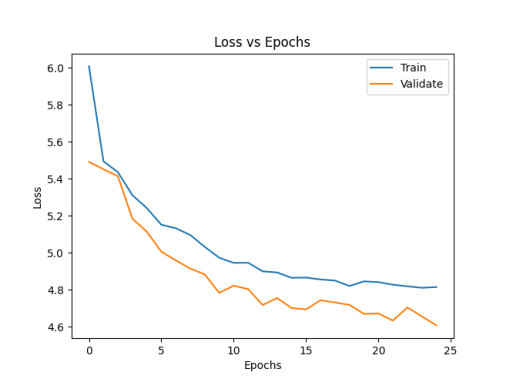

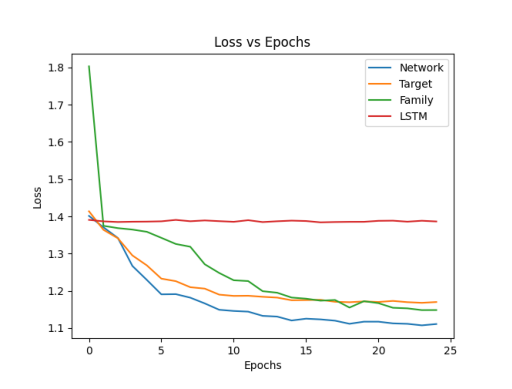

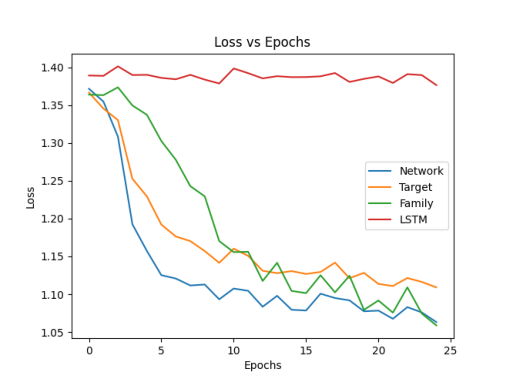

,name,GNN LSTM values
37,metric_auc_roc,0.7990347316592377
38,metric_auc_prc,0.3031034996529286
39,metric_f1,0.3487437185929648
40,metric_recall,0.7949599083619702
41,metric_mcc,0.2889537702521706
42,metric_ts,0.21119902617163724
43,metric_bss,-0.9632694122570156
44,true_negatives,4574
45,false_positives,2413
46,false_negatives,179


In [ ]:
path_25epochs = outpath + '/explainability_experiment_25epochs'
train_loss_png = mpimg.imread(path_25epochs + '/explainability_experiment_train_loss_25epochs.png')
train_seperate_loss_png = mpimg.imread(path_25epochs + '/explainability_experiment_train_separate_loss_25epochs.png')
validate_seperate_loss_png = mpimg.imread(path_25epochs + '/explainability_experiment_validate_separate_loss_25epochs.png')

plt.imshow(train_loss_png)
plt.axis('off')
plt.show()

plt.imshow(train_seperate_loss_png)
plt.axis('off')
plt.show()

plt.imshow(validate_seperate_loss_png)
plt.axis('off')
plt.show()

gnnlstm_stats = pd.read_csv(path_25epochs + '/explainability_experiment_stats_25epochs.csv').tail(11).rename(columns={'value':'GNN LSTM values'})
gnnlstm_stats

## Model comparison

The paper does ablation studies that compares its proposed model (GNN-LSTM) with various combination of features:
* [A1] 2-layer multi-layer perceptron (MLP) for age and sex features
* [A2] A1 + family history features
* [A3] A1 + graph connectivity (connected family network for the entire dataset)
* [A4] A1 + longitudinal EHR data LSTM: using a single-layer, bidirectional LSTM
* [A5] A4 + family history features
* [AG/G2] GNN-LSTM




Below is the table comparison of metric results between experiment A2: Baseline model using age, sex, and family history; experiment A5: Baseline Longitudinal model using age, sex, family history, and longitudinal data; and experiment G2: the GNN LSTM model with longitudinal data. Each model was trained for 25 epochs.

In [ ]:
baselineA2_stats = pd.read_csv(outpath + '/baselineA2_experiment_stats.csv').tail(11).rename(columns={"value":"Baseline A2 values"})
baselineA5_stats = pd.read_csv(outpath + '/baselineA5_experiment_stats.csv').tail(11).rename(columns={"value":"Baseline A5 values"})
gnnlstm_stats = pd.read_csv(path_25epochs+ '/explainability_experiment_stats_25epochs.csv').tail(11).rename(columns={'value':'GNN LSTM values'})
stats_pd = baselineA2_stats.merge(baselineA5_stats)
stats_pd = stats_pd.merge(gnnlstm_stats)
stats_pd

,name,Baseline A2 values,Baseline A5 values,GNN LSTM values
0,metric_auc_roc,0.7697122343557034,0.7662297400293886,0.7990347316592377
1,metric_auc_prc,0.27258575262294255,0.2710977441171657,0.3031034996529286
2,metric_f1,0.32305909617612977,0.3373558594797533,0.3487437185929648
3,metric_recall,0.7983963344788088,0.720504009163803,0.7949599083619702
4,metric_mcc,0.25683287517976455,0.2624770878466773,0.2889537702521706
5,metric_ts,0.19264787175234938,0.20290322580645162,0.21119902617163724
6,metric_bss,-1.1849457746274976,-1.004424517266191,-0.9632694122570156
7,true_negatives,4242,4760,4574
8,false_positives,2745,2227,2413
9,false_negatives,176,244,179


The values for the metrics AUC ROC, AUC PRC, and MCC are consistently better for the GNN-LSTM model than the other two models. This shows that GNN-LSTM is able to predict the onset of hereditary diseases better than these baseline models, with or without longitudinal data.

### Baseline
The model below is a baseline to be compared to the proposed GNN-LSTM [AG/G2]. It consists of 2-layer multi-layer perceptron that accepts various features. This model is used for experiment A1, A2, and A3.

In [ ]:
class Baseline(torch.nn.Module):
    def __init__(self, num_features_static, hidden_dim, dropout_rate):
        super().__init__()
        self.static_linear1 = nn.Linear(num_features_static, hidden_dim)
        self.static_linear2 = nn.Linear(hidden_dim, hidden_dim)
        self.final_linear = nn.Linear(hidden_dim, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x_static):
        linear_out = self.relu(self.static_linear1(x_static))
        linear_out = self.relu(self.static_linear2(linear_out))
        linear_out = self.dropout(linear_out)
        out = self.sigmoid(self.final_linear(linear_out))
        return out

### Baseline Longitudinal

This baseline model is used to run experiment that includes longitudinal data, such as experiment A4 and A5.

In [ ]:
class BaselineLongitudinal(torch.nn.Module):
    def __init__(self, num_features_static, num_features_longitudinal, main_hidden_dim, lstm_hidden_dim, dropout_rate, num_lstm_layers=1):
        super().__init__()
        self.lstm = nn.LSTM(num_features_longitudinal, lstm_hidden_dim, num_lstm_layers, batch_first=True, bidirectional=True, bias=False)
        self.lstm_hidden_dim = lstm_hidden_dim
        self.combined_linear1 = nn.Linear(num_features_static + lstm_hidden_dim*2, main_hidden_dim)
        self.combined_linear2 = nn.Linear(main_hidden_dim, main_hidden_dim)
        self.final_linear = nn.Linear(main_hidden_dim, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x_static, x_longitudinal):
        output, (hn, cn) = self.lstm(x_longitudinal)
        hn_bi = torch.cat((hn[0],hn[1]), dim=1)
        longitudinal_out = self.relu(hn_bi)
        x_cat = torch.cat((x_static, longitudinal_out), 1)
        linear_out = self.relu(self.combined_linear1(x_cat))
        linear_out = self.relu(self.combined_linear2(linear_out))
        linear_out = self.dropout(linear_out)
        out = self.sigmoid(self.final_linear(linear_out))
        return out

# Discussion

The results of our experiment show that the GNN-LSTM model is able to predict hereditary diseases in patients well. Our GNN-LSTM model produces results similar to the original paper's results. One difficulty in reproducing the experiment includes obtaining data. Although we used the provided sample synthetic dataset, we could produce more accurate results if we could obtain access to real EHR data. Despite these difficulties, the authors of the paper provided a good codebase that is well-documented and easy to follow, making it possible for us to reproduce the experiment.

Our recommendation to the original authors of this paper is to provide code for the graph representations of the GNN-LSTM explanations for parent node embeddings using clustering. This will help others to reproduce and explain the results with visualization rather than tabular data in csv format.

# References

1. Wharrie, S., Yang, Z., Ganna, A., & Kaski, S. Characterizing personalized effects of family information on disease risk using graph representation learning. Proceedings of Machine Learning Research. 2023, 219, 824-845. doi: https://arxiv.org/abs/2304.05010
2. https://github.com/dsgelab/family-EHR-graphs
3. Hamid Behravan, Jaana M Hartikainen, Maria Tengstr ̈om, Veli-Matti Kosma, and Arto
Mannermaa. Predicting breast cancer risk using interacting genetic and demographic factors
and machine learning. Scientific reports, 10(1):11044, 2020.
4. Sivan Kinreich, Jacquelyn L Meyers, Adi Maron-Katz, Chella Kamarajan, Ashwini K Pandey,
David B Chorlian, Jian Zhang, Gayathri Pandey, Stacey Subbie-Saenz de Viteri, Dan Pitti, et al. Predicting risk for alcohol use disorder using longitudinal data with multimodal biomarkers and family history: a machine learning study. Molecular psychiatry, 26(4):1133–1141, 2021.

